# DC GAN

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np



## Input shape definition

In [0]:

# Input shape
img_rows = 28
img_cols = 28
channels = 1
img_shape = ( img_rows,  img_cols,  channels)
latent_dim = 100


## Discriminator

In [0]:
def  discriminator( ):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape= img_shape, padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape= img_shape)
    validity = model(img)

    return Model(img, validity)


In [149]:
optimizer = Adam(0.05, 0.5)

# Build and compile the discriminator
d =   discriminator()
d.compile(loss='binary_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
activation_83 (Activation)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_19 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
activation_84 (Activation)   (None, 8, 8, 64)          0         
__________

## Generator

In [0]:
def  generator( ):

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim= latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D( channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=( latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [152]:
# Build the generator
g =   generator()

# The generator takes noise as input and generates imgs
z = Input(shape=( latent_dim,))
img =  g(z)

# For the combined model we will only train the generator
d.trainable = False

# The discriminator takes generated images as input and determines validity
valid =  d(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_16 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_88 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_90 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_32 (UpSampling (None, 28, 28, 128)       0         
__________

In [0]:
def train(  epochs, batch_size=128, display_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size,  latent_dim))
        gen_imgs =  generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real =  discriminator.train_on_batch(imgs, valid)
        d_loss_fake =  discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss =  combined.train_on_batch(noise, valid)

        # Plot the progress
        #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % display_interval == 0:
             display_imgs(epoch)


## Display generated images 

In [0]:
def display_imgs(  epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c,  latent_dim))
    gen_imgs =  generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()



## Compile GAN

In [0]:
def compileGAN(lr):
  optimizer = Adam(lr, 0.5)

  # Build and compile the discriminator
  d =   discriminator()
  d.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
  # Build the generator
  g =   generator()

  # The generator takes noise as input and generates imgs
  z = Input(shape=( latent_dim,))
  img =  g(z)

  # For the combined model we will only train the generator
  d.trainable = False

  # The discriminator takes generated images as input and determines validity
  valid =  d(img)

  # The combined model  (stacked generator and discriminator)
  # Trains the generator to fool the discriminator
  combined = Model(z, valid)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer)

## 1. Learning rate =0.05 and batchsize =128

In [161]:
compileGAN(0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
activation_121 (Activation)  (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_24 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_110 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
activation_122 (Activation)  (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.525652, acc.: 78.52%] [G loss: 1.178902]


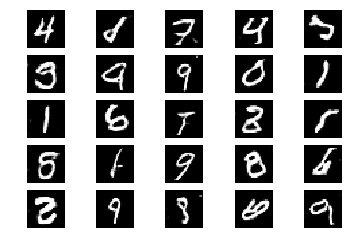

1 [D loss: 0.623371, acc.: 62.89%] [G loss: 0.978252]
2 [D loss: 0.562145, acc.: 72.66%] [G loss: 0.893321]
3 [D loss: 0.613141, acc.: 68.75%] [G loss: 1.289416]
4 [D loss: 0.607531, acc.: 66.80%] [G loss: 1.054855]
5 [D loss: 0.631052, acc.: 62.89%] [G loss: 0.818934]
6 [D loss: 0.611745, acc.: 66.02%] [G loss: 1.079143]
7 [D loss: 0.513969, acc.: 75.39%] [G loss: 1.153000]
8 [D loss: 0.524940, acc.: 75.78%] [G loss: 1.162605]
9 [D loss: 0.577602, acc.: 72.27%] [G loss: 1.033530]
10 [D loss: 0.641914, acc.: 63.28%] [G loss: 1.343226]
11 [D loss: 0.645398, acc.: 63.28%] [G loss: 0.890951]
12 [D loss: 0.496838, acc.: 77.34%] [G loss: 1.277688]
13 [D loss: 0.685921, acc.: 57.03%] [G loss: 1.341281]
14 [D loss: 0.595214, acc.: 68.75%] [G loss: 1.083511]
15 [D loss: 0.628163, acc.: 66.02%] [G loss: 1.245150]
16 [D loss: 0.561138, acc.: 69.53%] [G loss: 1.214390]
17 [D loss: 0.697465, acc.: 57.42%] [G loss: 1.038771]
18 [D loss: 0.616449, acc.: 67.19%] [G loss: 1.043156]
19 [D loss: 0.59428

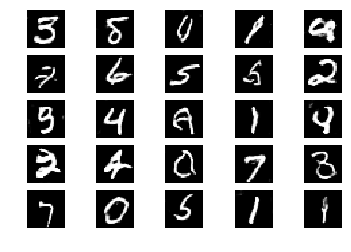

51 [D loss: 0.584281, acc.: 71.09%] [G loss: 1.422091]
52 [D loss: 0.603368, acc.: 69.14%] [G loss: 1.046504]
53 [D loss: 0.538053, acc.: 77.34%] [G loss: 1.174466]
54 [D loss: 0.544859, acc.: 72.66%] [G loss: 1.138205]
55 [D loss: 0.675240, acc.: 60.16%] [G loss: 0.987968]
56 [D loss: 0.502472, acc.: 76.95%] [G loss: 1.062656]
57 [D loss: 0.519142, acc.: 74.61%] [G loss: 1.259243]
58 [D loss: 0.645268, acc.: 64.45%] [G loss: 0.978202]
59 [D loss: 0.540871, acc.: 71.48%] [G loss: 1.419750]
60 [D loss: 0.686394, acc.: 57.03%] [G loss: 0.929507]
61 [D loss: 0.457077, acc.: 83.59%] [G loss: 1.283068]
62 [D loss: 0.532628, acc.: 76.95%] [G loss: 1.222312]
63 [D loss: 0.593476, acc.: 70.31%] [G loss: 1.203245]
64 [D loss: 0.572754, acc.: 68.75%] [G loss: 1.269045]
65 [D loss: 0.707952, acc.: 57.81%] [G loss: 1.158360]
66 [D loss: 0.527875, acc.: 73.44%] [G loss: 1.232846]
67 [D loss: 0.608168, acc.: 66.02%] [G loss: 0.994959]
68 [D loss: 0.646831, acc.: 63.67%] [G loss: 1.204529]
69 [D loss

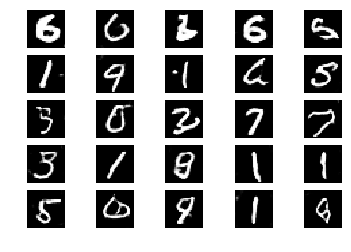

101 [D loss: 0.614498, acc.: 64.45%] [G loss: 1.121547]
102 [D loss: 0.720229, acc.: 56.64%] [G loss: 1.071458]
103 [D loss: 0.481454, acc.: 82.42%] [G loss: 1.186418]
104 [D loss: 0.500679, acc.: 76.56%] [G loss: 1.197786]
105 [D loss: 0.549121, acc.: 73.05%] [G loss: 0.988395]
106 [D loss: 0.572463, acc.: 72.27%] [G loss: 1.193586]
107 [D loss: 0.585791, acc.: 70.70%] [G loss: 1.141835]
108 [D loss: 0.555592, acc.: 74.61%] [G loss: 1.158982]
109 [D loss: 0.609734, acc.: 65.62%] [G loss: 1.087961]
110 [D loss: 0.614839, acc.: 67.97%] [G loss: 1.047733]
111 [D loss: 0.485931, acc.: 82.42%] [G loss: 1.270693]
112 [D loss: 0.659465, acc.: 60.94%] [G loss: 1.184171]
113 [D loss: 0.625918, acc.: 64.84%] [G loss: 1.235148]
114 [D loss: 0.626899, acc.: 65.62%] [G loss: 1.064533]
115 [D loss: 0.498283, acc.: 78.52%] [G loss: 1.263472]
116 [D loss: 0.505159, acc.: 79.69%] [G loss: 1.060022]
117 [D loss: 0.557912, acc.: 72.27%] [G loss: 1.139257]
118 [D loss: 0.631432, acc.: 62.89%] [G loss: 0.

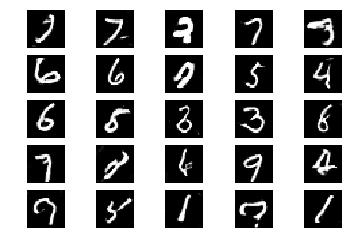

151 [D loss: 0.523743, acc.: 74.61%] [G loss: 1.228381]
152 [D loss: 0.546345, acc.: 75.00%] [G loss: 1.118001]
153 [D loss: 0.507300, acc.: 77.73%] [G loss: 1.002922]
154 [D loss: 0.650316, acc.: 63.28%] [G loss: 1.256584]
155 [D loss: 0.549294, acc.: 71.88%] [G loss: 1.319741]
156 [D loss: 0.568101, acc.: 69.14%] [G loss: 1.173178]
157 [D loss: 0.585645, acc.: 71.09%] [G loss: 1.066646]
158 [D loss: 0.725274, acc.: 55.08%] [G loss: 0.969546]
159 [D loss: 0.596574, acc.: 67.19%] [G loss: 1.235393]
160 [D loss: 0.487732, acc.: 76.17%] [G loss: 1.067318]
161 [D loss: 0.588446, acc.: 71.09%] [G loss: 1.125878]
162 [D loss: 0.505961, acc.: 79.69%] [G loss: 1.201140]
163 [D loss: 0.579773, acc.: 68.75%] [G loss: 1.270528]
164 [D loss: 0.564840, acc.: 72.27%] [G loss: 1.345250]
165 [D loss: 0.498462, acc.: 78.52%] [G loss: 1.091311]
166 [D loss: 0.532468, acc.: 77.73%] [G loss: 1.266737]
167 [D loss: 0.611874, acc.: 66.41%] [G loss: 1.009382]
168 [D loss: 0.558276, acc.: 73.44%] [G loss: 1.

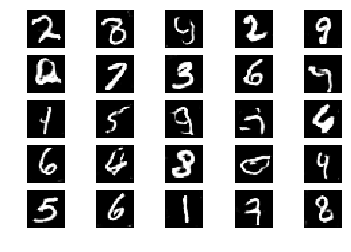

201 [D loss: 0.579849, acc.: 70.31%] [G loss: 1.000099]
202 [D loss: 0.486584, acc.: 79.69%] [G loss: 1.205377]
203 [D loss: 0.655964, acc.: 64.45%] [G loss: 1.147561]
204 [D loss: 0.487978, acc.: 80.86%] [G loss: 1.318983]
205 [D loss: 0.576011, acc.: 71.48%] [G loss: 1.158114]
206 [D loss: 0.496895, acc.: 78.12%] [G loss: 1.307984]
207 [D loss: 0.532958, acc.: 75.00%] [G loss: 0.892818]
208 [D loss: 0.502067, acc.: 78.91%] [G loss: 1.116286]
209 [D loss: 0.633914, acc.: 62.89%] [G loss: 1.080894]
210 [D loss: 0.644672, acc.: 66.02%] [G loss: 1.050911]
211 [D loss: 0.558571, acc.: 72.27%] [G loss: 1.178737]
212 [D loss: 0.631564, acc.: 63.28%] [G loss: 1.124972]
213 [D loss: 0.527001, acc.: 79.30%] [G loss: 1.185591]
214 [D loss: 0.631948, acc.: 67.58%] [G loss: 1.246733]
215 [D loss: 0.554055, acc.: 69.53%] [G loss: 1.106935]
216 [D loss: 0.663246, acc.: 59.77%] [G loss: 1.066514]
217 [D loss: 0.643416, acc.: 62.50%] [G loss: 1.091189]
218 [D loss: 0.430507, acc.: 85.16%] [G loss: 1.

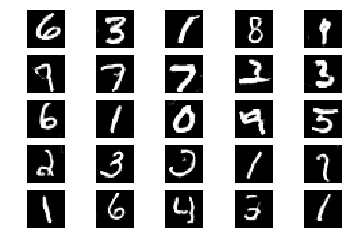

251 [D loss: 0.729627, acc.: 52.73%] [G loss: 0.987495]
252 [D loss: 0.647114, acc.: 59.77%] [G loss: 1.104458]
253 [D loss: 0.611259, acc.: 64.45%] [G loss: 1.173472]
254 [D loss: 0.647984, acc.: 61.72%] [G loss: 0.982327]
255 [D loss: 0.650808, acc.: 62.89%] [G loss: 1.043216]
256 [D loss: 0.679472, acc.: 57.03%] [G loss: 1.178956]
257 [D loss: 0.579090, acc.: 67.58%] [G loss: 1.206598]
258 [D loss: 0.528331, acc.: 76.17%] [G loss: 1.067052]
259 [D loss: 0.622819, acc.: 65.23%] [G loss: 1.227545]
260 [D loss: 0.658596, acc.: 60.16%] [G loss: 1.072889]
261 [D loss: 0.617567, acc.: 63.67%] [G loss: 1.003690]
262 [D loss: 0.671456, acc.: 61.33%] [G loss: 1.088767]
263 [D loss: 0.596281, acc.: 67.58%] [G loss: 1.058019]
264 [D loss: 0.596663, acc.: 74.22%] [G loss: 1.316823]
265 [D loss: 0.589426, acc.: 71.48%] [G loss: 1.123660]
266 [D loss: 0.556178, acc.: 72.66%] [G loss: 1.308294]
267 [D loss: 0.565067, acc.: 70.70%] [G loss: 1.647775]
268 [D loss: 0.592960, acc.: 70.70%] [G loss: 1.

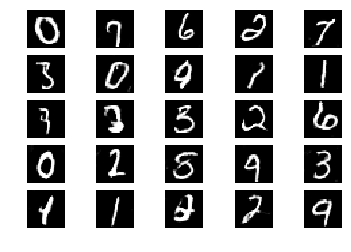

301 [D loss: 0.547936, acc.: 74.22%] [G loss: 1.291239]
302 [D loss: 0.483266, acc.: 81.64%] [G loss: 1.216743]
303 [D loss: 0.615154, acc.: 67.19%] [G loss: 1.129384]
304 [D loss: 0.622686, acc.: 64.84%] [G loss: 1.290526]
305 [D loss: 0.678531, acc.: 58.20%] [G loss: 1.167743]
306 [D loss: 0.621281, acc.: 60.94%] [G loss: 1.068952]
307 [D loss: 0.605266, acc.: 67.97%] [G loss: 1.158956]
308 [D loss: 0.643184, acc.: 63.28%] [G loss: 1.016198]
309 [D loss: 0.466636, acc.: 79.30%] [G loss: 1.429710]
310 [D loss: 0.660820, acc.: 62.11%] [G loss: 1.108981]
311 [D loss: 0.550241, acc.: 72.66%] [G loss: 1.129106]
312 [D loss: 0.629871, acc.: 63.67%] [G loss: 1.087219]
313 [D loss: 0.569539, acc.: 71.88%] [G loss: 1.194815]
314 [D loss: 0.588185, acc.: 68.75%] [G loss: 1.228847]
315 [D loss: 0.660301, acc.: 62.50%] [G loss: 1.407370]
316 [D loss: 0.616488, acc.: 64.45%] [G loss: 1.232576]
317 [D loss: 0.577295, acc.: 70.31%] [G loss: 0.920960]
318 [D loss: 0.575061, acc.: 71.09%] [G loss: 0.

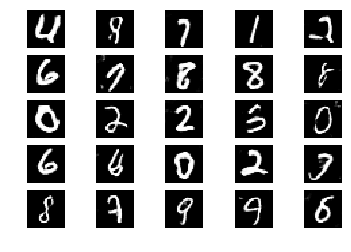

351 [D loss: 0.617210, acc.: 64.45%] [G loss: 1.214679]
352 [D loss: 0.646560, acc.: 61.72%] [G loss: 1.242084]
353 [D loss: 0.648452, acc.: 61.33%] [G loss: 1.020546]
354 [D loss: 0.649345, acc.: 62.50%] [G loss: 1.223829]
355 [D loss: 0.617121, acc.: 67.97%] [G loss: 1.123716]
356 [D loss: 0.653529, acc.: 58.59%] [G loss: 0.866903]
357 [D loss: 0.606313, acc.: 67.58%] [G loss: 1.143062]
358 [D loss: 0.569159, acc.: 70.31%] [G loss: 1.174758]
359 [D loss: 0.609739, acc.: 66.80%] [G loss: 1.421133]
360 [D loss: 0.616911, acc.: 64.06%] [G loss: 1.089028]
361 [D loss: 0.547134, acc.: 73.83%] [G loss: 0.950765]
362 [D loss: 0.568035, acc.: 73.44%] [G loss: 1.090770]
363 [D loss: 0.586645, acc.: 68.75%] [G loss: 1.178578]
364 [D loss: 0.581894, acc.: 69.92%] [G loss: 1.432920]
365 [D loss: 0.668439, acc.: 58.59%] [G loss: 1.331179]
366 [D loss: 0.675072, acc.: 59.38%] [G loss: 1.259723]
367 [D loss: 0.571861, acc.: 71.88%] [G loss: 1.160351]
368 [D loss: 0.541139, acc.: 73.44%] [G loss: 1.

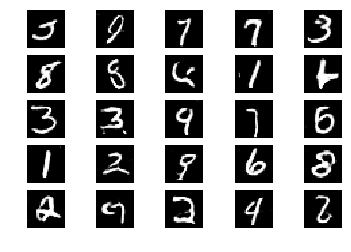

401 [D loss: 0.609487, acc.: 66.80%] [G loss: 1.321483]
402 [D loss: 0.585510, acc.: 68.36%] [G loss: 1.091412]
403 [D loss: 0.614607, acc.: 65.62%] [G loss: 1.192049]
404 [D loss: 0.574636, acc.: 71.88%] [G loss: 1.181663]
405 [D loss: 0.653051, acc.: 62.11%] [G loss: 1.013985]
406 [D loss: 0.645894, acc.: 60.94%] [G loss: 1.083291]
407 [D loss: 0.535886, acc.: 77.34%] [G loss: 0.975640]
408 [D loss: 0.563087, acc.: 71.48%] [G loss: 1.179748]
409 [D loss: 0.640075, acc.: 62.50%] [G loss: 1.112288]
410 [D loss: 0.525823, acc.: 73.05%] [G loss: 1.229330]
411 [D loss: 0.662124, acc.: 60.16%] [G loss: 0.972618]
412 [D loss: 0.657938, acc.: 60.55%] [G loss: 1.053870]
413 [D loss: 0.621580, acc.: 65.62%] [G loss: 1.359838]
414 [D loss: 0.725359, acc.: 57.81%] [G loss: 1.006147]
415 [D loss: 0.684188, acc.: 60.94%] [G loss: 1.088397]
416 [D loss: 0.634076, acc.: 62.50%] [G loss: 1.197398]
417 [D loss: 0.616452, acc.: 65.62%] [G loss: 0.954626]
418 [D loss: 0.663245, acc.: 61.72%] [G loss: 1.

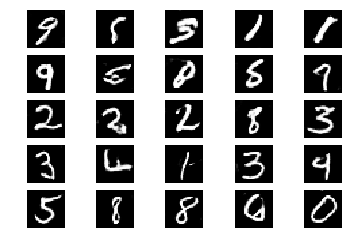

451 [D loss: 0.584721, acc.: 68.36%] [G loss: 0.999010]
452 [D loss: 0.585081, acc.: 70.31%] [G loss: 1.098148]
453 [D loss: 0.572327, acc.: 71.48%] [G loss: 0.951534]
454 [D loss: 0.512816, acc.: 76.56%] [G loss: 1.176091]
455 [D loss: 0.590364, acc.: 68.75%] [G loss: 1.265830]
456 [D loss: 0.685523, acc.: 53.12%] [G loss: 1.165419]
457 [D loss: 0.594903, acc.: 69.14%] [G loss: 0.987309]
458 [D loss: 0.560720, acc.: 71.88%] [G loss: 1.510077]
459 [D loss: 0.725245, acc.: 51.95%] [G loss: 1.088892]
460 [D loss: 0.534164, acc.: 73.44%] [G loss: 1.116294]
461 [D loss: 0.556565, acc.: 72.66%] [G loss: 1.076189]
462 [D loss: 0.529699, acc.: 75.00%] [G loss: 1.108763]
463 [D loss: 0.532092, acc.: 75.78%] [G loss: 1.287634]
464 [D loss: 0.571584, acc.: 71.09%] [G loss: 1.042896]
465 [D loss: 0.569926, acc.: 69.14%] [G loss: 1.177374]
466 [D loss: 0.679357, acc.: 60.55%] [G loss: 1.119105]
467 [D loss: 0.583691, acc.: 69.92%] [G loss: 1.191395]
468 [D loss: 0.583683, acc.: 68.75%] [G loss: 1.

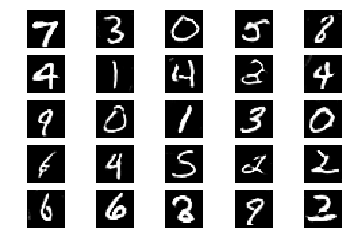

501 [D loss: 0.521012, acc.: 77.34%] [G loss: 1.075066]
502 [D loss: 0.626017, acc.: 62.11%] [G loss: 1.117477]
503 [D loss: 0.572849, acc.: 69.53%] [G loss: 1.262679]
504 [D loss: 0.535509, acc.: 74.22%] [G loss: 1.202722]
505 [D loss: 0.553060, acc.: 73.44%] [G loss: 1.057431]
506 [D loss: 0.554397, acc.: 75.78%] [G loss: 1.340517]
507 [D loss: 0.557969, acc.: 75.00%] [G loss: 1.055364]
508 [D loss: 0.538548, acc.: 75.00%] [G loss: 1.310868]
509 [D loss: 0.557249, acc.: 72.66%] [G loss: 1.109020]
510 [D loss: 0.533954, acc.: 79.30%] [G loss: 1.146527]
511 [D loss: 0.533482, acc.: 74.61%] [G loss: 1.192865]
512 [D loss: 0.519778, acc.: 78.91%] [G loss: 1.153770]
513 [D loss: 0.550295, acc.: 72.27%] [G loss: 1.146993]
514 [D loss: 0.516655, acc.: 75.78%] [G loss: 1.268504]
515 [D loss: 0.719215, acc.: 54.30%] [G loss: 0.892657]
516 [D loss: 0.588807, acc.: 68.36%] [G loss: 1.119027]
517 [D loss: 0.735379, acc.: 48.83%] [G loss: 1.019395]
518 [D loss: 0.528913, acc.: 76.17%] [G loss: 1.

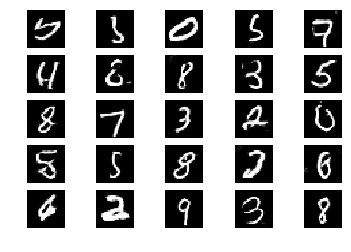

551 [D loss: 0.649589, acc.: 60.94%] [G loss: 0.978211]
552 [D loss: 0.575144, acc.: 70.70%] [G loss: 1.120780]
553 [D loss: 0.632343, acc.: 61.33%] [G loss: 1.093151]
554 [D loss: 0.518790, acc.: 72.27%] [G loss: 1.254778]
555 [D loss: 0.629311, acc.: 67.19%] [G loss: 1.148404]
556 [D loss: 0.660088, acc.: 62.11%] [G loss: 1.077325]
557 [D loss: 0.656243, acc.: 63.28%] [G loss: 1.267126]
558 [D loss: 0.660701, acc.: 61.33%] [G loss: 1.039510]
559 [D loss: 0.555921, acc.: 70.31%] [G loss: 0.983305]
560 [D loss: 0.565483, acc.: 76.56%] [G loss: 1.263033]
561 [D loss: 0.621849, acc.: 66.02%] [G loss: 1.180764]
562 [D loss: 0.707241, acc.: 54.30%] [G loss: 1.106014]
563 [D loss: 0.614873, acc.: 65.23%] [G loss: 1.224098]
564 [D loss: 0.602973, acc.: 64.84%] [G loss: 1.376604]
565 [D loss: 0.631420, acc.: 67.97%] [G loss: 1.327557]
566 [D loss: 0.600621, acc.: 69.14%] [G loss: 1.097328]
567 [D loss: 0.600071, acc.: 67.19%] [G loss: 1.072137]
568 [D loss: 0.677036, acc.: 59.77%] [G loss: 1.

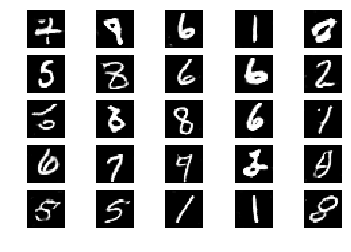

601 [D loss: 0.683051, acc.: 57.42%] [G loss: 0.996384]
602 [D loss: 0.731383, acc.: 51.95%] [G loss: 1.008354]
603 [D loss: 0.642078, acc.: 60.16%] [G loss: 1.200976]
604 [D loss: 0.644743, acc.: 63.28%] [G loss: 1.083368]
605 [D loss: 0.680869, acc.: 57.81%] [G loss: 1.060942]
606 [D loss: 0.556166, acc.: 72.66%] [G loss: 1.039212]
607 [D loss: 0.618501, acc.: 66.41%] [G loss: 1.140166]
608 [D loss: 0.713834, acc.: 55.08%] [G loss: 1.157075]
609 [D loss: 0.607513, acc.: 67.19%] [G loss: 1.083139]
610 [D loss: 0.592255, acc.: 67.58%] [G loss: 1.203260]
611 [D loss: 0.649444, acc.: 63.28%] [G loss: 1.212177]
612 [D loss: 0.602071, acc.: 67.97%] [G loss: 1.369697]
613 [D loss: 0.645144, acc.: 66.41%] [G loss: 1.052855]
614 [D loss: 0.510271, acc.: 78.52%] [G loss: 1.142832]
615 [D loss: 0.536681, acc.: 74.61%] [G loss: 1.241113]
616 [D loss: 0.708134, acc.: 58.20%] [G loss: 1.111316]
617 [D loss: 0.708668, acc.: 53.12%] [G loss: 1.126741]
618 [D loss: 0.735156, acc.: 52.34%] [G loss: 1.

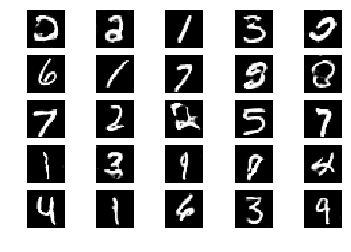

651 [D loss: 0.609863, acc.: 65.23%] [G loss: 1.167427]
652 [D loss: 0.504500, acc.: 76.95%] [G loss: 1.162108]
653 [D loss: 0.696844, acc.: 58.59%] [G loss: 1.104425]
654 [D loss: 0.635143, acc.: 64.84%] [G loss: 1.062845]
655 [D loss: 0.501987, acc.: 76.17%] [G loss: 1.359445]
656 [D loss: 0.782131, acc.: 50.00%] [G loss: 1.165490]
657 [D loss: 0.669609, acc.: 57.81%] [G loss: 1.083783]
658 [D loss: 0.662399, acc.: 60.55%] [G loss: 0.935608]
659 [D loss: 0.578517, acc.: 71.48%] [G loss: 1.119920]
660 [D loss: 0.571757, acc.: 70.70%] [G loss: 1.174663]
661 [D loss: 0.596648, acc.: 68.75%] [G loss: 1.028023]
662 [D loss: 0.628151, acc.: 62.89%] [G loss: 1.067514]
663 [D loss: 0.566521, acc.: 72.66%] [G loss: 1.124983]
664 [D loss: 0.585248, acc.: 68.36%] [G loss: 1.125565]
665 [D loss: 0.598587, acc.: 66.41%] [G loss: 1.107517]
666 [D loss: 0.622456, acc.: 65.23%] [G loss: 1.254230]
667 [D loss: 0.648799, acc.: 58.59%] [G loss: 1.301149]
668 [D loss: 0.565622, acc.: 71.09%] [G loss: 0.

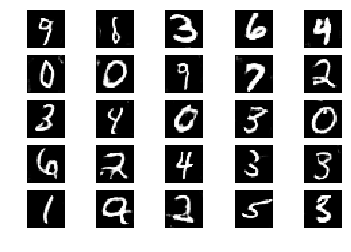

701 [D loss: 0.591225, acc.: 67.97%] [G loss: 1.296565]
702 [D loss: 0.640346, acc.: 64.45%] [G loss: 1.030767]
703 [D loss: 0.687177, acc.: 57.81%] [G loss: 1.359470]
704 [D loss: 0.599026, acc.: 64.45%] [G loss: 1.134107]
705 [D loss: 0.618272, acc.: 64.06%] [G loss: 1.174605]
706 [D loss: 0.635811, acc.: 66.80%] [G loss: 1.139301]
707 [D loss: 0.567792, acc.: 68.75%] [G loss: 1.138616]
708 [D loss: 0.645197, acc.: 61.72%] [G loss: 1.289291]
709 [D loss: 0.640459, acc.: 64.84%] [G loss: 1.216959]
710 [D loss: 0.588374, acc.: 69.53%] [G loss: 1.049666]
711 [D loss: 0.516417, acc.: 79.69%] [G loss: 1.171200]
712 [D loss: 0.641177, acc.: 64.45%] [G loss: 1.124592]
713 [D loss: 0.621633, acc.: 64.84%] [G loss: 1.141559]
714 [D loss: 0.632518, acc.: 62.11%] [G loss: 1.050625]
715 [D loss: 0.583509, acc.: 68.75%] [G loss: 1.277112]
716 [D loss: 0.661888, acc.: 61.33%] [G loss: 1.233391]
717 [D loss: 0.622176, acc.: 66.02%] [G loss: 1.210518]
718 [D loss: 0.522365, acc.: 78.52%] [G loss: 0.

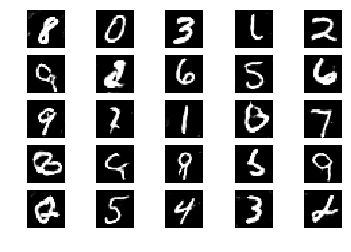

751 [D loss: 0.504452, acc.: 80.08%] [G loss: 1.258828]
752 [D loss: 0.656326, acc.: 59.38%] [G loss: 1.342539]
753 [D loss: 0.644224, acc.: 64.06%] [G loss: 1.311840]
754 [D loss: 0.527729, acc.: 75.39%] [G loss: 0.947983]
755 [D loss: 0.526057, acc.: 77.73%] [G loss: 0.935473]
756 [D loss: 0.640986, acc.: 65.23%] [G loss: 1.220396]
757 [D loss: 0.617613, acc.: 62.11%] [G loss: 1.049201]
758 [D loss: 0.590722, acc.: 67.58%] [G loss: 1.257616]
759 [D loss: 0.499550, acc.: 76.95%] [G loss: 1.191497]
760 [D loss: 0.614200, acc.: 65.62%] [G loss: 1.058076]
761 [D loss: 0.566665, acc.: 71.88%] [G loss: 1.400221]
762 [D loss: 0.642588, acc.: 62.50%] [G loss: 1.230879]
763 [D loss: 0.659135, acc.: 62.50%] [G loss: 1.373595]
764 [D loss: 0.622960, acc.: 63.67%] [G loss: 1.087884]
765 [D loss: 0.624195, acc.: 64.06%] [G loss: 1.190475]
766 [D loss: 0.677341, acc.: 59.38%] [G loss: 0.832763]
767 [D loss: 0.550565, acc.: 73.44%] [G loss: 0.926316]
768 [D loss: 0.699507, acc.: 54.69%] [G loss: 1.

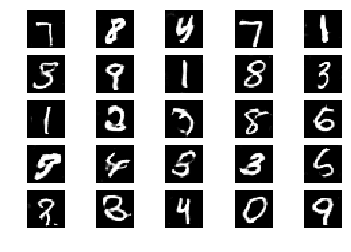

801 [D loss: 0.541394, acc.: 73.83%] [G loss: 1.204507]
802 [D loss: 0.630286, acc.: 66.02%] [G loss: 1.170060]
803 [D loss: 0.569203, acc.: 69.92%] [G loss: 1.074949]
804 [D loss: 0.574791, acc.: 68.75%] [G loss: 1.129426]
805 [D loss: 0.515146, acc.: 77.34%] [G loss: 1.092501]
806 [D loss: 0.510419, acc.: 77.73%] [G loss: 1.151067]
807 [D loss: 0.592846, acc.: 69.14%] [G loss: 1.075512]
808 [D loss: 0.503020, acc.: 80.08%] [G loss: 1.182840]
809 [D loss: 0.653352, acc.: 56.64%] [G loss: 1.020231]
810 [D loss: 0.564056, acc.: 73.44%] [G loss: 1.167179]
811 [D loss: 0.657724, acc.: 60.16%] [G loss: 1.107590]
812 [D loss: 0.680153, acc.: 55.86%] [G loss: 1.120628]
813 [D loss: 0.547207, acc.: 76.17%] [G loss: 1.211121]
814 [D loss: 0.684426, acc.: 60.16%] [G loss: 0.960096]
815 [D loss: 0.684653, acc.: 61.33%] [G loss: 1.162488]
816 [D loss: 0.745688, acc.: 51.56%] [G loss: 1.039510]
817 [D loss: 0.603694, acc.: 66.02%] [G loss: 0.940442]
818 [D loss: 0.593337, acc.: 64.84%] [G loss: 1.

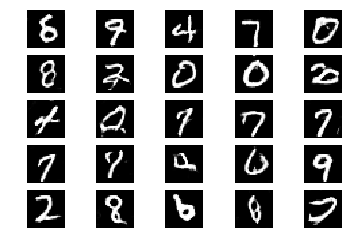

851 [D loss: 0.668870, acc.: 57.42%] [G loss: 1.089567]
852 [D loss: 0.653871, acc.: 63.67%] [G loss: 1.147371]
853 [D loss: 0.496199, acc.: 80.08%] [G loss: 1.376075]
854 [D loss: 0.599832, acc.: 69.53%] [G loss: 0.934025]
855 [D loss: 0.702939, acc.: 55.86%] [G loss: 0.855186]
856 [D loss: 0.655083, acc.: 62.50%] [G loss: 1.012533]
857 [D loss: 0.528762, acc.: 75.00%] [G loss: 1.236700]
858 [D loss: 0.551829, acc.: 74.61%] [G loss: 0.955922]
859 [D loss: 0.783569, acc.: 46.88%] [G loss: 1.023146]
860 [D loss: 0.640510, acc.: 64.45%] [G loss: 1.235989]
861 [D loss: 0.735146, acc.: 53.52%] [G loss: 1.194679]
862 [D loss: 0.617556, acc.: 62.50%] [G loss: 1.164867]
863 [D loss: 0.663274, acc.: 61.72%] [G loss: 1.063658]
864 [D loss: 0.656911, acc.: 61.72%] [G loss: 1.430060]
865 [D loss: 0.589631, acc.: 69.53%] [G loss: 1.155205]
866 [D loss: 0.595633, acc.: 69.53%] [G loss: 1.226413]
867 [D loss: 0.640819, acc.: 64.06%] [G loss: 1.007117]
868 [D loss: 0.669002, acc.: 62.89%] [G loss: 1.

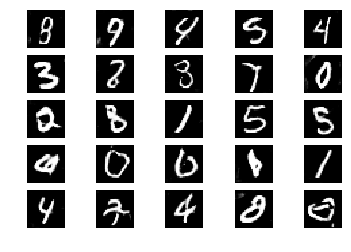

901 [D loss: 0.714666, acc.: 56.25%] [G loss: 1.236481]
902 [D loss: 0.524162, acc.: 77.34%] [G loss: 1.294361]
903 [D loss: 0.655858, acc.: 61.33%] [G loss: 0.998087]
904 [D loss: 0.576547, acc.: 68.36%] [G loss: 1.095610]
905 [D loss: 0.562616, acc.: 71.09%] [G loss: 1.529239]
906 [D loss: 0.646574, acc.: 62.11%] [G loss: 1.328964]
907 [D loss: 0.543515, acc.: 71.88%] [G loss: 1.033494]
908 [D loss: 0.526427, acc.: 75.00%] [G loss: 1.146572]
909 [D loss: 0.643480, acc.: 62.50%] [G loss: 1.175693]
910 [D loss: 0.700523, acc.: 56.25%] [G loss: 1.073342]
911 [D loss: 0.552153, acc.: 69.53%] [G loss: 1.109086]
912 [D loss: 0.577884, acc.: 68.75%] [G loss: 1.326980]
913 [D loss: 0.626345, acc.: 67.58%] [G loss: 1.291307]
914 [D loss: 0.730635, acc.: 53.52%] [G loss: 1.087993]
915 [D loss: 0.680769, acc.: 58.59%] [G loss: 1.240287]
916 [D loss: 0.642139, acc.: 63.67%] [G loss: 1.215307]
917 [D loss: 0.647198, acc.: 66.80%] [G loss: 1.199920]
918 [D loss: 0.662946, acc.: 66.41%] [G loss: 1.

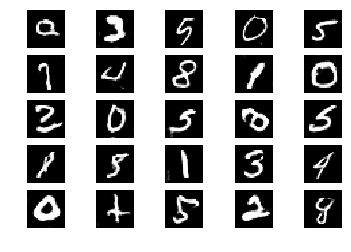

951 [D loss: 0.546554, acc.: 71.88%] [G loss: 1.162699]
952 [D loss: 0.727614, acc.: 53.91%] [G loss: 1.286948]
953 [D loss: 0.664094, acc.: 65.23%] [G loss: 1.014774]
954 [D loss: 0.482898, acc.: 83.20%] [G loss: 1.050414]
955 [D loss: 0.572607, acc.: 72.27%] [G loss: 0.977614]
956 [D loss: 0.582224, acc.: 67.58%] [G loss: 1.080507]
957 [D loss: 0.582306, acc.: 69.14%] [G loss: 1.219510]
958 [D loss: 0.611488, acc.: 63.28%] [G loss: 1.373502]
959 [D loss: 0.649623, acc.: 64.84%] [G loss: 0.977263]
960 [D loss: 0.762797, acc.: 50.39%] [G loss: 0.845592]
961 [D loss: 0.616220, acc.: 66.02%] [G loss: 1.146545]
962 [D loss: 0.655490, acc.: 64.84%] [G loss: 1.161046]
963 [D loss: 0.593800, acc.: 69.53%] [G loss: 1.203065]
964 [D loss: 0.635438, acc.: 65.62%] [G loss: 1.064663]
965 [D loss: 0.695204, acc.: 54.30%] [G loss: 1.066735]
966 [D loss: 0.703443, acc.: 56.64%] [G loss: 1.155497]
967 [D loss: 0.572528, acc.: 72.66%] [G loss: 1.109623]
968 [D loss: 0.657843, acc.: 62.89%] [G loss: 0.

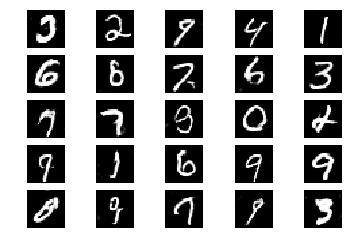

1001 [D loss: 0.652780, acc.: 60.55%] [G loss: 1.139368]
1002 [D loss: 0.618580, acc.: 66.80%] [G loss: 1.078602]
1003 [D loss: 0.607742, acc.: 67.58%] [G loss: 1.098960]
1004 [D loss: 0.490937, acc.: 81.25%] [G loss: 1.294112]
1005 [D loss: 0.644952, acc.: 63.28%] [G loss: 1.134429]
1006 [D loss: 0.525569, acc.: 73.83%] [G loss: 1.093423]
1007 [D loss: 0.578075, acc.: 69.14%] [G loss: 1.361236]
1008 [D loss: 0.576106, acc.: 71.48%] [G loss: 0.790426]
1009 [D loss: 0.805244, acc.: 44.92%] [G loss: 0.933953]
1010 [D loss: 0.462072, acc.: 83.98%] [G loss: 1.156434]
1011 [D loss: 0.627648, acc.: 62.50%] [G loss: 1.023178]
1012 [D loss: 0.571714, acc.: 69.53%] [G loss: 1.219690]
1013 [D loss: 0.613428, acc.: 66.41%] [G loss: 1.252354]
1014 [D loss: 0.543641, acc.: 73.44%] [G loss: 1.264890]
1015 [D loss: 0.561690, acc.: 74.22%] [G loss: 1.076135]
1016 [D loss: 0.596738, acc.: 69.92%] [G loss: 1.006939]
1017 [D loss: 0.673797, acc.: 62.89%] [G loss: 1.164314]
1018 [D loss: 0.573677, acc.: 7

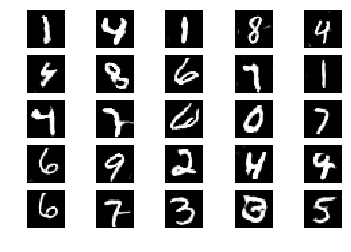

1051 [D loss: 0.563436, acc.: 67.19%] [G loss: 1.267300]
1052 [D loss: 0.510773, acc.: 75.78%] [G loss: 1.143488]
1053 [D loss: 0.705379, acc.: 57.03%] [G loss: 1.021909]
1054 [D loss: 0.609070, acc.: 66.80%] [G loss: 0.951595]
1055 [D loss: 0.600182, acc.: 64.84%] [G loss: 1.077776]
1056 [D loss: 0.573053, acc.: 67.58%] [G loss: 1.037333]
1057 [D loss: 0.491776, acc.: 80.47%] [G loss: 1.327573]
1058 [D loss: 0.692048, acc.: 57.81%] [G loss: 1.311495]
1059 [D loss: 0.613145, acc.: 65.62%] [G loss: 1.131497]
1060 [D loss: 0.674981, acc.: 59.77%] [G loss: 1.182473]
1061 [D loss: 0.518131, acc.: 75.00%] [G loss: 1.470783]
1062 [D loss: 0.665114, acc.: 60.94%] [G loss: 1.137116]
1063 [D loss: 0.579086, acc.: 70.70%] [G loss: 1.340464]
1064 [D loss: 0.593568, acc.: 71.88%] [G loss: 1.193299]
1065 [D loss: 0.615269, acc.: 67.58%] [G loss: 1.090963]
1066 [D loss: 0.616794, acc.: 65.23%] [G loss: 1.160821]
1067 [D loss: 0.668711, acc.: 60.16%] [G loss: 1.122149]
1068 [D loss: 0.677838, acc.: 5

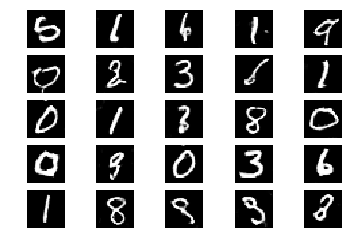

1101 [D loss: 0.607050, acc.: 68.75%] [G loss: 0.996347]
1102 [D loss: 0.522056, acc.: 76.95%] [G loss: 0.912439]
1103 [D loss: 0.532021, acc.: 75.00%] [G loss: 1.033168]
1104 [D loss: 0.544915, acc.: 73.83%] [G loss: 1.386407]
1105 [D loss: 0.597197, acc.: 69.53%] [G loss: 1.166776]
1106 [D loss: 0.688201, acc.: 56.64%] [G loss: 0.982628]
1107 [D loss: 0.647561, acc.: 63.67%] [G loss: 1.019046]
1108 [D loss: 0.511896, acc.: 74.22%] [G loss: 1.151917]
1109 [D loss: 0.649661, acc.: 60.55%] [G loss: 1.270923]
1110 [D loss: 0.615849, acc.: 66.80%] [G loss: 1.112510]
1111 [D loss: 0.687825, acc.: 57.03%] [G loss: 1.218477]
1112 [D loss: 0.542688, acc.: 72.66%] [G loss: 1.329995]
1113 [D loss: 0.636617, acc.: 62.50%] [G loss: 1.285338]
1114 [D loss: 0.625581, acc.: 64.06%] [G loss: 1.109308]
1115 [D loss: 0.701949, acc.: 60.94%] [G loss: 0.991666]
1116 [D loss: 0.613317, acc.: 68.36%] [G loss: 1.169213]
1117 [D loss: 0.677390, acc.: 58.20%] [G loss: 1.097056]
1118 [D loss: 0.682464, acc.: 5

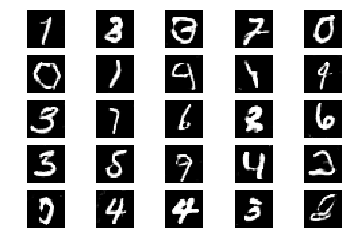

1151 [D loss: 0.642119, acc.: 64.06%] [G loss: 1.155518]
1152 [D loss: 0.662415, acc.: 60.55%] [G loss: 0.978761]
1153 [D loss: 0.548244, acc.: 73.44%] [G loss: 1.277033]
1154 [D loss: 0.628509, acc.: 63.28%] [G loss: 1.206210]
1155 [D loss: 0.578399, acc.: 70.31%] [G loss: 1.148454]
1156 [D loss: 0.597692, acc.: 69.92%] [G loss: 1.108760]
1157 [D loss: 0.569898, acc.: 74.61%] [G loss: 1.341251]
1158 [D loss: 0.653604, acc.: 60.94%] [G loss: 1.073119]
1159 [D loss: 0.714692, acc.: 57.42%] [G loss: 1.217255]
1160 [D loss: 0.618286, acc.: 65.62%] [G loss: 1.102672]
1161 [D loss: 0.592995, acc.: 67.58%] [G loss: 0.991694]
1162 [D loss: 0.597713, acc.: 67.97%] [G loss: 1.169300]
1163 [D loss: 0.746541, acc.: 52.73%] [G loss: 1.132558]
1164 [D loss: 0.543972, acc.: 73.83%] [G loss: 1.132265]
1165 [D loss: 0.604530, acc.: 67.19%] [G loss: 1.131529]
1166 [D loss: 0.683522, acc.: 58.59%] [G loss: 1.186708]
1167 [D loss: 0.656313, acc.: 60.55%] [G loss: 1.269411]
1168 [D loss: 0.553374, acc.: 7

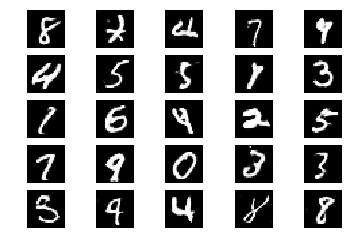

1201 [D loss: 0.486917, acc.: 79.30%] [G loss: 1.016833]
1202 [D loss: 0.601237, acc.: 67.58%] [G loss: 1.186421]
1203 [D loss: 0.543554, acc.: 72.66%] [G loss: 1.002361]
1204 [D loss: 0.651021, acc.: 60.16%] [G loss: 1.026001]
1205 [D loss: 0.501331, acc.: 79.30%] [G loss: 1.215197]
1206 [D loss: 0.662332, acc.: 61.33%] [G loss: 1.027863]
1207 [D loss: 0.609398, acc.: 67.97%] [G loss: 1.187397]
1208 [D loss: 0.602122, acc.: 66.80%] [G loss: 1.341184]
1209 [D loss: 0.629574, acc.: 67.58%] [G loss: 1.044345]
1210 [D loss: 0.691799, acc.: 57.81%] [G loss: 1.278028]
1211 [D loss: 0.548362, acc.: 73.05%] [G loss: 1.348954]
1212 [D loss: 0.669391, acc.: 60.94%] [G loss: 1.089312]
1213 [D loss: 0.624874, acc.: 65.62%] [G loss: 1.391035]
1214 [D loss: 0.563080, acc.: 72.66%] [G loss: 1.002566]
1215 [D loss: 0.710614, acc.: 55.08%] [G loss: 1.075511]
1216 [D loss: 0.619895, acc.: 64.06%] [G loss: 1.263636]
1217 [D loss: 0.600112, acc.: 67.58%] [G loss: 1.322633]
1218 [D loss: 0.629950, acc.: 6

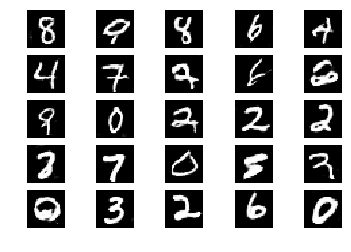

1251 [D loss: 0.555750, acc.: 71.48%] [G loss: 1.022140]
1252 [D loss: 0.595979, acc.: 69.53%] [G loss: 1.300304]
1253 [D loss: 0.530118, acc.: 76.17%] [G loss: 1.028749]
1254 [D loss: 0.754878, acc.: 48.44%] [G loss: 1.118044]
1255 [D loss: 0.603535, acc.: 70.31%] [G loss: 1.117505]
1256 [D loss: 0.722959, acc.: 56.25%] [G loss: 1.135822]
1257 [D loss: 0.645603, acc.: 64.84%] [G loss: 1.273597]
1258 [D loss: 0.642382, acc.: 62.50%] [G loss: 1.029342]
1259 [D loss: 0.537499, acc.: 73.83%] [G loss: 1.126814]
1260 [D loss: 0.492948, acc.: 78.91%] [G loss: 1.513021]
1261 [D loss: 0.582453, acc.: 67.97%] [G loss: 0.939171]
1262 [D loss: 0.582389, acc.: 69.92%] [G loss: 1.374701]
1263 [D loss: 0.606314, acc.: 67.97%] [G loss: 1.094600]
1264 [D loss: 0.519085, acc.: 77.34%] [G loss: 1.077444]
1265 [D loss: 0.627979, acc.: 63.67%] [G loss: 1.017402]
1266 [D loss: 0.762224, acc.: 49.61%] [G loss: 1.183146]
1267 [D loss: 0.573094, acc.: 71.09%] [G loss: 1.253420]
1268 [D loss: 0.673167, acc.: 6

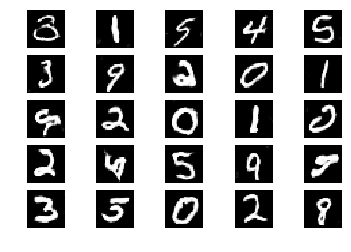

1301 [D loss: 0.742342, acc.: 51.56%] [G loss: 1.014246]
1302 [D loss: 0.566482, acc.: 72.27%] [G loss: 1.096783]
1303 [D loss: 0.546673, acc.: 74.22%] [G loss: 1.250129]
1304 [D loss: 0.543842, acc.: 71.88%] [G loss: 1.157939]
1305 [D loss: 0.595236, acc.: 70.31%] [G loss: 1.157257]
1306 [D loss: 0.615089, acc.: 66.41%] [G loss: 1.150980]
1307 [D loss: 0.690739, acc.: 57.03%] [G loss: 1.363253]
1308 [D loss: 0.600357, acc.: 67.58%] [G loss: 1.057963]
1309 [D loss: 0.633348, acc.: 62.89%] [G loss: 1.028250]
1310 [D loss: 0.577437, acc.: 70.70%] [G loss: 1.218512]
1311 [D loss: 0.644142, acc.: 64.45%] [G loss: 0.825632]
1312 [D loss: 0.587703, acc.: 68.75%] [G loss: 1.175420]
1313 [D loss: 0.646379, acc.: 64.06%] [G loss: 1.068316]
1314 [D loss: 0.593501, acc.: 66.80%] [G loss: 1.299083]
1315 [D loss: 0.602926, acc.: 67.97%] [G loss: 1.152632]
1316 [D loss: 0.500519, acc.: 79.69%] [G loss: 1.192555]
1317 [D loss: 0.636182, acc.: 62.89%] [G loss: 1.255798]
1318 [D loss: 0.685786, acc.: 6

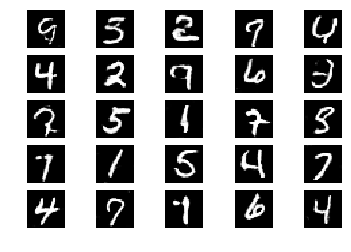

1351 [D loss: 0.532746, acc.: 72.27%] [G loss: 1.239683]
1352 [D loss: 0.530758, acc.: 73.83%] [G loss: 1.171028]
1353 [D loss: 0.618883, acc.: 67.58%] [G loss: 1.353187]
1354 [D loss: 0.561105, acc.: 71.09%] [G loss: 1.106365]
1355 [D loss: 0.640725, acc.: 62.89%] [G loss: 1.139982]
1356 [D loss: 0.588106, acc.: 69.14%] [G loss: 1.299250]
1357 [D loss: 0.582413, acc.: 71.48%] [G loss: 1.206469]
1358 [D loss: 0.600400, acc.: 69.92%] [G loss: 1.259860]
1359 [D loss: 0.585958, acc.: 69.14%] [G loss: 1.163592]
1360 [D loss: 0.629913, acc.: 63.28%] [G loss: 1.128396]
1361 [D loss: 0.589722, acc.: 67.58%] [G loss: 1.159877]
1362 [D loss: 0.630965, acc.: 61.72%] [G loss: 1.331084]
1363 [D loss: 0.692048, acc.: 59.77%] [G loss: 1.058409]
1364 [D loss: 0.747820, acc.: 48.44%] [G loss: 0.976924]
1365 [D loss: 0.606738, acc.: 69.53%] [G loss: 1.187845]
1366 [D loss: 0.605684, acc.: 63.28%] [G loss: 0.912092]
1367 [D loss: 0.560909, acc.: 68.75%] [G loss: 1.295824]
1368 [D loss: 0.574812, acc.: 7

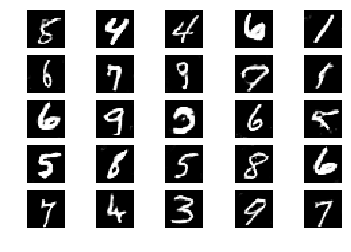

1401 [D loss: 0.418926, acc.: 87.11%] [G loss: 1.346471]
1402 [D loss: 0.620593, acc.: 67.97%] [G loss: 1.320329]
1403 [D loss: 0.591406, acc.: 71.48%] [G loss: 1.193619]
1404 [D loss: 0.676114, acc.: 58.59%] [G loss: 1.149396]
1405 [D loss: 0.565113, acc.: 75.39%] [G loss: 1.202744]
1406 [D loss: 0.700492, acc.: 55.86%] [G loss: 0.861967]
1407 [D loss: 0.548648, acc.: 74.61%] [G loss: 1.189476]
1408 [D loss: 0.608979, acc.: 69.53%] [G loss: 1.018894]
1409 [D loss: 0.506918, acc.: 76.56%] [G loss: 1.337125]
1410 [D loss: 0.560063, acc.: 72.27%] [G loss: 1.205902]
1411 [D loss: 0.561404, acc.: 75.00%] [G loss: 1.095709]
1412 [D loss: 0.682465, acc.: 58.20%] [G loss: 1.069509]
1413 [D loss: 0.533653, acc.: 75.39%] [G loss: 1.172076]
1414 [D loss: 0.517374, acc.: 77.34%] [G loss: 1.240374]
1415 [D loss: 0.648522, acc.: 62.89%] [G loss: 1.004488]
1416 [D loss: 0.672312, acc.: 58.98%] [G loss: 1.069442]
1417 [D loss: 0.704897, acc.: 55.47%] [G loss: 1.163654]
1418 [D loss: 0.643063, acc.: 6

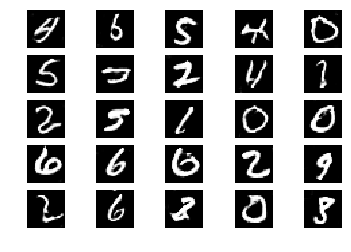

1451 [D loss: 0.499567, acc.: 76.17%] [G loss: 1.266037]
1452 [D loss: 0.684346, acc.: 57.03%] [G loss: 0.979617]
1453 [D loss: 0.521643, acc.: 76.17%] [G loss: 1.216363]
1454 [D loss: 0.710727, acc.: 55.86%] [G loss: 1.100564]
1455 [D loss: 0.599600, acc.: 68.36%] [G loss: 1.082156]
1456 [D loss: 0.605255, acc.: 69.53%] [G loss: 1.265452]
1457 [D loss: 0.657595, acc.: 60.94%] [G loss: 1.006221]
1458 [D loss: 0.620558, acc.: 65.23%] [G loss: 1.253388]
1459 [D loss: 0.555088, acc.: 73.05%] [G loss: 1.187555]
1460 [D loss: 0.621991, acc.: 64.45%] [G loss: 1.007166]
1461 [D loss: 0.646910, acc.: 65.23%] [G loss: 0.949433]
1462 [D loss: 0.509691, acc.: 76.56%] [G loss: 1.298883]
1463 [D loss: 0.703932, acc.: 59.38%] [G loss: 1.043428]
1464 [D loss: 0.658711, acc.: 61.72%] [G loss: 1.119328]
1465 [D loss: 0.646954, acc.: 60.94%] [G loss: 0.944027]
1466 [D loss: 0.605105, acc.: 67.19%] [G loss: 1.088046]
1467 [D loss: 0.610140, acc.: 65.62%] [G loss: 1.294472]
1468 [D loss: 0.598563, acc.: 6

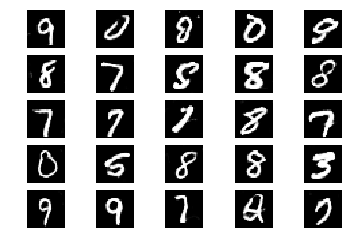

1501 [D loss: 0.540046, acc.: 75.78%] [G loss: 1.374215]
1502 [D loss: 0.596147, acc.: 67.97%] [G loss: 1.021142]
1503 [D loss: 0.557178, acc.: 73.83%] [G loss: 1.270978]
1504 [D loss: 0.525808, acc.: 74.22%] [G loss: 1.231427]
1505 [D loss: 0.565035, acc.: 70.31%] [G loss: 1.235259]
1506 [D loss: 0.609476, acc.: 64.45%] [G loss: 1.269807]
1507 [D loss: 0.647696, acc.: 58.59%] [G loss: 1.064791]
1508 [D loss: 0.575024, acc.: 71.09%] [G loss: 1.272622]
1509 [D loss: 0.552351, acc.: 73.44%] [G loss: 1.235856]
1510 [D loss: 0.515417, acc.: 75.39%] [G loss: 1.152092]
1511 [D loss: 0.565875, acc.: 69.92%] [G loss: 1.149224]
1512 [D loss: 0.620702, acc.: 64.45%] [G loss: 0.941642]
1513 [D loss: 0.545289, acc.: 73.44%] [G loss: 1.360931]
1514 [D loss: 0.642810, acc.: 61.72%] [G loss: 1.166694]
1515 [D loss: 0.627093, acc.: 67.19%] [G loss: 1.116167]
1516 [D loss: 0.600142, acc.: 69.92%] [G loss: 1.258047]
1517 [D loss: 0.591673, acc.: 67.58%] [G loss: 1.188960]
1518 [D loss: 0.599109, acc.: 6

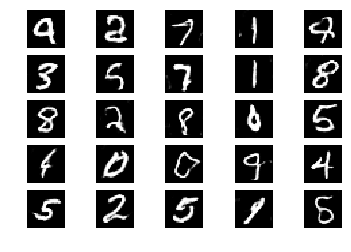

1551 [D loss: 0.592844, acc.: 67.97%] [G loss: 0.893079]
1552 [D loss: 0.564692, acc.: 71.09%] [G loss: 1.027291]
1553 [D loss: 0.599245, acc.: 65.23%] [G loss: 1.142831]
1554 [D loss: 0.709327, acc.: 55.08%] [G loss: 1.148034]
1555 [D loss: 0.634012, acc.: 64.84%] [G loss: 1.145280]
1556 [D loss: 0.521540, acc.: 75.78%] [G loss: 1.175058]
1557 [D loss: 0.695216, acc.: 56.64%] [G loss: 1.066899]
1558 [D loss: 0.587125, acc.: 68.75%] [G loss: 1.318008]
1559 [D loss: 0.587220, acc.: 68.75%] [G loss: 1.031252]
1560 [D loss: 0.592253, acc.: 67.97%] [G loss: 1.205823]
1561 [D loss: 0.669930, acc.: 58.98%] [G loss: 1.192577]
1562 [D loss: 0.619845, acc.: 62.89%] [G loss: 1.122505]
1563 [D loss: 0.614678, acc.: 66.41%] [G loss: 1.302189]
1564 [D loss: 0.594387, acc.: 70.31%] [G loss: 1.105296]
1565 [D loss: 0.538437, acc.: 75.39%] [G loss: 1.237199]
1566 [D loss: 0.688192, acc.: 58.20%] [G loss: 1.065563]
1567 [D loss: 0.567028, acc.: 71.09%] [G loss: 1.443217]
1568 [D loss: 0.596535, acc.: 6

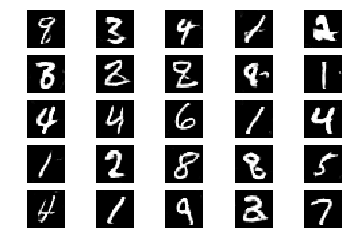

1601 [D loss: 0.586577, acc.: 70.70%] [G loss: 1.094810]
1602 [D loss: 0.611795, acc.: 63.67%] [G loss: 1.267736]
1603 [D loss: 0.613723, acc.: 64.06%] [G loss: 1.051015]
1604 [D loss: 0.553939, acc.: 71.88%] [G loss: 0.940255]
1605 [D loss: 0.754515, acc.: 53.12%] [G loss: 1.028118]
1606 [D loss: 0.583578, acc.: 73.83%] [G loss: 0.989710]
1607 [D loss: 0.566997, acc.: 67.97%] [G loss: 1.305485]
1608 [D loss: 0.639646, acc.: 62.89%] [G loss: 1.112015]
1609 [D loss: 0.556647, acc.: 70.70%] [G loss: 1.279495]
1610 [D loss: 0.671540, acc.: 60.16%] [G loss: 1.125717]
1611 [D loss: 0.531027, acc.: 76.95%] [G loss: 0.994690]
1612 [D loss: 0.684653, acc.: 56.25%] [G loss: 1.219614]
1613 [D loss: 0.594435, acc.: 67.58%] [G loss: 1.161958]
1614 [D loss: 0.672915, acc.: 59.77%] [G loss: 1.210677]
1615 [D loss: 0.730482, acc.: 50.00%] [G loss: 1.055428]
1616 [D loss: 0.730035, acc.: 51.56%] [G loss: 1.143429]
1617 [D loss: 0.524163, acc.: 73.83%] [G loss: 0.996193]
1618 [D loss: 0.662862, acc.: 6

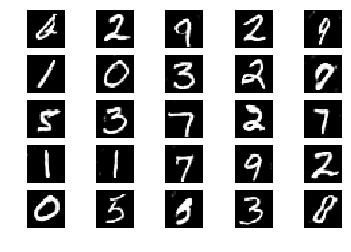

1651 [D loss: 0.719954, acc.: 54.30%] [G loss: 1.224328]
1652 [D loss: 0.639667, acc.: 64.45%] [G loss: 1.076335]
1653 [D loss: 0.599383, acc.: 69.14%] [G loss: 1.181182]
1654 [D loss: 0.651056, acc.: 62.11%] [G loss: 1.049742]
1655 [D loss: 0.610013, acc.: 66.80%] [G loss: 1.300808]
1656 [D loss: 0.639927, acc.: 63.28%] [G loss: 1.113702]
1657 [D loss: 0.593601, acc.: 68.75%] [G loss: 0.999977]
1658 [D loss: 0.538212, acc.: 75.39%] [G loss: 1.154544]
1659 [D loss: 0.675281, acc.: 59.38%] [G loss: 1.176725]
1660 [D loss: 0.558441, acc.: 71.09%] [G loss: 1.218513]
1661 [D loss: 0.690909, acc.: 57.03%] [G loss: 1.112787]
1662 [D loss: 0.578315, acc.: 69.14%] [G loss: 1.278632]
1663 [D loss: 0.531148, acc.: 74.61%] [G loss: 1.310690]
1664 [D loss: 0.762977, acc.: 51.56%] [G loss: 1.128558]
1665 [D loss: 0.663943, acc.: 58.20%] [G loss: 0.969239]
1666 [D loss: 0.551382, acc.: 74.61%] [G loss: 1.025959]
1667 [D loss: 0.579257, acc.: 68.36%] [G loss: 1.051052]
1668 [D loss: 0.605650, acc.: 6

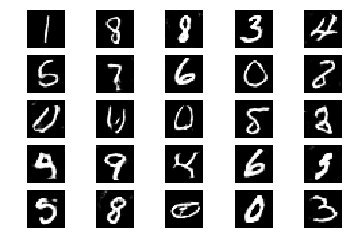

1701 [D loss: 0.558823, acc.: 71.48%] [G loss: 1.020646]
1702 [D loss: 0.642675, acc.: 66.80%] [G loss: 1.252123]
1703 [D loss: 0.561842, acc.: 72.27%] [G loss: 1.321654]
1704 [D loss: 0.636426, acc.: 61.33%] [G loss: 1.243514]
1705 [D loss: 0.779811, acc.: 46.48%] [G loss: 1.025959]
1706 [D loss: 0.661974, acc.: 63.28%] [G loss: 1.033626]
1707 [D loss: 0.633058, acc.: 61.72%] [G loss: 0.881471]
1708 [D loss: 0.665931, acc.: 59.77%] [G loss: 1.116051]
1709 [D loss: 0.526678, acc.: 73.44%] [G loss: 1.203249]
1710 [D loss: 0.525195, acc.: 76.17%] [G loss: 1.261688]
1711 [D loss: 0.641535, acc.: 64.06%] [G loss: 1.090684]
1712 [D loss: 0.672055, acc.: 60.16%] [G loss: 1.081814]
1713 [D loss: 0.860194, acc.: 40.62%] [G loss: 0.901624]
1714 [D loss: 0.566984, acc.: 72.27%] [G loss: 1.209041]
1715 [D loss: 0.578173, acc.: 69.14%] [G loss: 1.112176]
1716 [D loss: 0.677826, acc.: 60.55%] [G loss: 1.010054]
1717 [D loss: 0.673016, acc.: 60.16%] [G loss: 1.115132]
1718 [D loss: 0.622960, acc.: 6

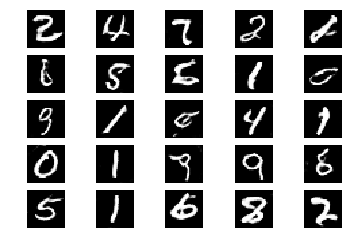

1751 [D loss: 0.635448, acc.: 64.84%] [G loss: 1.349357]
1752 [D loss: 0.579811, acc.: 68.75%] [G loss: 0.919390]
1753 [D loss: 0.524551, acc.: 76.95%] [G loss: 1.340675]
1754 [D loss: 0.669414, acc.: 55.08%] [G loss: 1.035431]
1755 [D loss: 0.579278, acc.: 67.97%] [G loss: 1.252444]
1756 [D loss: 0.721045, acc.: 54.69%] [G loss: 1.377319]
1757 [D loss: 0.534223, acc.: 75.00%] [G loss: 0.976851]
1758 [D loss: 0.534960, acc.: 75.00%] [G loss: 1.288810]
1759 [D loss: 0.595357, acc.: 65.23%] [G loss: 1.039664]
1760 [D loss: 0.624016, acc.: 62.50%] [G loss: 1.140449]
1761 [D loss: 0.560301, acc.: 71.88%] [G loss: 1.116611]
1762 [D loss: 0.627247, acc.: 66.02%] [G loss: 1.175091]
1763 [D loss: 0.611128, acc.: 66.80%] [G loss: 0.849940]
1764 [D loss: 0.647601, acc.: 63.28%] [G loss: 1.228759]
1765 [D loss: 0.611446, acc.: 63.67%] [G loss: 1.085950]
1766 [D loss: 0.462098, acc.: 80.86%] [G loss: 1.173975]
1767 [D loss: 0.571833, acc.: 73.05%] [G loss: 1.143498]
1768 [D loss: 0.636068, acc.: 6

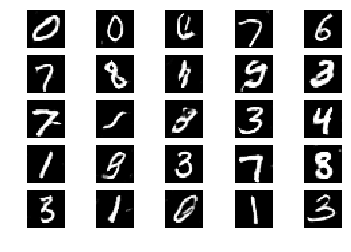

1801 [D loss: 0.599185, acc.: 68.75%] [G loss: 1.258074]
1802 [D loss: 0.534314, acc.: 74.61%] [G loss: 1.428316]
1803 [D loss: 0.653866, acc.: 61.72%] [G loss: 1.035881]
1804 [D loss: 0.619977, acc.: 67.97%] [G loss: 1.283317]
1805 [D loss: 0.585440, acc.: 67.97%] [G loss: 1.129085]
1806 [D loss: 0.551482, acc.: 70.70%] [G loss: 0.952965]
1807 [D loss: 0.609963, acc.: 65.23%] [G loss: 1.085868]
1808 [D loss: 0.612994, acc.: 65.62%] [G loss: 1.143488]
1809 [D loss: 0.472644, acc.: 81.25%] [G loss: 1.323104]
1810 [D loss: 0.666329, acc.: 59.38%] [G loss: 1.138314]
1811 [D loss: 0.814856, acc.: 44.14%] [G loss: 1.021090]
1812 [D loss: 0.671828, acc.: 60.55%] [G loss: 1.028808]
1813 [D loss: 0.562937, acc.: 71.09%] [G loss: 1.159646]
1814 [D loss: 0.604048, acc.: 66.80%] [G loss: 1.267828]
1815 [D loss: 0.681535, acc.: 58.20%] [G loss: 1.119776]
1816 [D loss: 0.604176, acc.: 64.84%] [G loss: 1.002422]
1817 [D loss: 0.585542, acc.: 69.92%] [G loss: 1.455113]
1818 [D loss: 0.598917, acc.: 6

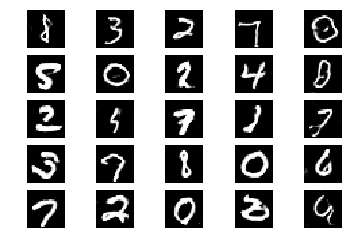

1851 [D loss: 0.605389, acc.: 66.80%] [G loss: 1.297096]
1852 [D loss: 0.505512, acc.: 76.17%] [G loss: 1.083206]
1853 [D loss: 0.525201, acc.: 74.61%] [G loss: 1.178137]
1854 [D loss: 0.625444, acc.: 65.62%] [G loss: 1.212687]
1855 [D loss: 0.641501, acc.: 63.28%] [G loss: 1.038674]
1856 [D loss: 0.613919, acc.: 71.48%] [G loss: 1.200637]
1857 [D loss: 0.633206, acc.: 66.80%] [G loss: 1.431281]
1858 [D loss: 0.692682, acc.: 55.08%] [G loss: 1.205380]
1859 [D loss: 0.669329, acc.: 64.06%] [G loss: 1.166372]
1860 [D loss: 0.640821, acc.: 65.62%] [G loss: 1.068376]
1861 [D loss: 0.618346, acc.: 65.62%] [G loss: 1.225713]
1862 [D loss: 0.604535, acc.: 66.02%] [G loss: 0.985361]
1863 [D loss: 0.671977, acc.: 56.25%] [G loss: 1.247031]
1864 [D loss: 0.537514, acc.: 73.83%] [G loss: 1.251176]
1865 [D loss: 0.635827, acc.: 60.94%] [G loss: 1.045843]
1866 [D loss: 0.500476, acc.: 80.08%] [G loss: 1.088889]
1867 [D loss: 0.492948, acc.: 80.86%] [G loss: 1.254877]
1868 [D loss: 0.573327, acc.: 6

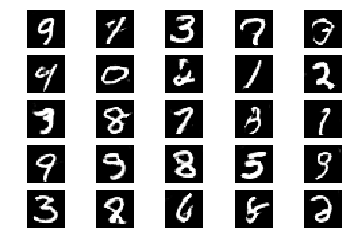

1901 [D loss: 0.557526, acc.: 73.44%] [G loss: 1.418429]
1902 [D loss: 0.501434, acc.: 76.56%] [G loss: 1.153695]
1903 [D loss: 0.527815, acc.: 76.56%] [G loss: 1.264500]
1904 [D loss: 0.627989, acc.: 64.45%] [G loss: 1.172054]
1905 [D loss: 0.551603, acc.: 74.22%] [G loss: 1.145334]
1906 [D loss: 0.785655, acc.: 48.44%] [G loss: 1.099785]
1907 [D loss: 0.611034, acc.: 66.02%] [G loss: 1.001321]
1908 [D loss: 0.635749, acc.: 65.62%] [G loss: 1.205136]
1909 [D loss: 0.726486, acc.: 57.81%] [G loss: 0.955918]
1910 [D loss: 0.668498, acc.: 57.81%] [G loss: 1.050522]
1911 [D loss: 0.583129, acc.: 67.58%] [G loss: 1.355757]
1912 [D loss: 0.610162, acc.: 68.75%] [G loss: 1.258488]
1913 [D loss: 0.605907, acc.: 71.48%] [G loss: 0.995021]
1914 [D loss: 0.524048, acc.: 75.78%] [G loss: 1.372182]
1915 [D loss: 0.600921, acc.: 65.23%] [G loss: 1.099710]
1916 [D loss: 0.605187, acc.: 66.41%] [G loss: 1.284849]
1917 [D loss: 0.652190, acc.: 62.89%] [G loss: 1.103680]
1918 [D loss: 0.552641, acc.: 7

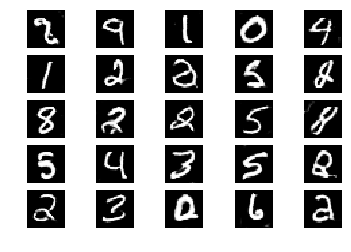

1951 [D loss: 0.605960, acc.: 70.70%] [G loss: 1.344930]
1952 [D loss: 0.780317, acc.: 51.95%] [G loss: 1.161226]
1953 [D loss: 0.582310, acc.: 69.92%] [G loss: 1.277665]
1954 [D loss: 0.685829, acc.: 57.81%] [G loss: 1.123181]
1955 [D loss: 0.664324, acc.: 60.94%] [G loss: 1.199132]
1956 [D loss: 0.569722, acc.: 69.92%] [G loss: 1.354523]
1957 [D loss: 0.615961, acc.: 67.97%] [G loss: 1.060607]
1958 [D loss: 0.593324, acc.: 67.97%] [G loss: 0.983227]
1959 [D loss: 0.699187, acc.: 60.55%] [G loss: 1.050119]
1960 [D loss: 0.527726, acc.: 73.83%] [G loss: 1.142416]
1961 [D loss: 0.713370, acc.: 58.59%] [G loss: 1.173868]
1962 [D loss: 0.614062, acc.: 64.84%] [G loss: 1.094312]
1963 [D loss: 0.596484, acc.: 68.75%] [G loss: 1.253742]
1964 [D loss: 0.595752, acc.: 68.75%] [G loss: 1.039916]
1965 [D loss: 0.711549, acc.: 50.00%] [G loss: 1.171651]
1966 [D loss: 0.538895, acc.: 75.00%] [G loss: 1.178006]
1967 [D loss: 0.689317, acc.: 57.42%] [G loss: 1.009555]
1968 [D loss: 0.641087, acc.: 6

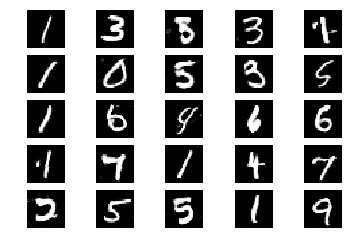

2001 [D loss: 0.562081, acc.: 71.88%] [G loss: 1.181136]
2002 [D loss: 0.689727, acc.: 61.33%] [G loss: 1.017950]
2003 [D loss: 0.686970, acc.: 55.08%] [G loss: 1.126943]
2004 [D loss: 0.749478, acc.: 51.56%] [G loss: 1.030882]
2005 [D loss: 0.681768, acc.: 59.38%] [G loss: 1.239240]
2006 [D loss: 0.605892, acc.: 66.02%] [G loss: 1.227048]
2007 [D loss: 0.616528, acc.: 67.19%] [G loss: 1.323737]
2008 [D loss: 0.532207, acc.: 75.39%] [G loss: 1.253999]
2009 [D loss: 0.603348, acc.: 68.75%] [G loss: 1.163233]
2010 [D loss: 0.479507, acc.: 79.30%] [G loss: 1.208454]
2011 [D loss: 0.621614, acc.: 68.75%] [G loss: 0.953474]
2012 [D loss: 0.650762, acc.: 59.38%] [G loss: 1.279656]
2013 [D loss: 0.566648, acc.: 70.31%] [G loss: 1.250508]
2014 [D loss: 0.489521, acc.: 78.52%] [G loss: 1.187281]
2015 [D loss: 0.571130, acc.: 72.27%] [G loss: 1.161289]
2016 [D loss: 0.589008, acc.: 68.75%] [G loss: 1.253897]
2017 [D loss: 0.493939, acc.: 79.30%] [G loss: 1.259639]
2018 [D loss: 0.619036, acc.: 6

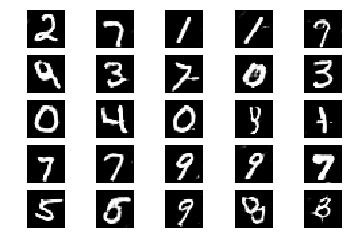

2051 [D loss: 0.746156, acc.: 53.52%] [G loss: 1.157516]
2052 [D loss: 0.649585, acc.: 63.28%] [G loss: 1.321278]
2053 [D loss: 0.471225, acc.: 80.47%] [G loss: 1.440025]
2054 [D loss: 0.644564, acc.: 62.50%] [G loss: 1.156403]
2055 [D loss: 0.584331, acc.: 69.92%] [G loss: 1.278518]
2056 [D loss: 0.655231, acc.: 60.94%] [G loss: 0.935260]
2057 [D loss: 0.663029, acc.: 60.55%] [G loss: 0.962310]
2058 [D loss: 0.570868, acc.: 72.27%] [G loss: 1.137295]
2059 [D loss: 0.573102, acc.: 69.92%] [G loss: 1.352215]
2060 [D loss: 0.691176, acc.: 58.59%] [G loss: 1.181830]
2061 [D loss: 0.505055, acc.: 78.52%] [G loss: 1.255053]
2062 [D loss: 0.544710, acc.: 73.83%] [G loss: 1.233480]
2063 [D loss: 0.539957, acc.: 74.22%] [G loss: 1.009425]
2064 [D loss: 0.617028, acc.: 62.89%] [G loss: 0.979645]
2065 [D loss: 0.594516, acc.: 64.06%] [G loss: 1.257757]
2066 [D loss: 0.619059, acc.: 64.06%] [G loss: 0.922017]
2067 [D loss: 0.752982, acc.: 53.12%] [G loss: 1.077175]
2068 [D loss: 0.519047, acc.: 8

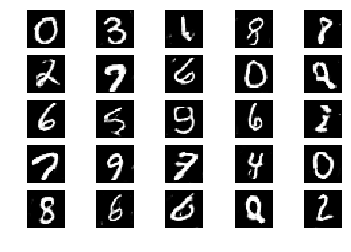

2101 [D loss: 0.691325, acc.: 58.20%] [G loss: 1.140120]
2102 [D loss: 0.688698, acc.: 57.03%] [G loss: 1.032106]
2103 [D loss: 0.754351, acc.: 50.00%] [G loss: 0.912741]
2104 [D loss: 0.608277, acc.: 66.02%] [G loss: 0.942590]
2105 [D loss: 0.626427, acc.: 67.19%] [G loss: 1.461503]
2106 [D loss: 0.820527, acc.: 42.19%] [G loss: 1.143886]
2107 [D loss: 0.569009, acc.: 72.66%] [G loss: 1.160177]
2108 [D loss: 0.666222, acc.: 58.59%] [G loss: 1.301981]
2109 [D loss: 0.641775, acc.: 63.28%] [G loss: 1.165457]
2110 [D loss: 0.597265, acc.: 72.27%] [G loss: 1.209390]
2111 [D loss: 0.622911, acc.: 64.84%] [G loss: 1.196400]
2112 [D loss: 0.537377, acc.: 74.22%] [G loss: 1.253940]
2113 [D loss: 0.731508, acc.: 50.39%] [G loss: 1.127043]
2114 [D loss: 0.584861, acc.: 69.92%] [G loss: 1.025415]
2115 [D loss: 0.664512, acc.: 60.55%] [G loss: 1.166852]
2116 [D loss: 0.664390, acc.: 64.84%] [G loss: 1.512788]
2117 [D loss: 0.744409, acc.: 52.73%] [G loss: 1.054949]
2118 [D loss: 0.571874, acc.: 7

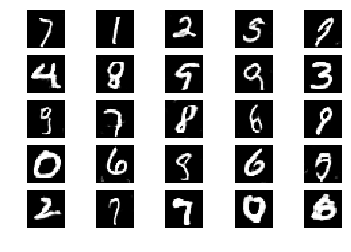

2151 [D loss: 0.724247, acc.: 53.52%] [G loss: 1.133011]
2152 [D loss: 0.709309, acc.: 51.95%] [G loss: 1.098486]
2153 [D loss: 0.633472, acc.: 63.28%] [G loss: 1.263025]
2154 [D loss: 0.595343, acc.: 66.41%] [G loss: 0.965076]
2155 [D loss: 0.560070, acc.: 70.31%] [G loss: 1.104192]
2156 [D loss: 0.701901, acc.: 57.42%] [G loss: 1.017491]
2157 [D loss: 0.591657, acc.: 66.41%] [G loss: 1.019062]
2158 [D loss: 0.617128, acc.: 67.19%] [G loss: 1.077761]
2159 [D loss: 0.541810, acc.: 71.48%] [G loss: 1.216411]
2160 [D loss: 0.481524, acc.: 78.12%] [G loss: 0.874677]
2161 [D loss: 0.555138, acc.: 72.27%] [G loss: 1.370795]
2162 [D loss: 0.566461, acc.: 69.92%] [G loss: 1.490952]
2163 [D loss: 0.612401, acc.: 68.36%] [G loss: 1.160370]
2164 [D loss: 0.740214, acc.: 49.61%] [G loss: 0.850330]
2165 [D loss: 0.677401, acc.: 57.42%] [G loss: 1.055152]
2166 [D loss: 0.520332, acc.: 77.34%] [G loss: 1.045397]
2167 [D loss: 0.556910, acc.: 73.83%] [G loss: 1.410362]
2168 [D loss: 0.573474, acc.: 7

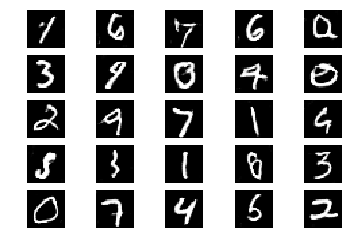

2201 [D loss: 0.606600, acc.: 67.58%] [G loss: 1.115316]
2202 [D loss: 0.702263, acc.: 57.42%] [G loss: 1.232776]
2203 [D loss: 0.570605, acc.: 70.70%] [G loss: 1.092634]
2204 [D loss: 0.538302, acc.: 72.66%] [G loss: 1.348415]
2205 [D loss: 0.665821, acc.: 57.03%] [G loss: 1.110112]
2206 [D loss: 0.603474, acc.: 68.75%] [G loss: 1.148441]
2207 [D loss: 0.686939, acc.: 59.38%] [G loss: 0.911590]
2208 [D loss: 0.528785, acc.: 73.44%] [G loss: 1.240878]
2209 [D loss: 0.719195, acc.: 53.12%] [G loss: 1.132315]
2210 [D loss: 0.574217, acc.: 70.31%] [G loss: 1.377048]
2211 [D loss: 0.555637, acc.: 71.48%] [G loss: 1.112664]
2212 [D loss: 0.585652, acc.: 71.09%] [G loss: 1.339722]
2213 [D loss: 0.576383, acc.: 67.97%] [G loss: 1.417369]
2214 [D loss: 0.579405, acc.: 67.58%] [G loss: 1.325805]
2215 [D loss: 0.783704, acc.: 47.66%] [G loss: 1.161817]
2216 [D loss: 0.722198, acc.: 53.91%] [G loss: 1.321096]
2217 [D loss: 0.581478, acc.: 68.36%] [G loss: 1.175190]
2218 [D loss: 0.515606, acc.: 7

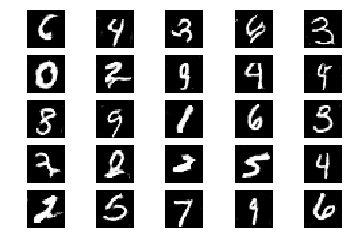

2251 [D loss: 0.544582, acc.: 74.61%] [G loss: 1.338547]
2252 [D loss: 0.507665, acc.: 77.73%] [G loss: 1.234066]
2253 [D loss: 0.505619, acc.: 76.56%] [G loss: 1.251541]
2254 [D loss: 0.519129, acc.: 77.73%] [G loss: 1.143402]
2255 [D loss: 0.558137, acc.: 71.09%] [G loss: 1.182873]
2256 [D loss: 0.544635, acc.: 71.88%] [G loss: 1.188336]
2257 [D loss: 0.615262, acc.: 67.19%] [G loss: 1.291496]
2258 [D loss: 0.715809, acc.: 55.08%] [G loss: 1.078972]
2259 [D loss: 0.738639, acc.: 53.91%] [G loss: 1.296786]
2260 [D loss: 0.525176, acc.: 74.22%] [G loss: 1.039407]
2261 [D loss: 0.611824, acc.: 67.58%] [G loss: 1.129423]
2262 [D loss: 0.535389, acc.: 75.39%] [G loss: 1.159722]
2263 [D loss: 0.695182, acc.: 54.30%] [G loss: 1.154096]
2264 [D loss: 0.746734, acc.: 53.12%] [G loss: 0.964411]
2265 [D loss: 0.665361, acc.: 62.11%] [G loss: 1.087127]
2266 [D loss: 0.553686, acc.: 74.61%] [G loss: 1.497752]
2267 [D loss: 0.710868, acc.: 52.73%] [G loss: 1.130305]
2268 [D loss: 0.706547, acc.: 5

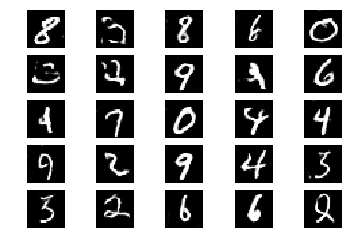

2301 [D loss: 0.603172, acc.: 65.62%] [G loss: 1.109277]
2302 [D loss: 0.632637, acc.: 62.50%] [G loss: 1.130264]
2303 [D loss: 0.558444, acc.: 72.66%] [G loss: 1.229085]
2304 [D loss: 0.537924, acc.: 76.17%] [G loss: 1.029862]
2305 [D loss: 0.535993, acc.: 74.22%] [G loss: 1.146535]
2306 [D loss: 0.581898, acc.: 69.14%] [G loss: 1.219191]
2307 [D loss: 0.574750, acc.: 71.09%] [G loss: 1.212899]
2308 [D loss: 0.555211, acc.: 72.27%] [G loss: 1.230415]
2309 [D loss: 0.678071, acc.: 60.94%] [G loss: 1.269109]
2310 [D loss: 0.563159, acc.: 66.80%] [G loss: 1.418147]
2311 [D loss: 0.655581, acc.: 61.72%] [G loss: 1.184406]
2312 [D loss: 0.628849, acc.: 64.45%] [G loss: 1.093830]
2313 [D loss: 0.552168, acc.: 71.09%] [G loss: 1.125468]
2314 [D loss: 0.664384, acc.: 62.50%] [G loss: 1.253683]
2315 [D loss: 0.607101, acc.: 68.36%] [G loss: 0.970004]
2316 [D loss: 0.710726, acc.: 54.69%] [G loss: 1.299857]
2317 [D loss: 0.555626, acc.: 70.70%] [G loss: 1.339578]
2318 [D loss: 0.737229, acc.: 5

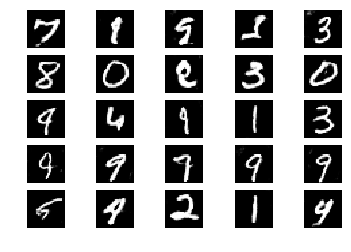

2351 [D loss: 0.673532, acc.: 57.03%] [G loss: 1.195326]
2352 [D loss: 0.614452, acc.: 68.75%] [G loss: 1.124715]
2353 [D loss: 0.519093, acc.: 73.83%] [G loss: 1.414695]
2354 [D loss: 0.621571, acc.: 64.45%] [G loss: 1.069204]
2355 [D loss: 0.590887, acc.: 67.58%] [G loss: 1.077421]
2356 [D loss: 0.734649, acc.: 51.95%] [G loss: 1.076063]
2357 [D loss: 0.635907, acc.: 67.19%] [G loss: 1.145946]
2358 [D loss: 0.554773, acc.: 73.83%] [G loss: 1.194009]
2359 [D loss: 0.671231, acc.: 58.98%] [G loss: 1.047485]
2360 [D loss: 0.618062, acc.: 67.97%] [G loss: 1.219145]
2361 [D loss: 0.684101, acc.: 57.42%] [G loss: 1.170880]
2362 [D loss: 0.609279, acc.: 68.75%] [G loss: 1.167929]
2363 [D loss: 0.551025, acc.: 75.39%] [G loss: 1.212099]
2364 [D loss: 0.657284, acc.: 62.50%] [G loss: 0.992253]
2365 [D loss: 0.542004, acc.: 73.44%] [G loss: 1.269866]
2366 [D loss: 0.510908, acc.: 74.61%] [G loss: 1.104272]
2367 [D loss: 0.725928, acc.: 55.47%] [G loss: 1.006196]
2368 [D loss: 0.630613, acc.: 6

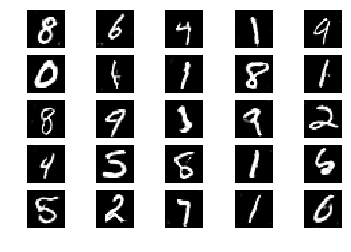

2401 [D loss: 0.681952, acc.: 59.38%] [G loss: 1.213498]
2402 [D loss: 0.628764, acc.: 64.45%] [G loss: 1.172872]
2403 [D loss: 0.537703, acc.: 76.17%] [G loss: 1.155760]
2404 [D loss: 0.599484, acc.: 64.84%] [G loss: 1.120285]
2405 [D loss: 0.631625, acc.: 63.28%] [G loss: 1.049224]
2406 [D loss: 0.593731, acc.: 67.97%] [G loss: 0.920949]
2407 [D loss: 0.612534, acc.: 65.23%] [G loss: 0.998261]
2408 [D loss: 0.504800, acc.: 76.17%] [G loss: 1.417339]
2409 [D loss: 0.732013, acc.: 48.83%] [G loss: 1.067614]
2410 [D loss: 0.667902, acc.: 61.33%] [G loss: 1.193396]
2411 [D loss: 0.618726, acc.: 66.02%] [G loss: 1.116002]
2412 [D loss: 0.535395, acc.: 77.34%] [G loss: 1.061433]
2413 [D loss: 0.629071, acc.: 64.06%] [G loss: 1.021863]
2414 [D loss: 0.619156, acc.: 67.19%] [G loss: 1.302000]
2415 [D loss: 0.577874, acc.: 72.27%] [G loss: 1.104107]
2416 [D loss: 0.661918, acc.: 60.94%] [G loss: 1.034934]
2417 [D loss: 0.618040, acc.: 64.45%] [G loss: 1.148433]
2418 [D loss: 0.535376, acc.: 7

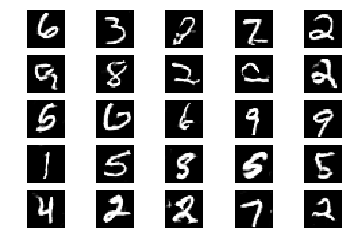

2451 [D loss: 0.613847, acc.: 64.45%] [G loss: 1.392587]
2452 [D loss: 0.662931, acc.: 62.50%] [G loss: 1.195019]
2453 [D loss: 0.552204, acc.: 72.66%] [G loss: 1.147596]
2454 [D loss: 0.632263, acc.: 65.23%] [G loss: 1.129916]
2455 [D loss: 0.616262, acc.: 67.19%] [G loss: 1.186868]
2456 [D loss: 0.676579, acc.: 62.50%] [G loss: 1.064009]
2457 [D loss: 0.651649, acc.: 61.33%] [G loss: 1.097094]
2458 [D loss: 0.671043, acc.: 60.55%] [G loss: 1.350264]
2459 [D loss: 0.576011, acc.: 69.14%] [G loss: 1.061837]
2460 [D loss: 0.522740, acc.: 76.17%] [G loss: 1.100854]
2461 [D loss: 0.735855, acc.: 50.78%] [G loss: 1.016098]
2462 [D loss: 0.698190, acc.: 57.81%] [G loss: 1.148518]
2463 [D loss: 0.637758, acc.: 63.28%] [G loss: 1.065769]
2464 [D loss: 0.583365, acc.: 68.75%] [G loss: 1.088964]
2465 [D loss: 0.569015, acc.: 67.97%] [G loss: 1.288087]
2466 [D loss: 0.652565, acc.: 61.72%] [G loss: 1.046536]
2467 [D loss: 0.513888, acc.: 80.08%] [G loss: 1.233218]
2468 [D loss: 0.564391, acc.: 7

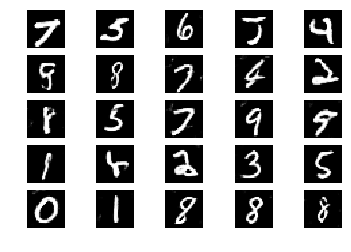

2501 [D loss: 0.663941, acc.: 59.77%] [G loss: 1.142971]
2502 [D loss: 0.649340, acc.: 61.33%] [G loss: 1.133148]
2503 [D loss: 0.702310, acc.: 53.12%] [G loss: 1.113121]
2504 [D loss: 0.718629, acc.: 54.69%] [G loss: 1.012112]
2505 [D loss: 0.641996, acc.: 62.50%] [G loss: 0.837916]
2506 [D loss: 0.545044, acc.: 73.83%] [G loss: 1.196356]
2507 [D loss: 0.557060, acc.: 75.39%] [G loss: 1.131027]
2508 [D loss: 0.496648, acc.: 78.12%] [G loss: 1.273490]
2509 [D loss: 0.661320, acc.: 59.38%] [G loss: 0.878950]
2510 [D loss: 0.531722, acc.: 74.61%] [G loss: 1.072474]
2511 [D loss: 0.563324, acc.: 73.44%] [G loss: 1.086879]
2512 [D loss: 0.674783, acc.: 58.59%] [G loss: 1.174293]
2513 [D loss: 0.548354, acc.: 72.27%] [G loss: 1.126144]
2514 [D loss: 0.492480, acc.: 80.47%] [G loss: 1.278913]
2515 [D loss: 0.633477, acc.: 68.36%] [G loss: 1.032706]
2516 [D loss: 0.574028, acc.: 72.27%] [G loss: 1.264475]
2517 [D loss: 0.678412, acc.: 60.94%] [G loss: 1.108232]
2518 [D loss: 0.601882, acc.: 6

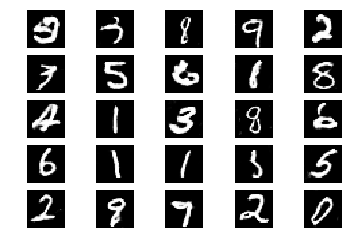

2551 [D loss: 0.598519, acc.: 67.97%] [G loss: 1.221045]
2552 [D loss: 0.614469, acc.: 66.02%] [G loss: 1.159121]
2553 [D loss: 0.662558, acc.: 59.77%] [G loss: 1.027963]
2554 [D loss: 0.558105, acc.: 70.31%] [G loss: 1.128320]
2555 [D loss: 0.598860, acc.: 66.02%] [G loss: 1.066221]
2556 [D loss: 0.688932, acc.: 58.20%] [G loss: 1.165635]
2557 [D loss: 0.607288, acc.: 65.62%] [G loss: 1.252741]
2558 [D loss: 0.650542, acc.: 62.11%] [G loss: 1.080826]
2559 [D loss: 0.566826, acc.: 67.97%] [G loss: 1.207234]
2560 [D loss: 0.599790, acc.: 69.53%] [G loss: 1.045802]
2561 [D loss: 0.561872, acc.: 73.05%] [G loss: 1.326873]
2562 [D loss: 0.523602, acc.: 76.95%] [G loss: 1.263751]
2563 [D loss: 0.690374, acc.: 58.59%] [G loss: 1.127035]
2564 [D loss: 0.608244, acc.: 66.02%] [G loss: 1.293729]
2565 [D loss: 0.667625, acc.: 60.55%] [G loss: 1.050091]
2566 [D loss: 0.677005, acc.: 59.77%] [G loss: 1.089726]
2567 [D loss: 0.752900, acc.: 54.30%] [G loss: 1.258512]
2568 [D loss: 0.542666, acc.: 7

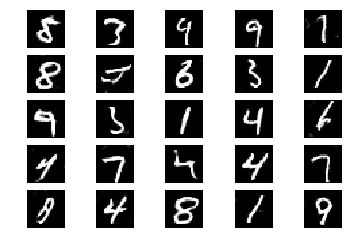

2601 [D loss: 0.587161, acc.: 70.70%] [G loss: 1.021290]
2602 [D loss: 0.698201, acc.: 57.81%] [G loss: 1.034491]
2603 [D loss: 0.590380, acc.: 67.19%] [G loss: 1.311952]
2604 [D loss: 0.597599, acc.: 67.19%] [G loss: 1.360648]
2605 [D loss: 0.594982, acc.: 67.58%] [G loss: 1.211987]
2606 [D loss: 0.535229, acc.: 73.44%] [G loss: 1.372903]
2607 [D loss: 0.582232, acc.: 66.02%] [G loss: 1.075909]
2608 [D loss: 0.492698, acc.: 81.25%] [G loss: 0.914420]
2609 [D loss: 0.631747, acc.: 63.67%] [G loss: 1.046687]
2610 [D loss: 0.572305, acc.: 74.61%] [G loss: 0.957564]
2611 [D loss: 0.568475, acc.: 71.09%] [G loss: 1.155607]
2612 [D loss: 0.597781, acc.: 69.14%] [G loss: 1.263849]
2613 [D loss: 0.640292, acc.: 62.11%] [G loss: 0.844138]
2614 [D loss: 0.598237, acc.: 66.80%] [G loss: 1.013119]
2615 [D loss: 0.600292, acc.: 68.36%] [G loss: 0.965775]
2616 [D loss: 0.696140, acc.: 55.86%] [G loss: 0.809719]
2617 [D loss: 0.575958, acc.: 66.02%] [G loss: 1.101830]
2618 [D loss: 0.631763, acc.: 6

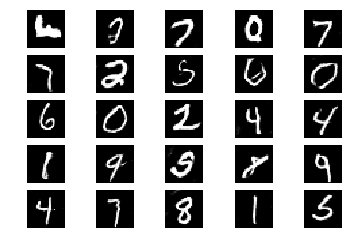

2651 [D loss: 0.717209, acc.: 55.86%] [G loss: 1.334748]
2652 [D loss: 0.582182, acc.: 67.97%] [G loss: 1.101315]
2653 [D loss: 0.641454, acc.: 61.33%] [G loss: 1.273795]
2654 [D loss: 0.635899, acc.: 64.45%] [G loss: 1.275525]
2655 [D loss: 0.656460, acc.: 65.62%] [G loss: 1.274257]
2656 [D loss: 0.609209, acc.: 66.80%] [G loss: 1.434519]
2657 [D loss: 0.476824, acc.: 81.25%] [G loss: 1.275414]
2658 [D loss: 0.648890, acc.: 62.50%] [G loss: 1.181570]
2659 [D loss: 0.564246, acc.: 74.61%] [G loss: 0.935492]
2660 [D loss: 0.457439, acc.: 82.81%] [G loss: 1.358830]
2661 [D loss: 0.754288, acc.: 50.00%] [G loss: 0.865706]
2662 [D loss: 0.669751, acc.: 58.98%] [G loss: 0.926877]
2663 [D loss: 0.526009, acc.: 73.05%] [G loss: 0.964609]
2664 [D loss: 0.621336, acc.: 67.19%] [G loss: 1.229161]
2665 [D loss: 0.614700, acc.: 66.80%] [G loss: 1.302776]
2666 [D loss: 0.574359, acc.: 68.36%] [G loss: 1.403511]
2667 [D loss: 0.529012, acc.: 78.12%] [G loss: 0.940597]
2668 [D loss: 0.514725, acc.: 7

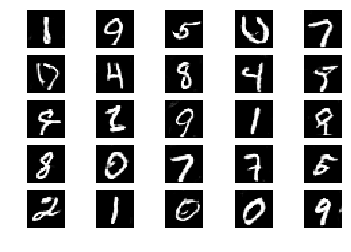

2701 [D loss: 0.577125, acc.: 70.70%] [G loss: 0.979296]
2702 [D loss: 0.644633, acc.: 63.28%] [G loss: 1.055099]
2703 [D loss: 0.612484, acc.: 66.02%] [G loss: 1.179129]
2704 [D loss: 0.587816, acc.: 68.36%] [G loss: 1.136829]
2705 [D loss: 0.626144, acc.: 62.50%] [G loss: 1.139817]
2706 [D loss: 0.730137, acc.: 53.12%] [G loss: 1.091146]
2707 [D loss: 0.596308, acc.: 69.92%] [G loss: 1.487361]
2708 [D loss: 0.674528, acc.: 60.16%] [G loss: 1.215907]
2709 [D loss: 0.568921, acc.: 69.92%] [G loss: 1.229980]
2710 [D loss: 0.607540, acc.: 67.97%] [G loss: 1.220157]
2711 [D loss: 0.563187, acc.: 74.61%] [G loss: 1.028036]
2712 [D loss: 0.640374, acc.: 64.84%] [G loss: 1.180999]
2713 [D loss: 0.608241, acc.: 65.62%] [G loss: 1.127688]
2714 [D loss: 0.548229, acc.: 74.22%] [G loss: 1.387098]
2715 [D loss: 0.580646, acc.: 67.19%] [G loss: 1.242967]
2716 [D loss: 0.681513, acc.: 57.03%] [G loss: 1.018659]
2717 [D loss: 0.501874, acc.: 77.34%] [G loss: 1.368373]
2718 [D loss: 0.609105, acc.: 6

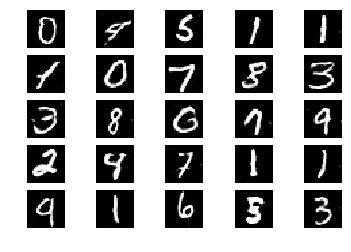

2751 [D loss: 0.624107, acc.: 66.41%] [G loss: 0.903009]
2752 [D loss: 0.691686, acc.: 56.25%] [G loss: 1.074788]
2753 [D loss: 0.513174, acc.: 76.17%] [G loss: 1.425029]
2754 [D loss: 0.568156, acc.: 70.31%] [G loss: 1.039497]
2755 [D loss: 0.606794, acc.: 65.62%] [G loss: 1.483468]
2756 [D loss: 0.498939, acc.: 79.30%] [G loss: 1.185651]
2757 [D loss: 0.551589, acc.: 71.88%] [G loss: 1.163287]
2758 [D loss: 0.649714, acc.: 60.94%] [G loss: 1.095468]
2759 [D loss: 0.573119, acc.: 71.48%] [G loss: 1.022522]
2760 [D loss: 0.645592, acc.: 63.28%] [G loss: 1.038477]
2761 [D loss: 0.596187, acc.: 65.23%] [G loss: 1.002548]
2762 [D loss: 0.714327, acc.: 55.86%] [G loss: 1.108448]
2763 [D loss: 0.672055, acc.: 58.98%] [G loss: 1.250261]
2764 [D loss: 0.638497, acc.: 65.23%] [G loss: 0.949296]
2765 [D loss: 0.662015, acc.: 61.33%] [G loss: 1.266543]
2766 [D loss: 0.629747, acc.: 67.97%] [G loss: 0.968849]
2767 [D loss: 0.505552, acc.: 78.52%] [G loss: 1.324236]
2768 [D loss: 0.593771, acc.: 6

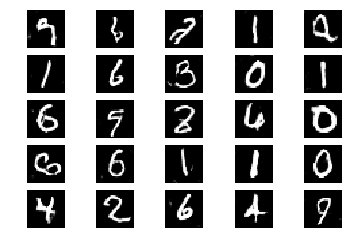

2801 [D loss: 0.576140, acc.: 69.92%] [G loss: 0.927203]
2802 [D loss: 0.700486, acc.: 57.03%] [G loss: 1.246306]
2803 [D loss: 0.662533, acc.: 61.72%] [G loss: 1.095141]
2804 [D loss: 0.582407, acc.: 69.53%] [G loss: 1.215759]
2805 [D loss: 0.524913, acc.: 75.39%] [G loss: 1.431926]
2806 [D loss: 0.549552, acc.: 76.17%] [G loss: 0.888317]
2807 [D loss: 0.774973, acc.: 52.34%] [G loss: 0.980193]
2808 [D loss: 0.690285, acc.: 55.08%] [G loss: 1.049402]
2809 [D loss: 0.604827, acc.: 66.80%] [G loss: 1.350303]
2810 [D loss: 0.612168, acc.: 66.41%] [G loss: 1.074248]
2811 [D loss: 0.511873, acc.: 78.12%] [G loss: 1.227571]
2812 [D loss: 0.647180, acc.: 62.89%] [G loss: 1.084017]
2813 [D loss: 0.549871, acc.: 75.39%] [G loss: 1.087238]
2814 [D loss: 0.539617, acc.: 70.70%] [G loss: 1.352519]
2815 [D loss: 0.522585, acc.: 78.91%] [G loss: 1.034102]
2816 [D loss: 0.599221, acc.: 67.97%] [G loss: 1.005229]
2817 [D loss: 0.656978, acc.: 58.59%] [G loss: 1.039334]
2818 [D loss: 0.477133, acc.: 7

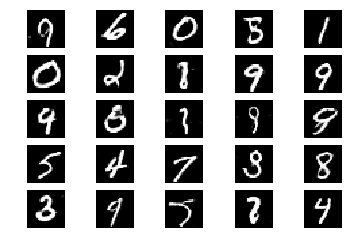

2851 [D loss: 0.670669, acc.: 58.59%] [G loss: 1.149490]
2852 [D loss: 0.587093, acc.: 70.31%] [G loss: 1.238515]
2853 [D loss: 0.622705, acc.: 65.23%] [G loss: 1.458224]
2854 [D loss: 0.798731, acc.: 43.36%] [G loss: 0.967587]
2855 [D loss: 0.556178, acc.: 71.48%] [G loss: 1.358172]
2856 [D loss: 0.565162, acc.: 71.09%] [G loss: 1.104948]
2857 [D loss: 0.702682, acc.: 59.38%] [G loss: 0.948295]
2858 [D loss: 0.735551, acc.: 52.73%] [G loss: 1.011105]
2859 [D loss: 0.624130, acc.: 65.23%] [G loss: 1.273221]
2860 [D loss: 0.555455, acc.: 74.22%] [G loss: 1.380929]
2861 [D loss: 0.684180, acc.: 55.47%] [G loss: 1.261271]
2862 [D loss: 0.543791, acc.: 73.05%] [G loss: 1.126287]
2863 [D loss: 0.685157, acc.: 55.86%] [G loss: 1.245258]
2864 [D loss: 0.645773, acc.: 61.72%] [G loss: 1.334542]
2865 [D loss: 0.490003, acc.: 80.08%] [G loss: 1.179573]
2866 [D loss: 0.438600, acc.: 87.11%] [G loss: 1.245028]
2867 [D loss: 0.603440, acc.: 67.19%] [G loss: 1.064113]
2868 [D loss: 0.497733, acc.: 7

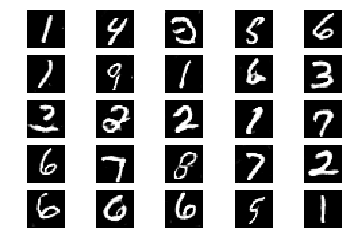

2901 [D loss: 0.612420, acc.: 70.31%] [G loss: 1.211009]
2902 [D loss: 0.693880, acc.: 59.38%] [G loss: 1.101832]
2903 [D loss: 0.649338, acc.: 65.62%] [G loss: 0.903822]
2904 [D loss: 0.599960, acc.: 63.67%] [G loss: 1.141191]
2905 [D loss: 0.634230, acc.: 65.62%] [G loss: 1.121985]
2906 [D loss: 0.574483, acc.: 71.09%] [G loss: 1.057111]
2907 [D loss: 0.681763, acc.: 57.03%] [G loss: 0.980916]
2908 [D loss: 0.725224, acc.: 57.03%] [G loss: 1.259328]
2909 [D loss: 0.564031, acc.: 74.22%] [G loss: 1.035751]
2910 [D loss: 0.627300, acc.: 65.62%] [G loss: 1.026340]
2911 [D loss: 0.686886, acc.: 58.59%] [G loss: 1.026943]
2912 [D loss: 0.503774, acc.: 79.69%] [G loss: 1.245174]
2913 [D loss: 0.564098, acc.: 72.27%] [G loss: 1.262148]
2914 [D loss: 0.660286, acc.: 61.33%] [G loss: 1.077955]
2915 [D loss: 0.622642, acc.: 62.11%] [G loss: 1.111994]
2916 [D loss: 0.723302, acc.: 53.91%] [G loss: 1.243954]
2917 [D loss: 0.606381, acc.: 67.97%] [G loss: 1.142528]
2918 [D loss: 0.649792, acc.: 6

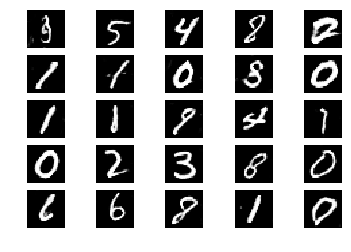

2951 [D loss: 0.726926, acc.: 55.86%] [G loss: 1.180318]
2952 [D loss: 0.590850, acc.: 69.14%] [G loss: 1.162554]
2953 [D loss: 0.552160, acc.: 72.27%] [G loss: 1.223514]
2954 [D loss: 0.813524, acc.: 42.97%] [G loss: 0.976131]
2955 [D loss: 0.651896, acc.: 63.28%] [G loss: 1.117750]
2956 [D loss: 0.799644, acc.: 49.61%] [G loss: 1.151558]
2957 [D loss: 0.593420, acc.: 69.53%] [G loss: 1.480752]
2958 [D loss: 0.618716, acc.: 63.28%] [G loss: 1.159282]
2959 [D loss: 0.661724, acc.: 61.72%] [G loss: 1.080965]
2960 [D loss: 0.688622, acc.: 57.81%] [G loss: 1.179861]
2961 [D loss: 0.672099, acc.: 57.81%] [G loss: 1.319086]
2962 [D loss: 0.634555, acc.: 62.89%] [G loss: 1.152214]
2963 [D loss: 0.686672, acc.: 59.38%] [G loss: 1.171833]
2964 [D loss: 0.600934, acc.: 64.45%] [G loss: 1.240846]
2965 [D loss: 0.485216, acc.: 78.12%] [G loss: 1.223835]
2966 [D loss: 0.620131, acc.: 64.45%] [G loss: 1.145235]
2967 [D loss: 0.648257, acc.: 61.33%] [G loss: 0.945908]
2968 [D loss: 0.570784, acc.: 7

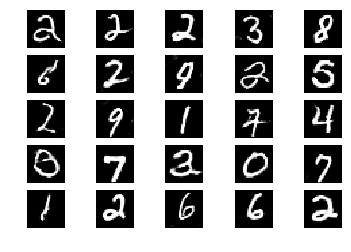

3001 [D loss: 0.575351, acc.: 71.09%] [G loss: 1.083709]
3002 [D loss: 0.581755, acc.: 68.75%] [G loss: 1.094576]
3003 [D loss: 0.512250, acc.: 76.17%] [G loss: 1.135038]
3004 [D loss: 0.442012, acc.: 84.38%] [G loss: 1.427920]
3005 [D loss: 0.660001, acc.: 65.62%] [G loss: 0.980446]
3006 [D loss: 0.673650, acc.: 61.33%] [G loss: 1.030567]
3007 [D loss: 0.682348, acc.: 61.33%] [G loss: 0.958993]
3008 [D loss: 0.598122, acc.: 65.23%] [G loss: 1.146416]
3009 [D loss: 0.615585, acc.: 64.84%] [G loss: 1.439853]
3010 [D loss: 0.519667, acc.: 75.39%] [G loss: 1.456970]
3011 [D loss: 0.521992, acc.: 75.78%] [G loss: 1.163323]
3012 [D loss: 0.614806, acc.: 64.84%] [G loss: 1.235803]
3013 [D loss: 0.574930, acc.: 71.48%] [G loss: 1.229213]
3014 [D loss: 0.623554, acc.: 62.89%] [G loss: 0.830473]
3015 [D loss: 0.554414, acc.: 71.88%] [G loss: 1.468302]
3016 [D loss: 0.551847, acc.: 73.05%] [G loss: 1.166134]
3017 [D loss: 0.648165, acc.: 62.89%] [G loss: 1.111320]
3018 [D loss: 0.692511, acc.: 5

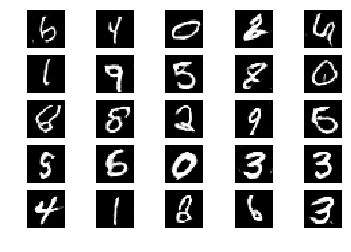

3051 [D loss: 0.600076, acc.: 67.58%] [G loss: 1.260212]
3052 [D loss: 0.655052, acc.: 61.72%] [G loss: 0.953134]
3053 [D loss: 0.553069, acc.: 72.66%] [G loss: 1.110137]
3054 [D loss: 0.879698, acc.: 38.28%] [G loss: 1.016470]
3055 [D loss: 0.550464, acc.: 72.27%] [G loss: 1.152157]
3056 [D loss: 0.593162, acc.: 71.88%] [G loss: 1.261234]
3057 [D loss: 0.585503, acc.: 68.75%] [G loss: 1.260443]
3058 [D loss: 0.581465, acc.: 68.36%] [G loss: 1.320179]
3059 [D loss: 0.710769, acc.: 57.03%] [G loss: 1.142047]
3060 [D loss: 0.727048, acc.: 53.91%] [G loss: 1.093710]
3061 [D loss: 0.544925, acc.: 72.66%] [G loss: 1.199841]
3062 [D loss: 0.639447, acc.: 63.28%] [G loss: 1.140320]
3063 [D loss: 0.699683, acc.: 56.25%] [G loss: 1.088575]
3064 [D loss: 0.594458, acc.: 66.02%] [G loss: 1.167133]
3065 [D loss: 0.597312, acc.: 67.19%] [G loss: 1.274228]
3066 [D loss: 0.601822, acc.: 67.58%] [G loss: 1.214858]
3067 [D loss: 0.620987, acc.: 64.06%] [G loss: 1.294212]
3068 [D loss: 0.518229, acc.: 7

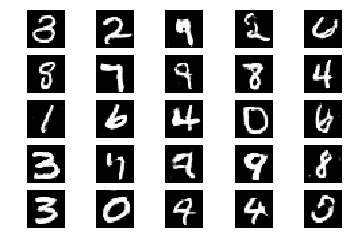

3101 [D loss: 0.707430, acc.: 55.08%] [G loss: 1.084130]
3102 [D loss: 0.555593, acc.: 69.92%] [G loss: 1.251447]
3103 [D loss: 0.760254, acc.: 49.22%] [G loss: 1.027199]
3104 [D loss: 0.657167, acc.: 61.33%] [G loss: 1.029584]
3105 [D loss: 0.774906, acc.: 51.17%] [G loss: 1.130766]
3106 [D loss: 0.642439, acc.: 62.11%] [G loss: 0.970520]
3107 [D loss: 0.671238, acc.: 55.86%] [G loss: 0.947916]
3108 [D loss: 0.612901, acc.: 65.62%] [G loss: 1.329799]
3109 [D loss: 0.775602, acc.: 48.83%] [G loss: 1.282335]
3110 [D loss: 0.699876, acc.: 55.86%] [G loss: 1.009452]
3111 [D loss: 0.584884, acc.: 68.36%] [G loss: 1.197682]
3112 [D loss: 0.579383, acc.: 72.27%] [G loss: 1.003154]
3113 [D loss: 0.603699, acc.: 69.92%] [G loss: 1.072456]
3114 [D loss: 0.674870, acc.: 61.33%] [G loss: 1.038096]
3115 [D loss: 0.604120, acc.: 69.92%] [G loss: 1.169168]
3116 [D loss: 0.552116, acc.: 70.31%] [G loss: 1.102999]
3117 [D loss: 0.542302, acc.: 73.44%] [G loss: 1.272034]
3118 [D loss: 0.703690, acc.: 5

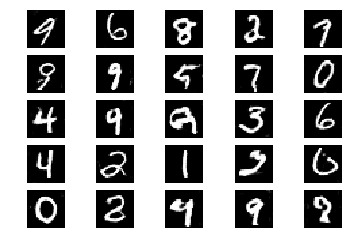

3151 [D loss: 0.584952, acc.: 69.92%] [G loss: 1.163981]
3152 [D loss: 0.589004, acc.: 71.88%] [G loss: 1.095383]
3153 [D loss: 0.752427, acc.: 53.12%] [G loss: 1.175627]
3154 [D loss: 0.631995, acc.: 66.41%] [G loss: 1.258132]
3155 [D loss: 0.723751, acc.: 53.91%] [G loss: 1.066208]
3156 [D loss: 0.589610, acc.: 69.92%] [G loss: 1.048249]
3157 [D loss: 0.542209, acc.: 77.34%] [G loss: 1.340375]
3158 [D loss: 0.604622, acc.: 67.19%] [G loss: 1.395585]
3159 [D loss: 0.614204, acc.: 66.80%] [G loss: 1.252245]
3160 [D loss: 0.672525, acc.: 59.38%] [G loss: 1.218645]
3161 [D loss: 0.727867, acc.: 52.34%] [G loss: 1.195149]
3162 [D loss: 0.564061, acc.: 71.48%] [G loss: 1.381431]
3163 [D loss: 0.646990, acc.: 61.72%] [G loss: 1.293272]
3164 [D loss: 0.689241, acc.: 55.86%] [G loss: 1.061329]
3165 [D loss: 0.608312, acc.: 66.80%] [G loss: 1.027922]
3166 [D loss: 0.579148, acc.: 71.88%] [G loss: 0.908918]
3167 [D loss: 0.582375, acc.: 70.70%] [G loss: 1.201620]
3168 [D loss: 0.641769, acc.: 6

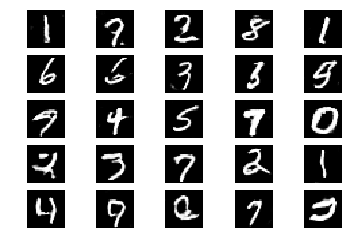

3201 [D loss: 0.548167, acc.: 73.83%] [G loss: 1.340071]
3202 [D loss: 0.651949, acc.: 61.72%] [G loss: 0.969622]
3203 [D loss: 0.670531, acc.: 61.72%] [G loss: 0.951584]
3204 [D loss: 0.567125, acc.: 72.66%] [G loss: 1.039842]
3205 [D loss: 0.631179, acc.: 64.06%] [G loss: 0.965154]
3206 [D loss: 0.575774, acc.: 71.48%] [G loss: 1.164113]
3207 [D loss: 0.496103, acc.: 78.91%] [G loss: 1.402089]
3208 [D loss: 0.599999, acc.: 64.84%] [G loss: 0.986467]
3209 [D loss: 0.607681, acc.: 68.36%] [G loss: 1.132715]
3210 [D loss: 0.653119, acc.: 63.28%] [G loss: 1.049330]
3211 [D loss: 0.503984, acc.: 79.30%] [G loss: 1.320616]
3212 [D loss: 0.575063, acc.: 68.75%] [G loss: 1.191568]
3213 [D loss: 0.673777, acc.: 60.55%] [G loss: 1.291220]
3214 [D loss: 0.619000, acc.: 64.84%] [G loss: 1.272837]
3215 [D loss: 0.560286, acc.: 71.09%] [G loss: 1.293831]
3216 [D loss: 0.572368, acc.: 68.75%] [G loss: 1.281022]
3217 [D loss: 0.712878, acc.: 56.64%] [G loss: 1.191222]
3218 [D loss: 0.698307, acc.: 5

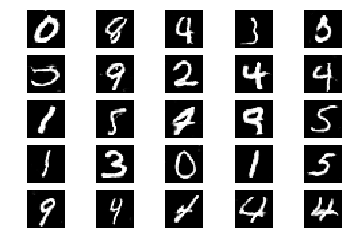

3251 [D loss: 0.670514, acc.: 60.94%] [G loss: 1.060057]
3252 [D loss: 0.676205, acc.: 61.72%] [G loss: 1.227388]
3253 [D loss: 0.611249, acc.: 65.62%] [G loss: 1.108304]
3254 [D loss: 0.601683, acc.: 64.06%] [G loss: 1.169751]
3255 [D loss: 0.697885, acc.: 60.55%] [G loss: 1.077422]
3256 [D loss: 0.567100, acc.: 72.66%] [G loss: 1.349330]
3257 [D loss: 0.622124, acc.: 64.06%] [G loss: 1.252927]
3258 [D loss: 0.716229, acc.: 53.91%] [G loss: 1.038343]
3259 [D loss: 0.543101, acc.: 74.22%] [G loss: 1.288164]
3260 [D loss: 0.447819, acc.: 83.59%] [G loss: 1.304967]
3261 [D loss: 0.544756, acc.: 72.27%] [G loss: 1.051550]
3262 [D loss: 0.682365, acc.: 55.86%] [G loss: 1.004831]
3263 [D loss: 0.623660, acc.: 66.80%] [G loss: 1.082977]
3264 [D loss: 0.595890, acc.: 68.36%] [G loss: 1.304018]
3265 [D loss: 0.613807, acc.: 67.19%] [G loss: 0.991978]
3266 [D loss: 0.731417, acc.: 50.00%] [G loss: 1.031091]
3267 [D loss: 0.591341, acc.: 69.53%] [G loss: 1.225768]
3268 [D loss: 0.569377, acc.: 7

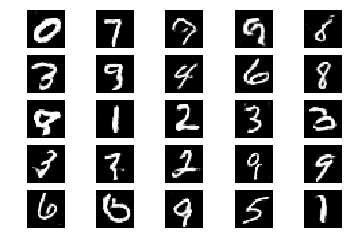

3301 [D loss: 0.663784, acc.: 55.47%] [G loss: 0.933961]
3302 [D loss: 0.596155, acc.: 69.53%] [G loss: 1.303425]
3303 [D loss: 0.650426, acc.: 64.06%] [G loss: 1.184319]
3304 [D loss: 0.727179, acc.: 53.91%] [G loss: 1.083072]
3305 [D loss: 0.465047, acc.: 79.69%] [G loss: 1.101415]
3306 [D loss: 0.542485, acc.: 75.39%] [G loss: 1.193198]
3307 [D loss: 0.616746, acc.: 62.11%] [G loss: 1.242864]
3308 [D loss: 0.569197, acc.: 72.27%] [G loss: 1.390658]
3309 [D loss: 0.640624, acc.: 61.33%] [G loss: 1.021460]
3310 [D loss: 0.580417, acc.: 67.58%] [G loss: 1.083013]
3311 [D loss: 0.654515, acc.: 58.98%] [G loss: 1.315075]
3312 [D loss: 0.479841, acc.: 80.47%] [G loss: 1.028334]
3313 [D loss: 0.663280, acc.: 61.33%] [G loss: 1.017536]
3314 [D loss: 0.541964, acc.: 74.22%] [G loss: 1.350048]
3315 [D loss: 0.606205, acc.: 64.45%] [G loss: 1.185104]
3316 [D loss: 0.594159, acc.: 68.75%] [G loss: 0.934273]
3317 [D loss: 0.695329, acc.: 58.20%] [G loss: 0.996891]
3318 [D loss: 0.524553, acc.: 7

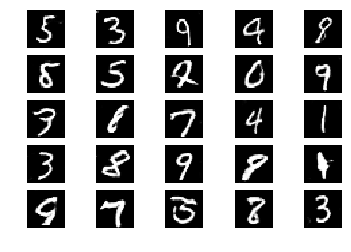

3351 [D loss: 0.660701, acc.: 61.33%] [G loss: 1.120966]
3352 [D loss: 0.664507, acc.: 61.33%] [G loss: 1.221453]
3353 [D loss: 0.602156, acc.: 68.75%] [G loss: 1.049934]
3354 [D loss: 0.563213, acc.: 67.97%] [G loss: 1.085096]
3355 [D loss: 0.556768, acc.: 73.83%] [G loss: 1.025802]
3356 [D loss: 0.654368, acc.: 64.06%] [G loss: 0.976865]
3357 [D loss: 0.679263, acc.: 61.72%] [G loss: 1.006532]
3358 [D loss: 0.525755, acc.: 75.00%] [G loss: 1.267224]
3359 [D loss: 0.582172, acc.: 71.48%] [G loss: 1.321666]
3360 [D loss: 0.666598, acc.: 61.72%] [G loss: 1.052225]
3361 [D loss: 0.603437, acc.: 67.19%] [G loss: 1.017815]
3362 [D loss: 0.619840, acc.: 64.45%] [G loss: 1.194607]
3363 [D loss: 0.791840, acc.: 47.66%] [G loss: 1.013746]
3364 [D loss: 0.595620, acc.: 67.19%] [G loss: 1.319095]
3365 [D loss: 0.684291, acc.: 55.08%] [G loss: 1.099128]
3366 [D loss: 0.603685, acc.: 67.19%] [G loss: 1.136463]
3367 [D loss: 0.533279, acc.: 73.44%] [G loss: 1.350761]
3368 [D loss: 0.766778, acc.: 5

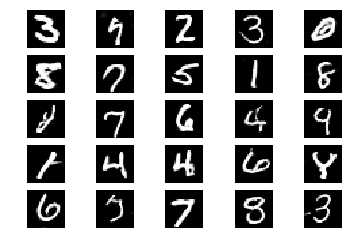

3401 [D loss: 0.605785, acc.: 66.02%] [G loss: 1.263866]
3402 [D loss: 0.627246, acc.: 64.06%] [G loss: 1.274484]
3403 [D loss: 0.548019, acc.: 73.83%] [G loss: 1.134284]
3404 [D loss: 0.511483, acc.: 76.56%] [G loss: 1.373485]
3405 [D loss: 0.642633, acc.: 64.06%] [G loss: 1.131136]
3406 [D loss: 0.611917, acc.: 67.58%] [G loss: 0.876146]
3407 [D loss: 0.673106, acc.: 61.72%] [G loss: 1.234853]
3408 [D loss: 0.653554, acc.: 61.72%] [G loss: 0.973136]
3409 [D loss: 0.561439, acc.: 68.75%] [G loss: 1.299369]
3410 [D loss: 0.760993, acc.: 51.56%] [G loss: 1.274360]
3411 [D loss: 0.562617, acc.: 72.27%] [G loss: 1.238942]
3412 [D loss: 0.651295, acc.: 62.11%] [G loss: 1.021653]
3413 [D loss: 0.623055, acc.: 64.06%] [G loss: 1.197635]
3414 [D loss: 0.617699, acc.: 66.80%] [G loss: 1.213837]
3415 [D loss: 0.579797, acc.: 72.66%] [G loss: 1.130813]
3416 [D loss: 0.581583, acc.: 68.75%] [G loss: 1.141846]
3417 [D loss: 0.792669, acc.: 46.48%] [G loss: 1.142050]
3418 [D loss: 0.573035, acc.: 7

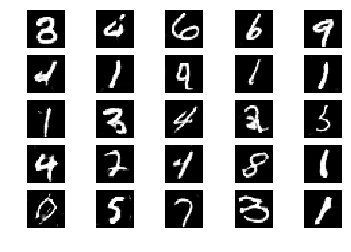

3451 [D loss: 0.682285, acc.: 59.38%] [G loss: 0.964269]
3452 [D loss: 0.683710, acc.: 60.94%] [G loss: 1.062584]
3453 [D loss: 0.602731, acc.: 66.02%] [G loss: 1.014875]
3454 [D loss: 0.559267, acc.: 74.22%] [G loss: 1.162363]
3455 [D loss: 0.573262, acc.: 71.48%] [G loss: 1.029186]
3456 [D loss: 0.661506, acc.: 60.16%] [G loss: 1.209373]
3457 [D loss: 0.667224, acc.: 56.25%] [G loss: 1.125446]
3458 [D loss: 0.647766, acc.: 66.41%] [G loss: 1.124928]
3459 [D loss: 0.522763, acc.: 75.78%] [G loss: 1.392441]
3460 [D loss: 0.671672, acc.: 60.94%] [G loss: 0.965049]
3461 [D loss: 0.622131, acc.: 62.50%] [G loss: 0.914906]
3462 [D loss: 0.688299, acc.: 60.16%] [G loss: 0.947950]
3463 [D loss: 0.578646, acc.: 71.88%] [G loss: 1.233196]
3464 [D loss: 0.575273, acc.: 67.58%] [G loss: 1.377750]
3465 [D loss: 0.718531, acc.: 55.86%] [G loss: 1.008768]
3466 [D loss: 0.599074, acc.: 66.80%] [G loss: 1.159383]
3467 [D loss: 0.588067, acc.: 68.36%] [G loss: 1.345568]
3468 [D loss: 0.716111, acc.: 5

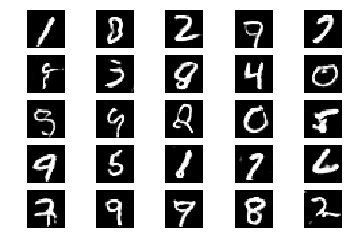

3501 [D loss: 0.565225, acc.: 69.92%] [G loss: 1.262703]
3502 [D loss: 0.547787, acc.: 75.00%] [G loss: 1.065980]
3503 [D loss: 0.677208, acc.: 58.98%] [G loss: 1.149942]
3504 [D loss: 0.645286, acc.: 61.72%] [G loss: 1.157712]
3505 [D loss: 0.630579, acc.: 64.84%] [G loss: 1.172087]
3506 [D loss: 0.633669, acc.: 61.33%] [G loss: 1.138763]
3507 [D loss: 0.685913, acc.: 60.94%] [G loss: 1.072056]
3508 [D loss: 0.606641, acc.: 68.36%] [G loss: 1.252970]
3509 [D loss: 0.602685, acc.: 68.36%] [G loss: 1.269432]
3510 [D loss: 0.582114, acc.: 67.58%] [G loss: 1.203443]
3511 [D loss: 0.602940, acc.: 67.97%] [G loss: 1.170285]
3512 [D loss: 0.681756, acc.: 58.59%] [G loss: 1.056204]
3513 [D loss: 0.610150, acc.: 64.84%] [G loss: 1.192491]
3514 [D loss: 0.554362, acc.: 73.83%] [G loss: 1.043876]
3515 [D loss: 0.642607, acc.: 63.28%] [G loss: 0.974726]
3516 [D loss: 0.509640, acc.: 76.17%] [G loss: 1.280142]
3517 [D loss: 0.672202, acc.: 62.50%] [G loss: 1.158092]
3518 [D loss: 0.647846, acc.: 6

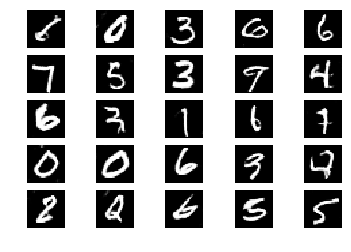

3551 [D loss: 0.647674, acc.: 64.84%] [G loss: 1.019994]
3552 [D loss: 0.598947, acc.: 63.67%] [G loss: 1.148644]
3553 [D loss: 0.789157, acc.: 47.66%] [G loss: 1.077359]
3554 [D loss: 0.558562, acc.: 72.27%] [G loss: 1.105584]
3555 [D loss: 0.495032, acc.: 80.08%] [G loss: 1.048354]
3556 [D loss: 0.569139, acc.: 73.05%] [G loss: 1.071874]
3557 [D loss: 0.675692, acc.: 57.81%] [G loss: 1.005883]
3558 [D loss: 0.725856, acc.: 53.91%] [G loss: 1.160280]
3559 [D loss: 0.574823, acc.: 70.31%] [G loss: 1.045989]
3560 [D loss: 0.507703, acc.: 76.56%] [G loss: 1.051446]
3561 [D loss: 0.667171, acc.: 58.59%] [G loss: 1.241488]
3562 [D loss: 0.598751, acc.: 67.97%] [G loss: 1.355760]
3563 [D loss: 0.691421, acc.: 57.81%] [G loss: 0.995656]
3564 [D loss: 0.509182, acc.: 76.56%] [G loss: 1.191047]
3565 [D loss: 0.717707, acc.: 56.64%] [G loss: 0.997662]
3566 [D loss: 0.612862, acc.: 66.02%] [G loss: 1.187830]
3567 [D loss: 0.582956, acc.: 68.36%] [G loss: 0.949074]
3568 [D loss: 0.667645, acc.: 6

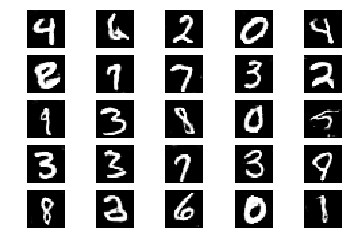

3601 [D loss: 0.751673, acc.: 53.12%] [G loss: 0.930868]
3602 [D loss: 0.577557, acc.: 65.23%] [G loss: 1.246975]
3603 [D loss: 0.605092, acc.: 64.45%] [G loss: 1.331814]
3604 [D loss: 0.651213, acc.: 63.67%] [G loss: 1.170909]
3605 [D loss: 0.473333, acc.: 83.20%] [G loss: 1.164881]
3606 [D loss: 0.726964, acc.: 55.86%] [G loss: 0.905439]
3607 [D loss: 0.519583, acc.: 82.03%] [G loss: 1.249003]
3608 [D loss: 0.563993, acc.: 73.44%] [G loss: 1.189416]
3609 [D loss: 0.589002, acc.: 70.31%] [G loss: 1.299851]
3610 [D loss: 0.518097, acc.: 77.34%] [G loss: 1.231758]
3611 [D loss: 0.676997, acc.: 59.77%] [G loss: 1.002823]
3612 [D loss: 0.721907, acc.: 53.91%] [G loss: 1.062547]
3613 [D loss: 0.615017, acc.: 62.50%] [G loss: 0.971385]
3614 [D loss: 0.746853, acc.: 51.95%] [G loss: 0.807271]
3615 [D loss: 0.694271, acc.: 58.20%] [G loss: 1.136230]
3616 [D loss: 0.645247, acc.: 65.62%] [G loss: 1.218679]
3617 [D loss: 0.602102, acc.: 65.23%] [G loss: 1.310608]
3618 [D loss: 0.650572, acc.: 6

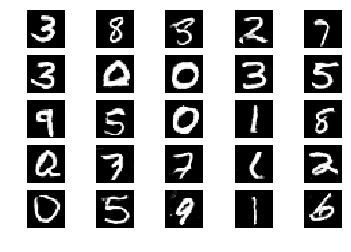

3651 [D loss: 0.623735, acc.: 65.23%] [G loss: 1.323530]
3652 [D loss: 0.658031, acc.: 59.77%] [G loss: 1.329367]
3653 [D loss: 0.647448, acc.: 62.11%] [G loss: 1.242426]
3654 [D loss: 0.588439, acc.: 66.80%] [G loss: 1.109946]
3655 [D loss: 0.517055, acc.: 76.95%] [G loss: 1.140983]
3656 [D loss: 0.586774, acc.: 70.31%] [G loss: 1.295097]
3657 [D loss: 0.520823, acc.: 77.73%] [G loss: 1.313213]
3658 [D loss: 0.713394, acc.: 55.47%] [G loss: 1.269638]
3659 [D loss: 0.503163, acc.: 79.30%] [G loss: 1.236096]
3660 [D loss: 0.652476, acc.: 61.72%] [G loss: 1.106081]
3661 [D loss: 0.492729, acc.: 76.95%] [G loss: 1.154238]
3662 [D loss: 0.621633, acc.: 66.80%] [G loss: 0.953051]
3663 [D loss: 0.620497, acc.: 63.28%] [G loss: 1.180695]
3664 [D loss: 0.676503, acc.: 61.33%] [G loss: 1.127615]
3665 [D loss: 0.582459, acc.: 73.05%] [G loss: 1.153288]
3666 [D loss: 0.711606, acc.: 55.08%] [G loss: 1.129260]
3667 [D loss: 0.729449, acc.: 53.91%] [G loss: 1.216162]
3668 [D loss: 0.623310, acc.: 6

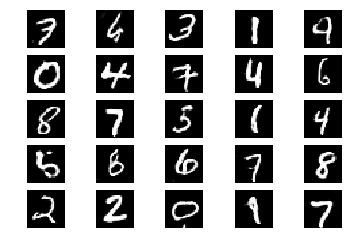

3701 [D loss: 0.553253, acc.: 71.48%] [G loss: 1.337556]
3702 [D loss: 0.698101, acc.: 53.52%] [G loss: 1.149906]
3703 [D loss: 0.610841, acc.: 67.58%] [G loss: 1.047727]
3704 [D loss: 0.650868, acc.: 62.50%] [G loss: 1.347191]
3705 [D loss: 0.728223, acc.: 53.91%] [G loss: 1.206642]
3706 [D loss: 0.569455, acc.: 70.70%] [G loss: 0.998040]
3707 [D loss: 0.701989, acc.: 57.81%] [G loss: 1.038448]
3708 [D loss: 0.701536, acc.: 58.20%] [G loss: 0.857049]
3709 [D loss: 0.703156, acc.: 57.03%] [G loss: 1.079054]
3710 [D loss: 0.606017, acc.: 68.36%] [G loss: 1.216306]
3711 [D loss: 0.631005, acc.: 65.23%] [G loss: 1.290197]
3712 [D loss: 0.578805, acc.: 69.53%] [G loss: 1.374930]
3713 [D loss: 0.596130, acc.: 68.36%] [G loss: 1.243291]
3714 [D loss: 0.585348, acc.: 71.88%] [G loss: 1.081783]
3715 [D loss: 0.524299, acc.: 76.56%] [G loss: 1.385705]
3716 [D loss: 0.573062, acc.: 67.97%] [G loss: 1.154063]
3717 [D loss: 0.734532, acc.: 53.12%] [G loss: 1.274795]
3718 [D loss: 0.604687, acc.: 6

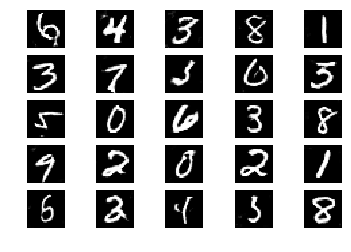

3751 [D loss: 0.623841, acc.: 64.45%] [G loss: 1.204495]
3752 [D loss: 0.596104, acc.: 65.62%] [G loss: 1.263726]
3753 [D loss: 0.680593, acc.: 61.72%] [G loss: 1.114953]
3754 [D loss: 0.606444, acc.: 67.19%] [G loss: 1.050402]
3755 [D loss: 0.579131, acc.: 70.70%] [G loss: 0.842391]
3756 [D loss: 0.690828, acc.: 55.86%] [G loss: 0.987923]
3757 [D loss: 0.628443, acc.: 61.72%] [G loss: 1.041983]
3758 [D loss: 0.638280, acc.: 64.06%] [G loss: 0.992948]
3759 [D loss: 0.719041, acc.: 56.64%] [G loss: 1.199628]
3760 [D loss: 0.679757, acc.: 57.42%] [G loss: 0.992048]
3761 [D loss: 0.668978, acc.: 61.33%] [G loss: 1.281833]
3762 [D loss: 0.723702, acc.: 53.12%] [G loss: 1.201658]
3763 [D loss: 0.671451, acc.: 59.77%] [G loss: 0.977036]
3764 [D loss: 0.618814, acc.: 64.06%] [G loss: 1.133568]
3765 [D loss: 0.692947, acc.: 55.86%] [G loss: 1.030715]
3766 [D loss: 0.666933, acc.: 59.77%] [G loss: 0.974515]
3767 [D loss: 0.800204, acc.: 43.36%] [G loss: 0.928347]
3768 [D loss: 0.633645, acc.: 6

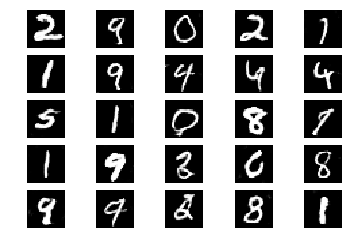

3801 [D loss: 0.666725, acc.: 59.77%] [G loss: 0.975637]
3802 [D loss: 0.666478, acc.: 59.38%] [G loss: 1.203155]
3803 [D loss: 0.615454, acc.: 66.80%] [G loss: 1.020029]
3804 [D loss: 0.599051, acc.: 69.53%] [G loss: 1.014062]
3805 [D loss: 0.681576, acc.: 55.08%] [G loss: 0.985335]
3806 [D loss: 0.636362, acc.: 62.50%] [G loss: 1.032106]
3807 [D loss: 0.617746, acc.: 65.62%] [G loss: 1.250445]
3808 [D loss: 0.614770, acc.: 65.62%] [G loss: 1.297336]
3809 [D loss: 0.616501, acc.: 68.36%] [G loss: 1.159659]
3810 [D loss: 0.582316, acc.: 73.05%] [G loss: 1.164829]
3811 [D loss: 0.582943, acc.: 67.97%] [G loss: 1.243555]
3812 [D loss: 0.590279, acc.: 69.92%] [G loss: 1.093985]
3813 [D loss: 0.709488, acc.: 53.52%] [G loss: 0.948674]
3814 [D loss: 0.517562, acc.: 75.39%] [G loss: 1.102184]
3815 [D loss: 0.590032, acc.: 68.36%] [G loss: 1.226581]
3816 [D loss: 0.551615, acc.: 72.66%] [G loss: 1.247822]
3817 [D loss: 0.580131, acc.: 69.53%] [G loss: 1.317719]
3818 [D loss: 0.747952, acc.: 5

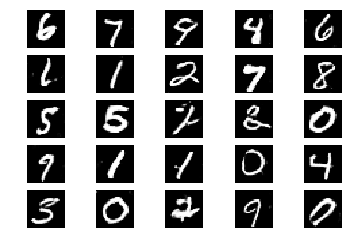

3851 [D loss: 0.491722, acc.: 78.52%] [G loss: 1.345377]
3852 [D loss: 0.624786, acc.: 66.80%] [G loss: 1.124831]
3853 [D loss: 0.507259, acc.: 80.08%] [G loss: 1.168796]
3854 [D loss: 0.654442, acc.: 61.33%] [G loss: 1.026779]
3855 [D loss: 0.493085, acc.: 79.69%] [G loss: 1.423181]
3856 [D loss: 0.615149, acc.: 64.84%] [G loss: 1.100028]
3857 [D loss: 0.604022, acc.: 67.97%] [G loss: 1.062991]
3858 [D loss: 0.627553, acc.: 64.45%] [G loss: 1.106319]
3859 [D loss: 0.735564, acc.: 52.73%] [G loss: 0.919726]
3860 [D loss: 0.711893, acc.: 54.30%] [G loss: 1.074863]
3861 [D loss: 0.645784, acc.: 62.50%] [G loss: 1.384212]
3862 [D loss: 0.658682, acc.: 63.28%] [G loss: 1.181156]
3863 [D loss: 0.548596, acc.: 69.92%] [G loss: 1.111710]
3864 [D loss: 0.571195, acc.: 68.75%] [G loss: 1.429483]
3865 [D loss: 0.511818, acc.: 75.00%] [G loss: 1.396045]
3866 [D loss: 0.566690, acc.: 75.78%] [G loss: 1.199309]
3867 [D loss: 0.560139, acc.: 72.27%] [G loss: 1.118956]
3868 [D loss: 0.593868, acc.: 6

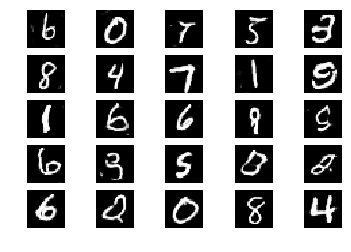

3901 [D loss: 0.592896, acc.: 69.92%] [G loss: 0.995744]
3902 [D loss: 0.542321, acc.: 72.66%] [G loss: 0.949538]
3903 [D loss: 0.489461, acc.: 78.91%] [G loss: 1.395036]
3904 [D loss: 0.635549, acc.: 63.28%] [G loss: 1.102166]
3905 [D loss: 0.566891, acc.: 67.58%] [G loss: 1.197782]
3906 [D loss: 0.591744, acc.: 67.97%] [G loss: 1.096377]
3907 [D loss: 0.591621, acc.: 67.19%] [G loss: 1.170876]
3908 [D loss: 0.619474, acc.: 63.67%] [G loss: 1.243218]
3909 [D loss: 0.675960, acc.: 58.59%] [G loss: 1.165442]
3910 [D loss: 0.632776, acc.: 66.80%] [G loss: 0.926365]
3911 [D loss: 0.681707, acc.: 58.59%] [G loss: 1.209062]
3912 [D loss: 0.675000, acc.: 60.94%] [G loss: 1.002128]
3913 [D loss: 0.606717, acc.: 66.41%] [G loss: 1.065611]
3914 [D loss: 0.533987, acc.: 74.61%] [G loss: 1.301944]
3915 [D loss: 0.679965, acc.: 55.86%] [G loss: 1.195293]
3916 [D loss: 0.711349, acc.: 52.73%] [G loss: 1.311226]
3917 [D loss: 0.573442, acc.: 73.05%] [G loss: 1.365068]
3918 [D loss: 0.529609, acc.: 7

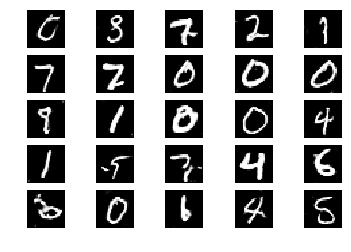

3951 [D loss: 0.584973, acc.: 68.36%] [G loss: 1.246871]
3952 [D loss: 0.451007, acc.: 82.81%] [G loss: 1.165197]
3953 [D loss: 0.623387, acc.: 66.41%] [G loss: 1.275972]
3954 [D loss: 0.494786, acc.: 80.08%] [G loss: 1.318519]
3955 [D loss: 0.518370, acc.: 75.78%] [G loss: 1.532800]
3956 [D loss: 0.580891, acc.: 70.70%] [G loss: 1.252118]
3957 [D loss: 0.685012, acc.: 59.38%] [G loss: 0.953975]
3958 [D loss: 0.592544, acc.: 67.19%] [G loss: 1.342654]
3959 [D loss: 0.587470, acc.: 67.97%] [G loss: 1.165673]
3960 [D loss: 0.488141, acc.: 80.47%] [G loss: 1.033758]
3961 [D loss: 0.673057, acc.: 60.16%] [G loss: 1.063173]
3962 [D loss: 0.563615, acc.: 72.27%] [G loss: 1.444336]
3963 [D loss: 0.693817, acc.: 55.86%] [G loss: 1.212889]
3964 [D loss: 0.600144, acc.: 65.62%] [G loss: 1.458515]
3965 [D loss: 0.606387, acc.: 67.58%] [G loss: 1.273914]
3966 [D loss: 0.700277, acc.: 57.42%] [G loss: 1.084631]
3967 [D loss: 0.475985, acc.: 83.98%] [G loss: 1.195131]
3968 [D loss: 0.620374, acc.: 6

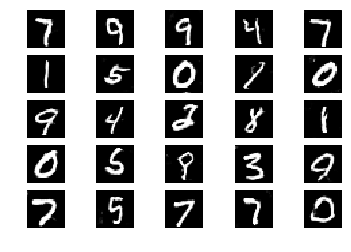

In [162]:
dcgan.train(epochs=4001, batch_size=128, save_interval=50)

## 2. Learning rate =0.01 and batchsize =128

In [163]:
compileGAN(0.01)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
activation_128 (Activation)  (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
activation_129 (Activation)  (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.599603, acc.: 67.97%] [G loss: 1.082731]


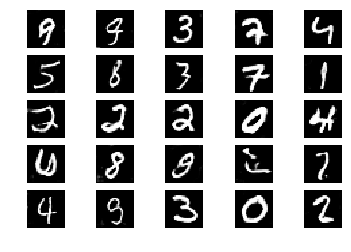

1 [D loss: 0.632743, acc.: 60.94%] [G loss: 1.030832]
2 [D loss: 0.638674, acc.: 59.77%] [G loss: 1.249368]
3 [D loss: 0.617634, acc.: 67.97%] [G loss: 0.881693]
4 [D loss: 0.681395, acc.: 58.20%] [G loss: 1.078922]
5 [D loss: 0.594882, acc.: 69.53%] [G loss: 1.157824]
6 [D loss: 0.601290, acc.: 69.92%] [G loss: 1.219958]
7 [D loss: 0.667314, acc.: 60.55%] [G loss: 0.866495]
8 [D loss: 0.708116, acc.: 55.86%] [G loss: 1.178230]
9 [D loss: 0.582485, acc.: 68.36%] [G loss: 1.247554]
10 [D loss: 0.623802, acc.: 65.62%] [G loss: 1.177874]
11 [D loss: 0.588218, acc.: 69.14%] [G loss: 0.848164]
12 [D loss: 0.513117, acc.: 75.78%] [G loss: 1.251967]
13 [D loss: 0.505641, acc.: 79.30%] [G loss: 1.317379]
14 [D loss: 0.595073, acc.: 68.75%] [G loss: 1.057670]
15 [D loss: 0.574881, acc.: 70.70%] [G loss: 1.156838]
16 [D loss: 0.721615, acc.: 53.52%] [G loss: 1.274486]
17 [D loss: 0.641799, acc.: 63.28%] [G loss: 1.213722]
18 [D loss: 0.515489, acc.: 79.30%] [G loss: 1.047692]
19 [D loss: 0.58810

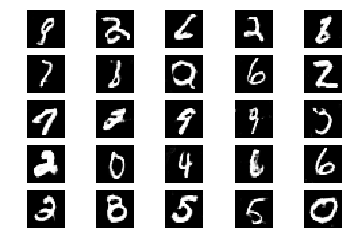

51 [D loss: 0.586313, acc.: 68.36%] [G loss: 1.085250]
52 [D loss: 0.604325, acc.: 64.06%] [G loss: 0.822073]
53 [D loss: 0.647940, acc.: 63.67%] [G loss: 1.173069]
54 [D loss: 0.644426, acc.: 65.23%] [G loss: 0.982300]
55 [D loss: 0.630806, acc.: 63.67%] [G loss: 1.384887]
56 [D loss: 0.567207, acc.: 70.31%] [G loss: 1.134169]
57 [D loss: 0.731989, acc.: 50.78%] [G loss: 1.011207]
58 [D loss: 0.488769, acc.: 79.69%] [G loss: 1.085694]
59 [D loss: 0.603307, acc.: 67.19%] [G loss: 1.171180]
60 [D loss: 0.530062, acc.: 77.34%] [G loss: 1.210095]
61 [D loss: 0.535356, acc.: 75.00%] [G loss: 1.542431]
62 [D loss: 0.580702, acc.: 70.31%] [G loss: 1.199006]
63 [D loss: 0.675981, acc.: 54.69%] [G loss: 1.079905]
64 [D loss: 0.547220, acc.: 74.61%] [G loss: 1.019788]
65 [D loss: 0.626544, acc.: 63.67%] [G loss: 1.030569]
66 [D loss: 0.625456, acc.: 63.67%] [G loss: 1.280639]
67 [D loss: 0.639478, acc.: 64.84%] [G loss: 1.381952]
68 [D loss: 0.689586, acc.: 58.98%] [G loss: 1.231282]
69 [D loss

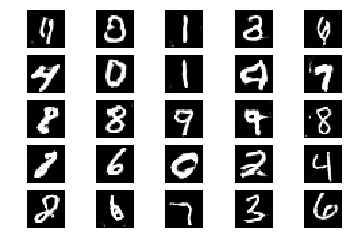

101 [D loss: 0.765582, acc.: 50.00%] [G loss: 1.020897]
102 [D loss: 0.661139, acc.: 63.28%] [G loss: 1.092634]
103 [D loss: 0.583046, acc.: 67.19%] [G loss: 1.335052]
104 [D loss: 0.757086, acc.: 48.83%] [G loss: 0.970522]
105 [D loss: 0.590654, acc.: 71.48%] [G loss: 1.242057]
106 [D loss: 0.682255, acc.: 58.20%] [G loss: 1.166039]
107 [D loss: 0.768026, acc.: 49.22%] [G loss: 0.964179]
108 [D loss: 0.559672, acc.: 71.48%] [G loss: 1.293407]
109 [D loss: 0.612044, acc.: 67.19%] [G loss: 1.185538]
110 [D loss: 0.586116, acc.: 69.53%] [G loss: 1.194730]
111 [D loss: 0.621713, acc.: 63.28%] [G loss: 1.282078]
112 [D loss: 0.799818, acc.: 45.70%] [G loss: 0.971200]
113 [D loss: 0.684920, acc.: 56.64%] [G loss: 0.992857]
114 [D loss: 0.632671, acc.: 67.19%] [G loss: 1.090412]
115 [D loss: 0.590631, acc.: 63.67%] [G loss: 1.202020]
116 [D loss: 0.600823, acc.: 68.36%] [G loss: 1.177259]
117 [D loss: 0.611954, acc.: 66.80%] [G loss: 1.210744]
118 [D loss: 0.652415, acc.: 63.28%] [G loss: 1.

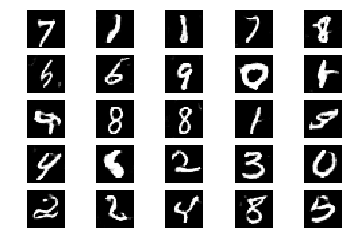

151 [D loss: 0.630277, acc.: 64.06%] [G loss: 0.916190]
152 [D loss: 0.625566, acc.: 62.89%] [G loss: 1.275977]
153 [D loss: 0.590309, acc.: 67.97%] [G loss: 1.565935]
154 [D loss: 0.710598, acc.: 58.98%] [G loss: 0.972918]
155 [D loss: 0.629654, acc.: 64.45%] [G loss: 1.193680]
156 [D loss: 0.703605, acc.: 50.39%] [G loss: 1.100510]
157 [D loss: 0.554752, acc.: 72.66%] [G loss: 1.085431]
158 [D loss: 0.824425, acc.: 45.31%] [G loss: 1.044894]
159 [D loss: 0.723195, acc.: 51.56%] [G loss: 1.286698]
160 [D loss: 0.551812, acc.: 71.48%] [G loss: 1.190228]
161 [D loss: 0.671049, acc.: 62.89%] [G loss: 1.066971]
162 [D loss: 0.504672, acc.: 78.52%] [G loss: 1.360521]
163 [D loss: 0.568767, acc.: 70.70%] [G loss: 1.125933]
164 [D loss: 0.543873, acc.: 73.44%] [G loss: 1.324064]
165 [D loss: 0.622891, acc.: 64.45%] [G loss: 1.117042]
166 [D loss: 0.519660, acc.: 78.12%] [G loss: 1.222976]
167 [D loss: 0.662225, acc.: 63.28%] [G loss: 1.027461]
168 [D loss: 0.529312, acc.: 76.95%] [G loss: 1.

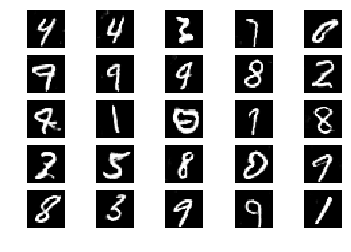

201 [D loss: 0.691586, acc.: 58.98%] [G loss: 1.188431]
202 [D loss: 0.608494, acc.: 66.80%] [G loss: 1.109954]
203 [D loss: 0.654441, acc.: 62.89%] [G loss: 1.156678]
204 [D loss: 0.508853, acc.: 80.86%] [G loss: 1.235815]
205 [D loss: 0.741226, acc.: 50.39%] [G loss: 1.135180]
206 [D loss: 0.542480, acc.: 76.17%] [G loss: 1.138334]
207 [D loss: 0.546050, acc.: 74.22%] [G loss: 1.391502]
208 [D loss: 0.552697, acc.: 75.78%] [G loss: 1.307649]
209 [D loss: 0.557524, acc.: 71.88%] [G loss: 1.178304]
210 [D loss: 0.481779, acc.: 80.08%] [G loss: 1.063304]
211 [D loss: 0.562401, acc.: 69.14%] [G loss: 1.033638]
212 [D loss: 0.602234, acc.: 66.02%] [G loss: 1.104398]
213 [D loss: 0.727044, acc.: 57.42%] [G loss: 1.184770]
214 [D loss: 0.578902, acc.: 69.14%] [G loss: 1.208322]
215 [D loss: 0.700468, acc.: 55.86%] [G loss: 1.069456]
216 [D loss: 0.652007, acc.: 62.11%] [G loss: 1.079545]
217 [D loss: 0.540197, acc.: 75.00%] [G loss: 1.091356]
218 [D loss: 0.506550, acc.: 77.73%] [G loss: 1.

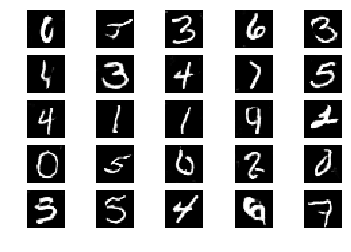

251 [D loss: 0.516139, acc.: 76.56%] [G loss: 1.089327]
252 [D loss: 0.641649, acc.: 66.02%] [G loss: 1.287757]
253 [D loss: 0.652186, acc.: 60.16%] [G loss: 1.132240]
254 [D loss: 0.574277, acc.: 69.92%] [G loss: 1.036703]
255 [D loss: 0.559807, acc.: 73.05%] [G loss: 1.274496]
256 [D loss: 0.605158, acc.: 67.58%] [G loss: 1.153003]
257 [D loss: 0.568540, acc.: 70.31%] [G loss: 1.242455]
258 [D loss: 0.676495, acc.: 60.55%] [G loss: 1.065223]
259 [D loss: 0.619234, acc.: 63.28%] [G loss: 1.414986]
260 [D loss: 0.637006, acc.: 63.28%] [G loss: 1.213821]
261 [D loss: 0.726131, acc.: 50.78%] [G loss: 1.035958]
262 [D loss: 0.544055, acc.: 71.09%] [G loss: 1.050967]
263 [D loss: 0.641150, acc.: 66.02%] [G loss: 0.915568]
264 [D loss: 0.643128, acc.: 62.50%] [G loss: 1.234435]
265 [D loss: 0.578191, acc.: 68.36%] [G loss: 1.304721]
266 [D loss: 0.733756, acc.: 54.30%] [G loss: 1.240407]
267 [D loss: 0.609141, acc.: 69.14%] [G loss: 1.081343]
268 [D loss: 0.664169, acc.: 62.50%] [G loss: 1.

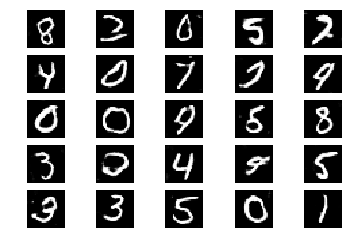

301 [D loss: 0.642932, acc.: 63.67%] [G loss: 1.256257]
302 [D loss: 0.655360, acc.: 60.16%] [G loss: 1.230882]
303 [D loss: 0.618623, acc.: 66.80%] [G loss: 1.119747]
304 [D loss: 0.604861, acc.: 66.41%] [G loss: 1.231407]
305 [D loss: 0.678600, acc.: 58.98%] [G loss: 1.180461]
306 [D loss: 0.542183, acc.: 75.78%] [G loss: 1.289846]
307 [D loss: 0.519848, acc.: 77.34%] [G loss: 1.126052]
308 [D loss: 0.662192, acc.: 58.59%] [G loss: 0.825009]
309 [D loss: 0.562383, acc.: 72.66%] [G loss: 1.234728]
310 [D loss: 0.632780, acc.: 60.55%] [G loss: 1.022198]
311 [D loss: 0.528884, acc.: 73.05%] [G loss: 0.961889]
312 [D loss: 0.674682, acc.: 58.20%] [G loss: 1.045319]
313 [D loss: 0.594321, acc.: 66.80%] [G loss: 1.281846]
314 [D loss: 0.513126, acc.: 74.22%] [G loss: 1.220613]
315 [D loss: 0.655987, acc.: 60.55%] [G loss: 1.004684]
316 [D loss: 0.717625, acc.: 53.12%] [G loss: 0.862041]
317 [D loss: 0.521183, acc.: 77.73%] [G loss: 1.238003]
318 [D loss: 0.589518, acc.: 66.02%] [G loss: 1.

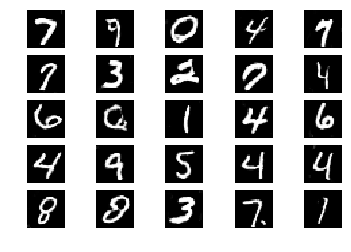

351 [D loss: 0.559284, acc.: 72.66%] [G loss: 1.204491]
352 [D loss: 0.632247, acc.: 64.84%] [G loss: 1.281354]
353 [D loss: 0.588823, acc.: 68.36%] [G loss: 1.161418]
354 [D loss: 0.554761, acc.: 71.48%] [G loss: 1.178808]
355 [D loss: 0.825580, acc.: 45.70%] [G loss: 0.972490]
356 [D loss: 0.671438, acc.: 59.38%] [G loss: 1.156214]
357 [D loss: 0.587473, acc.: 67.19%] [G loss: 1.309695]
358 [D loss: 0.631138, acc.: 62.89%] [G loss: 1.106180]
359 [D loss: 0.654753, acc.: 59.38%] [G loss: 1.079515]
360 [D loss: 0.565639, acc.: 69.92%] [G loss: 1.378810]
361 [D loss: 0.552689, acc.: 73.05%] [G loss: 1.377311]
362 [D loss: 0.606369, acc.: 69.92%] [G loss: 1.189253]
363 [D loss: 0.569016, acc.: 69.53%] [G loss: 1.282763]
364 [D loss: 0.604022, acc.: 65.62%] [G loss: 1.209180]
365 [D loss: 0.563467, acc.: 71.09%] [G loss: 1.248733]
366 [D loss: 0.644611, acc.: 63.67%] [G loss: 1.236269]
367 [D loss: 0.567631, acc.: 72.66%] [G loss: 1.061614]
368 [D loss: 0.562221, acc.: 70.70%] [G loss: 1.

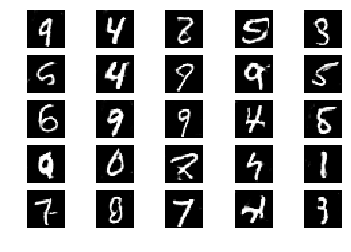

401 [D loss: 0.700205, acc.: 58.59%] [G loss: 1.074907]
402 [D loss: 0.569880, acc.: 74.22%] [G loss: 1.151481]
403 [D loss: 0.703241, acc.: 58.98%] [G loss: 1.337979]
404 [D loss: 0.733265, acc.: 51.95%] [G loss: 1.124143]
405 [D loss: 0.504786, acc.: 81.25%] [G loss: 1.129224]
406 [D loss: 0.624539, acc.: 62.89%] [G loss: 1.123510]
407 [D loss: 0.605083, acc.: 66.41%] [G loss: 1.090676]
408 [D loss: 0.636127, acc.: 64.06%] [G loss: 1.121966]
409 [D loss: 0.600873, acc.: 64.45%] [G loss: 1.189731]
410 [D loss: 0.521470, acc.: 80.08%] [G loss: 1.169843]
411 [D loss: 0.605675, acc.: 66.80%] [G loss: 0.993067]
412 [D loss: 0.568931, acc.: 73.44%] [G loss: 1.035299]
413 [D loss: 0.688007, acc.: 59.38%] [G loss: 1.208886]
414 [D loss: 0.492317, acc.: 80.47%] [G loss: 1.054193]
415 [D loss: 0.634429, acc.: 62.89%] [G loss: 1.275154]
416 [D loss: 0.608541, acc.: 63.67%] [G loss: 1.174727]
417 [D loss: 0.670176, acc.: 56.64%] [G loss: 0.907793]
418 [D loss: 0.644958, acc.: 63.67%] [G loss: 1.

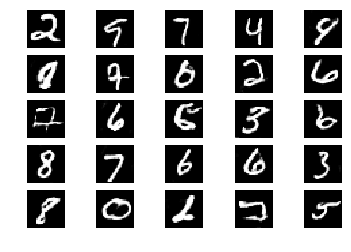

451 [D loss: 0.646863, acc.: 59.77%] [G loss: 1.377192]
452 [D loss: 0.565948, acc.: 70.70%] [G loss: 0.928418]
453 [D loss: 0.711209, acc.: 54.69%] [G loss: 1.135997]
454 [D loss: 0.790613, acc.: 46.88%] [G loss: 1.002945]
455 [D loss: 0.591193, acc.: 69.53%] [G loss: 1.159545]
456 [D loss: 0.613125, acc.: 66.02%] [G loss: 1.206671]
457 [D loss: 0.574567, acc.: 66.41%] [G loss: 1.336807]
458 [D loss: 0.528385, acc.: 71.09%] [G loss: 1.131301]
459 [D loss: 0.633738, acc.: 63.67%] [G loss: 1.073118]
460 [D loss: 0.756081, acc.: 49.61%] [G loss: 1.167794]
461 [D loss: 0.709317, acc.: 56.25%] [G loss: 0.915172]
462 [D loss: 0.637716, acc.: 61.33%] [G loss: 1.162569]
463 [D loss: 0.577755, acc.: 69.53%] [G loss: 1.305138]
464 [D loss: 0.665521, acc.: 61.72%] [G loss: 0.900372]
465 [D loss: 0.560216, acc.: 72.66%] [G loss: 1.023007]
466 [D loss: 0.670062, acc.: 60.16%] [G loss: 0.908045]
467 [D loss: 0.661676, acc.: 62.50%] [G loss: 0.850105]
468 [D loss: 0.603827, acc.: 67.58%] [G loss: 1.

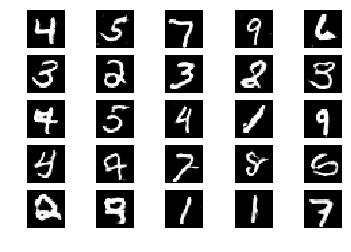

501 [D loss: 0.702933, acc.: 52.34%] [G loss: 1.047112]
502 [D loss: 0.556349, acc.: 73.83%] [G loss: 1.196068]
503 [D loss: 0.897468, acc.: 38.28%] [G loss: 1.342002]
504 [D loss: 0.662971, acc.: 64.45%] [G loss: 1.065068]
505 [D loss: 0.767951, acc.: 51.56%] [G loss: 1.375694]
506 [D loss: 0.614652, acc.: 63.28%] [G loss: 1.172209]
507 [D loss: 0.665459, acc.: 64.45%] [G loss: 1.053057]
508 [D loss: 0.572335, acc.: 71.09%] [G loss: 0.964891]
509 [D loss: 0.512630, acc.: 78.91%] [G loss: 1.244347]
510 [D loss: 0.572370, acc.: 67.97%] [G loss: 1.032892]
511 [D loss: 0.568380, acc.: 68.75%] [G loss: 1.222005]
512 [D loss: 0.601471, acc.: 64.06%] [G loss: 1.052447]
513 [D loss: 0.562728, acc.: 73.05%] [G loss: 1.123609]
514 [D loss: 0.647033, acc.: 61.72%] [G loss: 1.029628]
515 [D loss: 0.591712, acc.: 68.36%] [G loss: 1.219870]
516 [D loss: 0.609905, acc.: 63.67%] [G loss: 1.116575]
517 [D loss: 0.589761, acc.: 70.31%] [G loss: 1.228047]
518 [D loss: 0.556443, acc.: 75.00%] [G loss: 1.

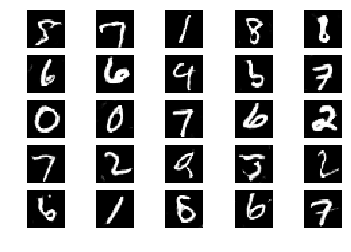

551 [D loss: 0.726772, acc.: 54.69%] [G loss: 1.054686]
552 [D loss: 0.633551, acc.: 64.84%] [G loss: 1.174596]
553 [D loss: 0.575283, acc.: 69.14%] [G loss: 1.129934]
554 [D loss: 0.707559, acc.: 57.42%] [G loss: 1.138359]
555 [D loss: 0.420343, acc.: 86.33%] [G loss: 1.096991]
556 [D loss: 0.661930, acc.: 57.81%] [G loss: 1.285581]
557 [D loss: 0.719839, acc.: 55.47%] [G loss: 1.201969]
558 [D loss: 0.745180, acc.: 55.86%] [G loss: 0.892942]
559 [D loss: 0.512858, acc.: 76.95%] [G loss: 1.016343]
560 [D loss: 0.473151, acc.: 83.59%] [G loss: 1.070578]
561 [D loss: 0.565360, acc.: 71.09%] [G loss: 1.128592]
562 [D loss: 0.689314, acc.: 57.42%] [G loss: 1.050807]
563 [D loss: 0.534182, acc.: 76.95%] [G loss: 1.015431]
564 [D loss: 0.628675, acc.: 60.94%] [G loss: 1.150979]
565 [D loss: 0.558617, acc.: 72.27%] [G loss: 1.398183]
566 [D loss: 0.535806, acc.: 76.17%] [G loss: 1.270896]
567 [D loss: 0.545701, acc.: 75.00%] [G loss: 1.107377]
568 [D loss: 0.603110, acc.: 66.80%] [G loss: 1.

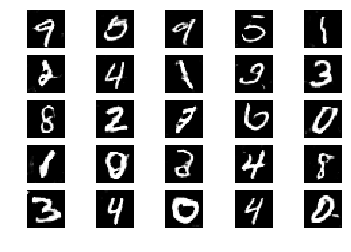

601 [D loss: 0.697894, acc.: 57.03%] [G loss: 1.024285]
602 [D loss: 0.595870, acc.: 69.53%] [G loss: 1.299524]
603 [D loss: 0.524820, acc.: 76.17%] [G loss: 1.025798]
604 [D loss: 0.583360, acc.: 69.53%] [G loss: 0.944254]
605 [D loss: 0.580767, acc.: 68.75%] [G loss: 1.303617]
606 [D loss: 0.630020, acc.: 63.28%] [G loss: 1.049244]
607 [D loss: 0.554322, acc.: 76.17%] [G loss: 1.242235]
608 [D loss: 0.614329, acc.: 69.14%] [G loss: 1.180920]
609 [D loss: 0.486451, acc.: 78.52%] [G loss: 1.290830]
610 [D loss: 0.521752, acc.: 75.78%] [G loss: 1.217712]
611 [D loss: 0.778825, acc.: 46.88%] [G loss: 1.192408]
612 [D loss: 0.572645, acc.: 73.05%] [G loss: 1.110551]
613 [D loss: 0.627720, acc.: 63.28%] [G loss: 0.976979]
614 [D loss: 0.612953, acc.: 64.45%] [G loss: 1.199592]
615 [D loss: 0.723389, acc.: 56.64%] [G loss: 1.037396]
616 [D loss: 0.548071, acc.: 73.44%] [G loss: 1.183355]
617 [D loss: 0.601412, acc.: 65.62%] [G loss: 1.372796]
618 [D loss: 0.601368, acc.: 68.36%] [G loss: 1.

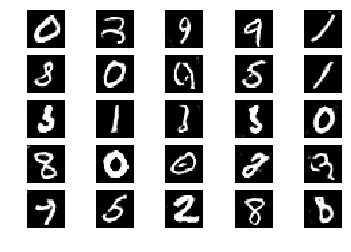

651 [D loss: 0.511877, acc.: 78.91%] [G loss: 1.224641]
652 [D loss: 0.675172, acc.: 55.47%] [G loss: 1.122062]
653 [D loss: 0.619440, acc.: 66.02%] [G loss: 1.126820]
654 [D loss: 0.554437, acc.: 71.09%] [G loss: 1.234417]
655 [D loss: 0.609128, acc.: 68.36%] [G loss: 1.346759]
656 [D loss: 0.725931, acc.: 50.39%] [G loss: 1.005689]
657 [D loss: 0.525766, acc.: 75.39%] [G loss: 1.396985]
658 [D loss: 0.589941, acc.: 69.14%] [G loss: 1.236999]
659 [D loss: 0.676151, acc.: 60.55%] [G loss: 0.865824]
660 [D loss: 0.591791, acc.: 68.75%] [G loss: 1.182419]
661 [D loss: 0.561373, acc.: 73.44%] [G loss: 1.229544]
662 [D loss: 0.563318, acc.: 71.48%] [G loss: 1.117795]
663 [D loss: 0.615751, acc.: 66.41%] [G loss: 1.421071]
664 [D loss: 0.573925, acc.: 71.09%] [G loss: 1.046697]
665 [D loss: 0.629292, acc.: 64.06%] [G loss: 1.076912]
666 [D loss: 0.533173, acc.: 76.95%] [G loss: 1.554753]
667 [D loss: 0.607928, acc.: 67.19%] [G loss: 1.043301]
668 [D loss: 0.625367, acc.: 64.45%] [G loss: 1.

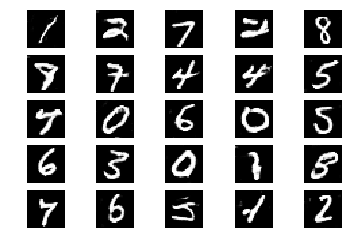

701 [D loss: 0.677102, acc.: 60.94%] [G loss: 0.901286]
702 [D loss: 0.616585, acc.: 66.02%] [G loss: 0.856900]
703 [D loss: 0.551460, acc.: 78.12%] [G loss: 1.240152]
704 [D loss: 0.677691, acc.: 62.50%] [G loss: 1.212791]
705 [D loss: 0.681112, acc.: 56.25%] [G loss: 1.043218]
706 [D loss: 0.725832, acc.: 53.12%] [G loss: 0.970920]
707 [D loss: 0.666464, acc.: 57.81%] [G loss: 1.179882]
708 [D loss: 0.649006, acc.: 59.77%] [G loss: 1.085018]
709 [D loss: 0.548118, acc.: 75.78%] [G loss: 1.148749]
710 [D loss: 0.665624, acc.: 60.55%] [G loss: 1.164088]
711 [D loss: 0.794221, acc.: 45.70%] [G loss: 1.168712]
712 [D loss: 0.596399, acc.: 68.75%] [G loss: 1.250226]
713 [D loss: 0.780202, acc.: 49.61%] [G loss: 1.090431]
714 [D loss: 0.428500, acc.: 85.16%] [G loss: 1.102203]
715 [D loss: 0.540592, acc.: 71.48%] [G loss: 1.081389]
716 [D loss: 0.545826, acc.: 74.61%] [G loss: 1.077622]
717 [D loss: 0.690265, acc.: 60.94%] [G loss: 1.143845]
718 [D loss: 0.596112, acc.: 70.31%] [G loss: 1.

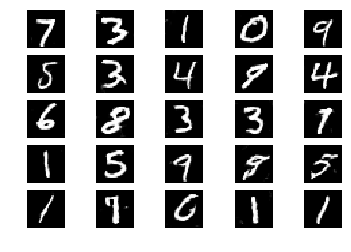

751 [D loss: 0.583365, acc.: 69.53%] [G loss: 1.141695]
752 [D loss: 0.596343, acc.: 68.36%] [G loss: 1.269040]
753 [D loss: 0.631200, acc.: 65.62%] [G loss: 1.240000]
754 [D loss: 0.893505, acc.: 40.23%] [G loss: 1.042162]
755 [D loss: 0.620153, acc.: 64.45%] [G loss: 1.518959]
756 [D loss: 0.594175, acc.: 68.36%] [G loss: 1.345840]
757 [D loss: 0.821282, acc.: 42.58%] [G loss: 1.187123]
758 [D loss: 0.645662, acc.: 63.28%] [G loss: 1.027996]
759 [D loss: 0.676548, acc.: 59.38%] [G loss: 1.219052]
760 [D loss: 0.702567, acc.: 56.25%] [G loss: 1.080104]
761 [D loss: 0.688839, acc.: 58.98%] [G loss: 1.012174]
762 [D loss: 0.538733, acc.: 72.66%] [G loss: 0.799763]
763 [D loss: 0.728275, acc.: 57.81%] [G loss: 1.013815]
764 [D loss: 0.476902, acc.: 79.69%] [G loss: 1.277828]
765 [D loss: 0.557303, acc.: 73.05%] [G loss: 1.096789]
766 [D loss: 0.591741, acc.: 69.92%] [G loss: 1.232360]
767 [D loss: 0.481209, acc.: 78.12%] [G loss: 1.067006]
768 [D loss: 0.581811, acc.: 66.02%] [G loss: 1.

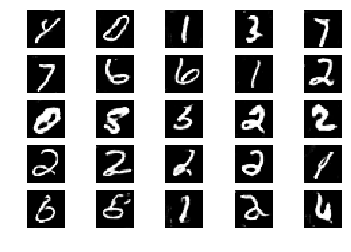

801 [D loss: 0.552234, acc.: 73.83%] [G loss: 1.173550]
802 [D loss: 0.585174, acc.: 66.02%] [G loss: 0.948374]
803 [D loss: 0.623597, acc.: 66.80%] [G loss: 1.235377]
804 [D loss: 0.677240, acc.: 61.33%] [G loss: 1.316140]
805 [D loss: 0.684647, acc.: 56.64%] [G loss: 1.165070]
806 [D loss: 0.639909, acc.: 63.67%] [G loss: 1.235563]
807 [D loss: 0.639388, acc.: 62.11%] [G loss: 1.099748]
808 [D loss: 0.567654, acc.: 71.09%] [G loss: 1.284923]
809 [D loss: 0.541069, acc.: 72.66%] [G loss: 1.174604]
810 [D loss: 0.650635, acc.: 61.33%] [G loss: 1.041326]
811 [D loss: 0.728001, acc.: 55.86%] [G loss: 1.031589]
812 [D loss: 0.450725, acc.: 83.98%] [G loss: 1.344478]
813 [D loss: 0.578919, acc.: 69.92%] [G loss: 1.103117]
814 [D loss: 0.550936, acc.: 71.09%] [G loss: 1.235071]
815 [D loss: 0.722696, acc.: 52.73%] [G loss: 1.076210]
816 [D loss: 0.512286, acc.: 75.78%] [G loss: 1.244503]
817 [D loss: 0.659270, acc.: 59.77%] [G loss: 1.137701]
818 [D loss: 0.662615, acc.: 60.16%] [G loss: 1.

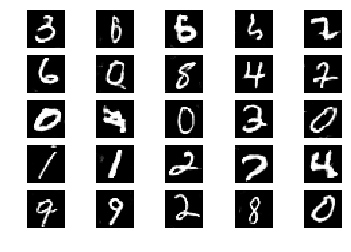

851 [D loss: 0.582524, acc.: 69.14%] [G loss: 0.928179]
852 [D loss: 0.727089, acc.: 53.12%] [G loss: 0.969226]
853 [D loss: 0.567726, acc.: 70.70%] [G loss: 1.251549]
854 [D loss: 0.612329, acc.: 66.80%] [G loss: 1.047258]
855 [D loss: 0.580143, acc.: 71.48%] [G loss: 0.970362]
856 [D loss: 0.732236, acc.: 52.34%] [G loss: 1.119718]
857 [D loss: 0.644045, acc.: 62.89%] [G loss: 0.994284]
858 [D loss: 0.711402, acc.: 55.47%] [G loss: 1.026632]
859 [D loss: 0.644509, acc.: 64.45%] [G loss: 1.488863]
860 [D loss: 0.724737, acc.: 48.83%] [G loss: 1.049623]
861 [D loss: 0.619027, acc.: 64.06%] [G loss: 1.293679]
862 [D loss: 0.598336, acc.: 68.36%] [G loss: 1.238539]
863 [D loss: 0.546444, acc.: 72.66%] [G loss: 1.390269]
864 [D loss: 0.632912, acc.: 66.02%] [G loss: 1.276161]
865 [D loss: 0.602465, acc.: 69.53%] [G loss: 1.315603]
866 [D loss: 0.617872, acc.: 67.19%] [G loss: 1.049282]
867 [D loss: 0.580093, acc.: 68.75%] [G loss: 0.891329]
868 [D loss: 0.652088, acc.: 60.55%] [G loss: 1.

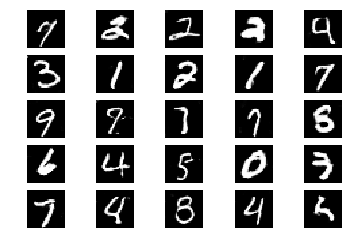

901 [D loss: 0.594652, acc.: 67.58%] [G loss: 1.055450]
902 [D loss: 0.630105, acc.: 65.23%] [G loss: 1.340013]
903 [D loss: 0.827820, acc.: 46.09%] [G loss: 1.301458]
904 [D loss: 0.487928, acc.: 78.91%] [G loss: 0.922048]
905 [D loss: 0.660698, acc.: 58.59%] [G loss: 1.180739]
906 [D loss: 0.591714, acc.: 68.36%] [G loss: 1.014366]
907 [D loss: 0.557765, acc.: 74.22%] [G loss: 1.277364]
908 [D loss: 0.689735, acc.: 58.98%] [G loss: 1.336219]
909 [D loss: 0.676242, acc.: 53.12%] [G loss: 1.243032]
910 [D loss: 0.655196, acc.: 59.38%] [G loss: 1.285220]
911 [D loss: 0.571278, acc.: 71.48%] [G loss: 1.275578]
912 [D loss: 0.728062, acc.: 54.69%] [G loss: 0.702954]
913 [D loss: 0.525239, acc.: 76.17%] [G loss: 1.124111]
914 [D loss: 0.761889, acc.: 49.61%] [G loss: 1.028785]
915 [D loss: 0.677329, acc.: 60.55%] [G loss: 0.851288]
916 [D loss: 0.540586, acc.: 75.39%] [G loss: 1.375704]
917 [D loss: 0.711283, acc.: 56.25%] [G loss: 1.056332]
918 [D loss: 0.754684, acc.: 50.78%] [G loss: 1.

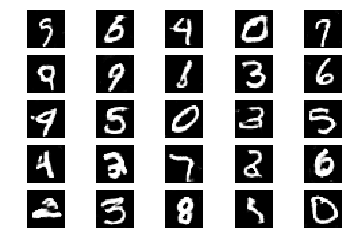

951 [D loss: 0.587668, acc.: 67.58%] [G loss: 1.287716]
952 [D loss: 0.700227, acc.: 56.25%] [G loss: 0.941229]
953 [D loss: 0.658760, acc.: 61.72%] [G loss: 1.208713]
954 [D loss: 0.662924, acc.: 62.11%] [G loss: 1.037593]
955 [D loss: 0.632353, acc.: 64.06%] [G loss: 1.242286]
956 [D loss: 0.646216, acc.: 64.06%] [G loss: 0.871921]
957 [D loss: 0.601173, acc.: 66.02%] [G loss: 1.133450]
958 [D loss: 0.622359, acc.: 64.84%] [G loss: 1.123097]
959 [D loss: 0.553656, acc.: 71.48%] [G loss: 0.999358]
960 [D loss: 0.564273, acc.: 72.27%] [G loss: 1.188143]
961 [D loss: 0.607316, acc.: 67.19%] [G loss: 1.086982]
962 [D loss: 0.564966, acc.: 71.09%] [G loss: 1.296279]
963 [D loss: 0.653884, acc.: 62.89%] [G loss: 1.134994]
964 [D loss: 0.565754, acc.: 74.22%] [G loss: 1.307215]
965 [D loss: 0.618179, acc.: 66.41%] [G loss: 1.292325]
966 [D loss: 0.628757, acc.: 62.89%] [G loss: 1.282946]
967 [D loss: 0.632659, acc.: 62.89%] [G loss: 1.246272]
968 [D loss: 0.644752, acc.: 64.45%] [G loss: 1.

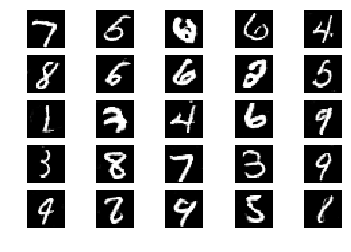

1001 [D loss: 0.603387, acc.: 66.41%] [G loss: 1.323203]
1002 [D loss: 0.653614, acc.: 64.84%] [G loss: 1.193068]
1003 [D loss: 0.626140, acc.: 66.02%] [G loss: 1.159116]
1004 [D loss: 0.635391, acc.: 64.45%] [G loss: 1.013664]
1005 [D loss: 0.658986, acc.: 61.72%] [G loss: 1.139350]
1006 [D loss: 0.689137, acc.: 59.38%] [G loss: 0.969141]
1007 [D loss: 0.621631, acc.: 66.02%] [G loss: 1.290349]
1008 [D loss: 0.594082, acc.: 69.92%] [G loss: 1.201983]
1009 [D loss: 0.686054, acc.: 55.86%] [G loss: 1.137035]
1010 [D loss: 0.464469, acc.: 82.42%] [G loss: 1.307937]
1011 [D loss: 0.727168, acc.: 52.34%] [G loss: 1.058822]
1012 [D loss: 0.678748, acc.: 57.42%] [G loss: 1.306064]
1013 [D loss: 0.575929, acc.: 69.92%] [G loss: 1.257172]
1014 [D loss: 0.616516, acc.: 68.36%] [G loss: 0.955764]
1015 [D loss: 0.637509, acc.: 64.84%] [G loss: 1.297957]
1016 [D loss: 0.541198, acc.: 74.61%] [G loss: 1.367586]
1017 [D loss: 0.547595, acc.: 73.05%] [G loss: 1.415694]
1018 [D loss: 0.479564, acc.: 8

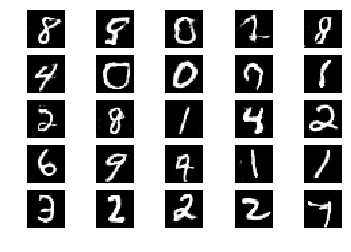

1051 [D loss: 0.626367, acc.: 65.62%] [G loss: 0.904189]
1052 [D loss: 0.614623, acc.: 68.36%] [G loss: 1.044101]
1053 [D loss: 0.490264, acc.: 77.34%] [G loss: 1.135967]
1054 [D loss: 0.607495, acc.: 69.14%] [G loss: 1.039401]
1055 [D loss: 0.552412, acc.: 76.56%] [G loss: 1.260133]
1056 [D loss: 0.528209, acc.: 78.12%] [G loss: 0.929090]
1057 [D loss: 0.602838, acc.: 68.75%] [G loss: 1.094765]
1058 [D loss: 0.808823, acc.: 48.05%] [G loss: 0.852762]
1059 [D loss: 0.665066, acc.: 65.23%] [G loss: 1.161393]
1060 [D loss: 0.489215, acc.: 82.03%] [G loss: 1.039289]
1061 [D loss: 0.686541, acc.: 54.69%] [G loss: 0.726703]
1062 [D loss: 0.704524, acc.: 57.03%] [G loss: 1.045203]
1063 [D loss: 0.587480, acc.: 67.97%] [G loss: 0.949744]
1064 [D loss: 0.663967, acc.: 62.11%] [G loss: 1.046953]
1065 [D loss: 0.691377, acc.: 54.30%] [G loss: 0.846630]
1066 [D loss: 0.682022, acc.: 61.33%] [G loss: 1.175934]
1067 [D loss: 0.660519, acc.: 61.72%] [G loss: 1.207151]
1068 [D loss: 0.588058, acc.: 6

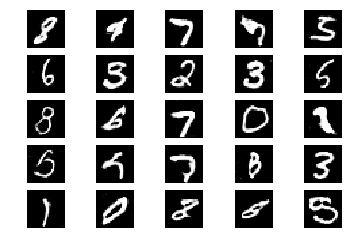

1101 [D loss: 0.583770, acc.: 68.75%] [G loss: 1.280810]
1102 [D loss: 0.573852, acc.: 69.53%] [G loss: 1.138035]
1103 [D loss: 0.745678, acc.: 52.34%] [G loss: 1.038681]
1104 [D loss: 0.541081, acc.: 74.61%] [G loss: 1.072563]
1105 [D loss: 0.516869, acc.: 76.17%] [G loss: 1.205046]
1106 [D loss: 0.581087, acc.: 67.58%] [G loss: 1.042746]
1107 [D loss: 0.469427, acc.: 82.03%] [G loss: 1.092229]
1108 [D loss: 0.625002, acc.: 60.55%] [G loss: 1.075580]
1109 [D loss: 0.588935, acc.: 68.36%] [G loss: 1.116919]
1110 [D loss: 0.535448, acc.: 76.56%] [G loss: 1.089266]
1111 [D loss: 0.650283, acc.: 63.28%] [G loss: 1.145136]
1112 [D loss: 0.688851, acc.: 56.64%] [G loss: 1.304894]
1113 [D loss: 0.630741, acc.: 66.41%] [G loss: 1.197715]
1114 [D loss: 0.607405, acc.: 69.53%] [G loss: 0.931717]
1115 [D loss: 0.655876, acc.: 59.77%] [G loss: 1.008630]
1116 [D loss: 0.566742, acc.: 71.48%] [G loss: 1.042317]
1117 [D loss: 0.658993, acc.: 60.55%] [G loss: 1.130600]
1118 [D loss: 0.515242, acc.: 7

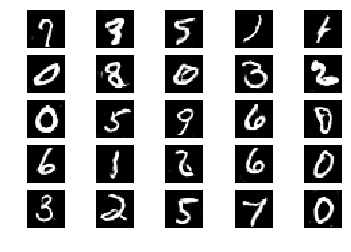

1151 [D loss: 0.804183, acc.: 47.66%] [G loss: 1.039054]
1152 [D loss: 0.703397, acc.: 51.95%] [G loss: 1.186007]
1153 [D loss: 0.596239, acc.: 67.97%] [G loss: 1.004697]
1154 [D loss: 0.579925, acc.: 68.75%] [G loss: 1.165494]
1155 [D loss: 0.590623, acc.: 69.92%] [G loss: 1.322456]
1156 [D loss: 0.632988, acc.: 65.23%] [G loss: 1.155060]
1157 [D loss: 0.634215, acc.: 63.67%] [G loss: 1.009038]
1158 [D loss: 0.611918, acc.: 64.84%] [G loss: 1.164475]
1159 [D loss: 0.655037, acc.: 60.94%] [G loss: 1.111928]
1160 [D loss: 0.513402, acc.: 73.05%] [G loss: 1.141300]
1161 [D loss: 0.647037, acc.: 59.77%] [G loss: 1.260343]
1162 [D loss: 0.685404, acc.: 57.81%] [G loss: 1.140969]
1163 [D loss: 0.692409, acc.: 60.94%] [G loss: 1.224866]
1164 [D loss: 0.673498, acc.: 56.64%] [G loss: 1.153466]
1165 [D loss: 0.538747, acc.: 74.22%] [G loss: 1.174103]
1166 [D loss: 0.627699, acc.: 66.02%] [G loss: 1.269602]
1167 [D loss: 0.698447, acc.: 53.91%] [G loss: 1.196746]
1168 [D loss: 0.511638, acc.: 7

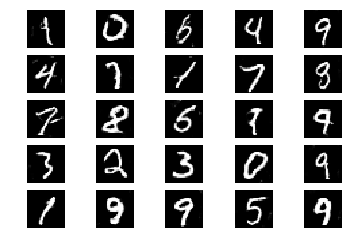

1201 [D loss: 0.569137, acc.: 71.48%] [G loss: 1.478293]
1202 [D loss: 0.593574, acc.: 70.31%] [G loss: 1.033734]
1203 [D loss: 0.717105, acc.: 55.08%] [G loss: 1.016086]
1204 [D loss: 0.693068, acc.: 57.81%] [G loss: 1.075374]
1205 [D loss: 0.550447, acc.: 70.31%] [G loss: 1.116097]
1206 [D loss: 0.533949, acc.: 75.39%] [G loss: 1.035299]
1207 [D loss: 0.730247, acc.: 49.61%] [G loss: 0.814382]
1208 [D loss: 0.687831, acc.: 58.59%] [G loss: 1.010791]
1209 [D loss: 0.685072, acc.: 58.98%] [G loss: 1.316395]
1210 [D loss: 0.592710, acc.: 65.62%] [G loss: 0.989874]
1211 [D loss: 0.674064, acc.: 60.94%] [G loss: 1.169978]
1212 [D loss: 0.607731, acc.: 67.97%] [G loss: 1.008741]
1213 [D loss: 0.806203, acc.: 44.92%] [G loss: 1.224874]
1214 [D loss: 0.700430, acc.: 53.52%] [G loss: 1.244752]
1215 [D loss: 0.598944, acc.: 67.19%] [G loss: 1.162174]
1216 [D loss: 0.705729, acc.: 58.59%] [G loss: 0.919522]
1217 [D loss: 0.524265, acc.: 76.56%] [G loss: 1.047996]
1218 [D loss: 0.662726, acc.: 6

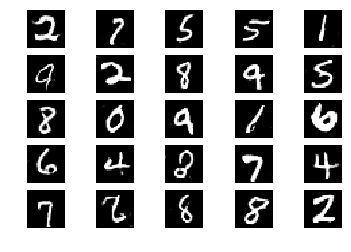

1251 [D loss: 0.530514, acc.: 76.95%] [G loss: 1.013712]
1252 [D loss: 0.635242, acc.: 65.23%] [G loss: 1.144842]
1253 [D loss: 0.767166, acc.: 48.83%] [G loss: 1.394591]
1254 [D loss: 0.662599, acc.: 60.94%] [G loss: 0.998890]
1255 [D loss: 0.554215, acc.: 72.27%] [G loss: 1.121077]
1256 [D loss: 0.655338, acc.: 63.67%] [G loss: 0.954375]
1257 [D loss: 0.656927, acc.: 57.03%] [G loss: 0.993917]
1258 [D loss: 0.564345, acc.: 73.44%] [G loss: 1.005171]
1259 [D loss: 0.527425, acc.: 77.73%] [G loss: 1.193290]
1260 [D loss: 0.659847, acc.: 60.94%] [G loss: 0.841739]
1261 [D loss: 0.552842, acc.: 68.75%] [G loss: 1.118645]
1262 [D loss: 0.549610, acc.: 71.88%] [G loss: 1.144998]
1263 [D loss: 0.698124, acc.: 58.20%] [G loss: 1.002551]
1264 [D loss: 0.714358, acc.: 54.69%] [G loss: 1.190165]
1265 [D loss: 0.536173, acc.: 76.56%] [G loss: 1.270251]
1266 [D loss: 0.590623, acc.: 66.02%] [G loss: 1.131294]
1267 [D loss: 0.707187, acc.: 58.20%] [G loss: 1.341154]
1268 [D loss: 0.717049, acc.: 5

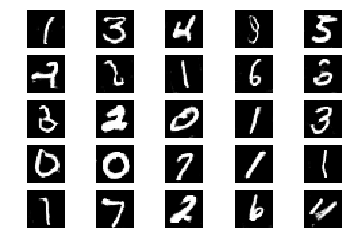

1301 [D loss: 0.510712, acc.: 78.12%] [G loss: 1.167890]
1302 [D loss: 0.593974, acc.: 65.62%] [G loss: 1.164248]
1303 [D loss: 0.843074, acc.: 45.31%] [G loss: 0.885054]
1304 [D loss: 0.509841, acc.: 78.12%] [G loss: 1.253448]
1305 [D loss: 0.671972, acc.: 59.38%] [G loss: 1.103418]
1306 [D loss: 0.785249, acc.: 49.22%] [G loss: 1.234873]
1307 [D loss: 0.745452, acc.: 50.78%] [G loss: 1.250352]
1308 [D loss: 0.618739, acc.: 63.67%] [G loss: 1.173396]
1309 [D loss: 0.590992, acc.: 71.09%] [G loss: 1.396868]
1310 [D loss: 0.620081, acc.: 65.62%] [G loss: 1.252699]
1311 [D loss: 0.586685, acc.: 69.92%] [G loss: 0.984084]
1312 [D loss: 0.671004, acc.: 58.59%] [G loss: 1.145948]
1313 [D loss: 0.665358, acc.: 60.55%] [G loss: 1.205557]
1314 [D loss: 0.654886, acc.: 60.55%] [G loss: 1.386443]
1315 [D loss: 0.670663, acc.: 61.33%] [G loss: 1.110370]
1316 [D loss: 0.546987, acc.: 74.22%] [G loss: 1.281422]
1317 [D loss: 0.732469, acc.: 52.34%] [G loss: 1.130518]
1318 [D loss: 0.570335, acc.: 6

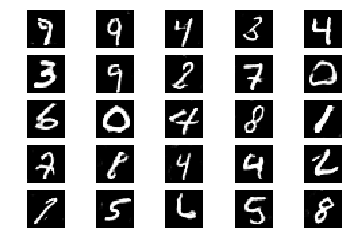

1351 [D loss: 0.497996, acc.: 79.30%] [G loss: 1.074437]
1352 [D loss: 0.570749, acc.: 73.44%] [G loss: 1.246102]
1353 [D loss: 0.482965, acc.: 80.86%] [G loss: 1.155592]
1354 [D loss: 0.563655, acc.: 71.09%] [G loss: 1.299825]
1355 [D loss: 0.632574, acc.: 63.67%] [G loss: 1.232927]
1356 [D loss: 0.525131, acc.: 77.73%] [G loss: 1.254086]
1357 [D loss: 0.501004, acc.: 79.69%] [G loss: 1.072378]
1358 [D loss: 0.688538, acc.: 55.86%] [G loss: 0.845679]
1359 [D loss: 0.537917, acc.: 71.88%] [G loss: 1.148595]
1360 [D loss: 0.753823, acc.: 51.95%] [G loss: 0.993316]
1361 [D loss: 0.617754, acc.: 68.75%] [G loss: 1.444229]
1362 [D loss: 0.533324, acc.: 73.44%] [G loss: 0.986543]
1363 [D loss: 0.516793, acc.: 77.34%] [G loss: 1.115992]
1364 [D loss: 0.624368, acc.: 62.89%] [G loss: 1.184441]
1365 [D loss: 0.595966, acc.: 70.70%] [G loss: 1.224312]
1366 [D loss: 0.686618, acc.: 58.59%] [G loss: 1.431414]
1367 [D loss: 0.673867, acc.: 57.81%] [G loss: 1.091514]
1368 [D loss: 0.690578, acc.: 5

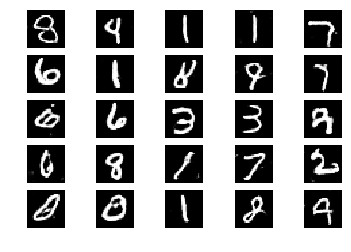

1401 [D loss: 0.577273, acc.: 73.44%] [G loss: 1.035761]
1402 [D loss: 0.803560, acc.: 46.48%] [G loss: 1.337894]
1403 [D loss: 0.685525, acc.: 59.38%] [G loss: 1.190626]
1404 [D loss: 0.644281, acc.: 62.50%] [G loss: 1.224241]
1405 [D loss: 0.500801, acc.: 79.69%] [G loss: 1.334910]
1406 [D loss: 0.684090, acc.: 57.81%] [G loss: 1.170743]
1407 [D loss: 0.607246, acc.: 66.02%] [G loss: 1.068091]
1408 [D loss: 0.692330, acc.: 60.55%] [G loss: 1.328997]
1409 [D loss: 0.666221, acc.: 61.33%] [G loss: 1.027425]
1410 [D loss: 0.561665, acc.: 72.27%] [G loss: 1.102435]
1411 [D loss: 0.641453, acc.: 66.80%] [G loss: 1.070737]
1412 [D loss: 0.629867, acc.: 65.23%] [G loss: 1.351592]
1413 [D loss: 0.728990, acc.: 54.69%] [G loss: 1.374592]
1414 [D loss: 0.618810, acc.: 64.06%] [G loss: 1.173460]
1415 [D loss: 0.653879, acc.: 60.55%] [G loss: 1.176687]
1416 [D loss: 0.682677, acc.: 56.64%] [G loss: 1.134239]
1417 [D loss: 0.635793, acc.: 58.98%] [G loss: 1.055603]
1418 [D loss: 0.617020, acc.: 6

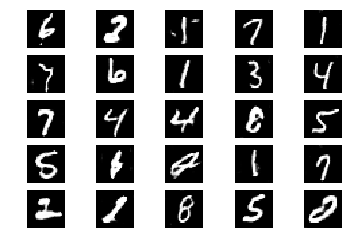

1451 [D loss: 0.646466, acc.: 64.84%] [G loss: 1.061657]
1452 [D loss: 0.676810, acc.: 58.98%] [G loss: 1.016680]
1453 [D loss: 0.574646, acc.: 71.48%] [G loss: 1.208717]
1454 [D loss: 0.639073, acc.: 58.98%] [G loss: 1.218317]
1455 [D loss: 0.799144, acc.: 48.05%] [G loss: 0.891536]
1456 [D loss: 0.602383, acc.: 65.62%] [G loss: 1.060853]
1457 [D loss: 0.707898, acc.: 58.59%] [G loss: 1.201314]
1458 [D loss: 0.499020, acc.: 75.00%] [G loss: 1.261179]
1459 [D loss: 0.531852, acc.: 73.83%] [G loss: 1.312173]
1460 [D loss: 0.621924, acc.: 62.50%] [G loss: 1.203742]
1461 [D loss: 0.694039, acc.: 55.86%] [G loss: 1.134937]
1462 [D loss: 0.724421, acc.: 55.86%] [G loss: 1.116993]
1463 [D loss: 0.632525, acc.: 67.97%] [G loss: 1.111031]
1464 [D loss: 0.556273, acc.: 71.48%] [G loss: 1.226514]
1465 [D loss: 0.648149, acc.: 63.28%] [G loss: 0.996235]
1466 [D loss: 0.557470, acc.: 73.44%] [G loss: 1.233969]
1467 [D loss: 0.631495, acc.: 64.45%] [G loss: 1.125867]
1468 [D loss: 0.786723, acc.: 5

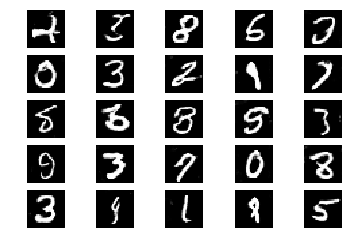

1501 [D loss: 0.432713, acc.: 85.16%] [G loss: 1.240064]
1502 [D loss: 0.551892, acc.: 74.22%] [G loss: 1.158068]
1503 [D loss: 0.598409, acc.: 71.48%] [G loss: 1.130773]
1504 [D loss: 0.556829, acc.: 73.83%] [G loss: 1.376227]
1505 [D loss: 0.651115, acc.: 56.64%] [G loss: 1.250515]
1506 [D loss: 0.512769, acc.: 75.39%] [G loss: 1.428708]
1507 [D loss: 0.850592, acc.: 39.06%] [G loss: 0.967980]
1508 [D loss: 0.714779, acc.: 57.03%] [G loss: 1.166297]
1509 [D loss: 0.838824, acc.: 46.09%] [G loss: 0.957410]
1510 [D loss: 0.622848, acc.: 67.97%] [G loss: 1.243541]
1511 [D loss: 0.494110, acc.: 81.64%] [G loss: 1.401304]
1512 [D loss: 0.547166, acc.: 77.73%] [G loss: 1.241942]
1513 [D loss: 0.580737, acc.: 71.09%] [G loss: 1.026670]
1514 [D loss: 0.496267, acc.: 78.91%] [G loss: 1.184433]
1515 [D loss: 0.578597, acc.: 70.70%] [G loss: 1.170085]
1516 [D loss: 0.684039, acc.: 58.59%] [G loss: 1.200354]
1517 [D loss: 0.550428, acc.: 72.66%] [G loss: 1.204384]
1518 [D loss: 0.759574, acc.: 5

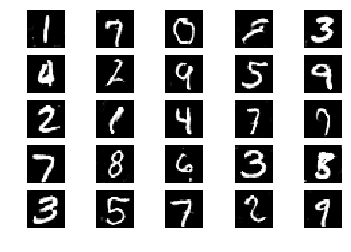

1551 [D loss: 0.538562, acc.: 73.44%] [G loss: 1.262698]
1552 [D loss: 0.623590, acc.: 66.80%] [G loss: 0.981889]
1553 [D loss: 0.544585, acc.: 76.56%] [G loss: 1.004936]
1554 [D loss: 0.630313, acc.: 66.02%] [G loss: 1.142018]
1555 [D loss: 0.769292, acc.: 48.83%] [G loss: 1.009547]
1556 [D loss: 0.505920, acc.: 78.91%] [G loss: 1.295456]
1557 [D loss: 0.601929, acc.: 66.80%] [G loss: 1.512480]
1558 [D loss: 0.670337, acc.: 57.03%] [G loss: 1.172385]
1559 [D loss: 0.495964, acc.: 79.30%] [G loss: 1.293579]
1560 [D loss: 0.476331, acc.: 79.30%] [G loss: 1.425040]
1561 [D loss: 0.709280, acc.: 56.64%] [G loss: 1.091784]
1562 [D loss: 0.563955, acc.: 73.83%] [G loss: 1.159379]
1563 [D loss: 0.661940, acc.: 61.33%] [G loss: 0.996336]
1564 [D loss: 0.598886, acc.: 66.41%] [G loss: 1.014326]
1565 [D loss: 0.626744, acc.: 60.94%] [G loss: 1.113350]
1566 [D loss: 0.655190, acc.: 61.72%] [G loss: 1.193338]
1567 [D loss: 0.721254, acc.: 52.34%] [G loss: 1.076475]
1568 [D loss: 0.507431, acc.: 7

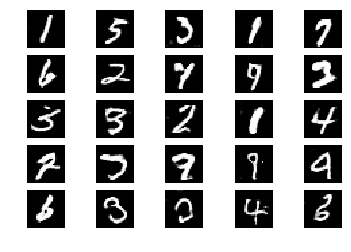

1601 [D loss: 0.660131, acc.: 58.20%] [G loss: 1.215451]
1602 [D loss: 0.701901, acc.: 57.03%] [G loss: 1.097162]
1603 [D loss: 0.566050, acc.: 70.31%] [G loss: 1.437648]
1604 [D loss: 0.517527, acc.: 76.17%] [G loss: 1.231095]
1605 [D loss: 0.602401, acc.: 67.58%] [G loss: 1.142613]
1606 [D loss: 0.669106, acc.: 59.77%] [G loss: 1.073306]
1607 [D loss: 0.825837, acc.: 44.53%] [G loss: 1.075054]
1608 [D loss: 0.525324, acc.: 76.56%] [G loss: 1.292551]
1609 [D loss: 0.707027, acc.: 54.69%] [G loss: 0.995006]
1610 [D loss: 0.592682, acc.: 69.14%] [G loss: 1.067259]
1611 [D loss: 0.649643, acc.: 63.67%] [G loss: 1.246926]
1612 [D loss: 0.696727, acc.: 56.25%] [G loss: 0.981226]
1613 [D loss: 0.560472, acc.: 70.70%] [G loss: 1.215363]
1614 [D loss: 0.533899, acc.: 76.56%] [G loss: 1.128043]
1615 [D loss: 0.743529, acc.: 53.52%] [G loss: 1.258216]
1616 [D loss: 0.601848, acc.: 66.41%] [G loss: 1.265547]
1617 [D loss: 0.569074, acc.: 70.70%] [G loss: 1.253789]
1618 [D loss: 0.608623, acc.: 6

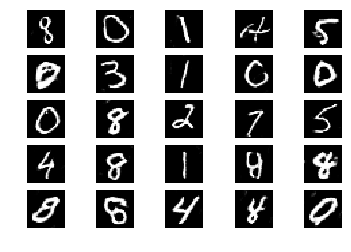

1651 [D loss: 0.591992, acc.: 66.80%] [G loss: 1.237408]
1652 [D loss: 0.737391, acc.: 49.61%] [G loss: 1.094783]
1653 [D loss: 0.496124, acc.: 80.47%] [G loss: 1.167910]
1654 [D loss: 0.682261, acc.: 58.59%] [G loss: 1.070593]
1655 [D loss: 0.548436, acc.: 75.39%] [G loss: 1.182243]
1656 [D loss: 0.777822, acc.: 49.22%] [G loss: 1.044027]
1657 [D loss: 0.572035, acc.: 71.48%] [G loss: 0.998739]
1658 [D loss: 0.520067, acc.: 76.56%] [G loss: 1.044263]
1659 [D loss: 0.696552, acc.: 55.86%] [G loss: 1.208407]
1660 [D loss: 0.699621, acc.: 57.03%] [G loss: 1.090095]
1661 [D loss: 0.629644, acc.: 64.06%] [G loss: 1.008603]
1662 [D loss: 0.648427, acc.: 60.16%] [G loss: 1.108794]
1663 [D loss: 0.641651, acc.: 62.89%] [G loss: 1.108320]
1664 [D loss: 0.503688, acc.: 76.56%] [G loss: 1.321033]
1665 [D loss: 0.721517, acc.: 56.64%] [G loss: 1.469483]
1666 [D loss: 0.595372, acc.: 66.41%] [G loss: 1.082275]
1667 [D loss: 0.624365, acc.: 66.80%] [G loss: 1.358190]
1668 [D loss: 0.660244, acc.: 6

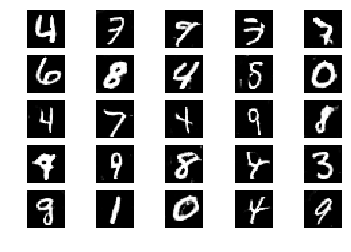

1701 [D loss: 0.684572, acc.: 57.81%] [G loss: 1.054777]
1702 [D loss: 0.613015, acc.: 68.75%] [G loss: 1.182588]
1703 [D loss: 0.615420, acc.: 67.19%] [G loss: 1.167593]
1704 [D loss: 0.780284, acc.: 48.44%] [G loss: 1.048945]
1705 [D loss: 0.640220, acc.: 62.50%] [G loss: 1.019768]
1706 [D loss: 0.637046, acc.: 63.28%] [G loss: 1.036370]
1707 [D loss: 0.536132, acc.: 71.88%] [G loss: 1.145927]
1708 [D loss: 0.539636, acc.: 76.17%] [G loss: 1.228368]
1709 [D loss: 0.777774, acc.: 45.70%] [G loss: 1.098752]
1710 [D loss: 0.576725, acc.: 68.75%] [G loss: 0.995264]
1711 [D loss: 0.574597, acc.: 70.70%] [G loss: 1.161451]
1712 [D loss: 0.626670, acc.: 66.02%] [G loss: 1.148416]
1713 [D loss: 0.644991, acc.: 62.50%] [G loss: 0.998763]
1714 [D loss: 0.620112, acc.: 68.36%] [G loss: 1.050995]
1715 [D loss: 0.604134, acc.: 66.02%] [G loss: 1.134648]
1716 [D loss: 0.609525, acc.: 73.05%] [G loss: 1.145370]
1717 [D loss: 0.578069, acc.: 68.75%] [G loss: 1.309414]
1718 [D loss: 0.614579, acc.: 6

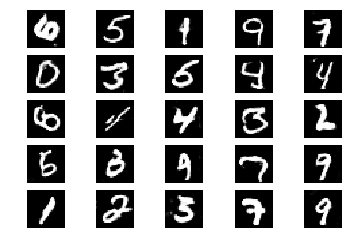

1751 [D loss: 0.561263, acc.: 68.36%] [G loss: 1.354647]
1752 [D loss: 0.548381, acc.: 70.70%] [G loss: 1.165320]
1753 [D loss: 0.576238, acc.: 71.09%] [G loss: 0.782669]
1754 [D loss: 0.621249, acc.: 66.80%] [G loss: 1.020936]
1755 [D loss: 0.442931, acc.: 86.33%] [G loss: 1.178058]
1756 [D loss: 0.614550, acc.: 67.58%] [G loss: 1.299800]
1757 [D loss: 0.647353, acc.: 62.50%] [G loss: 1.041409]
1758 [D loss: 0.607501, acc.: 68.36%] [G loss: 1.239917]
1759 [D loss: 0.671991, acc.: 61.33%] [G loss: 1.078276]
1760 [D loss: 0.657554, acc.: 58.98%] [G loss: 1.171321]
1761 [D loss: 0.741699, acc.: 52.34%] [G loss: 1.195761]
1762 [D loss: 0.521159, acc.: 79.69%] [G loss: 1.078420]
1763 [D loss: 0.591516, acc.: 67.97%] [G loss: 1.096646]
1764 [D loss: 0.621022, acc.: 62.50%] [G loss: 0.970739]
1765 [D loss: 0.627533, acc.: 65.23%] [G loss: 1.191980]
1766 [D loss: 0.649286, acc.: 61.72%] [G loss: 1.116659]
1767 [D loss: 0.602884, acc.: 65.62%] [G loss: 1.149478]
1768 [D loss: 0.625062, acc.: 6

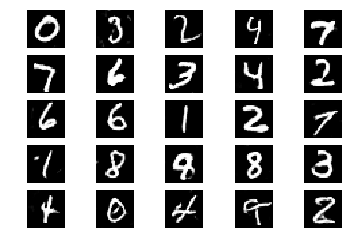

1801 [D loss: 0.633261, acc.: 63.28%] [G loss: 1.133493]
1802 [D loss: 0.559331, acc.: 74.22%] [G loss: 1.288372]
1803 [D loss: 0.654630, acc.: 61.72%] [G loss: 1.130798]
1804 [D loss: 0.640346, acc.: 64.45%] [G loss: 0.991984]
1805 [D loss: 0.524657, acc.: 74.61%] [G loss: 1.329721]
1806 [D loss: 0.525627, acc.: 74.61%] [G loss: 1.137744]
1807 [D loss: 0.645076, acc.: 58.59%] [G loss: 1.283029]
1808 [D loss: 0.579972, acc.: 66.02%] [G loss: 1.335841]
1809 [D loss: 0.677821, acc.: 60.55%] [G loss: 1.125809]
1810 [D loss: 0.480259, acc.: 80.86%] [G loss: 1.382431]
1811 [D loss: 0.518256, acc.: 75.78%] [G loss: 1.178965]
1812 [D loss: 0.578486, acc.: 68.75%] [G loss: 1.101194]
1813 [D loss: 0.564579, acc.: 71.09%] [G loss: 1.277211]
1814 [D loss: 0.609309, acc.: 66.80%] [G loss: 1.450881]
1815 [D loss: 0.833108, acc.: 43.36%] [G loss: 1.264223]
1816 [D loss: 0.602295, acc.: 68.36%] [G loss: 1.223421]
1817 [D loss: 0.555939, acc.: 70.31%] [G loss: 1.090745]
1818 [D loss: 0.585635, acc.: 6

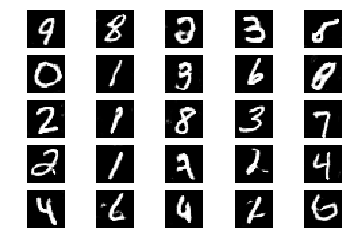

1851 [D loss: 0.728405, acc.: 53.12%] [G loss: 0.954674]
1852 [D loss: 0.658937, acc.: 64.06%] [G loss: 0.953124]
1853 [D loss: 0.630554, acc.: 66.80%] [G loss: 1.320333]
1854 [D loss: 0.616385, acc.: 66.80%] [G loss: 1.104906]
1855 [D loss: 0.593397, acc.: 69.14%] [G loss: 1.271165]
1856 [D loss: 0.543757, acc.: 72.66%] [G loss: 1.302088]
1857 [D loss: 0.595100, acc.: 67.19%] [G loss: 1.228493]
1858 [D loss: 0.753163, acc.: 51.56%] [G loss: 1.356273]
1859 [D loss: 0.574324, acc.: 69.92%] [G loss: 1.420753]
1860 [D loss: 0.606554, acc.: 66.80%] [G loss: 1.049440]
1861 [D loss: 0.603827, acc.: 66.80%] [G loss: 1.034831]
1862 [D loss: 0.785314, acc.: 42.19%] [G loss: 1.201920]
1863 [D loss: 0.592506, acc.: 68.36%] [G loss: 1.437563]
1864 [D loss: 0.581245, acc.: 65.62%] [G loss: 1.111713]
1865 [D loss: 0.568892, acc.: 73.44%] [G loss: 0.900372]
1866 [D loss: 0.581789, acc.: 69.14%] [G loss: 1.198518]
1867 [D loss: 0.611035, acc.: 66.80%] [G loss: 1.112316]
1868 [D loss: 0.586135, acc.: 7

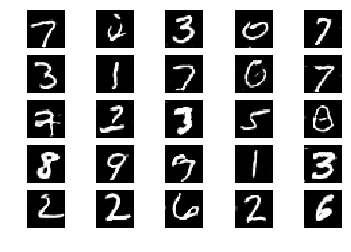

1901 [D loss: 0.471326, acc.: 80.86%] [G loss: 1.016609]
1902 [D loss: 0.566121, acc.: 73.44%] [G loss: 1.045679]
1903 [D loss: 0.626369, acc.: 62.89%] [G loss: 1.160957]
1904 [D loss: 0.560560, acc.: 70.70%] [G loss: 1.315730]
1905 [D loss: 0.476188, acc.: 77.73%] [G loss: 1.115567]
1906 [D loss: 0.551399, acc.: 73.44%] [G loss: 1.207148]
1907 [D loss: 0.685227, acc.: 56.25%] [G loss: 0.916824]
1908 [D loss: 0.597172, acc.: 70.70%] [G loss: 1.032683]
1909 [D loss: 0.584490, acc.: 69.14%] [G loss: 0.810543]
1910 [D loss: 0.564008, acc.: 75.78%] [G loss: 1.319018]
1911 [D loss: 0.657756, acc.: 60.94%] [G loss: 1.084654]
1912 [D loss: 0.527988, acc.: 76.17%] [G loss: 1.212133]
1913 [D loss: 0.567289, acc.: 70.31%] [G loss: 1.212000]
1914 [D loss: 0.665574, acc.: 61.33%] [G loss: 1.167473]
1915 [D loss: 0.581594, acc.: 71.09%] [G loss: 0.892250]
1916 [D loss: 0.645119, acc.: 65.23%] [G loss: 1.131811]
1917 [D loss: 0.726152, acc.: 54.69%] [G loss: 1.365415]
1918 [D loss: 0.648552, acc.: 5

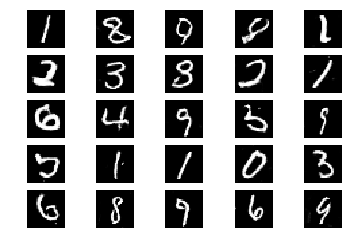

1951 [D loss: 0.506725, acc.: 76.17%] [G loss: 1.217147]
1952 [D loss: 0.607498, acc.: 66.02%] [G loss: 1.178076]
1953 [D loss: 0.725454, acc.: 53.12%] [G loss: 1.145830]
1954 [D loss: 0.687612, acc.: 56.25%] [G loss: 1.139806]
1955 [D loss: 0.703866, acc.: 57.42%] [G loss: 1.102259]
1956 [D loss: 0.670631, acc.: 55.47%] [G loss: 1.113698]
1957 [D loss: 0.770658, acc.: 46.88%] [G loss: 0.897497]
1958 [D loss: 0.692933, acc.: 58.20%] [G loss: 1.018958]
1959 [D loss: 0.548850, acc.: 70.31%] [G loss: 1.067308]
1960 [D loss: 0.666523, acc.: 59.77%] [G loss: 1.158575]
1961 [D loss: 0.561741, acc.: 70.70%] [G loss: 1.091372]
1962 [D loss: 0.606465, acc.: 67.19%] [G loss: 1.049415]
1963 [D loss: 0.609177, acc.: 67.19%] [G loss: 1.359531]
1964 [D loss: 0.542356, acc.: 73.05%] [G loss: 1.074525]
1965 [D loss: 0.641152, acc.: 62.89%] [G loss: 1.070126]
1966 [D loss: 0.603362, acc.: 64.84%] [G loss: 1.014489]
1967 [D loss: 0.554526, acc.: 73.83%] [G loss: 1.373835]
1968 [D loss: 0.608408, acc.: 6

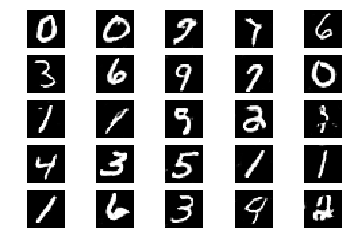

2001 [D loss: 0.603729, acc.: 64.45%] [G loss: 1.216214]
2002 [D loss: 0.517813, acc.: 76.56%] [G loss: 1.129010]
2003 [D loss: 0.761322, acc.: 50.78%] [G loss: 0.911539]
2004 [D loss: 0.463252, acc.: 83.59%] [G loss: 1.015589]
2005 [D loss: 0.606469, acc.: 65.23%] [G loss: 1.249627]
2006 [D loss: 0.533078, acc.: 75.78%] [G loss: 0.995115]
2007 [D loss: 0.641339, acc.: 59.77%] [G loss: 1.141697]
2008 [D loss: 0.616276, acc.: 64.84%] [G loss: 0.998988]
2009 [D loss: 0.616916, acc.: 67.19%] [G loss: 1.071702]
2010 [D loss: 0.684590, acc.: 58.20%] [G loss: 1.007484]
2011 [D loss: 0.745966, acc.: 48.83%] [G loss: 0.957635]
2012 [D loss: 0.746408, acc.: 47.27%] [G loss: 0.997260]
2013 [D loss: 0.569913, acc.: 69.92%] [G loss: 1.173065]
2014 [D loss: 0.552711, acc.: 74.22%] [G loss: 1.269882]
2015 [D loss: 0.524065, acc.: 74.22%] [G loss: 1.103269]
2016 [D loss: 0.712346, acc.: 57.81%] [G loss: 1.136207]
2017 [D loss: 0.635110, acc.: 63.67%] [G loss: 1.275982]
2018 [D loss: 0.566282, acc.: 7

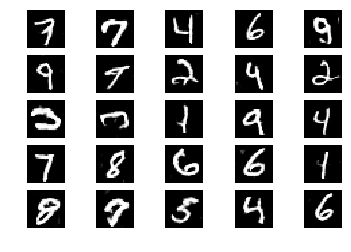

2051 [D loss: 0.690479, acc.: 58.20%] [G loss: 1.091634]
2052 [D loss: 0.593871, acc.: 68.75%] [G loss: 1.172702]
2053 [D loss: 0.716093, acc.: 55.08%] [G loss: 1.301382]
2054 [D loss: 0.732329, acc.: 52.34%] [G loss: 1.252379]
2055 [D loss: 0.585042, acc.: 71.09%] [G loss: 1.092994]
2056 [D loss: 0.787903, acc.: 48.05%] [G loss: 1.226675]
2057 [D loss: 0.642397, acc.: 63.67%] [G loss: 0.927925]
2058 [D loss: 0.586788, acc.: 69.92%] [G loss: 1.311594]
2059 [D loss: 0.650541, acc.: 63.67%] [G loss: 1.482500]
2060 [D loss: 0.723316, acc.: 55.08%] [G loss: 1.110736]
2061 [D loss: 0.521298, acc.: 78.52%] [G loss: 1.182333]
2062 [D loss: 0.671783, acc.: 61.33%] [G loss: 1.057850]
2063 [D loss: 0.703718, acc.: 56.64%] [G loss: 1.195997]
2064 [D loss: 0.580000, acc.: 69.53%] [G loss: 1.182154]
2065 [D loss: 0.497518, acc.: 77.73%] [G loss: 1.288112]
2066 [D loss: 0.557367, acc.: 71.09%] [G loss: 1.191286]
2067 [D loss: 0.564781, acc.: 70.31%] [G loss: 1.392191]
2068 [D loss: 0.561796, acc.: 7

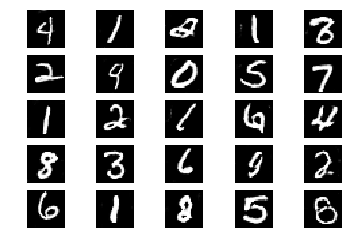

2101 [D loss: 0.560634, acc.: 73.05%] [G loss: 1.198471]
2102 [D loss: 0.748913, acc.: 53.12%] [G loss: 1.278382]
2103 [D loss: 0.656721, acc.: 61.72%] [G loss: 1.139622]
2104 [D loss: 0.638059, acc.: 62.11%] [G loss: 1.394613]
2105 [D loss: 0.538522, acc.: 73.83%] [G loss: 1.123508]
2106 [D loss: 0.598538, acc.: 67.58%] [G loss: 1.257952]
2107 [D loss: 0.658993, acc.: 63.67%] [G loss: 1.241294]
2108 [D loss: 0.629949, acc.: 62.50%] [G loss: 1.195439]
2109 [D loss: 0.728924, acc.: 56.25%] [G loss: 0.948681]
2110 [D loss: 0.668108, acc.: 57.81%] [G loss: 0.940029]
2111 [D loss: 0.737917, acc.: 51.17%] [G loss: 0.969070]
2112 [D loss: 0.673361, acc.: 58.59%] [G loss: 1.123007]
2113 [D loss: 0.499750, acc.: 78.91%] [G loss: 1.232163]
2114 [D loss: 0.767501, acc.: 53.12%] [G loss: 0.972561]
2115 [D loss: 0.599588, acc.: 64.84%] [G loss: 1.054958]
2116 [D loss: 0.613017, acc.: 70.70%] [G loss: 1.094870]
2117 [D loss: 0.477534, acc.: 77.73%] [G loss: 1.382030]
2118 [D loss: 0.545761, acc.: 7

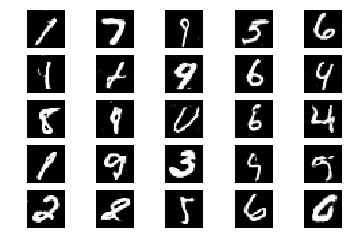

2151 [D loss: 0.749262, acc.: 53.91%] [G loss: 1.011702]
2152 [D loss: 0.460874, acc.: 82.81%] [G loss: 1.221754]
2153 [D loss: 0.629400, acc.: 64.06%] [G loss: 1.061543]
2154 [D loss: 0.510874, acc.: 78.12%] [G loss: 0.941622]
2155 [D loss: 0.586450, acc.: 70.31%] [G loss: 1.262888]
2156 [D loss: 0.625284, acc.: 69.14%] [G loss: 1.229541]
2157 [D loss: 0.572608, acc.: 73.44%] [G loss: 1.043002]
2158 [D loss: 0.607985, acc.: 67.19%] [G loss: 0.923449]
2159 [D loss: 0.586981, acc.: 68.75%] [G loss: 1.301796]
2160 [D loss: 0.554369, acc.: 68.75%] [G loss: 1.489440]
2161 [D loss: 0.599718, acc.: 68.36%] [G loss: 1.093160]
2162 [D loss: 0.582318, acc.: 69.14%] [G loss: 1.034056]
2163 [D loss: 0.793138, acc.: 47.27%] [G loss: 0.964501]
2164 [D loss: 0.609878, acc.: 63.67%] [G loss: 1.147784]
2165 [D loss: 0.596537, acc.: 67.58%] [G loss: 1.110651]
2166 [D loss: 0.628640, acc.: 66.02%] [G loss: 1.340375]
2167 [D loss: 0.587734, acc.: 66.80%] [G loss: 1.078179]
2168 [D loss: 0.634437, acc.: 6

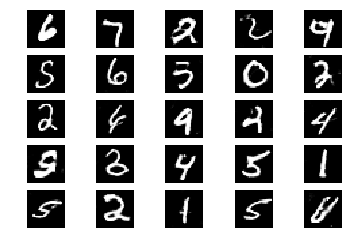

2201 [D loss: 0.660678, acc.: 63.28%] [G loss: 1.167357]
2202 [D loss: 0.649443, acc.: 57.81%] [G loss: 1.178466]
2203 [D loss: 0.667354, acc.: 61.72%] [G loss: 1.232429]
2204 [D loss: 0.629214, acc.: 62.50%] [G loss: 0.922105]
2205 [D loss: 0.566186, acc.: 71.48%] [G loss: 1.036301]
2206 [D loss: 0.670181, acc.: 58.59%] [G loss: 0.852701]
2207 [D loss: 0.616489, acc.: 61.72%] [G loss: 1.310672]
2208 [D loss: 0.746323, acc.: 50.78%] [G loss: 1.080933]
2209 [D loss: 0.626993, acc.: 65.23%] [G loss: 0.977117]
2210 [D loss: 0.634049, acc.: 67.19%] [G loss: 1.121435]
2211 [D loss: 0.663359, acc.: 63.67%] [G loss: 0.930817]
2212 [D loss: 0.484103, acc.: 76.56%] [G loss: 1.167108]
2213 [D loss: 0.585797, acc.: 71.09%] [G loss: 1.218483]
2214 [D loss: 0.647623, acc.: 64.06%] [G loss: 1.179276]
2215 [D loss: 0.631526, acc.: 67.19%] [G loss: 1.083561]
2216 [D loss: 0.613111, acc.: 67.58%] [G loss: 0.920989]
2217 [D loss: 0.572455, acc.: 66.41%] [G loss: 1.505641]
2218 [D loss: 0.575832, acc.: 7

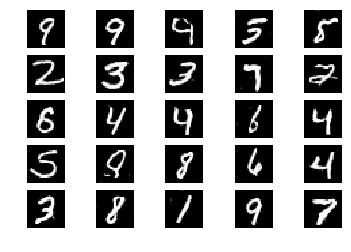

2251 [D loss: 0.695021, acc.: 57.42%] [G loss: 1.085369]
2252 [D loss: 0.675878, acc.: 56.64%] [G loss: 0.999282]
2253 [D loss: 0.582426, acc.: 69.53%] [G loss: 1.092345]
2254 [D loss: 0.621242, acc.: 65.23%] [G loss: 1.338302]
2255 [D loss: 0.632108, acc.: 65.62%] [G loss: 1.149294]
2256 [D loss: 0.744841, acc.: 53.52%] [G loss: 1.153158]
2257 [D loss: 0.680526, acc.: 58.98%] [G loss: 1.185973]
2258 [D loss: 0.555915, acc.: 74.61%] [G loss: 1.189117]
2259 [D loss: 0.576878, acc.: 69.92%] [G loss: 1.111522]
2260 [D loss: 0.738368, acc.: 53.12%] [G loss: 1.302687]
2261 [D loss: 0.559850, acc.: 74.61%] [G loss: 1.244090]
2262 [D loss: 0.768804, acc.: 51.95%] [G loss: 1.336740]
2263 [D loss: 0.540840, acc.: 73.83%] [G loss: 1.506427]
2264 [D loss: 0.510624, acc.: 75.78%] [G loss: 1.269167]
2265 [D loss: 0.535430, acc.: 72.66%] [G loss: 1.195718]
2266 [D loss: 0.641466, acc.: 62.11%] [G loss: 1.331549]
2267 [D loss: 0.670930, acc.: 61.33%] [G loss: 0.984356]
2268 [D loss: 0.546977, acc.: 7

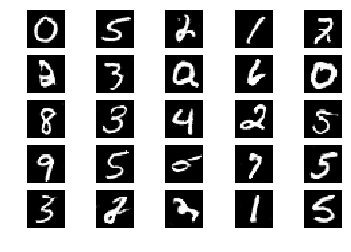

2301 [D loss: 0.485024, acc.: 77.34%] [G loss: 1.029979]
2302 [D loss: 0.685320, acc.: 57.42%] [G loss: 1.432339]
2303 [D loss: 0.472198, acc.: 81.25%] [G loss: 1.340051]
2304 [D loss: 0.710335, acc.: 53.52%] [G loss: 0.991381]
2305 [D loss: 0.591020, acc.: 69.14%] [G loss: 1.335120]
2306 [D loss: 0.627500, acc.: 62.89%] [G loss: 1.065104]
2307 [D loss: 0.687461, acc.: 58.98%] [G loss: 1.206057]
2308 [D loss: 0.636071, acc.: 60.55%] [G loss: 1.114368]
2309 [D loss: 0.721212, acc.: 57.42%] [G loss: 1.181052]
2310 [D loss: 0.553340, acc.: 75.00%] [G loss: 1.143714]
2311 [D loss: 0.557674, acc.: 75.78%] [G loss: 1.301614]
2312 [D loss: 0.700193, acc.: 57.03%] [G loss: 1.357255]
2313 [D loss: 0.757252, acc.: 49.61%] [G loss: 1.228877]
2314 [D loss: 0.643109, acc.: 63.28%] [G loss: 1.302021]
2315 [D loss: 0.540017, acc.: 73.44%] [G loss: 1.430010]
2316 [D loss: 0.750786, acc.: 52.73%] [G loss: 1.135687]
2317 [D loss: 0.612272, acc.: 67.97%] [G loss: 1.081287]
2318 [D loss: 0.549518, acc.: 6

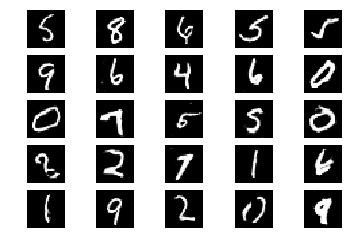

2351 [D loss: 0.667149, acc.: 58.20%] [G loss: 1.163609]
2352 [D loss: 0.585439, acc.: 70.31%] [G loss: 1.302410]
2353 [D loss: 0.710442, acc.: 56.25%] [G loss: 1.080372]
2354 [D loss: 0.521506, acc.: 73.05%] [G loss: 1.038119]
2355 [D loss: 0.635289, acc.: 61.72%] [G loss: 0.844826]
2356 [D loss: 0.620790, acc.: 66.80%] [G loss: 1.175077]
2357 [D loss: 0.695830, acc.: 56.25%] [G loss: 1.053137]
2358 [D loss: 0.709330, acc.: 55.47%] [G loss: 0.861109]
2359 [D loss: 0.620014, acc.: 67.19%] [G loss: 1.126383]
2360 [D loss: 0.751124, acc.: 52.34%] [G loss: 1.097516]
2361 [D loss: 0.551067, acc.: 72.27%] [G loss: 0.932002]
2362 [D loss: 0.607842, acc.: 66.80%] [G loss: 1.278382]
2363 [D loss: 0.640076, acc.: 63.67%] [G loss: 1.024111]
2364 [D loss: 0.636346, acc.: 63.28%] [G loss: 0.920185]
2365 [D loss: 0.541740, acc.: 72.66%] [G loss: 1.242231]
2366 [D loss: 0.670870, acc.: 58.98%] [G loss: 1.363181]
2367 [D loss: 0.607932, acc.: 67.58%] [G loss: 1.346199]
2368 [D loss: 0.533301, acc.: 7

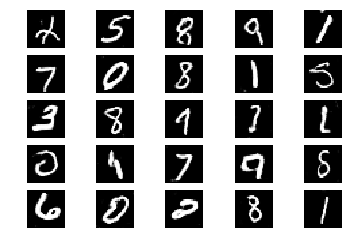

2401 [D loss: 0.656704, acc.: 57.81%] [G loss: 1.099092]
2402 [D loss: 0.736559, acc.: 48.83%] [G loss: 0.994043]
2403 [D loss: 0.638084, acc.: 62.89%] [G loss: 0.804698]
2404 [D loss: 0.611398, acc.: 67.58%] [G loss: 1.001127]
2405 [D loss: 0.605701, acc.: 68.75%] [G loss: 1.284281]
2406 [D loss: 0.595662, acc.: 69.14%] [G loss: 1.028722]
2407 [D loss: 0.533712, acc.: 73.83%] [G loss: 1.231482]
2408 [D loss: 0.599058, acc.: 64.84%] [G loss: 1.090591]
2409 [D loss: 0.646322, acc.: 61.33%] [G loss: 0.945179]
2410 [D loss: 0.670638, acc.: 56.64%] [G loss: 0.914314]
2411 [D loss: 0.623326, acc.: 66.41%] [G loss: 1.118505]
2412 [D loss: 0.848123, acc.: 41.41%] [G loss: 0.998302]
2413 [D loss: 0.625306, acc.: 64.45%] [G loss: 1.189532]
2414 [D loss: 0.742722, acc.: 51.56%] [G loss: 1.254210]
2415 [D loss: 0.746705, acc.: 48.44%] [G loss: 0.921062]
2416 [D loss: 0.617902, acc.: 65.62%] [G loss: 0.904790]
2417 [D loss: 0.520424, acc.: 77.73%] [G loss: 1.312921]
2418 [D loss: 0.638193, acc.: 6

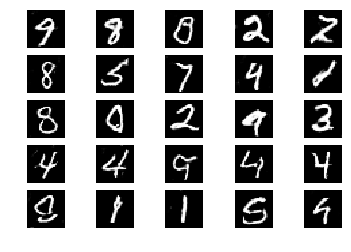

2451 [D loss: 0.715586, acc.: 56.25%] [G loss: 1.301674]
2452 [D loss: 0.611055, acc.: 66.80%] [G loss: 1.109192]
2453 [D loss: 0.665645, acc.: 65.23%] [G loss: 1.285841]
2454 [D loss: 0.614848, acc.: 66.02%] [G loss: 1.403636]
2455 [D loss: 0.776846, acc.: 48.05%] [G loss: 1.067767]
2456 [D loss: 0.572833, acc.: 74.22%] [G loss: 1.192953]
2457 [D loss: 0.588177, acc.: 68.36%] [G loss: 1.206660]
2458 [D loss: 0.571818, acc.: 70.70%] [G loss: 1.000406]
2459 [D loss: 0.539567, acc.: 76.95%] [G loss: 1.251377]
2460 [D loss: 0.539245, acc.: 74.22%] [G loss: 1.049740]
2461 [D loss: 0.533165, acc.: 73.83%] [G loss: 1.032365]
2462 [D loss: 0.570423, acc.: 68.75%] [G loss: 1.272810]
2463 [D loss: 0.530931, acc.: 75.78%] [G loss: 1.274511]
2464 [D loss: 0.577787, acc.: 67.58%] [G loss: 0.858714]
2465 [D loss: 0.537888, acc.: 73.44%] [G loss: 1.234413]
2466 [D loss: 0.671825, acc.: 60.94%] [G loss: 1.003448]
2467 [D loss: 0.692310, acc.: 59.77%] [G loss: 1.033813]
2468 [D loss: 0.553830, acc.: 7

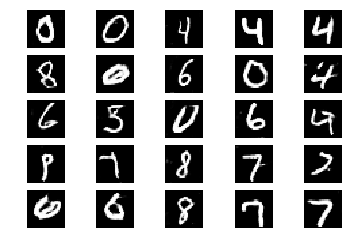

2501 [D loss: 0.619565, acc.: 64.45%] [G loss: 1.289905]
2502 [D loss: 0.553878, acc.: 72.27%] [G loss: 0.777048]
2503 [D loss: 0.640111, acc.: 60.55%] [G loss: 1.045095]
2504 [D loss: 0.646429, acc.: 64.84%] [G loss: 1.068098]
2505 [D loss: 0.717129, acc.: 55.47%] [G loss: 0.826133]
2506 [D loss: 0.539010, acc.: 75.78%] [G loss: 1.233614]
2507 [D loss: 0.718697, acc.: 55.47%] [G loss: 1.211842]
2508 [D loss: 0.609543, acc.: 67.97%] [G loss: 1.117052]
2509 [D loss: 0.532517, acc.: 75.78%] [G loss: 0.971444]
2510 [D loss: 0.627521, acc.: 64.45%] [G loss: 1.224363]
2511 [D loss: 0.611717, acc.: 60.94%] [G loss: 1.061790]
2512 [D loss: 0.607896, acc.: 66.02%] [G loss: 1.100036]
2513 [D loss: 0.714277, acc.: 54.69%] [G loss: 1.135939]
2514 [D loss: 0.732602, acc.: 51.17%] [G loss: 1.266791]
2515 [D loss: 0.584386, acc.: 72.27%] [G loss: 1.185562]
2516 [D loss: 0.772755, acc.: 51.95%] [G loss: 1.153700]
2517 [D loss: 0.674531, acc.: 59.38%] [G loss: 1.094644]
2518 [D loss: 0.608995, acc.: 6

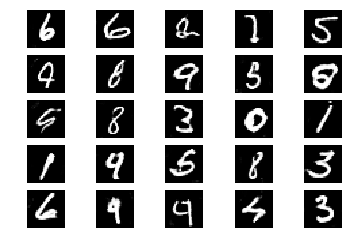

2551 [D loss: 0.541913, acc.: 75.00%] [G loss: 0.932837]
2552 [D loss: 0.683779, acc.: 58.98%] [G loss: 1.297564]
2553 [D loss: 0.551981, acc.: 71.48%] [G loss: 1.122024]
2554 [D loss: 0.728238, acc.: 54.69%] [G loss: 1.173979]
2555 [D loss: 0.566391, acc.: 71.09%] [G loss: 1.213265]
2556 [D loss: 0.647967, acc.: 61.72%] [G loss: 1.068402]
2557 [D loss: 0.574385, acc.: 73.44%] [G loss: 0.988885]
2558 [D loss: 0.604983, acc.: 67.97%] [G loss: 1.171708]
2559 [D loss: 0.731376, acc.: 53.91%] [G loss: 1.142300]
2560 [D loss: 0.622348, acc.: 64.45%] [G loss: 1.061177]
2561 [D loss: 0.598451, acc.: 66.41%] [G loss: 1.296189]
2562 [D loss: 0.619792, acc.: 66.41%] [G loss: 1.394505]
2563 [D loss: 0.500053, acc.: 77.73%] [G loss: 1.105815]
2564 [D loss: 0.642205, acc.: 62.89%] [G loss: 1.042443]
2565 [D loss: 0.564347, acc.: 72.66%] [G loss: 1.319287]
2566 [D loss: 0.515889, acc.: 75.39%] [G loss: 1.208684]
2567 [D loss: 0.464078, acc.: 81.25%] [G loss: 1.314189]
2568 [D loss: 0.679647, acc.: 5

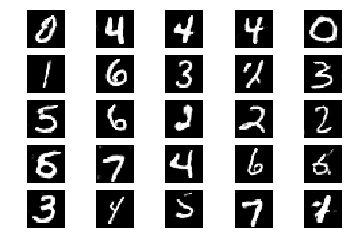

2601 [D loss: 0.720453, acc.: 54.30%] [G loss: 1.486475]
2602 [D loss: 0.728101, acc.: 51.17%] [G loss: 1.055458]
2603 [D loss: 0.576424, acc.: 69.14%] [G loss: 1.131249]
2604 [D loss: 0.715059, acc.: 55.08%] [G loss: 1.064003]
2605 [D loss: 0.641281, acc.: 64.45%] [G loss: 1.374226]
2606 [D loss: 0.556538, acc.: 73.44%] [G loss: 1.466787]
2607 [D loss: 0.651625, acc.: 62.11%] [G loss: 1.155945]
2608 [D loss: 0.753916, acc.: 51.56%] [G loss: 1.184487]
2609 [D loss: 0.546500, acc.: 74.61%] [G loss: 0.911057]
2610 [D loss: 0.739435, acc.: 53.52%] [G loss: 1.023006]
2611 [D loss: 0.717838, acc.: 56.25%] [G loss: 1.212625]
2612 [D loss: 0.561507, acc.: 71.88%] [G loss: 1.193392]
2613 [D loss: 0.703219, acc.: 56.25%] [G loss: 1.077483]
2614 [D loss: 0.546939, acc.: 73.44%] [G loss: 1.070271]
2615 [D loss: 0.576719, acc.: 71.09%] [G loss: 1.165935]
2616 [D loss: 0.665829, acc.: 56.64%] [G loss: 1.034137]
2617 [D loss: 0.701125, acc.: 58.20%] [G loss: 1.078188]
2618 [D loss: 0.567073, acc.: 7

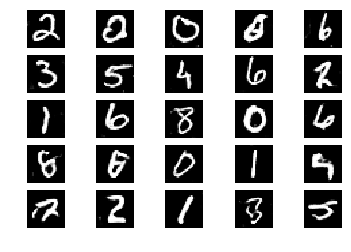

2651 [D loss: 0.621034, acc.: 63.28%] [G loss: 1.124672]
2652 [D loss: 0.571100, acc.: 69.53%] [G loss: 1.177637]
2653 [D loss: 0.708945, acc.: 56.25%] [G loss: 1.019692]
2654 [D loss: 0.567007, acc.: 74.22%] [G loss: 1.215105]
2655 [D loss: 0.610304, acc.: 66.02%] [G loss: 1.172280]
2656 [D loss: 0.632214, acc.: 62.50%] [G loss: 1.104455]
2657 [D loss: 0.541540, acc.: 73.44%] [G loss: 1.316743]
2658 [D loss: 0.629093, acc.: 64.45%] [G loss: 1.254157]
2659 [D loss: 0.792478, acc.: 49.22%] [G loss: 1.052467]
2660 [D loss: 0.721028, acc.: 50.00%] [G loss: 1.342693]
2661 [D loss: 0.662317, acc.: 59.77%] [G loss: 1.222520]
2662 [D loss: 0.605460, acc.: 67.97%] [G loss: 1.007162]
2663 [D loss: 0.598721, acc.: 67.19%] [G loss: 1.125983]
2664 [D loss: 0.724429, acc.: 53.12%] [G loss: 1.244517]
2665 [D loss: 0.623828, acc.: 66.41%] [G loss: 1.121643]
2666 [D loss: 0.682658, acc.: 55.08%] [G loss: 1.131631]
2667 [D loss: 0.526771, acc.: 72.27%] [G loss: 1.225535]
2668 [D loss: 0.608716, acc.: 6

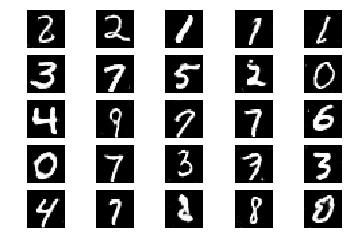

2701 [D loss: 0.594330, acc.: 65.23%] [G loss: 1.066845]
2702 [D loss: 0.590489, acc.: 68.36%] [G loss: 1.252521]
2703 [D loss: 0.684480, acc.: 58.59%] [G loss: 1.300524]
2704 [D loss: 0.618764, acc.: 65.23%] [G loss: 1.217814]
2705 [D loss: 0.854832, acc.: 40.23%] [G loss: 0.854813]
2706 [D loss: 0.668587, acc.: 61.33%] [G loss: 1.272712]
2707 [D loss: 0.797554, acc.: 47.66%] [G loss: 0.864422]
2708 [D loss: 0.649162, acc.: 59.38%] [G loss: 1.122657]
2709 [D loss: 0.606670, acc.: 68.36%] [G loss: 1.224921]
2710 [D loss: 0.571761, acc.: 71.88%] [G loss: 1.079231]
2711 [D loss: 0.602821, acc.: 70.70%] [G loss: 1.138466]
2712 [D loss: 0.672036, acc.: 62.11%] [G loss: 1.300197]
2713 [D loss: 0.640656, acc.: 62.50%] [G loss: 1.342839]
2714 [D loss: 0.681484, acc.: 57.03%] [G loss: 1.168326]
2715 [D loss: 0.537372, acc.: 74.22%] [G loss: 1.098299]
2716 [D loss: 0.644164, acc.: 63.67%] [G loss: 1.057079]
2717 [D loss: 0.756035, acc.: 48.44%] [G loss: 0.990088]
2718 [D loss: 0.563834, acc.: 7

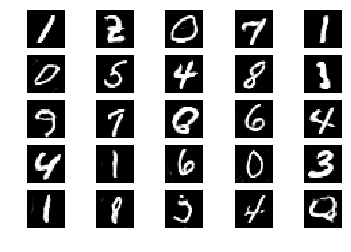

2751 [D loss: 0.765519, acc.: 51.17%] [G loss: 0.964631]
2752 [D loss: 0.593770, acc.: 70.70%] [G loss: 1.109359]
2753 [D loss: 0.544083, acc.: 72.27%] [G loss: 1.196891]
2754 [D loss: 0.673749, acc.: 58.59%] [G loss: 1.167348]
2755 [D loss: 0.735389, acc.: 53.12%] [G loss: 1.359012]
2756 [D loss: 0.548266, acc.: 75.00%] [G loss: 1.192811]
2757 [D loss: 0.754609, acc.: 48.83%] [G loss: 1.101032]
2758 [D loss: 0.685810, acc.: 62.50%] [G loss: 0.810195]
2759 [D loss: 0.637039, acc.: 64.06%] [G loss: 1.302964]
2760 [D loss: 0.785397, acc.: 45.70%] [G loss: 1.175543]
2761 [D loss: 0.615326, acc.: 67.97%] [G loss: 1.257573]
2762 [D loss: 0.677038, acc.: 63.28%] [G loss: 1.395404]
2763 [D loss: 0.636170, acc.: 64.06%] [G loss: 1.368863]
2764 [D loss: 0.599860, acc.: 65.23%] [G loss: 1.292852]
2765 [D loss: 0.700622, acc.: 55.47%] [G loss: 1.034719]
2766 [D loss: 0.703932, acc.: 57.81%] [G loss: 1.222026]
2767 [D loss: 0.631695, acc.: 64.45%] [G loss: 0.862725]
2768 [D loss: 0.632443, acc.: 6

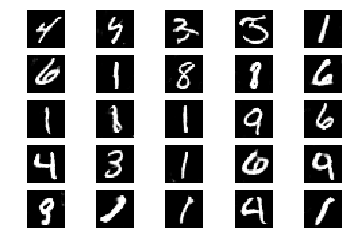

2801 [D loss: 0.627492, acc.: 65.23%] [G loss: 1.111119]
2802 [D loss: 0.553323, acc.: 75.00%] [G loss: 0.976439]
2803 [D loss: 0.598140, acc.: 67.58%] [G loss: 1.168016]
2804 [D loss: 0.640366, acc.: 62.50%] [G loss: 0.909149]
2805 [D loss: 0.649591, acc.: 64.45%] [G loss: 1.359717]
2806 [D loss: 0.685195, acc.: 58.59%] [G loss: 1.156849]
2807 [D loss: 0.551327, acc.: 74.61%] [G loss: 1.073030]
2808 [D loss: 0.597924, acc.: 68.75%] [G loss: 0.909729]
2809 [D loss: 0.742136, acc.: 55.86%] [G loss: 1.102183]
2810 [D loss: 0.548399, acc.: 73.05%] [G loss: 1.033137]
2811 [D loss: 0.712395, acc.: 57.42%] [G loss: 1.008572]
2812 [D loss: 0.623415, acc.: 60.94%] [G loss: 1.150545]
2813 [D loss: 0.620060, acc.: 65.62%] [G loss: 1.097136]
2814 [D loss: 0.560285, acc.: 72.66%] [G loss: 1.120170]
2815 [D loss: 0.688665, acc.: 57.42%] [G loss: 0.789943]
2816 [D loss: 0.721902, acc.: 54.69%] [G loss: 0.930491]
2817 [D loss: 0.702991, acc.: 55.86%] [G loss: 1.384697]
2818 [D loss: 0.644094, acc.: 6

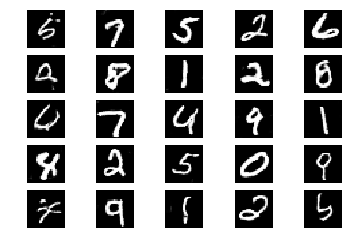

2851 [D loss: 0.555770, acc.: 73.44%] [G loss: 0.826226]
2852 [D loss: 0.518007, acc.: 77.73%] [G loss: 1.329798]
2853 [D loss: 0.539803, acc.: 77.73%] [G loss: 1.078617]
2854 [D loss: 0.535519, acc.: 72.27%] [G loss: 1.143570]
2855 [D loss: 0.621780, acc.: 66.02%] [G loss: 0.947553]
2856 [D loss: 0.692780, acc.: 57.03%] [G loss: 1.184977]
2857 [D loss: 0.522526, acc.: 75.78%] [G loss: 1.261993]
2858 [D loss: 0.767781, acc.: 47.66%] [G loss: 0.803059]
2859 [D loss: 0.582160, acc.: 67.58%] [G loss: 1.046721]
2860 [D loss: 0.482297, acc.: 81.64%] [G loss: 1.075307]
2861 [D loss: 0.689720, acc.: 60.94%] [G loss: 1.135671]
2862 [D loss: 0.566595, acc.: 70.70%] [G loss: 1.149847]
2863 [D loss: 0.624953, acc.: 68.36%] [G loss: 0.928869]
2864 [D loss: 0.549021, acc.: 74.22%] [G loss: 1.056097]
2865 [D loss: 0.707138, acc.: 55.47%] [G loss: 1.054246]
2866 [D loss: 0.530023, acc.: 72.66%] [G loss: 1.468758]
2867 [D loss: 0.773867, acc.: 48.05%] [G loss: 0.848917]
2868 [D loss: 0.575390, acc.: 7

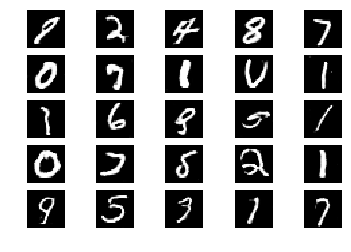

2901 [D loss: 0.741481, acc.: 53.12%] [G loss: 0.842348]
2902 [D loss: 0.507973, acc.: 77.73%] [G loss: 1.242424]
2903 [D loss: 0.616025, acc.: 67.97%] [G loss: 1.288188]
2904 [D loss: 0.585616, acc.: 69.14%] [G loss: 1.250864]
2905 [D loss: 0.573937, acc.: 73.44%] [G loss: 1.306443]
2906 [D loss: 0.628743, acc.: 62.11%] [G loss: 1.322632]
2907 [D loss: 0.618749, acc.: 62.11%] [G loss: 0.853533]
2908 [D loss: 0.608943, acc.: 68.36%] [G loss: 1.125250]
2909 [D loss: 0.815145, acc.: 45.70%] [G loss: 0.946529]
2910 [D loss: 0.756403, acc.: 47.66%] [G loss: 1.030823]
2911 [D loss: 0.706859, acc.: 55.08%] [G loss: 0.998229]
2912 [D loss: 0.559199, acc.: 71.48%] [G loss: 1.288804]
2913 [D loss: 0.666259, acc.: 60.55%] [G loss: 1.234734]
2914 [D loss: 0.518183, acc.: 79.30%] [G loss: 1.245788]
2915 [D loss: 0.518639, acc.: 76.56%] [G loss: 1.496627]
2916 [D loss: 0.747757, acc.: 53.91%] [G loss: 0.969500]
2917 [D loss: 0.639496, acc.: 64.45%] [G loss: 0.925234]
2918 [D loss: 0.403827, acc.: 8

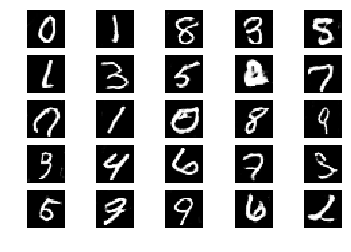

2951 [D loss: 0.590493, acc.: 67.58%] [G loss: 1.291012]
2952 [D loss: 0.698729, acc.: 60.16%] [G loss: 1.085801]
2953 [D loss: 0.520226, acc.: 73.05%] [G loss: 1.223740]
2954 [D loss: 0.654675, acc.: 61.72%] [G loss: 1.026019]
2955 [D loss: 0.539460, acc.: 75.00%] [G loss: 1.267089]
2956 [D loss: 0.586405, acc.: 70.70%] [G loss: 0.953493]
2957 [D loss: 0.668676, acc.: 59.38%] [G loss: 0.979763]
2958 [D loss: 0.580261, acc.: 68.36%] [G loss: 1.259870]
2959 [D loss: 0.545261, acc.: 74.22%] [G loss: 1.227656]
2960 [D loss: 0.664841, acc.: 58.98%] [G loss: 1.363613]
2961 [D loss: 0.800577, acc.: 47.27%] [G loss: 1.026662]
2962 [D loss: 0.681875, acc.: 60.16%] [G loss: 1.128043]
2963 [D loss: 0.667485, acc.: 62.50%] [G loss: 0.997695]
2964 [D loss: 0.621642, acc.: 64.45%] [G loss: 1.147276]
2965 [D loss: 0.627368, acc.: 65.62%] [G loss: 1.137376]
2966 [D loss: 0.475735, acc.: 82.03%] [G loss: 1.109833]
2967 [D loss: 0.610747, acc.: 66.41%] [G loss: 1.106843]
2968 [D loss: 0.502124, acc.: 7

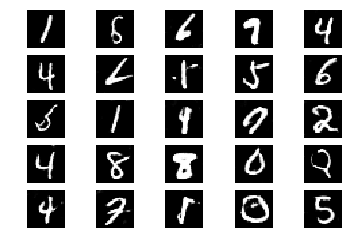

3001 [D loss: 0.472261, acc.: 82.42%] [G loss: 1.289581]
3002 [D loss: 0.512180, acc.: 78.12%] [G loss: 1.247640]
3003 [D loss: 0.610407, acc.: 64.45%] [G loss: 1.443801]
3004 [D loss: 0.633299, acc.: 62.11%] [G loss: 1.018035]
3005 [D loss: 0.556884, acc.: 71.09%] [G loss: 1.183407]
3006 [D loss: 0.668782, acc.: 61.72%] [G loss: 1.208266]
3007 [D loss: 0.541766, acc.: 77.73%] [G loss: 1.175097]
3008 [D loss: 0.654442, acc.: 64.06%] [G loss: 0.957124]
3009 [D loss: 0.575639, acc.: 69.14%] [G loss: 1.353143]
3010 [D loss: 0.508070, acc.: 79.30%] [G loss: 1.361739]
3011 [D loss: 0.731580, acc.: 54.30%] [G loss: 1.343220]
3012 [D loss: 0.582396, acc.: 68.75%] [G loss: 1.217673]
3013 [D loss: 0.520068, acc.: 75.00%] [G loss: 1.306300]
3014 [D loss: 0.672426, acc.: 57.42%] [G loss: 1.231686]
3015 [D loss: 0.614510, acc.: 62.89%] [G loss: 1.123764]
3016 [D loss: 0.610088, acc.: 68.36%] [G loss: 1.163254]
3017 [D loss: 0.565308, acc.: 73.05%] [G loss: 1.259137]
3018 [D loss: 0.720982, acc.: 5

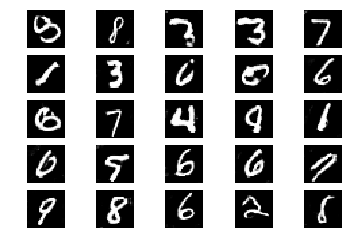

3051 [D loss: 0.630520, acc.: 63.28%] [G loss: 0.907415]
3052 [D loss: 0.536354, acc.: 74.61%] [G loss: 1.234144]
3053 [D loss: 0.562991, acc.: 73.05%] [G loss: 0.979305]
3054 [D loss: 0.598378, acc.: 67.58%] [G loss: 1.001264]
3055 [D loss: 0.611933, acc.: 66.41%] [G loss: 1.045578]
3056 [D loss: 0.533814, acc.: 78.52%] [G loss: 1.112532]
3057 [D loss: 0.627987, acc.: 67.97%] [G loss: 1.168807]
3058 [D loss: 0.594417, acc.: 68.75%] [G loss: 1.480213]
3059 [D loss: 0.679524, acc.: 59.77%] [G loss: 0.937260]
3060 [D loss: 0.668368, acc.: 60.94%] [G loss: 1.156783]
3061 [D loss: 0.698657, acc.: 58.20%] [G loss: 0.948658]
3062 [D loss: 0.663245, acc.: 58.98%] [G loss: 1.098691]
3063 [D loss: 0.615152, acc.: 66.41%] [G loss: 1.238948]
3064 [D loss: 0.566481, acc.: 73.05%] [G loss: 1.257174]
3065 [D loss: 0.556343, acc.: 73.83%] [G loss: 1.270979]
3066 [D loss: 0.540646, acc.: 76.95%] [G loss: 0.947624]
3067 [D loss: 0.670865, acc.: 58.20%] [G loss: 0.845378]
3068 [D loss: 0.705383, acc.: 5

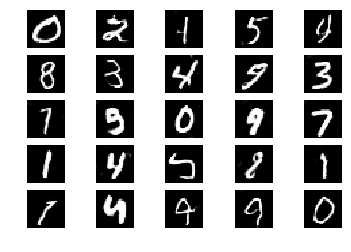

3101 [D loss: 0.485190, acc.: 83.20%] [G loss: 1.195271]
3102 [D loss: 0.607961, acc.: 60.94%] [G loss: 1.075911]
3103 [D loss: 0.561964, acc.: 71.48%] [G loss: 1.036248]
3104 [D loss: 0.586349, acc.: 69.92%] [G loss: 0.973432]
3105 [D loss: 0.517104, acc.: 78.12%] [G loss: 1.304986]
3106 [D loss: 0.688622, acc.: 59.38%] [G loss: 1.216444]
3107 [D loss: 0.711309, acc.: 52.73%] [G loss: 1.162313]
3108 [D loss: 0.680301, acc.: 58.98%] [G loss: 1.102036]
3109 [D loss: 0.634128, acc.: 64.06%] [G loss: 1.400999]
3110 [D loss: 0.632052, acc.: 62.89%] [G loss: 1.177228]
3111 [D loss: 0.635502, acc.: 63.28%] [G loss: 0.983275]
3112 [D loss: 0.526922, acc.: 73.83%] [G loss: 1.237723]
3113 [D loss: 0.743854, acc.: 49.61%] [G loss: 1.069725]
3114 [D loss: 0.770166, acc.: 47.66%] [G loss: 1.000591]
3115 [D loss: 0.528965, acc.: 73.83%] [G loss: 1.093541]
3116 [D loss: 0.575861, acc.: 71.09%] [G loss: 1.376350]
3117 [D loss: 0.617321, acc.: 62.50%] [G loss: 1.084800]
3118 [D loss: 0.612557, acc.: 6

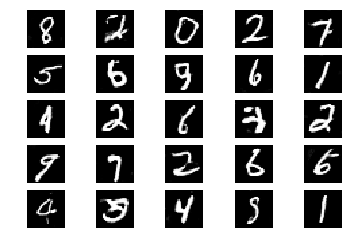

3151 [D loss: 0.561586, acc.: 70.70%] [G loss: 1.273378]
3152 [D loss: 0.619098, acc.: 68.36%] [G loss: 1.174300]
3153 [D loss: 0.665823, acc.: 58.20%] [G loss: 1.061013]
3154 [D loss: 0.627100, acc.: 62.11%] [G loss: 1.310691]
3155 [D loss: 0.722110, acc.: 55.08%] [G loss: 1.167104]
3156 [D loss: 0.660377, acc.: 65.23%] [G loss: 1.009943]
3157 [D loss: 0.616619, acc.: 65.23%] [G loss: 1.315876]
3158 [D loss: 0.721073, acc.: 55.47%] [G loss: 0.978379]
3159 [D loss: 0.560893, acc.: 71.88%] [G loss: 1.129567]
3160 [D loss: 0.772758, acc.: 46.48%] [G loss: 1.053439]
3161 [D loss: 0.677715, acc.: 59.38%] [G loss: 0.946450]
3162 [D loss: 0.794105, acc.: 45.70%] [G loss: 1.188445]
3163 [D loss: 0.643320, acc.: 59.77%] [G loss: 1.320704]
3164 [D loss: 0.595865, acc.: 67.19%] [G loss: 1.177903]
3165 [D loss: 0.597052, acc.: 65.23%] [G loss: 1.117056]
3166 [D loss: 0.475322, acc.: 79.69%] [G loss: 1.016298]
3167 [D loss: 0.543166, acc.: 74.22%] [G loss: 0.787045]
3168 [D loss: 0.626043, acc.: 6

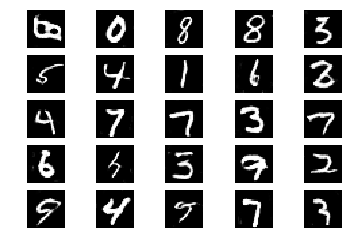

3201 [D loss: 0.680594, acc.: 60.55%] [G loss: 1.210987]
3202 [D loss: 0.691107, acc.: 59.77%] [G loss: 0.925268]
3203 [D loss: 0.613592, acc.: 66.80%] [G loss: 1.019024]
3204 [D loss: 0.653138, acc.: 59.77%] [G loss: 1.274089]
3205 [D loss: 0.555168, acc.: 73.83%] [G loss: 1.149492]
3206 [D loss: 0.580864, acc.: 69.92%] [G loss: 1.742466]
3207 [D loss: 0.604137, acc.: 65.23%] [G loss: 1.260490]
3208 [D loss: 0.637998, acc.: 61.33%] [G loss: 1.186750]
3209 [D loss: 0.515960, acc.: 77.34%] [G loss: 1.409618]
3210 [D loss: 0.694831, acc.: 59.77%] [G loss: 1.200837]
3211 [D loss: 0.651863, acc.: 61.33%] [G loss: 1.100565]
3212 [D loss: 0.549025, acc.: 73.83%] [G loss: 1.303518]
3213 [D loss: 0.691819, acc.: 59.38%] [G loss: 1.073647]
3214 [D loss: 0.560050, acc.: 73.83%] [G loss: 1.155682]
3215 [D loss: 0.645902, acc.: 61.72%] [G loss: 0.848638]
3216 [D loss: 0.604073, acc.: 69.14%] [G loss: 1.275227]
3217 [D loss: 0.546635, acc.: 73.44%] [G loss: 1.115490]
3218 [D loss: 0.524358, acc.: 7

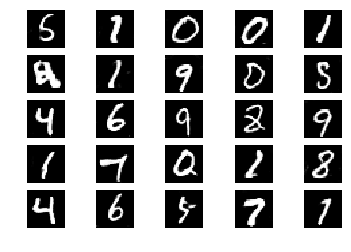

3251 [D loss: 0.552091, acc.: 71.88%] [G loss: 1.314168]
3252 [D loss: 0.688692, acc.: 56.25%] [G loss: 0.915331]
3253 [D loss: 0.539797, acc.: 73.83%] [G loss: 1.147099]
3254 [D loss: 0.626255, acc.: 64.45%] [G loss: 1.034251]
3255 [D loss: 0.757569, acc.: 52.73%] [G loss: 1.383847]
3256 [D loss: 0.644302, acc.: 65.62%] [G loss: 1.251685]
3257 [D loss: 0.529690, acc.: 77.73%] [G loss: 1.395454]
3258 [D loss: 0.750091, acc.: 48.44%] [G loss: 1.066443]
3259 [D loss: 0.655554, acc.: 63.67%] [G loss: 0.946174]
3260 [D loss: 0.656829, acc.: 60.94%] [G loss: 1.174880]
3261 [D loss: 0.558765, acc.: 70.70%] [G loss: 1.116866]
3262 [D loss: 0.655331, acc.: 65.23%] [G loss: 0.990097]
3263 [D loss: 0.707494, acc.: 57.42%] [G loss: 1.065021]
3264 [D loss: 0.625502, acc.: 65.62%] [G loss: 1.336879]
3265 [D loss: 0.847087, acc.: 44.92%] [G loss: 1.048084]
3266 [D loss: 0.630739, acc.: 61.72%] [G loss: 0.880055]
3267 [D loss: 0.725137, acc.: 50.78%] [G loss: 1.073529]
3268 [D loss: 0.754499, acc.: 5

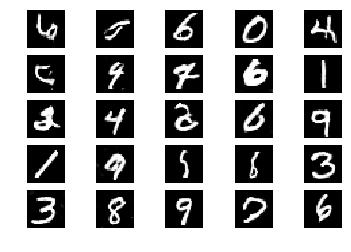

3301 [D loss: 0.531861, acc.: 71.88%] [G loss: 1.447884]
3302 [D loss: 0.595346, acc.: 66.80%] [G loss: 1.449172]
3303 [D loss: 0.686636, acc.: 57.81%] [G loss: 1.020144]
3304 [D loss: 0.736160, acc.: 49.22%] [G loss: 1.085893]
3305 [D loss: 0.671244, acc.: 57.81%] [G loss: 1.135859]
3306 [D loss: 0.618531, acc.: 64.06%] [G loss: 1.098062]
3307 [D loss: 0.596440, acc.: 69.14%] [G loss: 1.285002]
3308 [D loss: 0.723134, acc.: 53.52%] [G loss: 1.305696]
3309 [D loss: 0.584121, acc.: 70.70%] [G loss: 0.973606]
3310 [D loss: 0.626740, acc.: 61.33%] [G loss: 0.870554]
3311 [D loss: 0.700248, acc.: 57.81%] [G loss: 0.861875]
3312 [D loss: 0.613446, acc.: 64.45%] [G loss: 1.017453]
3313 [D loss: 0.702026, acc.: 53.12%] [G loss: 0.813883]
3314 [D loss: 0.621025, acc.: 66.41%] [G loss: 1.006481]
3315 [D loss: 0.486600, acc.: 83.59%] [G loss: 1.232605]
3316 [D loss: 0.687343, acc.: 59.38%] [G loss: 1.127155]
3317 [D loss: 0.624354, acc.: 64.45%] [G loss: 1.054047]
3318 [D loss: 0.549935, acc.: 7

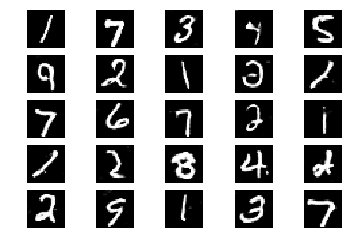

3351 [D loss: 0.707447, acc.: 57.42%] [G loss: 0.919817]
3352 [D loss: 0.734410, acc.: 51.56%] [G loss: 1.164510]
3353 [D loss: 0.621257, acc.: 66.41%] [G loss: 1.112997]
3354 [D loss: 0.576406, acc.: 69.14%] [G loss: 0.984481]
3355 [D loss: 0.511757, acc.: 78.12%] [G loss: 1.145215]
3356 [D loss: 0.587723, acc.: 67.19%] [G loss: 1.063723]
3357 [D loss: 0.676769, acc.: 58.59%] [G loss: 0.981969]
3358 [D loss: 0.650645, acc.: 62.50%] [G loss: 0.995740]
3359 [D loss: 0.713854, acc.: 57.03%] [G loss: 1.165301]
3360 [D loss: 0.659010, acc.: 61.72%] [G loss: 0.999812]
3361 [D loss: 0.472963, acc.: 80.47%] [G loss: 1.073187]
3362 [D loss: 0.525028, acc.: 76.56%] [G loss: 1.148845]
3363 [D loss: 0.576106, acc.: 69.53%] [G loss: 1.176275]
3364 [D loss: 0.496035, acc.: 79.69%] [G loss: 1.215613]
3365 [D loss: 0.595776, acc.: 69.92%] [G loss: 1.010970]
3366 [D loss: 0.611599, acc.: 64.84%] [G loss: 0.819751]
3367 [D loss: 0.518476, acc.: 76.17%] [G loss: 1.155868]
3368 [D loss: 0.624274, acc.: 6

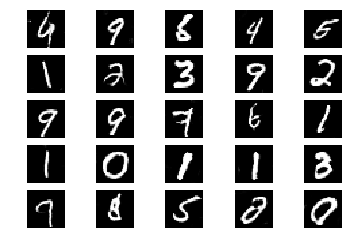

3401 [D loss: 0.675005, acc.: 56.64%] [G loss: 1.315817]
3402 [D loss: 0.686104, acc.: 62.11%] [G loss: 1.089525]
3403 [D loss: 0.529374, acc.: 77.73%] [G loss: 1.116378]
3404 [D loss: 0.616536, acc.: 65.23%] [G loss: 1.082001]
3405 [D loss: 0.542179, acc.: 75.00%] [G loss: 1.153203]
3406 [D loss: 0.442246, acc.: 85.94%] [G loss: 1.297962]
3407 [D loss: 0.614061, acc.: 66.41%] [G loss: 0.985007]
3408 [D loss: 0.560570, acc.: 72.66%] [G loss: 1.212975]
3409 [D loss: 0.617355, acc.: 65.23%] [G loss: 1.057900]
3410 [D loss: 0.588223, acc.: 67.97%] [G loss: 1.075159]
3411 [D loss: 0.604168, acc.: 71.09%] [G loss: 1.206465]
3412 [D loss: 0.612794, acc.: 63.28%] [G loss: 1.229055]
3413 [D loss: 0.595817, acc.: 68.75%] [G loss: 0.984438]
3414 [D loss: 0.484807, acc.: 80.47%] [G loss: 1.250009]
3415 [D loss: 0.738527, acc.: 53.12%] [G loss: 1.193466]
3416 [D loss: 0.533286, acc.: 73.44%] [G loss: 1.113581]
3417 [D loss: 0.620861, acc.: 67.19%] [G loss: 0.934045]
3418 [D loss: 0.609666, acc.: 6

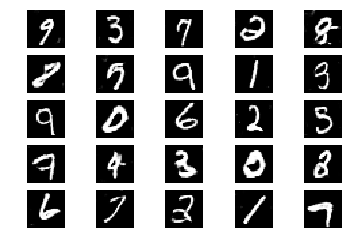

3451 [D loss: 0.712554, acc.: 55.86%] [G loss: 1.085955]
3452 [D loss: 0.695300, acc.: 59.77%] [G loss: 0.995330]
3453 [D loss: 0.542275, acc.: 74.22%] [G loss: 0.980609]
3454 [D loss: 0.640012, acc.: 63.67%] [G loss: 1.004897]
3455 [D loss: 0.585312, acc.: 68.36%] [G loss: 1.105957]
3456 [D loss: 0.509141, acc.: 76.56%] [G loss: 1.241199]
3457 [D loss: 0.597475, acc.: 66.02%] [G loss: 1.525341]
3458 [D loss: 0.685324, acc.: 53.12%] [G loss: 1.159881]
3459 [D loss: 0.544463, acc.: 75.00%] [G loss: 1.209128]
3460 [D loss: 0.667125, acc.: 57.81%] [G loss: 1.210263]
3461 [D loss: 0.737176, acc.: 53.91%] [G loss: 1.211474]
3462 [D loss: 0.578979, acc.: 67.58%] [G loss: 1.127734]
3463 [D loss: 0.763313, acc.: 51.95%] [G loss: 1.163494]
3464 [D loss: 0.570236, acc.: 72.66%] [G loss: 1.229588]
3465 [D loss: 0.551433, acc.: 71.09%] [G loss: 1.101339]
3466 [D loss: 0.713488, acc.: 54.30%] [G loss: 0.803778]
3467 [D loss: 0.566693, acc.: 71.88%] [G loss: 1.013836]
3468 [D loss: 0.574661, acc.: 6

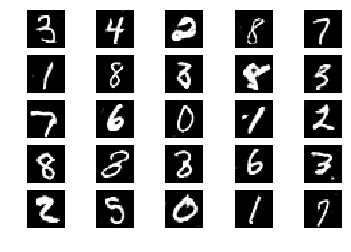

3501 [D loss: 0.664942, acc.: 61.33%] [G loss: 1.339417]
3502 [D loss: 0.728426, acc.: 51.17%] [G loss: 1.301474]
3503 [D loss: 0.651102, acc.: 62.50%] [G loss: 0.960184]
3504 [D loss: 0.623148, acc.: 62.11%] [G loss: 1.061351]
3505 [D loss: 0.738620, acc.: 54.69%] [G loss: 1.344950]
3506 [D loss: 0.556196, acc.: 73.05%] [G loss: 1.390354]
3507 [D loss: 0.562076, acc.: 73.05%] [G loss: 1.085212]
3508 [D loss: 0.748561, acc.: 49.22%] [G loss: 1.004705]
3509 [D loss: 0.519756, acc.: 76.95%] [G loss: 1.132494]
3510 [D loss: 0.618254, acc.: 62.11%] [G loss: 1.155300]
3511 [D loss: 0.582240, acc.: 69.14%] [G loss: 0.971859]
3512 [D loss: 0.561499, acc.: 70.31%] [G loss: 1.051764]
3513 [D loss: 0.697815, acc.: 55.86%] [G loss: 1.191977]
3514 [D loss: 0.600078, acc.: 63.28%] [G loss: 1.161405]
3515 [D loss: 0.705932, acc.: 56.25%] [G loss: 0.986077]
3516 [D loss: 0.717333, acc.: 54.69%] [G loss: 0.994384]
3517 [D loss: 0.595162, acc.: 69.92%] [G loss: 1.212174]
3518 [D loss: 0.717653, acc.: 5

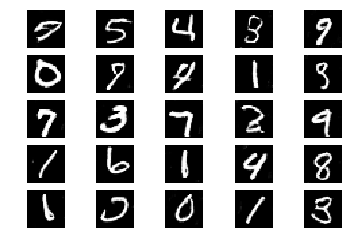

3551 [D loss: 0.633675, acc.: 61.72%] [G loss: 1.163934]
3552 [D loss: 0.589103, acc.: 67.58%] [G loss: 1.258504]
3553 [D loss: 0.583086, acc.: 71.88%] [G loss: 1.131417]
3554 [D loss: 0.523845, acc.: 77.73%] [G loss: 0.933780]
3555 [D loss: 0.654191, acc.: 62.89%] [G loss: 1.209747]
3556 [D loss: 0.674646, acc.: 62.11%] [G loss: 0.761113]
3557 [D loss: 0.630941, acc.: 66.80%] [G loss: 1.070312]
3558 [D loss: 0.652674, acc.: 61.72%] [G loss: 1.221554]
3559 [D loss: 0.713145, acc.: 53.12%] [G loss: 1.183254]
3560 [D loss: 0.626551, acc.: 64.45%] [G loss: 1.155597]
3561 [D loss: 0.633972, acc.: 64.84%] [G loss: 1.093083]
3562 [D loss: 0.637041, acc.: 66.02%] [G loss: 1.108303]
3563 [D loss: 0.680160, acc.: 58.59%] [G loss: 1.113197]
3564 [D loss: 0.572227, acc.: 69.14%] [G loss: 1.135463]
3565 [D loss: 0.707461, acc.: 56.25%] [G loss: 1.007044]
3566 [D loss: 0.605538, acc.: 67.19%] [G loss: 0.854493]
3567 [D loss: 0.522852, acc.: 79.69%] [G loss: 1.122802]
3568 [D loss: 0.494218, acc.: 7

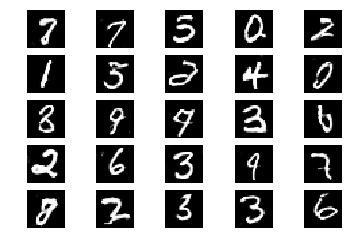

3601 [D loss: 0.709081, acc.: 55.08%] [G loss: 1.155778]
3602 [D loss: 0.722839, acc.: 52.34%] [G loss: 1.037033]
3603 [D loss: 0.569018, acc.: 71.88%] [G loss: 1.107439]
3604 [D loss: 0.695197, acc.: 57.42%] [G loss: 1.407705]
3605 [D loss: 0.535966, acc.: 76.17%] [G loss: 1.378985]
3606 [D loss: 0.601049, acc.: 69.53%] [G loss: 1.548704]
3607 [D loss: 0.554906, acc.: 72.27%] [G loss: 1.319622]
3608 [D loss: 0.775360, acc.: 51.56%] [G loss: 1.146784]
3609 [D loss: 0.676335, acc.: 59.77%] [G loss: 1.072183]
3610 [D loss: 0.531100, acc.: 74.22%] [G loss: 1.194974]
3611 [D loss: 0.684393, acc.: 60.55%] [G loss: 1.336173]
3612 [D loss: 0.452795, acc.: 81.25%] [G loss: 1.390551]
3613 [D loss: 0.635509, acc.: 62.50%] [G loss: 1.248237]
3614 [D loss: 0.611719, acc.: 67.58%] [G loss: 1.040383]
3615 [D loss: 0.719614, acc.: 55.86%] [G loss: 1.278445]
3616 [D loss: 0.692236, acc.: 58.59%] [G loss: 1.146866]
3617 [D loss: 0.555221, acc.: 73.83%] [G loss: 1.346432]
3618 [D loss: 0.599312, acc.: 6

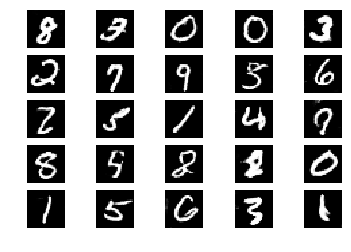

3651 [D loss: 0.540708, acc.: 75.00%] [G loss: 0.948744]
3652 [D loss: 0.565186, acc.: 69.53%] [G loss: 1.175728]
3653 [D loss: 0.592769, acc.: 69.53%] [G loss: 1.309972]
3654 [D loss: 0.676288, acc.: 59.38%] [G loss: 0.964593]
3655 [D loss: 0.635006, acc.: 64.84%] [G loss: 1.275637]
3656 [D loss: 0.670667, acc.: 61.33%] [G loss: 1.113661]
3657 [D loss: 0.605340, acc.: 68.75%] [G loss: 1.149886]
3658 [D loss: 0.584017, acc.: 66.80%] [G loss: 1.372259]
3659 [D loss: 0.563226, acc.: 71.88%] [G loss: 1.540871]
3660 [D loss: 0.635319, acc.: 66.02%] [G loss: 1.044671]
3661 [D loss: 0.577479, acc.: 68.75%] [G loss: 1.250086]
3662 [D loss: 0.587738, acc.: 69.14%] [G loss: 0.899353]
3663 [D loss: 0.648824, acc.: 63.28%] [G loss: 0.971523]
3664 [D loss: 0.610576, acc.: 67.58%] [G loss: 0.912688]
3665 [D loss: 0.702579, acc.: 53.12%] [G loss: 0.967738]
3666 [D loss: 0.724952, acc.: 53.52%] [G loss: 1.200921]
3667 [D loss: 0.557105, acc.: 71.48%] [G loss: 1.148714]
3668 [D loss: 0.679256, acc.: 5

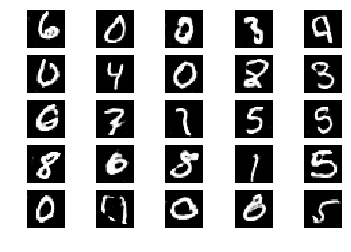

3701 [D loss: 0.559173, acc.: 73.44%] [G loss: 1.343861]
3702 [D loss: 0.582191, acc.: 72.27%] [G loss: 1.190293]
3703 [D loss: 0.557586, acc.: 74.61%] [G loss: 1.356360]
3704 [D loss: 0.571593, acc.: 70.70%] [G loss: 1.057741]
3705 [D loss: 0.664756, acc.: 58.98%] [G loss: 1.026155]
3706 [D loss: 0.701339, acc.: 55.08%] [G loss: 1.130960]
3707 [D loss: 0.527498, acc.: 75.78%] [G loss: 1.222659]
3708 [D loss: 0.707783, acc.: 57.03%] [G loss: 1.191479]
3709 [D loss: 0.607108, acc.: 68.75%] [G loss: 1.172764]
3710 [D loss: 0.711025, acc.: 57.03%] [G loss: 1.163670]
3711 [D loss: 0.608188, acc.: 66.41%] [G loss: 1.336838]
3712 [D loss: 0.754544, acc.: 48.44%] [G loss: 0.939155]
3713 [D loss: 0.641918, acc.: 63.28%] [G loss: 1.069914]
3714 [D loss: 0.545116, acc.: 73.05%] [G loss: 1.046775]
3715 [D loss: 0.783368, acc.: 49.22%] [G loss: 1.155890]
3716 [D loss: 0.621847, acc.: 64.06%] [G loss: 0.990583]
3717 [D loss: 0.633385, acc.: 62.50%] [G loss: 1.318381]
3718 [D loss: 0.649852, acc.: 6

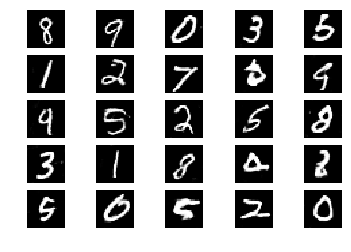

3751 [D loss: 0.723860, acc.: 56.64%] [G loss: 1.004508]
3752 [D loss: 0.640189, acc.: 64.06%] [G loss: 1.318748]
3753 [D loss: 0.646206, acc.: 60.55%] [G loss: 1.241576]
3754 [D loss: 0.709189, acc.: 57.42%] [G loss: 1.344142]
3755 [D loss: 0.679685, acc.: 58.98%] [G loss: 1.065759]
3756 [D loss: 0.691127, acc.: 58.98%] [G loss: 1.004839]
3757 [D loss: 0.555871, acc.: 73.05%] [G loss: 1.148530]
3758 [D loss: 0.615462, acc.: 66.02%] [G loss: 1.131764]
3759 [D loss: 0.912951, acc.: 37.50%] [G loss: 1.168425]
3760 [D loss: 0.674149, acc.: 62.11%] [G loss: 1.075377]
3761 [D loss: 0.674054, acc.: 58.20%] [G loss: 0.866334]
3762 [D loss: 0.532256, acc.: 73.83%] [G loss: 1.225920]
3763 [D loss: 0.644573, acc.: 60.55%] [G loss: 1.201266]
3764 [D loss: 0.566385, acc.: 70.70%] [G loss: 0.948196]
3765 [D loss: 0.697055, acc.: 57.81%] [G loss: 1.058671]
3766 [D loss: 0.625702, acc.: 66.80%] [G loss: 1.543024]
3767 [D loss: 0.659665, acc.: 61.33%] [G loss: 1.219920]
3768 [D loss: 0.541298, acc.: 7

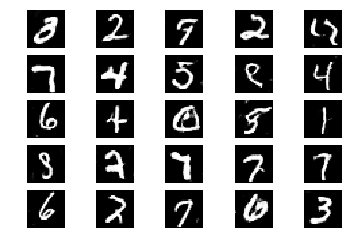

3801 [D loss: 0.618844, acc.: 64.06%] [G loss: 0.970289]
3802 [D loss: 0.479889, acc.: 80.47%] [G loss: 1.221415]
3803 [D loss: 0.750579, acc.: 52.73%] [G loss: 1.011661]
3804 [D loss: 0.569058, acc.: 69.92%] [G loss: 1.093482]
3805 [D loss: 0.630737, acc.: 63.67%] [G loss: 1.335003]
3806 [D loss: 0.600328, acc.: 68.36%] [G loss: 1.366802]
3807 [D loss: 0.675373, acc.: 58.20%] [G loss: 1.446663]
3808 [D loss: 0.614490, acc.: 68.75%] [G loss: 1.302421]
3809 [D loss: 0.641502, acc.: 60.94%] [G loss: 1.236299]
3810 [D loss: 0.531668, acc.: 73.44%] [G loss: 1.376056]
3811 [D loss: 0.496155, acc.: 81.64%] [G loss: 1.122360]
3812 [D loss: 0.649563, acc.: 64.84%] [G loss: 1.219531]
3813 [D loss: 0.595943, acc.: 67.97%] [G loss: 1.070742]
3814 [D loss: 0.592591, acc.: 71.09%] [G loss: 1.181418]
3815 [D loss: 0.603172, acc.: 66.02%] [G loss: 1.352323]
3816 [D loss: 0.604764, acc.: 67.58%] [G loss: 1.264612]
3817 [D loss: 0.589617, acc.: 65.23%] [G loss: 1.076861]
3818 [D loss: 0.628611, acc.: 6

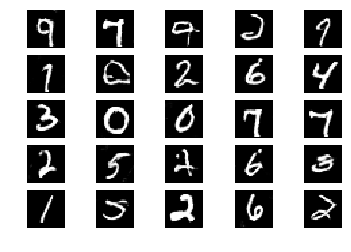

3851 [D loss: 0.586911, acc.: 72.27%] [G loss: 0.877141]
3852 [D loss: 0.687452, acc.: 60.55%] [G loss: 0.942445]
3853 [D loss: 0.633954, acc.: 61.33%] [G loss: 1.227551]
3854 [D loss: 0.553087, acc.: 70.70%] [G loss: 1.044421]
3855 [D loss: 0.765829, acc.: 49.61%] [G loss: 1.182715]
3856 [D loss: 0.537674, acc.: 73.83%] [G loss: 1.381091]
3857 [D loss: 0.479285, acc.: 76.95%] [G loss: 0.947662]
3858 [D loss: 0.571433, acc.: 70.31%] [G loss: 1.001235]
3859 [D loss: 0.591458, acc.: 69.14%] [G loss: 1.204815]
3860 [D loss: 0.535799, acc.: 72.27%] [G loss: 1.114308]
3861 [D loss: 0.580140, acc.: 67.97%] [G loss: 0.938112]
3862 [D loss: 0.514598, acc.: 77.73%] [G loss: 1.441978]
3863 [D loss: 0.635931, acc.: 63.28%] [G loss: 1.166198]
3864 [D loss: 0.730447, acc.: 57.42%] [G loss: 0.800136]
3865 [D loss: 0.630058, acc.: 62.50%] [G loss: 1.110999]
3866 [D loss: 0.600888, acc.: 71.09%] [G loss: 1.181474]
3867 [D loss: 0.616664, acc.: 66.02%] [G loss: 1.383451]
3868 [D loss: 0.619114, acc.: 6

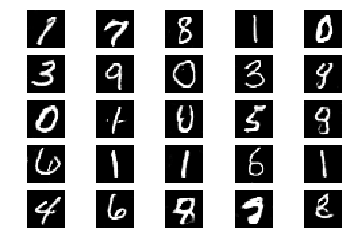

3901 [D loss: 0.554056, acc.: 73.05%] [G loss: 1.092350]
3902 [D loss: 0.655512, acc.: 62.89%] [G loss: 1.165389]
3903 [D loss: 0.604093, acc.: 66.02%] [G loss: 1.310043]
3904 [D loss: 0.636973, acc.: 62.50%] [G loss: 1.155678]
3905 [D loss: 0.514318, acc.: 75.00%] [G loss: 1.077970]
3906 [D loss: 0.602729, acc.: 66.80%] [G loss: 1.169144]
3907 [D loss: 0.682507, acc.: 59.77%] [G loss: 1.142482]
3908 [D loss: 0.563828, acc.: 71.09%] [G loss: 1.257975]
3909 [D loss: 0.647610, acc.: 61.72%] [G loss: 1.005023]
3910 [D loss: 0.570149, acc.: 71.09%] [G loss: 1.119712]
3911 [D loss: 0.751176, acc.: 52.34%] [G loss: 1.007607]
3912 [D loss: 0.722400, acc.: 58.59%] [G loss: 1.019948]
3913 [D loss: 0.590462, acc.: 68.36%] [G loss: 1.455683]
3914 [D loss: 0.628155, acc.: 65.62%] [G loss: 1.429219]
3915 [D loss: 0.650984, acc.: 60.16%] [G loss: 1.185833]
3916 [D loss: 0.619421, acc.: 62.50%] [G loss: 1.250807]
3917 [D loss: 0.592250, acc.: 69.14%] [G loss: 1.166953]
3918 [D loss: 0.559501, acc.: 7

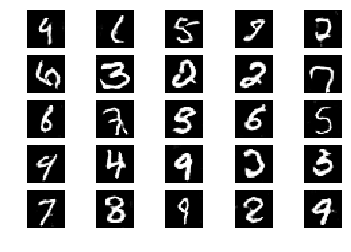

3951 [D loss: 0.707470, acc.: 58.59%] [G loss: 0.967206]
3952 [D loss: 0.543494, acc.: 76.56%] [G loss: 1.104744]
3953 [D loss: 0.606902, acc.: 68.36%] [G loss: 1.164761]
3954 [D loss: 0.744515, acc.: 53.12%] [G loss: 1.102624]
3955 [D loss: 0.615466, acc.: 64.06%] [G loss: 1.258914]
3956 [D loss: 0.599488, acc.: 68.75%] [G loss: 1.425831]
3957 [D loss: 0.701913, acc.: 58.20%] [G loss: 1.146481]
3958 [D loss: 0.631512, acc.: 64.45%] [G loss: 1.353495]
3959 [D loss: 0.664079, acc.: 62.89%] [G loss: 1.095893]
3960 [D loss: 0.524962, acc.: 75.78%] [G loss: 1.072117]
3961 [D loss: 0.544577, acc.: 73.05%] [G loss: 1.182758]
3962 [D loss: 0.638522, acc.: 62.89%] [G loss: 1.386948]
3963 [D loss: 0.772164, acc.: 47.27%] [G loss: 1.301491]
3964 [D loss: 0.706659, acc.: 54.69%] [G loss: 0.802021]
3965 [D loss: 0.665959, acc.: 62.89%] [G loss: 1.091776]
3966 [D loss: 0.623578, acc.: 69.14%] [G loss: 0.892909]
3967 [D loss: 0.669419, acc.: 57.81%] [G loss: 1.003032]
3968 [D loss: 0.578964, acc.: 6

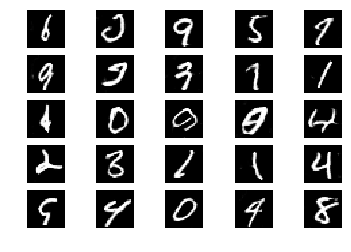

In [164]:
dcgan.train(epochs=4001, batch_size=128, save_interval=50)

## 3.    Learning rate =0.01 and batchsize =256

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.575807, acc.: 69.92%] [G loss: 1.143423]


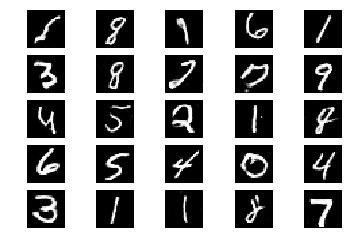

1 [D loss: 0.535736, acc.: 76.17%] [G loss: 1.246493]
2 [D loss: 0.719248, acc.: 54.88%] [G loss: 1.187518]
3 [D loss: 0.630423, acc.: 63.48%] [G loss: 1.219123]
4 [D loss: 0.517867, acc.: 75.78%] [G loss: 1.107545]
5 [D loss: 0.630432, acc.: 64.06%] [G loss: 1.194482]
6 [D loss: 0.655034, acc.: 62.50%] [G loss: 0.989902]
7 [D loss: 0.675349, acc.: 60.35%] [G loss: 0.946132]
8 [D loss: 0.619462, acc.: 64.45%] [G loss: 1.108765]
9 [D loss: 0.742750, acc.: 50.59%] [G loss: 1.258864]
10 [D loss: 0.589056, acc.: 68.75%] [G loss: 1.426585]
11 [D loss: 0.612905, acc.: 66.60%] [G loss: 1.160033]
12 [D loss: 0.615133, acc.: 65.43%] [G loss: 1.014931]
13 [D loss: 0.547661, acc.: 70.70%] [G loss: 1.287850]
14 [D loss: 0.559517, acc.: 71.88%] [G loss: 1.191417]
15 [D loss: 0.681421, acc.: 59.96%] [G loss: 1.099672]
16 [D loss: 0.706596, acc.: 56.25%] [G loss: 0.944982]
17 [D loss: 0.526185, acc.: 76.95%] [G loss: 1.251560]
18 [D loss: 0.627877, acc.: 63.09%] [G loss: 1.123812]
19 [D loss: 0.56610

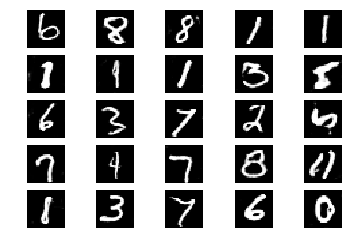

51 [D loss: 0.603040, acc.: 66.60%] [G loss: 1.308681]
52 [D loss: 0.633020, acc.: 62.11%] [G loss: 0.954778]
53 [D loss: 0.696481, acc.: 57.81%] [G loss: 1.001909]
54 [D loss: 0.589519, acc.: 67.77%] [G loss: 1.121347]
55 [D loss: 0.526901, acc.: 77.34%] [G loss: 1.290304]
56 [D loss: 0.678594, acc.: 60.16%] [G loss: 1.063834]
57 [D loss: 0.671746, acc.: 60.74%] [G loss: 1.116187]
58 [D loss: 0.518440, acc.: 76.76%] [G loss: 1.084886]
59 [D loss: 0.628174, acc.: 65.23%] [G loss: 0.942406]
60 [D loss: 0.604495, acc.: 66.21%] [G loss: 1.332865]
61 [D loss: 0.595261, acc.: 67.97%] [G loss: 1.092334]
62 [D loss: 0.559886, acc.: 71.68%] [G loss: 1.231889]
63 [D loss: 0.558409, acc.: 74.61%] [G loss: 1.147175]
64 [D loss: 0.590653, acc.: 68.55%] [G loss: 1.186489]
65 [D loss: 0.684133, acc.: 57.03%] [G loss: 0.971609]
66 [D loss: 0.691118, acc.: 57.42%] [G loss: 1.114941]
67 [D loss: 0.604943, acc.: 68.95%] [G loss: 1.248158]
68 [D loss: 0.708503, acc.: 55.08%] [G loss: 1.091568]
69 [D loss

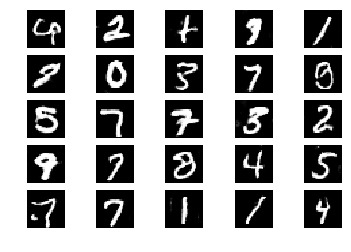

101 [D loss: 0.593035, acc.: 69.53%] [G loss: 1.110238]
102 [D loss: 0.753471, acc.: 52.54%] [G loss: 1.060307]
103 [D loss: 0.709160, acc.: 53.91%] [G loss: 1.211170]
104 [D loss: 0.652577, acc.: 58.98%] [G loss: 1.154297]
105 [D loss: 0.637205, acc.: 60.74%] [G loss: 1.154983]
106 [D loss: 0.715359, acc.: 56.05%] [G loss: 1.190767]
107 [D loss: 0.770409, acc.: 49.80%] [G loss: 1.044325]
108 [D loss: 0.603652, acc.: 66.41%] [G loss: 1.147576]
109 [D loss: 0.688661, acc.: 58.20%] [G loss: 1.014901]
110 [D loss: 0.591260, acc.: 68.75%] [G loss: 0.969777]
111 [D loss: 0.666675, acc.: 58.79%] [G loss: 1.228844]
112 [D loss: 0.639997, acc.: 63.87%] [G loss: 1.276023]
113 [D loss: 0.559238, acc.: 72.85%] [G loss: 1.192792]
114 [D loss: 0.601406, acc.: 69.73%] [G loss: 1.160141]
115 [D loss: 0.626003, acc.: 66.41%] [G loss: 1.091096]
116 [D loss: 0.630274, acc.: 64.06%] [G loss: 1.043712]
117 [D loss: 0.626339, acc.: 66.80%] [G loss: 1.109891]
118 [D loss: 0.551139, acc.: 72.27%] [G loss: 1.

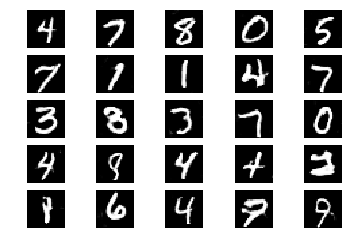

151 [D loss: 0.523237, acc.: 75.78%] [G loss: 1.233158]
152 [D loss: 0.625066, acc.: 64.65%] [G loss: 1.175665]
153 [D loss: 0.692213, acc.: 57.03%] [G loss: 1.097513]
154 [D loss: 0.636840, acc.: 65.62%] [G loss: 1.169207]
155 [D loss: 0.514945, acc.: 77.73%] [G loss: 1.176793]
156 [D loss: 0.620214, acc.: 66.80%] [G loss: 1.094794]
157 [D loss: 0.594129, acc.: 67.19%] [G loss: 1.125519]
158 [D loss: 0.704375, acc.: 54.88%] [G loss: 1.310122]
159 [D loss: 0.680446, acc.: 59.38%] [G loss: 0.955958]
160 [D loss: 0.567660, acc.: 71.29%] [G loss: 1.153094]
161 [D loss: 0.709551, acc.: 56.64%] [G loss: 1.116513]
162 [D loss: 0.608899, acc.: 67.38%] [G loss: 0.996587]
163 [D loss: 0.706395, acc.: 56.05%] [G loss: 1.136319]
164 [D loss: 0.559524, acc.: 74.02%] [G loss: 1.127496]
165 [D loss: 0.733758, acc.: 52.73%] [G loss: 0.926566]
166 [D loss: 0.615747, acc.: 65.62%] [G loss: 0.991968]
167 [D loss: 0.601224, acc.: 69.92%] [G loss: 0.942896]
168 [D loss: 0.646227, acc.: 64.84%] [G loss: 1.

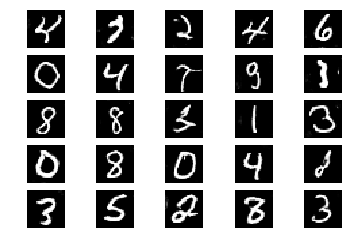

201 [D loss: 0.704745, acc.: 55.27%] [G loss: 1.015524]
202 [D loss: 0.701246, acc.: 55.08%] [G loss: 1.187942]
203 [D loss: 0.607449, acc.: 66.41%] [G loss: 1.201085]
204 [D loss: 0.697493, acc.: 59.38%] [G loss: 1.022063]
205 [D loss: 0.747663, acc.: 51.37%] [G loss: 1.116371]
206 [D loss: 0.640358, acc.: 64.45%] [G loss: 1.116631]
207 [D loss: 0.598243, acc.: 70.70%] [G loss: 1.177395]
208 [D loss: 0.670334, acc.: 59.57%] [G loss: 1.195034]
209 [D loss: 0.653312, acc.: 60.16%] [G loss: 1.162668]
210 [D loss: 0.651661, acc.: 60.94%] [G loss: 1.028041]
211 [D loss: 0.700037, acc.: 55.66%] [G loss: 1.070578]
212 [D loss: 0.529807, acc.: 74.22%] [G loss: 1.091143]
213 [D loss: 0.573800, acc.: 69.92%] [G loss: 1.126419]
214 [D loss: 0.612201, acc.: 65.62%] [G loss: 1.162303]
215 [D loss: 0.617222, acc.: 67.77%] [G loss: 1.114596]
216 [D loss: 0.658518, acc.: 62.30%] [G loss: 0.973004]
217 [D loss: 0.541838, acc.: 74.22%] [G loss: 1.178200]
218 [D loss: 0.622100, acc.: 63.48%] [G loss: 0.

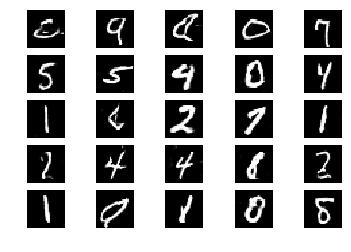

251 [D loss: 0.619357, acc.: 64.26%] [G loss: 1.115822]
252 [D loss: 0.643297, acc.: 62.11%] [G loss: 1.078360]
253 [D loss: 0.702934, acc.: 54.69%] [G loss: 0.706201]
254 [D loss: 0.706937, acc.: 55.27%] [G loss: 1.033767]
255 [D loss: 0.720742, acc.: 52.73%] [G loss: 1.141659]
256 [D loss: 0.651561, acc.: 62.89%] [G loss: 1.239256]
257 [D loss: 0.544690, acc.: 71.68%] [G loss: 1.113953]
258 [D loss: 0.670356, acc.: 59.96%] [G loss: 1.041566]
259 [D loss: 0.562406, acc.: 72.07%] [G loss: 1.070038]
260 [D loss: 0.644897, acc.: 63.28%] [G loss: 1.078075]
261 [D loss: 0.699392, acc.: 55.47%] [G loss: 1.025009]
262 [D loss: 0.632341, acc.: 62.70%] [G loss: 1.189947]
263 [D loss: 0.580253, acc.: 68.16%] [G loss: 1.259085]
264 [D loss: 0.533901, acc.: 74.61%] [G loss: 1.022659]
265 [D loss: 0.662334, acc.: 60.74%] [G loss: 1.052312]
266 [D loss: 0.692863, acc.: 57.62%] [G loss: 1.093247]
267 [D loss: 0.624521, acc.: 64.45%] [G loss: 1.075836]
268 [D loss: 0.657410, acc.: 62.11%] [G loss: 1.

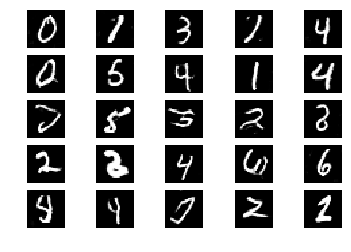

301 [D loss: 0.569271, acc.: 72.27%] [G loss: 1.089198]
302 [D loss: 0.567568, acc.: 71.48%] [G loss: 0.906485]
303 [D loss: 0.634333, acc.: 64.65%] [G loss: 1.024605]
304 [D loss: 0.724872, acc.: 55.27%] [G loss: 1.043038]
305 [D loss: 0.551469, acc.: 74.41%] [G loss: 1.111401]
306 [D loss: 0.667428, acc.: 60.55%] [G loss: 1.047338]
307 [D loss: 0.607522, acc.: 68.16%] [G loss: 0.946954]
308 [D loss: 0.605497, acc.: 65.43%] [G loss: 1.178074]
309 [D loss: 0.628578, acc.: 64.84%] [G loss: 0.907071]
310 [D loss: 0.697989, acc.: 56.64%] [G loss: 0.856471]
311 [D loss: 0.576456, acc.: 71.68%] [G loss: 1.090100]
312 [D loss: 0.652632, acc.: 58.98%] [G loss: 1.170391]
313 [D loss: 0.714458, acc.: 55.08%] [G loss: 0.999647]
314 [D loss: 0.685610, acc.: 59.38%] [G loss: 1.045676]
315 [D loss: 0.627777, acc.: 64.45%] [G loss: 0.912406]
316 [D loss: 0.608913, acc.: 65.43%] [G loss: 1.002748]
317 [D loss: 0.563263, acc.: 74.22%] [G loss: 1.242157]
318 [D loss: 0.689535, acc.: 59.38%] [G loss: 1.

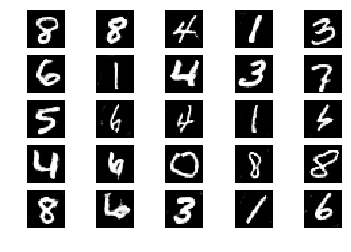

351 [D loss: 0.659508, acc.: 61.72%] [G loss: 1.259531]
352 [D loss: 0.750713, acc.: 53.32%] [G loss: 1.035435]
353 [D loss: 0.700959, acc.: 57.81%] [G loss: 1.096300]
354 [D loss: 0.648666, acc.: 61.13%] [G loss: 0.948773]
355 [D loss: 0.560219, acc.: 72.46%] [G loss: 1.214404]
356 [D loss: 0.617163, acc.: 65.62%] [G loss: 1.182540]
357 [D loss: 0.703627, acc.: 54.88%] [G loss: 1.181141]
358 [D loss: 0.679315, acc.: 59.38%] [G loss: 0.950047]
359 [D loss: 0.635236, acc.: 66.21%] [G loss: 1.080611]
360 [D loss: 0.608352, acc.: 65.43%] [G loss: 1.166602]
361 [D loss: 0.608240, acc.: 66.99%] [G loss: 0.988710]
362 [D loss: 0.712634, acc.: 56.45%] [G loss: 1.072435]
363 [D loss: 0.644007, acc.: 61.91%] [G loss: 0.950432]
364 [D loss: 0.631175, acc.: 65.23%] [G loss: 1.076059]
365 [D loss: 0.612479, acc.: 67.19%] [G loss: 1.327316]
366 [D loss: 0.739865, acc.: 52.54%] [G loss: 0.935720]
367 [D loss: 0.616500, acc.: 66.02%] [G loss: 0.986041]
368 [D loss: 0.635597, acc.: 66.21%] [G loss: 1.

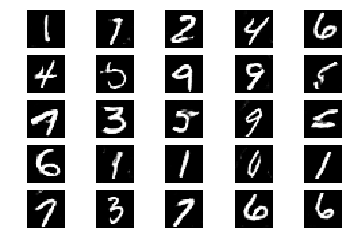

401 [D loss: 0.647643, acc.: 65.04%] [G loss: 1.022341]
402 [D loss: 0.601337, acc.: 67.77%] [G loss: 1.191055]
403 [D loss: 0.603135, acc.: 67.58%] [G loss: 1.223441]
404 [D loss: 0.589124, acc.: 71.48%] [G loss: 1.216870]
405 [D loss: 0.689571, acc.: 56.45%] [G loss: 1.007210]
406 [D loss: 0.577381, acc.: 70.31%] [G loss: 1.105279]
407 [D loss: 0.599250, acc.: 69.53%] [G loss: 1.176876]
408 [D loss: 0.657304, acc.: 60.74%] [G loss: 0.910959]
409 [D loss: 0.648171, acc.: 64.26%] [G loss: 1.097859]
410 [D loss: 0.624853, acc.: 64.06%] [G loss: 0.996472]
411 [D loss: 0.563291, acc.: 70.31%] [G loss: 1.160157]
412 [D loss: 0.695551, acc.: 58.01%] [G loss: 1.012363]
413 [D loss: 0.653882, acc.: 61.72%] [G loss: 0.975882]
414 [D loss: 0.670668, acc.: 59.38%] [G loss: 1.034663]
415 [D loss: 0.647417, acc.: 62.30%] [G loss: 1.178174]
416 [D loss: 0.656366, acc.: 61.13%] [G loss: 1.174442]
417 [D loss: 0.591318, acc.: 68.75%] [G loss: 1.229208]
418 [D loss: 0.552718, acc.: 74.02%] [G loss: 0.

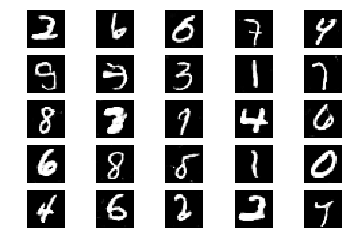

451 [D loss: 0.582228, acc.: 69.14%] [G loss: 1.197196]
452 [D loss: 0.662565, acc.: 61.52%] [G loss: 1.096663]
453 [D loss: 0.708608, acc.: 55.08%] [G loss: 1.039571]
454 [D loss: 0.649942, acc.: 63.28%] [G loss: 1.081968]
455 [D loss: 0.615036, acc.: 66.60%] [G loss: 1.019257]
456 [D loss: 0.701711, acc.: 55.66%] [G loss: 0.986967]
457 [D loss: 0.619635, acc.: 64.65%] [G loss: 1.145480]
458 [D loss: 0.574096, acc.: 69.92%] [G loss: 1.260846]
459 [D loss: 0.530138, acc.: 75.78%] [G loss: 1.127625]
460 [D loss: 0.626619, acc.: 63.87%] [G loss: 1.289771]
461 [D loss: 0.587286, acc.: 68.95%] [G loss: 1.157640]
462 [D loss: 0.619630, acc.: 64.84%] [G loss: 1.122166]
463 [D loss: 0.564941, acc.: 70.70%] [G loss: 1.168501]
464 [D loss: 0.622339, acc.: 67.77%] [G loss: 1.201513]
465 [D loss: 0.708012, acc.: 54.49%] [G loss: 1.133636]
466 [D loss: 0.588691, acc.: 68.95%] [G loss: 1.074852]
467 [D loss: 0.620422, acc.: 63.67%] [G loss: 1.143796]
468 [D loss: 0.529416, acc.: 75.78%] [G loss: 1.

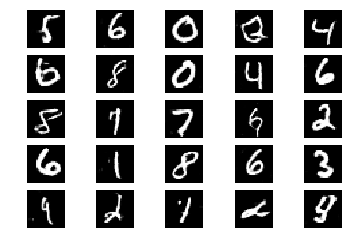

501 [D loss: 0.631787, acc.: 65.23%] [G loss: 1.003927]
502 [D loss: 0.607612, acc.: 66.41%] [G loss: 1.060641]
503 [D loss: 0.637556, acc.: 62.70%] [G loss: 1.055008]
504 [D loss: 0.629826, acc.: 63.87%] [G loss: 1.010549]
505 [D loss: 0.608892, acc.: 67.77%] [G loss: 1.037409]
506 [D loss: 0.579377, acc.: 70.12%] [G loss: 1.157078]
507 [D loss: 0.592498, acc.: 69.53%] [G loss: 1.156585]
508 [D loss: 0.617938, acc.: 66.41%] [G loss: 1.205467]
509 [D loss: 0.608109, acc.: 67.58%] [G loss: 1.043220]
510 [D loss: 0.611480, acc.: 66.41%] [G loss: 0.929180]
511 [D loss: 0.598454, acc.: 66.41%] [G loss: 1.124370]
512 [D loss: 0.653226, acc.: 64.26%] [G loss: 1.044506]
513 [D loss: 0.614622, acc.: 66.02%] [G loss: 1.100263]
514 [D loss: 0.718704, acc.: 53.91%] [G loss: 1.245049]
515 [D loss: 0.691617, acc.: 57.03%] [G loss: 1.199186]
516 [D loss: 0.697372, acc.: 53.52%] [G loss: 1.091712]
517 [D loss: 0.588202, acc.: 69.73%] [G loss: 1.121707]
518 [D loss: 0.527769, acc.: 75.98%] [G loss: 1.

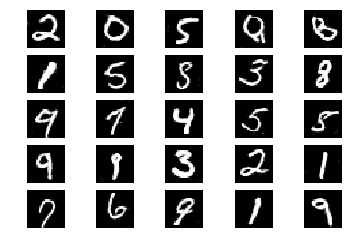

551 [D loss: 0.562486, acc.: 73.83%] [G loss: 1.132520]
552 [D loss: 0.670686, acc.: 59.38%] [G loss: 0.842020]
553 [D loss: 0.695608, acc.: 56.25%] [G loss: 1.109874]
554 [D loss: 0.673338, acc.: 58.59%] [G loss: 1.123331]
555 [D loss: 0.616119, acc.: 62.70%] [G loss: 1.138008]
556 [D loss: 0.776852, acc.: 46.48%] [G loss: 1.045797]
557 [D loss: 0.538438, acc.: 73.44%] [G loss: 1.080217]
558 [D loss: 0.721325, acc.: 55.08%] [G loss: 1.044627]
559 [D loss: 0.609938, acc.: 66.60%] [G loss: 1.073832]
560 [D loss: 0.636206, acc.: 63.09%] [G loss: 1.115875]
561 [D loss: 0.647314, acc.: 63.67%] [G loss: 1.328615]
562 [D loss: 0.607020, acc.: 68.16%] [G loss: 1.216564]
563 [D loss: 0.670566, acc.: 58.98%] [G loss: 1.134714]
564 [D loss: 0.565846, acc.: 73.05%] [G loss: 1.264360]
565 [D loss: 0.606682, acc.: 66.60%] [G loss: 0.997480]
566 [D loss: 0.627188, acc.: 65.82%] [G loss: 1.144699]
567 [D loss: 0.692470, acc.: 55.66%] [G loss: 0.979299]
568 [D loss: 0.706141, acc.: 56.84%] [G loss: 1.

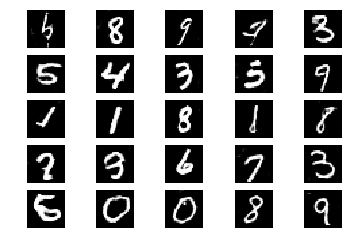

601 [D loss: 0.586219, acc.: 70.12%] [G loss: 0.936734]
602 [D loss: 0.569421, acc.: 72.27%] [G loss: 1.288539]
603 [D loss: 0.567929, acc.: 71.09%] [G loss: 1.083269]
604 [D loss: 0.712051, acc.: 55.27%] [G loss: 1.053559]
605 [D loss: 0.635026, acc.: 62.89%] [G loss: 1.134840]
606 [D loss: 0.727361, acc.: 52.34%] [G loss: 0.875125]
607 [D loss: 0.637988, acc.: 60.94%] [G loss: 1.185389]
608 [D loss: 0.675229, acc.: 58.01%] [G loss: 1.138024]
609 [D loss: 0.637415, acc.: 63.28%] [G loss: 1.287599]
610 [D loss: 0.631093, acc.: 65.23%] [G loss: 0.903878]
611 [D loss: 0.647293, acc.: 60.74%] [G loss: 1.000326]
612 [D loss: 0.543118, acc.: 70.90%] [G loss: 1.162185]
613 [D loss: 0.595250, acc.: 68.16%] [G loss: 1.081901]
614 [D loss: 0.623732, acc.: 65.43%] [G loss: 1.191473]
615 [D loss: 0.718019, acc.: 56.05%] [G loss: 1.043826]
616 [D loss: 0.566080, acc.: 71.68%] [G loss: 1.036704]
617 [D loss: 0.604669, acc.: 66.41%] [G loss: 1.157123]
618 [D loss: 0.589323, acc.: 68.75%] [G loss: 1.

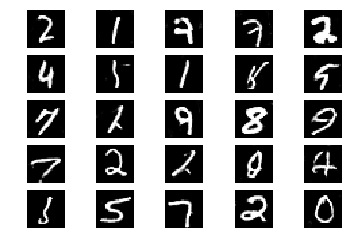

651 [D loss: 0.606674, acc.: 66.60%] [G loss: 0.919069]
652 [D loss: 0.610615, acc.: 65.62%] [G loss: 1.067739]
653 [D loss: 0.612633, acc.: 64.26%] [G loss: 1.026053]
654 [D loss: 0.761935, acc.: 49.22%] [G loss: 1.036941]
655 [D loss: 0.669830, acc.: 61.72%] [G loss: 1.031693]
656 [D loss: 0.686423, acc.: 56.64%] [G loss: 1.113311]
657 [D loss: 0.695414, acc.: 58.01%] [G loss: 1.259661]
658 [D loss: 0.605100, acc.: 67.38%] [G loss: 1.274353]
659 [D loss: 0.586937, acc.: 67.19%] [G loss: 1.308462]
660 [D loss: 0.597588, acc.: 66.99%] [G loss: 1.080441]
661 [D loss: 0.684612, acc.: 56.64%] [G loss: 0.967933]
662 [D loss: 0.610358, acc.: 65.43%] [G loss: 0.906308]
663 [D loss: 0.589961, acc.: 70.70%] [G loss: 0.956310]
664 [D loss: 0.555883, acc.: 73.05%] [G loss: 1.096574]
665 [D loss: 0.596241, acc.: 69.14%] [G loss: 0.978144]
666 [D loss: 0.626970, acc.: 65.23%] [G loss: 1.079720]
667 [D loss: 0.594456, acc.: 69.53%] [G loss: 1.194392]
668 [D loss: 0.669625, acc.: 59.38%] [G loss: 1.

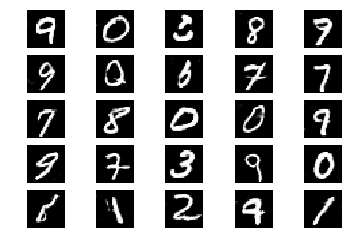

701 [D loss: 0.735989, acc.: 53.91%] [G loss: 1.036561]
702 [D loss: 0.705988, acc.: 57.03%] [G loss: 1.011921]
703 [D loss: 0.630631, acc.: 66.02%] [G loss: 1.053929]
704 [D loss: 0.635861, acc.: 63.87%] [G loss: 1.066133]
705 [D loss: 0.713528, acc.: 54.69%] [G loss: 0.988783]
706 [D loss: 0.604429, acc.: 66.41%] [G loss: 1.038762]
707 [D loss: 0.634939, acc.: 63.67%] [G loss: 0.941798]
708 [D loss: 0.638297, acc.: 63.48%] [G loss: 1.176908]
709 [D loss: 0.737723, acc.: 52.34%] [G loss: 1.171578]
710 [D loss: 0.605073, acc.: 66.60%] [G loss: 1.056761]
711 [D loss: 0.570584, acc.: 69.34%] [G loss: 0.958756]
712 [D loss: 0.724383, acc.: 52.15%] [G loss: 1.048269]
713 [D loss: 0.539053, acc.: 74.22%] [G loss: 1.177796]
714 [D loss: 0.540662, acc.: 74.80%] [G loss: 0.998135]
715 [D loss: 0.621349, acc.: 66.02%] [G loss: 1.166260]
716 [D loss: 0.661057, acc.: 60.74%] [G loss: 0.990128]
717 [D loss: 0.717990, acc.: 54.88%] [G loss: 1.181684]
718 [D loss: 0.612084, acc.: 65.82%] [G loss: 1.

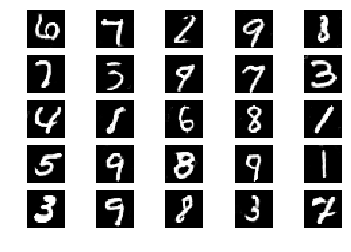

751 [D loss: 0.673260, acc.: 61.13%] [G loss: 1.115445]
752 [D loss: 0.671114, acc.: 59.96%] [G loss: 1.000960]
753 [D loss: 0.696630, acc.: 57.03%] [G loss: 1.036695]
754 [D loss: 0.563909, acc.: 73.05%] [G loss: 1.234675]
755 [D loss: 0.606812, acc.: 67.58%] [G loss: 0.983949]
756 [D loss: 0.588464, acc.: 70.12%] [G loss: 1.032036]
757 [D loss: 0.750181, acc.: 48.63%] [G loss: 0.870042]
758 [D loss: 0.549929, acc.: 72.07%] [G loss: 1.099198]
759 [D loss: 0.745634, acc.: 50.98%] [G loss: 1.195325]
760 [D loss: 0.723820, acc.: 51.17%] [G loss: 1.120435]
761 [D loss: 0.616623, acc.: 67.38%] [G loss: 1.233014]
762 [D loss: 0.558444, acc.: 73.44%] [G loss: 1.265439]
763 [D loss: 0.668009, acc.: 61.52%] [G loss: 1.028551]
764 [D loss: 0.541095, acc.: 75.98%] [G loss: 1.120669]
765 [D loss: 0.656077, acc.: 62.11%] [G loss: 1.082185]
766 [D loss: 0.578410, acc.: 68.95%] [G loss: 1.248867]
767 [D loss: 0.616630, acc.: 67.19%] [G loss: 1.091027]
768 [D loss: 0.563016, acc.: 71.29%] [G loss: 1.

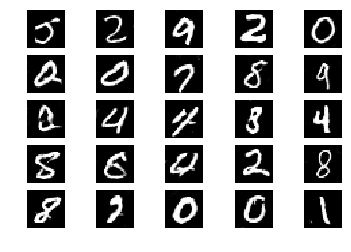

801 [D loss: 0.784422, acc.: 47.27%] [G loss: 0.956756]
802 [D loss: 0.749939, acc.: 54.88%] [G loss: 1.154035]
803 [D loss: 0.601594, acc.: 65.82%] [G loss: 1.219321]
804 [D loss: 0.626665, acc.: 65.23%] [G loss: 1.282747]
805 [D loss: 0.633284, acc.: 61.91%] [G loss: 1.059587]
806 [D loss: 0.639517, acc.: 60.55%] [G loss: 1.115315]
807 [D loss: 0.561506, acc.: 71.88%] [G loss: 0.871382]
808 [D loss: 0.664381, acc.: 59.38%] [G loss: 1.071621]
809 [D loss: 0.597176, acc.: 69.34%] [G loss: 1.271835]
810 [D loss: 0.590372, acc.: 66.41%] [G loss: 1.143826]
811 [D loss: 0.551491, acc.: 72.85%] [G loss: 1.199198]
812 [D loss: 0.692855, acc.: 56.84%] [G loss: 1.133245]
813 [D loss: 0.659142, acc.: 59.77%] [G loss: 1.059831]
814 [D loss: 0.591441, acc.: 67.77%] [G loss: 1.075149]
815 [D loss: 0.591998, acc.: 68.55%] [G loss: 1.262119]
816 [D loss: 0.585629, acc.: 68.95%] [G loss: 1.090914]
817 [D loss: 0.637606, acc.: 64.84%] [G loss: 1.174084]
818 [D loss: 0.676487, acc.: 58.79%] [G loss: 0.

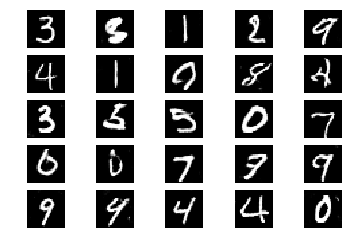

851 [D loss: 0.624881, acc.: 64.65%] [G loss: 1.194230]
852 [D loss: 0.590982, acc.: 70.51%] [G loss: 1.130983]
853 [D loss: 0.708421, acc.: 55.27%] [G loss: 1.015651]
854 [D loss: 0.540650, acc.: 73.05%] [G loss: 1.121253]
855 [D loss: 0.605117, acc.: 66.41%] [G loss: 0.997726]
856 [D loss: 0.566715, acc.: 71.48%] [G loss: 1.146207]
857 [D loss: 0.603505, acc.: 68.36%] [G loss: 1.180461]
858 [D loss: 0.748519, acc.: 49.61%] [G loss: 0.947051]
859 [D loss: 0.680563, acc.: 59.57%] [G loss: 0.922102]
860 [D loss: 0.595615, acc.: 68.16%] [G loss: 1.113921]
861 [D loss: 0.681156, acc.: 59.38%] [G loss: 1.209382]
862 [D loss: 0.609826, acc.: 67.58%] [G loss: 1.067582]
863 [D loss: 0.661855, acc.: 61.52%] [G loss: 0.976430]
864 [D loss: 0.619364, acc.: 66.60%] [G loss: 1.134175]
865 [D loss: 0.536008, acc.: 73.24%] [G loss: 1.099777]
866 [D loss: 0.555895, acc.: 71.88%] [G loss: 1.058213]
867 [D loss: 0.569208, acc.: 71.29%] [G loss: 1.449158]
868 [D loss: 0.723852, acc.: 54.10%] [G loss: 1.

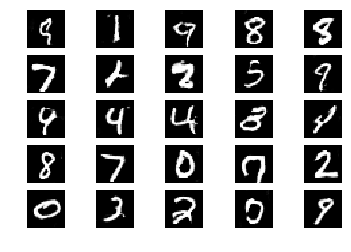

901 [D loss: 0.629136, acc.: 63.87%] [G loss: 1.017635]
902 [D loss: 0.569624, acc.: 70.70%] [G loss: 1.106337]
903 [D loss: 0.612891, acc.: 63.09%] [G loss: 1.065904]
904 [D loss: 0.661636, acc.: 58.98%] [G loss: 1.243161]
905 [D loss: 0.592109, acc.: 69.34%] [G loss: 1.330516]
906 [D loss: 0.729121, acc.: 55.47%] [G loss: 1.071617]
907 [D loss: 0.614715, acc.: 68.16%] [G loss: 1.057336]
908 [D loss: 0.658565, acc.: 59.57%] [G loss: 1.122497]
909 [D loss: 0.655179, acc.: 62.30%] [G loss: 1.318080]
910 [D loss: 0.687104, acc.: 56.45%] [G loss: 1.099933]
911 [D loss: 0.661088, acc.: 62.70%] [G loss: 1.148051]
912 [D loss: 0.623331, acc.: 66.21%] [G loss: 1.275295]
913 [D loss: 0.560875, acc.: 70.31%] [G loss: 0.987435]
914 [D loss: 0.580300, acc.: 69.92%] [G loss: 1.032941]
915 [D loss: 0.697898, acc.: 58.40%] [G loss: 0.911019]
916 [D loss: 0.624112, acc.: 64.65%] [G loss: 1.308683]
917 [D loss: 0.636624, acc.: 62.50%] [G loss: 1.127445]
918 [D loss: 0.640452, acc.: 62.70%] [G loss: 0.

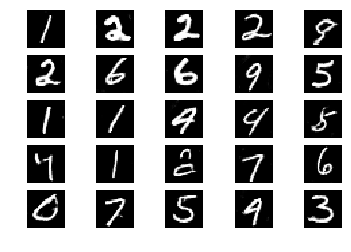

951 [D loss: 0.664098, acc.: 59.96%] [G loss: 0.984163]
952 [D loss: 0.655543, acc.: 59.57%] [G loss: 1.044009]
953 [D loss: 0.576438, acc.: 70.51%] [G loss: 1.030632]
954 [D loss: 0.564410, acc.: 74.61%] [G loss: 1.200430]
955 [D loss: 0.639835, acc.: 64.06%] [G loss: 1.347377]
956 [D loss: 0.685793, acc.: 58.98%] [G loss: 1.182471]
957 [D loss: 0.582564, acc.: 69.34%] [G loss: 0.961396]
958 [D loss: 0.653824, acc.: 58.01%] [G loss: 0.885680]
959 [D loss: 0.566529, acc.: 70.12%] [G loss: 1.060636]
960 [D loss: 0.561068, acc.: 69.73%] [G loss: 1.197490]
961 [D loss: 0.590150, acc.: 67.97%] [G loss: 0.884298]
962 [D loss: 0.628859, acc.: 64.26%] [G loss: 1.177904]
963 [D loss: 0.654210, acc.: 59.96%] [G loss: 1.069301]
964 [D loss: 0.629985, acc.: 64.84%] [G loss: 0.974546]
965 [D loss: 0.642597, acc.: 61.52%] [G loss: 1.186376]
966 [D loss: 0.608508, acc.: 66.21%] [G loss: 1.074359]
967 [D loss: 0.672219, acc.: 59.77%] [G loss: 1.150388]
968 [D loss: 0.589613, acc.: 69.73%] [G loss: 1.

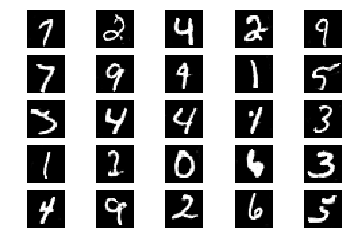

1001 [D loss: 0.602039, acc.: 68.16%] [G loss: 1.287876]
1002 [D loss: 0.648809, acc.: 61.91%] [G loss: 1.113143]
1003 [D loss: 0.616286, acc.: 66.99%] [G loss: 1.073033]
1004 [D loss: 0.742111, acc.: 50.78%] [G loss: 1.106086]
1005 [D loss: 0.611399, acc.: 67.38%] [G loss: 1.262326]
1006 [D loss: 0.550506, acc.: 71.09%] [G loss: 1.281611]
1007 [D loss: 0.584888, acc.: 65.82%] [G loss: 1.038611]
1008 [D loss: 0.620583, acc.: 66.41%] [G loss: 1.015387]
1009 [D loss: 0.619400, acc.: 65.23%] [G loss: 1.012668]
1010 [D loss: 0.760044, acc.: 48.83%] [G loss: 1.217458]
1011 [D loss: 0.547588, acc.: 74.61%] [G loss: 1.089287]
1012 [D loss: 0.624393, acc.: 66.21%] [G loss: 1.139825]
1013 [D loss: 0.598379, acc.: 67.38%] [G loss: 1.230568]
1014 [D loss: 0.687721, acc.: 58.20%] [G loss: 1.002273]
1015 [D loss: 0.605176, acc.: 64.84%] [G loss: 1.198575]
1016 [D loss: 0.602045, acc.: 66.60%] [G loss: 1.069165]
1017 [D loss: 0.646239, acc.: 63.87%] [G loss: 1.071643]
1018 [D loss: 0.662943, acc.: 6

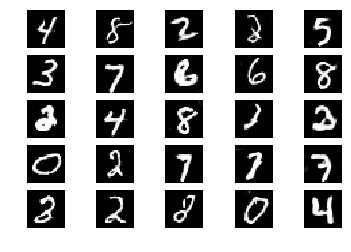

1051 [D loss: 0.605959, acc.: 67.38%] [G loss: 1.049788]
1052 [D loss: 0.583752, acc.: 68.16%] [G loss: 1.199850]
1053 [D loss: 0.647370, acc.: 63.28%] [G loss: 1.047426]
1054 [D loss: 0.603199, acc.: 69.14%] [G loss: 1.049470]
1055 [D loss: 0.590603, acc.: 69.14%] [G loss: 1.320794]
1056 [D loss: 0.610333, acc.: 66.99%] [G loss: 1.221544]
1057 [D loss: 0.682716, acc.: 59.96%] [G loss: 1.037425]
1058 [D loss: 0.657676, acc.: 62.30%] [G loss: 1.065301]
1059 [D loss: 0.582681, acc.: 69.73%] [G loss: 1.114243]
1060 [D loss: 0.673503, acc.: 58.40%] [G loss: 0.960216]
1061 [D loss: 0.632315, acc.: 64.45%] [G loss: 1.066272]
1062 [D loss: 0.662085, acc.: 59.18%] [G loss: 1.045724]
1063 [D loss: 0.591112, acc.: 69.34%] [G loss: 1.086862]
1064 [D loss: 0.673262, acc.: 59.96%] [G loss: 1.074975]
1065 [D loss: 0.627806, acc.: 67.58%] [G loss: 1.236337]
1066 [D loss: 0.602525, acc.: 68.55%] [G loss: 1.052607]
1067 [D loss: 0.617241, acc.: 66.21%] [G loss: 1.213363]
1068 [D loss: 0.708411, acc.: 5

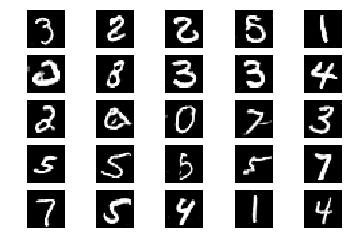

1101 [D loss: 0.594299, acc.: 70.12%] [G loss: 1.338620]
1102 [D loss: 0.597718, acc.: 67.97%] [G loss: 1.236424]
1103 [D loss: 0.605080, acc.: 66.41%] [G loss: 1.357495]
1104 [D loss: 0.607749, acc.: 65.43%] [G loss: 1.026686]
1105 [D loss: 0.733389, acc.: 48.24%] [G loss: 1.008144]
1106 [D loss: 0.575321, acc.: 69.73%] [G loss: 1.057648]
1107 [D loss: 0.649221, acc.: 62.50%] [G loss: 1.149850]
1108 [D loss: 0.731777, acc.: 54.30%] [G loss: 1.018349]
1109 [D loss: 0.708746, acc.: 54.88%] [G loss: 1.041688]
1110 [D loss: 0.785845, acc.: 49.02%] [G loss: 1.076635]
1111 [D loss: 0.781942, acc.: 48.44%] [G loss: 1.149284]
1112 [D loss: 0.666215, acc.: 59.96%] [G loss: 0.807029]
1113 [D loss: 0.647346, acc.: 63.48%] [G loss: 0.948744]
1114 [D loss: 0.635485, acc.: 64.26%] [G loss: 1.010388]
1115 [D loss: 0.639490, acc.: 61.91%] [G loss: 0.959262]
1116 [D loss: 0.524338, acc.: 76.76%] [G loss: 1.068548]
1117 [D loss: 0.615663, acc.: 64.45%] [G loss: 0.997937]
1118 [D loss: 0.577806, acc.: 7

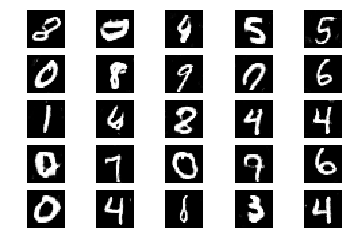

1151 [D loss: 0.718325, acc.: 53.52%] [G loss: 1.064332]
1152 [D loss: 0.703621, acc.: 56.05%] [G loss: 1.041949]
1153 [D loss: 0.585401, acc.: 69.92%] [G loss: 1.084551]
1154 [D loss: 0.667410, acc.: 61.13%] [G loss: 1.200753]
1155 [D loss: 0.546759, acc.: 74.41%] [G loss: 1.276240]
1156 [D loss: 0.621806, acc.: 64.84%] [G loss: 1.039449]
1157 [D loss: 0.654125, acc.: 61.52%] [G loss: 1.051090]
1158 [D loss: 0.647186, acc.: 61.13%] [G loss: 1.085546]
1159 [D loss: 0.634998, acc.: 63.67%] [G loss: 1.156032]
1160 [D loss: 0.508675, acc.: 77.93%] [G loss: 1.048608]
1161 [D loss: 0.524401, acc.: 76.17%] [G loss: 1.316891]
1162 [D loss: 0.672625, acc.: 59.57%] [G loss: 1.079373]
1163 [D loss: 0.670834, acc.: 59.38%] [G loss: 1.156855]
1164 [D loss: 0.587670, acc.: 69.53%] [G loss: 1.257302]
1165 [D loss: 0.498822, acc.: 78.91%] [G loss: 1.213788]
1166 [D loss: 0.703033, acc.: 55.27%] [G loss: 0.977802]
1167 [D loss: 0.581665, acc.: 71.29%] [G loss: 1.207634]
1168 [D loss: 0.626675, acc.: 6

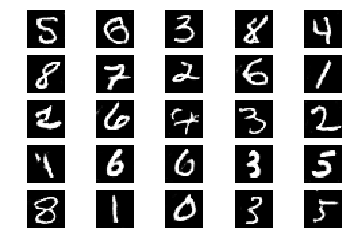

1201 [D loss: 0.676218, acc.: 58.59%] [G loss: 1.108379]
1202 [D loss: 0.650160, acc.: 61.33%] [G loss: 1.068041]
1203 [D loss: 0.705155, acc.: 57.23%] [G loss: 1.169579]
1204 [D loss: 0.639672, acc.: 62.89%] [G loss: 0.985224]
1205 [D loss: 0.681982, acc.: 57.81%] [G loss: 0.977303]
1206 [D loss: 0.740827, acc.: 52.15%] [G loss: 0.980643]
1207 [D loss: 0.703394, acc.: 54.69%] [G loss: 1.106997]
1208 [D loss: 0.579855, acc.: 70.31%] [G loss: 1.390639]
1209 [D loss: 0.665848, acc.: 59.96%] [G loss: 1.118752]
1210 [D loss: 0.684907, acc.: 57.42%] [G loss: 1.054253]
1211 [D loss: 0.612397, acc.: 66.41%] [G loss: 1.156865]
1212 [D loss: 0.694659, acc.: 57.03%] [G loss: 1.135681]
1213 [D loss: 0.647873, acc.: 61.13%] [G loss: 1.344010]
1214 [D loss: 0.620082, acc.: 64.65%] [G loss: 1.040980]
1215 [D loss: 0.568248, acc.: 71.88%] [G loss: 1.342443]
1216 [D loss: 0.580850, acc.: 71.48%] [G loss: 1.223559]
1217 [D loss: 0.669211, acc.: 59.38%] [G loss: 1.173034]
1218 [D loss: 0.729851, acc.: 5

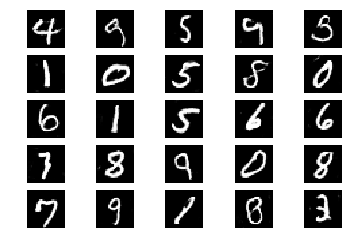

1251 [D loss: 0.626709, acc.: 63.67%] [G loss: 1.121262]
1252 [D loss: 0.688585, acc.: 58.01%] [G loss: 1.066198]
1253 [D loss: 0.543775, acc.: 74.02%] [G loss: 0.983049]
1254 [D loss: 0.607666, acc.: 65.04%] [G loss: 0.958103]
1255 [D loss: 0.653695, acc.: 62.50%] [G loss: 1.096183]
1256 [D loss: 0.596666, acc.: 67.19%] [G loss: 1.197168]
1257 [D loss: 0.658972, acc.: 59.77%] [G loss: 1.191010]
1258 [D loss: 0.644361, acc.: 62.11%] [G loss: 1.039976]
1259 [D loss: 0.653401, acc.: 62.50%] [G loss: 1.064304]
1260 [D loss: 0.683872, acc.: 58.59%] [G loss: 1.198584]
1261 [D loss: 0.532259, acc.: 76.95%] [G loss: 1.131171]
1262 [D loss: 0.659484, acc.: 61.33%] [G loss: 1.148587]
1263 [D loss: 0.557938, acc.: 73.05%] [G loss: 1.270434]
1264 [D loss: 0.621079, acc.: 68.36%] [G loss: 1.136762]
1265 [D loss: 0.657191, acc.: 59.77%] [G loss: 1.095995]
1266 [D loss: 0.584823, acc.: 70.70%] [G loss: 1.047521]
1267 [D loss: 0.649307, acc.: 61.91%] [G loss: 1.167769]
1268 [D loss: 0.727960, acc.: 5

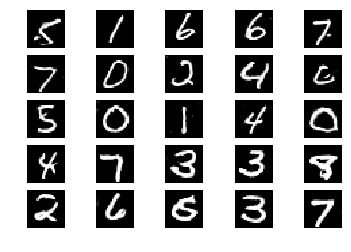

1301 [D loss: 0.726426, acc.: 54.30%] [G loss: 1.117448]
1302 [D loss: 0.683027, acc.: 55.86%] [G loss: 1.219560]
1303 [D loss: 0.730618, acc.: 51.95%] [G loss: 1.253849]
1304 [D loss: 0.591881, acc.: 66.80%] [G loss: 1.142252]
1305 [D loss: 0.706887, acc.: 56.05%] [G loss: 1.131644]
1306 [D loss: 0.559952, acc.: 71.09%] [G loss: 1.264939]
1307 [D loss: 0.654136, acc.: 61.72%] [G loss: 0.926762]
1308 [D loss: 0.697718, acc.: 54.69%] [G loss: 1.141137]
1309 [D loss: 0.682074, acc.: 56.64%] [G loss: 1.088780]
1310 [D loss: 0.637231, acc.: 63.67%] [G loss: 1.035158]
1311 [D loss: 0.643562, acc.: 64.45%] [G loss: 1.151153]
1312 [D loss: 0.620095, acc.: 63.87%] [G loss: 1.212371]
1313 [D loss: 0.607769, acc.: 64.84%] [G loss: 1.196903]
1314 [D loss: 0.612037, acc.: 66.99%] [G loss: 1.054475]
1315 [D loss: 0.634064, acc.: 65.62%] [G loss: 0.983703]
1316 [D loss: 0.715171, acc.: 53.32%] [G loss: 1.137642]
1317 [D loss: 0.617990, acc.: 64.65%] [G loss: 1.094582]
1318 [D loss: 0.618482, acc.: 6

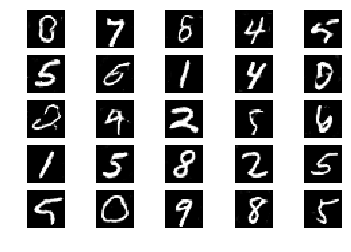

1351 [D loss: 0.667133, acc.: 58.79%] [G loss: 1.173985]
1352 [D loss: 0.648806, acc.: 61.91%] [G loss: 0.917016]
1353 [D loss: 0.589771, acc.: 68.16%] [G loss: 0.933370]
1354 [D loss: 0.759553, acc.: 49.22%] [G loss: 0.903199]
1355 [D loss: 0.618838, acc.: 63.67%] [G loss: 1.116030]
1356 [D loss: 0.654456, acc.: 62.11%] [G loss: 1.227329]
1357 [D loss: 0.603126, acc.: 67.97%] [G loss: 1.079570]
1358 [D loss: 0.687394, acc.: 60.16%] [G loss: 1.058665]
1359 [D loss: 0.630556, acc.: 63.28%] [G loss: 1.088416]
1360 [D loss: 0.631124, acc.: 63.67%] [G loss: 1.230059]
1361 [D loss: 0.675362, acc.: 58.20%] [G loss: 1.016149]
1362 [D loss: 0.684972, acc.: 59.96%] [G loss: 1.049494]
1363 [D loss: 0.638664, acc.: 62.70%] [G loss: 1.096130]
1364 [D loss: 0.586369, acc.: 67.38%] [G loss: 1.047884]
1365 [D loss: 0.599989, acc.: 68.36%] [G loss: 1.005707]
1366 [D loss: 0.684081, acc.: 60.16%] [G loss: 1.072239]
1367 [D loss: 0.620268, acc.: 66.21%] [G loss: 1.144611]
1368 [D loss: 0.489604, acc.: 7

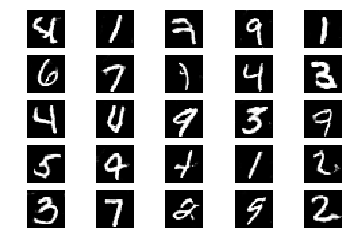

1401 [D loss: 0.683811, acc.: 56.25%] [G loss: 1.102538]
1402 [D loss: 0.678992, acc.: 59.57%] [G loss: 1.106394]
1403 [D loss: 0.572692, acc.: 70.70%] [G loss: 1.162180]
1404 [D loss: 0.660386, acc.: 61.52%] [G loss: 1.150790]
1405 [D loss: 0.744615, acc.: 50.20%] [G loss: 1.129537]
1406 [D loss: 0.544113, acc.: 73.24%] [G loss: 1.101132]
1407 [D loss: 0.659053, acc.: 62.30%] [G loss: 1.077441]
1408 [D loss: 0.499322, acc.: 77.15%] [G loss: 1.224060]
1409 [D loss: 0.637887, acc.: 63.87%] [G loss: 1.087481]
1410 [D loss: 0.573849, acc.: 69.53%] [G loss: 1.166521]
1411 [D loss: 0.672038, acc.: 61.33%] [G loss: 1.084481]
1412 [D loss: 0.589764, acc.: 68.75%] [G loss: 1.105368]
1413 [D loss: 0.635255, acc.: 65.62%] [G loss: 1.491630]
1414 [D loss: 0.678670, acc.: 56.45%] [G loss: 1.123211]
1415 [D loss: 0.645808, acc.: 62.30%] [G loss: 1.058325]
1416 [D loss: 0.538965, acc.: 73.83%] [G loss: 1.180555]
1417 [D loss: 0.561042, acc.: 71.09%] [G loss: 1.075260]
1418 [D loss: 0.558008, acc.: 7

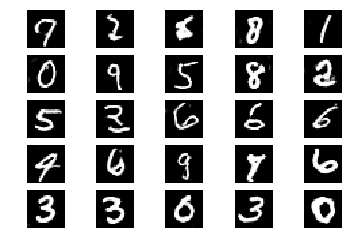

1451 [D loss: 0.673845, acc.: 59.18%] [G loss: 1.117557]
1452 [D loss: 0.691462, acc.: 54.30%] [G loss: 1.132549]
1453 [D loss: 0.637716, acc.: 63.28%] [G loss: 1.226035]
1454 [D loss: 0.688287, acc.: 58.20%] [G loss: 1.144315]
1455 [D loss: 0.692849, acc.: 58.40%] [G loss: 0.886649]
1456 [D loss: 0.624189, acc.: 63.67%] [G loss: 1.025309]
1457 [D loss: 0.656602, acc.: 59.77%] [G loss: 1.046189]
1458 [D loss: 0.825868, acc.: 43.16%] [G loss: 0.976656]
1459 [D loss: 0.570083, acc.: 71.68%] [G loss: 1.106681]
1460 [D loss: 0.639949, acc.: 64.06%] [G loss: 1.092859]
1461 [D loss: 0.624380, acc.: 66.41%] [G loss: 1.199382]
1462 [D loss: 0.633792, acc.: 62.30%] [G loss: 0.995338]
1463 [D loss: 0.652209, acc.: 62.89%] [G loss: 1.109663]
1464 [D loss: 0.625035, acc.: 63.87%] [G loss: 0.938024]
1465 [D loss: 0.703042, acc.: 57.42%] [G loss: 1.143276]
1466 [D loss: 0.569705, acc.: 72.66%] [G loss: 1.079838]
1467 [D loss: 0.692958, acc.: 58.20%] [G loss: 1.159271]
1468 [D loss: 0.660263, acc.: 5

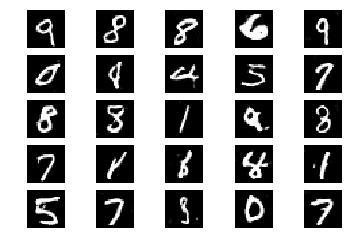

1501 [D loss: 0.691083, acc.: 59.77%] [G loss: 1.051603]
1502 [D loss: 0.656866, acc.: 60.35%] [G loss: 1.100483]
1503 [D loss: 0.705657, acc.: 56.05%] [G loss: 1.069478]
1504 [D loss: 0.530718, acc.: 76.17%] [G loss: 1.181199]
1505 [D loss: 0.663454, acc.: 59.18%] [G loss: 0.969413]
1506 [D loss: 0.598868, acc.: 68.95%] [G loss: 1.049206]
1507 [D loss: 0.639096, acc.: 63.48%] [G loss: 1.106313]
1508 [D loss: 0.669577, acc.: 57.23%] [G loss: 0.996248]
1509 [D loss: 0.553872, acc.: 73.63%] [G loss: 1.102619]
1510 [D loss: 0.726428, acc.: 51.17%] [G loss: 1.098052]
1511 [D loss: 0.622974, acc.: 67.19%] [G loss: 1.076938]
1512 [D loss: 0.630984, acc.: 64.26%] [G loss: 1.140384]
1513 [D loss: 0.777692, acc.: 50.78%] [G loss: 0.977248]
1514 [D loss: 0.630269, acc.: 62.11%] [G loss: 1.065027]
1515 [D loss: 0.599622, acc.: 66.21%] [G loss: 1.208771]
1516 [D loss: 0.671621, acc.: 59.96%] [G loss: 0.995710]
1517 [D loss: 0.707235, acc.: 54.69%] [G loss: 1.164977]
1518 [D loss: 0.705630, acc.: 5

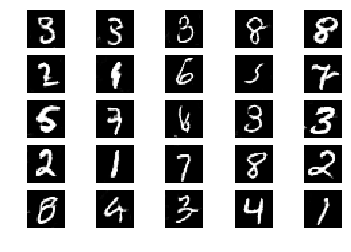

1551 [D loss: 0.722664, acc.: 54.30%] [G loss: 1.018180]
1552 [D loss: 0.582130, acc.: 69.92%] [G loss: 1.085721]
1553 [D loss: 0.583899, acc.: 70.70%] [G loss: 1.220918]
1554 [D loss: 0.585746, acc.: 70.51%] [G loss: 1.122885]
1555 [D loss: 0.671151, acc.: 59.38%] [G loss: 1.143503]
1556 [D loss: 0.613627, acc.: 67.38%] [G loss: 1.157523]
1557 [D loss: 0.688764, acc.: 56.05%] [G loss: 1.187699]
1558 [D loss: 0.621526, acc.: 66.60%] [G loss: 1.144353]
1559 [D loss: 0.595663, acc.: 69.53%] [G loss: 1.221866]
1560 [D loss: 0.646664, acc.: 62.11%] [G loss: 1.370997]
1561 [D loss: 0.634824, acc.: 66.41%] [G loss: 1.136248]
1562 [D loss: 0.653250, acc.: 60.74%] [G loss: 1.139477]
1563 [D loss: 0.688506, acc.: 58.98%] [G loss: 1.019896]
1564 [D loss: 0.500030, acc.: 79.88%] [G loss: 1.167824]
1565 [D loss: 0.703843, acc.: 56.25%] [G loss: 0.944801]
1566 [D loss: 0.780745, acc.: 45.51%] [G loss: 0.895192]
1567 [D loss: 0.600783, acc.: 68.55%] [G loss: 1.147192]
1568 [D loss: 0.675490, acc.: 6

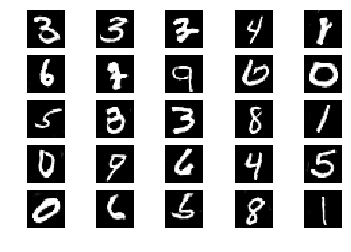

1601 [D loss: 0.666440, acc.: 59.96%] [G loss: 1.077660]
1602 [D loss: 0.568061, acc.: 74.02%] [G loss: 1.127811]
1603 [D loss: 0.632813, acc.: 65.82%] [G loss: 1.106169]
1604 [D loss: 0.690180, acc.: 57.42%] [G loss: 1.193536]
1605 [D loss: 0.731000, acc.: 56.45%] [G loss: 1.107407]
1606 [D loss: 0.612629, acc.: 68.95%] [G loss: 1.158902]
1607 [D loss: 0.625077, acc.: 65.23%] [G loss: 1.048514]
1608 [D loss: 0.536857, acc.: 74.22%] [G loss: 1.232096]
1609 [D loss: 0.595524, acc.: 66.80%] [G loss: 1.116107]
1610 [D loss: 0.583633, acc.: 68.95%] [G loss: 1.081362]
1611 [D loss: 0.720384, acc.: 56.45%] [G loss: 1.141423]
1612 [D loss: 0.583838, acc.: 73.05%] [G loss: 1.112576]
1613 [D loss: 0.633975, acc.: 64.65%] [G loss: 1.119065]
1614 [D loss: 0.607848, acc.: 66.41%] [G loss: 1.231455]
1615 [D loss: 0.601406, acc.: 68.16%] [G loss: 1.150934]
1616 [D loss: 0.626470, acc.: 65.62%] [G loss: 1.092541]
1617 [D loss: 0.578234, acc.: 70.12%] [G loss: 1.076946]
1618 [D loss: 0.592520, acc.: 6

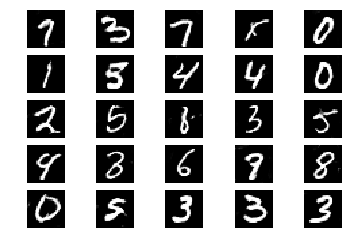

1651 [D loss: 0.699487, acc.: 56.84%] [G loss: 1.189998]
1652 [D loss: 0.668097, acc.: 59.18%] [G loss: 0.958798]
1653 [D loss: 0.664293, acc.: 61.52%] [G loss: 1.088428]
1654 [D loss: 0.539640, acc.: 76.76%] [G loss: 1.131882]
1655 [D loss: 0.691567, acc.: 58.01%] [G loss: 1.043199]
1656 [D loss: 0.636485, acc.: 61.52%] [G loss: 1.177029]
1657 [D loss: 0.699085, acc.: 55.27%] [G loss: 1.172565]
1658 [D loss: 0.577875, acc.: 70.90%] [G loss: 1.181767]
1659 [D loss: 0.583866, acc.: 69.34%] [G loss: 1.087224]
1660 [D loss: 0.605875, acc.: 67.58%] [G loss: 1.129429]
1661 [D loss: 0.590650, acc.: 68.55%] [G loss: 1.171631]
1662 [D loss: 0.681159, acc.: 60.74%] [G loss: 1.076922]
1663 [D loss: 0.672200, acc.: 59.57%] [G loss: 1.416395]
1664 [D loss: 0.618257, acc.: 66.60%] [G loss: 1.278281]
1665 [D loss: 0.579248, acc.: 69.73%] [G loss: 1.140533]
1666 [D loss: 0.794150, acc.: 50.20%] [G loss: 1.159880]
1667 [D loss: 0.620206, acc.: 66.21%] [G loss: 1.206829]
1668 [D loss: 0.632501, acc.: 6

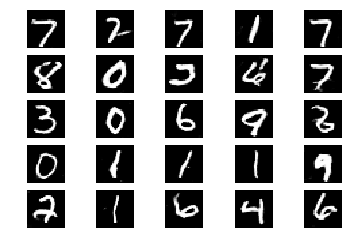

1701 [D loss: 0.714198, acc.: 53.71%] [G loss: 0.953239]
1702 [D loss: 0.668791, acc.: 58.20%] [G loss: 1.136064]
1703 [D loss: 0.645025, acc.: 59.57%] [G loss: 1.132743]
1704 [D loss: 0.655499, acc.: 60.55%] [G loss: 1.060793]
1705 [D loss: 0.586027, acc.: 69.73%] [G loss: 1.190658]
1706 [D loss: 0.750932, acc.: 51.95%] [G loss: 1.192323]
1707 [D loss: 0.661332, acc.: 61.33%] [G loss: 1.215792]
1708 [D loss: 0.618522, acc.: 65.43%] [G loss: 1.067691]
1709 [D loss: 0.587991, acc.: 70.31%] [G loss: 1.169515]
1710 [D loss: 0.579676, acc.: 70.51%] [G loss: 1.017269]
1711 [D loss: 0.575275, acc.: 70.90%] [G loss: 1.050317]
1712 [D loss: 0.703504, acc.: 55.66%] [G loss: 1.255565]
1713 [D loss: 0.639498, acc.: 64.26%] [G loss: 0.938222]
1714 [D loss: 0.657578, acc.: 64.26%] [G loss: 0.987464]
1715 [D loss: 0.650974, acc.: 61.52%] [G loss: 1.005692]
1716 [D loss: 0.672852, acc.: 60.35%] [G loss: 1.040099]
1717 [D loss: 0.614585, acc.: 67.97%] [G loss: 1.044496]
1718 [D loss: 0.641919, acc.: 6

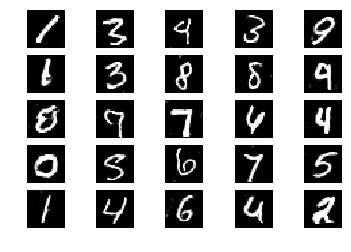

1751 [D loss: 0.677047, acc.: 59.38%] [G loss: 0.841130]
1752 [D loss: 0.633582, acc.: 65.23%] [G loss: 1.020103]
1753 [D loss: 0.607888, acc.: 68.36%] [G loss: 1.036281]
1754 [D loss: 0.545081, acc.: 74.02%] [G loss: 1.042585]
1755 [D loss: 0.696251, acc.: 55.27%] [G loss: 1.028149]
1756 [D loss: 0.626220, acc.: 62.50%] [G loss: 1.107524]
1757 [D loss: 0.628048, acc.: 64.06%] [G loss: 1.245220]
1758 [D loss: 0.633174, acc.: 62.30%] [G loss: 1.236143]
1759 [D loss: 0.636703, acc.: 64.26%] [G loss: 1.154073]
1760 [D loss: 0.691498, acc.: 54.88%] [G loss: 1.121076]
1761 [D loss: 0.688667, acc.: 57.42%] [G loss: 1.144893]
1762 [D loss: 0.607355, acc.: 64.84%] [G loss: 1.110596]
1763 [D loss: 0.676290, acc.: 59.96%] [G loss: 1.153766]
1764 [D loss: 0.748827, acc.: 49.22%] [G loss: 0.950591]
1765 [D loss: 0.649824, acc.: 62.70%] [G loss: 1.130409]
1766 [D loss: 0.643231, acc.: 64.84%] [G loss: 0.996762]
1767 [D loss: 0.657962, acc.: 63.48%] [G loss: 1.058886]
1768 [D loss: 0.670739, acc.: 6

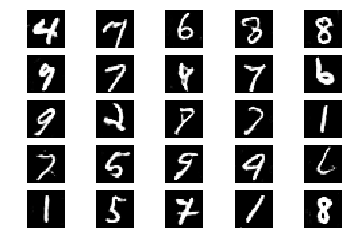

1801 [D loss: 0.591155, acc.: 69.53%] [G loss: 1.436579]
1802 [D loss: 0.642261, acc.: 62.70%] [G loss: 1.195225]
1803 [D loss: 0.644345, acc.: 60.74%] [G loss: 0.909413]
1804 [D loss: 0.576879, acc.: 71.09%] [G loss: 1.053063]
1805 [D loss: 0.624685, acc.: 64.45%] [G loss: 1.209059]
1806 [D loss: 0.626620, acc.: 67.97%] [G loss: 1.174020]
1807 [D loss: 0.628154, acc.: 63.28%] [G loss: 0.998758]
1808 [D loss: 0.548897, acc.: 75.20%] [G loss: 1.162232]
1809 [D loss: 0.558635, acc.: 72.46%] [G loss: 1.129530]
1810 [D loss: 0.631703, acc.: 65.04%] [G loss: 1.295955]
1811 [D loss: 0.594995, acc.: 69.92%] [G loss: 1.220526]
1812 [D loss: 0.644642, acc.: 61.13%] [G loss: 1.023785]
1813 [D loss: 0.650022, acc.: 63.48%] [G loss: 1.072861]
1814 [D loss: 0.659353, acc.: 61.13%] [G loss: 1.095325]
1815 [D loss: 0.712095, acc.: 55.08%] [G loss: 0.971442]
1816 [D loss: 0.639032, acc.: 63.67%] [G loss: 0.945260]
1817 [D loss: 0.627973, acc.: 66.60%] [G loss: 1.015527]
1818 [D loss: 0.623500, acc.: 6

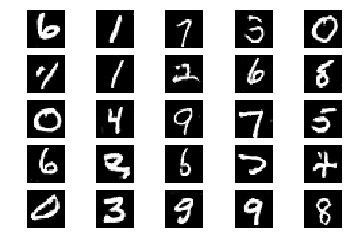

1851 [D loss: 0.634710, acc.: 64.26%] [G loss: 1.139688]
1852 [D loss: 0.645092, acc.: 62.30%] [G loss: 1.146451]
1853 [D loss: 0.629507, acc.: 65.23%] [G loss: 1.238207]
1854 [D loss: 0.742020, acc.: 51.76%] [G loss: 1.050919]
1855 [D loss: 0.675933, acc.: 59.96%] [G loss: 0.966353]
1856 [D loss: 0.645144, acc.: 62.11%] [G loss: 1.013093]
1857 [D loss: 0.662219, acc.: 60.94%] [G loss: 1.202515]
1858 [D loss: 0.592593, acc.: 69.92%] [G loss: 1.138677]
1859 [D loss: 0.554100, acc.: 74.61%] [G loss: 1.137059]
1860 [D loss: 0.754522, acc.: 51.56%] [G loss: 1.143487]
1861 [D loss: 0.666442, acc.: 59.18%] [G loss: 1.028129]
1862 [D loss: 0.581313, acc.: 68.95%] [G loss: 1.147562]
1863 [D loss: 0.648248, acc.: 62.70%] [G loss: 1.077292]
1864 [D loss: 0.632582, acc.: 65.23%] [G loss: 1.203578]
1865 [D loss: 0.715681, acc.: 55.08%] [G loss: 1.095120]
1866 [D loss: 0.704756, acc.: 54.88%] [G loss: 1.047614]
1867 [D loss: 0.756569, acc.: 48.24%] [G loss: 1.130269]
1868 [D loss: 0.551364, acc.: 7

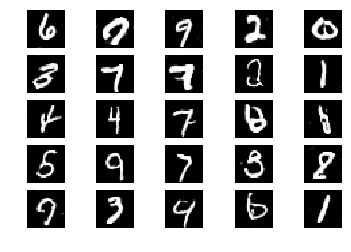

1901 [D loss: 0.572708, acc.: 69.53%] [G loss: 1.160856]
1902 [D loss: 0.640422, acc.: 62.50%] [G loss: 0.927505]
1903 [D loss: 0.614058, acc.: 66.21%] [G loss: 1.019750]
1904 [D loss: 0.653056, acc.: 62.50%] [G loss: 1.003312]
1905 [D loss: 0.594171, acc.: 68.55%] [G loss: 1.000375]
1906 [D loss: 0.603534, acc.: 68.95%] [G loss: 1.337981]
1907 [D loss: 0.644012, acc.: 63.67%] [G loss: 1.055140]
1908 [D loss: 0.612025, acc.: 65.82%] [G loss: 0.930844]
1909 [D loss: 0.779002, acc.: 47.66%] [G loss: 1.036442]
1910 [D loss: 0.528422, acc.: 76.95%] [G loss: 1.313968]
1911 [D loss: 0.605569, acc.: 67.19%] [G loss: 0.970102]
1912 [D loss: 0.675715, acc.: 59.38%] [G loss: 1.039073]
1913 [D loss: 0.642631, acc.: 61.91%] [G loss: 1.080503]
1914 [D loss: 0.657635, acc.: 61.33%] [G loss: 1.228963]
1915 [D loss: 0.603890, acc.: 68.75%] [G loss: 1.003383]
1916 [D loss: 0.569263, acc.: 70.70%] [G loss: 1.002209]
1917 [D loss: 0.560680, acc.: 70.90%] [G loss: 0.999486]
1918 [D loss: 0.684280, acc.: 5

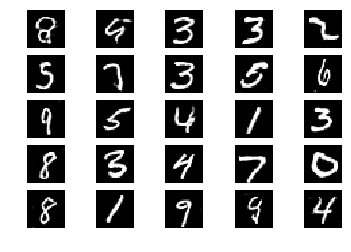

1951 [D loss: 0.693170, acc.: 55.66%] [G loss: 0.816837]
1952 [D loss: 0.602286, acc.: 64.06%] [G loss: 1.188163]
1953 [D loss: 0.679335, acc.: 58.40%] [G loss: 0.972520]
1954 [D loss: 0.596261, acc.: 67.19%] [G loss: 1.167035]
1955 [D loss: 0.680759, acc.: 59.96%] [G loss: 0.987248]
1956 [D loss: 0.583319, acc.: 71.29%] [G loss: 0.975749]
1957 [D loss: 0.611143, acc.: 64.84%] [G loss: 1.014472]
1958 [D loss: 0.590965, acc.: 68.95%] [G loss: 0.978134]
1959 [D loss: 0.625013, acc.: 66.21%] [G loss: 0.926164]
1960 [D loss: 0.673615, acc.: 58.79%] [G loss: 1.095838]
1961 [D loss: 0.571581, acc.: 70.90%] [G loss: 1.168918]
1962 [D loss: 0.627006, acc.: 66.02%] [G loss: 1.230559]
1963 [D loss: 0.667639, acc.: 62.50%] [G loss: 1.091859]
1964 [D loss: 0.625112, acc.: 63.67%] [G loss: 1.015351]
1965 [D loss: 0.610089, acc.: 66.99%] [G loss: 0.972985]
1966 [D loss: 0.605201, acc.: 67.19%] [G loss: 1.166525]
1967 [D loss: 0.527620, acc.: 76.56%] [G loss: 1.215285]
1968 [D loss: 0.656173, acc.: 6

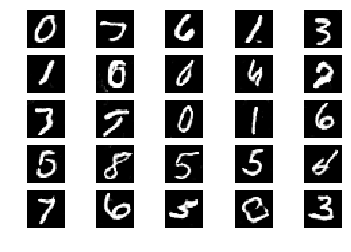

2001 [D loss: 0.710435, acc.: 55.27%] [G loss: 1.154075]
2002 [D loss: 0.621697, acc.: 64.65%] [G loss: 1.013288]
2003 [D loss: 0.544260, acc.: 75.39%] [G loss: 1.322233]
2004 [D loss: 0.645583, acc.: 63.87%] [G loss: 1.078299]
2005 [D loss: 0.674468, acc.: 57.03%] [G loss: 1.080061]
2006 [D loss: 0.546865, acc.: 75.39%] [G loss: 1.161629]
2007 [D loss: 0.682377, acc.: 59.38%] [G loss: 1.078284]
2008 [D loss: 0.659753, acc.: 62.70%] [G loss: 1.048085]
2009 [D loss: 0.651409, acc.: 61.91%] [G loss: 1.044485]
2010 [D loss: 0.574000, acc.: 71.88%] [G loss: 0.983455]
2011 [D loss: 0.653197, acc.: 62.11%] [G loss: 0.999960]
2012 [D loss: 0.654297, acc.: 60.55%] [G loss: 1.297529]
2013 [D loss: 0.654784, acc.: 61.91%] [G loss: 1.059805]
2014 [D loss: 0.567756, acc.: 71.09%] [G loss: 1.114193]
2015 [D loss: 0.561932, acc.: 71.88%] [G loss: 1.066921]
2016 [D loss: 0.644486, acc.: 61.13%] [G loss: 1.116963]
2017 [D loss: 0.619253, acc.: 65.43%] [G loss: 1.045324]
2018 [D loss: 0.608697, acc.: 6

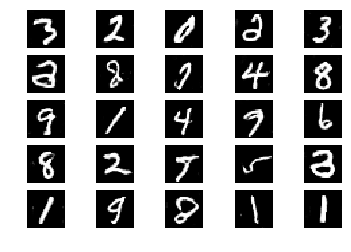

2051 [D loss: 0.600803, acc.: 67.19%] [G loss: 1.337474]
2052 [D loss: 0.618356, acc.: 66.21%] [G loss: 1.163349]
2053 [D loss: 0.617098, acc.: 65.43%] [G loss: 1.070698]
2054 [D loss: 0.544562, acc.: 76.95%] [G loss: 1.163047]
2055 [D loss: 0.530677, acc.: 75.20%] [G loss: 1.121369]
2056 [D loss: 0.698655, acc.: 54.69%] [G loss: 1.025733]
2057 [D loss: 0.567041, acc.: 71.09%] [G loss: 0.909621]
2058 [D loss: 0.669376, acc.: 61.52%] [G loss: 1.009921]
2059 [D loss: 0.706386, acc.: 53.71%] [G loss: 1.103549]
2060 [D loss: 0.542948, acc.: 74.22%] [G loss: 1.125922]
2061 [D loss: 0.657078, acc.: 59.77%] [G loss: 1.108557]
2062 [D loss: 0.583499, acc.: 69.73%] [G loss: 1.277116]
2063 [D loss: 0.545126, acc.: 72.07%] [G loss: 1.138822]
2064 [D loss: 0.833531, acc.: 42.19%] [G loss: 0.861724]
2065 [D loss: 0.657850, acc.: 60.55%] [G loss: 0.969243]
2066 [D loss: 0.634574, acc.: 65.23%] [G loss: 1.030000]
2067 [D loss: 0.652750, acc.: 64.65%] [G loss: 1.116262]
2068 [D loss: 0.735422, acc.: 5

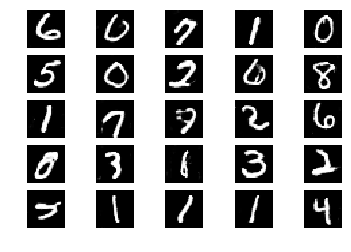

2101 [D loss: 0.643937, acc.: 64.65%] [G loss: 1.072279]
2102 [D loss: 0.594022, acc.: 67.38%] [G loss: 1.069412]
2103 [D loss: 0.730223, acc.: 51.95%] [G loss: 1.224497]
2104 [D loss: 0.661477, acc.: 60.16%] [G loss: 1.197407]
2105 [D loss: 0.799543, acc.: 44.34%] [G loss: 0.870864]
2106 [D loss: 0.662547, acc.: 60.94%] [G loss: 1.135378]
2107 [D loss: 0.594079, acc.: 71.09%] [G loss: 1.265371]
2108 [D loss: 0.650749, acc.: 62.11%] [G loss: 1.123164]
2109 [D loss: 0.557577, acc.: 71.88%] [G loss: 0.981001]
2110 [D loss: 0.553017, acc.: 73.24%] [G loss: 1.089939]
2111 [D loss: 0.608052, acc.: 64.26%] [G loss: 1.218755]
2112 [D loss: 0.601472, acc.: 68.16%] [G loss: 1.308792]
2113 [D loss: 0.606109, acc.: 66.60%] [G loss: 1.159415]
2114 [D loss: 0.615888, acc.: 67.77%] [G loss: 1.163236]
2115 [D loss: 0.552108, acc.: 75.00%] [G loss: 1.286332]
2116 [D loss: 0.619703, acc.: 64.65%] [G loss: 1.157175]
2117 [D loss: 0.628836, acc.: 66.99%] [G loss: 1.243771]
2118 [D loss: 0.644608, acc.: 6

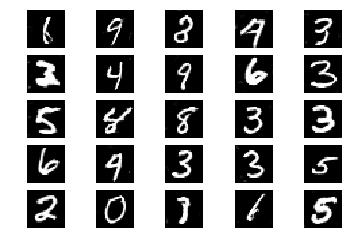

2151 [D loss: 0.677184, acc.: 59.96%] [G loss: 1.132738]
2152 [D loss: 0.650944, acc.: 61.13%] [G loss: 1.083534]
2153 [D loss: 0.563407, acc.: 72.27%] [G loss: 1.207376]
2154 [D loss: 0.591052, acc.: 69.73%] [G loss: 1.108056]
2155 [D loss: 0.569046, acc.: 73.44%] [G loss: 1.109184]
2156 [D loss: 0.714525, acc.: 53.71%] [G loss: 1.057142]
2157 [D loss: 0.582012, acc.: 72.07%] [G loss: 1.021710]
2158 [D loss: 0.670837, acc.: 58.20%] [G loss: 1.234885]
2159 [D loss: 0.566055, acc.: 71.48%] [G loss: 1.131183]
2160 [D loss: 0.627833, acc.: 64.84%] [G loss: 1.119798]
2161 [D loss: 0.590811, acc.: 68.55%] [G loss: 1.198715]
2162 [D loss: 0.637812, acc.: 65.43%] [G loss: 1.068112]
2163 [D loss: 0.664149, acc.: 59.57%] [G loss: 1.095865]
2164 [D loss: 0.592968, acc.: 68.95%] [G loss: 1.390439]
2165 [D loss: 0.622551, acc.: 64.45%] [G loss: 1.204383]
2166 [D loss: 0.764869, acc.: 49.61%] [G loss: 1.141933]
2167 [D loss: 0.717643, acc.: 51.95%] [G loss: 1.022528]
2168 [D loss: 0.663531, acc.: 6

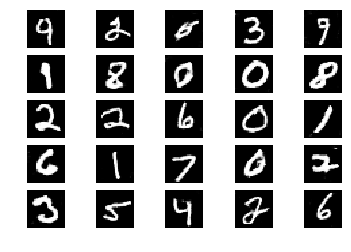

2201 [D loss: 0.564884, acc.: 73.24%] [G loss: 1.129254]
2202 [D loss: 0.620872, acc.: 66.21%] [G loss: 0.997632]
2203 [D loss: 0.667412, acc.: 60.35%] [G loss: 0.963639]
2204 [D loss: 0.656143, acc.: 61.72%] [G loss: 1.159892]
2205 [D loss: 0.672512, acc.: 58.01%] [G loss: 1.041875]
2206 [D loss: 0.560523, acc.: 71.68%] [G loss: 1.176286]
2207 [D loss: 0.693739, acc.: 54.69%] [G loss: 1.186887]
2208 [D loss: 0.580931, acc.: 71.48%] [G loss: 0.973965]
2209 [D loss: 0.658025, acc.: 61.52%] [G loss: 1.148540]
2210 [D loss: 0.658246, acc.: 59.18%] [G loss: 1.070774]
2211 [D loss: 0.693713, acc.: 57.81%] [G loss: 1.034005]
2212 [D loss: 0.628298, acc.: 66.02%] [G loss: 0.972034]
2213 [D loss: 0.655222, acc.: 60.74%] [G loss: 1.077442]
2214 [D loss: 0.659828, acc.: 61.91%] [G loss: 1.029456]
2215 [D loss: 0.679748, acc.: 60.94%] [G loss: 1.004444]
2216 [D loss: 0.708454, acc.: 55.47%] [G loss: 1.148263]
2217 [D loss: 0.616358, acc.: 63.09%] [G loss: 0.961185]
2218 [D loss: 0.593648, acc.: 6

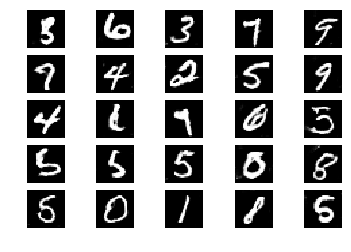

2251 [D loss: 0.648345, acc.: 61.52%] [G loss: 1.317166]
2252 [D loss: 0.592061, acc.: 69.34%] [G loss: 1.258496]
2253 [D loss: 0.636818, acc.: 64.84%] [G loss: 1.139578]
2254 [D loss: 0.640068, acc.: 63.48%] [G loss: 1.029137]
2255 [D loss: 0.532659, acc.: 74.22%] [G loss: 0.983948]
2256 [D loss: 0.667534, acc.: 59.77%] [G loss: 1.043561]
2257 [D loss: 0.795657, acc.: 46.09%] [G loss: 0.964445]
2258 [D loss: 0.597261, acc.: 66.99%] [G loss: 0.880915]
2259 [D loss: 0.556372, acc.: 71.48%] [G loss: 1.057950]
2260 [D loss: 0.701827, acc.: 56.25%] [G loss: 1.109915]
2261 [D loss: 0.609272, acc.: 67.77%] [G loss: 0.995294]
2262 [D loss: 0.669728, acc.: 60.94%] [G loss: 1.076221]
2263 [D loss: 0.638378, acc.: 62.30%] [G loss: 1.238991]
2264 [D loss: 0.629424, acc.: 66.99%] [G loss: 1.061835]
2265 [D loss: 0.644874, acc.: 63.67%] [G loss: 1.114240]
2266 [D loss: 0.671734, acc.: 58.98%] [G loss: 1.058442]
2267 [D loss: 0.598464, acc.: 67.38%] [G loss: 1.113678]
2268 [D loss: 0.584660, acc.: 6

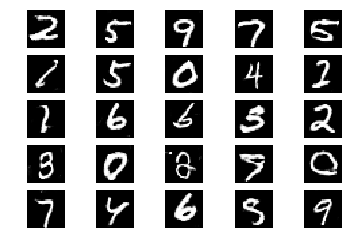

2301 [D loss: 0.725260, acc.: 55.08%] [G loss: 1.167168]
2302 [D loss: 0.700216, acc.: 56.05%] [G loss: 0.990297]
2303 [D loss: 0.695704, acc.: 54.49%] [G loss: 1.070956]
2304 [D loss: 0.635104, acc.: 63.67%] [G loss: 1.274044]
2305 [D loss: 0.595908, acc.: 66.80%] [G loss: 1.269773]
2306 [D loss: 0.594622, acc.: 67.19%] [G loss: 1.139382]
2307 [D loss: 0.685640, acc.: 58.98%] [G loss: 1.031766]
2308 [D loss: 0.663227, acc.: 58.79%] [G loss: 0.905599]
2309 [D loss: 0.613230, acc.: 68.55%] [G loss: 1.002271]
2310 [D loss: 0.751764, acc.: 50.39%] [G loss: 1.069640]
2311 [D loss: 0.639379, acc.: 62.11%] [G loss: 0.913680]
2312 [D loss: 0.555278, acc.: 72.85%] [G loss: 1.051262]
2313 [D loss: 0.672512, acc.: 60.16%] [G loss: 1.092061]
2314 [D loss: 0.704580, acc.: 56.05%] [G loss: 0.933769]
2315 [D loss: 0.681528, acc.: 58.20%] [G loss: 1.043366]
2316 [D loss: 0.660450, acc.: 60.94%] [G loss: 1.053148]
2317 [D loss: 0.635954, acc.: 64.06%] [G loss: 1.259055]
2318 [D loss: 0.725331, acc.: 5

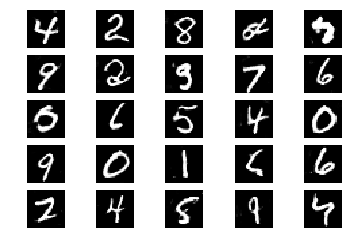

2351 [D loss: 0.645505, acc.: 60.94%] [G loss: 1.094027]
2352 [D loss: 0.612562, acc.: 66.80%] [G loss: 1.088766]
2353 [D loss: 0.619311, acc.: 65.43%] [G loss: 1.075427]
2354 [D loss: 0.641391, acc.: 61.91%] [G loss: 1.212008]
2355 [D loss: 0.640748, acc.: 64.84%] [G loss: 1.071779]
2356 [D loss: 0.606980, acc.: 65.04%] [G loss: 1.152150]
2357 [D loss: 0.739925, acc.: 50.20%] [G loss: 0.924208]
2358 [D loss: 0.687464, acc.: 54.88%] [G loss: 1.096161]
2359 [D loss: 0.543566, acc.: 73.24%] [G loss: 1.154324]
2360 [D loss: 0.692921, acc.: 58.59%] [G loss: 0.933439]
2361 [D loss: 0.601696, acc.: 67.97%] [G loss: 1.141088]
2362 [D loss: 0.654104, acc.: 64.06%] [G loss: 0.995204]
2363 [D loss: 0.668809, acc.: 58.59%] [G loss: 1.043666]
2364 [D loss: 0.706329, acc.: 55.47%] [G loss: 1.010245]
2365 [D loss: 0.604085, acc.: 66.41%] [G loss: 1.139095]
2366 [D loss: 0.679837, acc.: 58.79%] [G loss: 1.268900]
2367 [D loss: 0.608593, acc.: 66.41%] [G loss: 1.138172]
2368 [D loss: 0.671377, acc.: 6

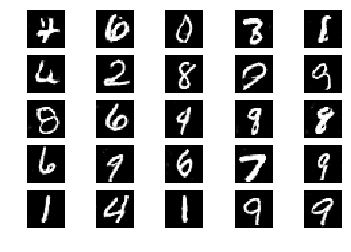

2401 [D loss: 0.695052, acc.: 55.86%] [G loss: 1.215514]
2402 [D loss: 0.604447, acc.: 68.36%] [G loss: 1.201917]
2403 [D loss: 0.582463, acc.: 70.70%] [G loss: 1.119817]
2404 [D loss: 0.580016, acc.: 71.48%] [G loss: 1.121545]
2405 [D loss: 0.610303, acc.: 67.38%] [G loss: 1.075308]
2406 [D loss: 0.706881, acc.: 53.32%] [G loss: 1.092795]
2407 [D loss: 0.566073, acc.: 70.31%] [G loss: 1.127482]
2408 [D loss: 0.633693, acc.: 64.84%] [G loss: 1.136104]
2409 [D loss: 0.626615, acc.: 66.02%] [G loss: 1.143751]
2410 [D loss: 0.698706, acc.: 53.71%] [G loss: 1.056978]
2411 [D loss: 0.621499, acc.: 65.43%] [G loss: 0.984956]
2412 [D loss: 0.625578, acc.: 64.26%] [G loss: 1.092564]
2413 [D loss: 0.562568, acc.: 72.27%] [G loss: 1.120548]
2414 [D loss: 0.552801, acc.: 73.05%] [G loss: 1.177794]
2415 [D loss: 0.715842, acc.: 55.66%] [G loss: 0.986395]
2416 [D loss: 0.693500, acc.: 54.69%] [G loss: 1.177778]
2417 [D loss: 0.621325, acc.: 64.65%] [G loss: 1.198011]
2418 [D loss: 0.663168, acc.: 5

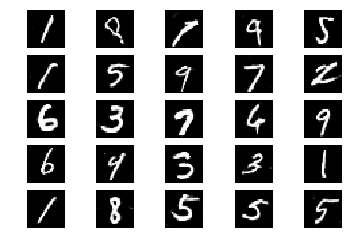

2451 [D loss: 0.648577, acc.: 62.30%] [G loss: 1.059757]
2452 [D loss: 0.599217, acc.: 67.38%] [G loss: 0.977666]
2453 [D loss: 0.590320, acc.: 71.68%] [G loss: 1.239816]
2454 [D loss: 0.669304, acc.: 60.94%] [G loss: 1.050610]
2455 [D loss: 0.655286, acc.: 60.55%] [G loss: 1.187759]
2456 [D loss: 0.634833, acc.: 62.89%] [G loss: 0.979330]
2457 [D loss: 0.668694, acc.: 58.79%] [G loss: 1.021759]
2458 [D loss: 0.661579, acc.: 61.33%] [G loss: 0.984742]
2459 [D loss: 0.633648, acc.: 63.28%] [G loss: 1.114475]
2460 [D loss: 0.718819, acc.: 53.91%] [G loss: 1.330998]
2461 [D loss: 0.638915, acc.: 62.30%] [G loss: 1.255463]
2462 [D loss: 0.707800, acc.: 53.52%] [G loss: 1.078763]
2463 [D loss: 0.575264, acc.: 70.51%] [G loss: 1.061424]
2464 [D loss: 0.711846, acc.: 53.32%] [G loss: 0.999343]
2465 [D loss: 0.670403, acc.: 58.01%] [G loss: 1.053789]
2466 [D loss: 0.573340, acc.: 71.29%] [G loss: 1.375386]
2467 [D loss: 0.620508, acc.: 65.62%] [G loss: 1.098893]
2468 [D loss: 0.532007, acc.: 7

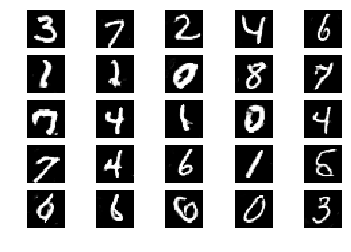

2501 [D loss: 0.721648, acc.: 53.71%] [G loss: 1.093257]
2502 [D loss: 0.650951, acc.: 62.50%] [G loss: 1.124721]
2503 [D loss: 0.574804, acc.: 70.51%] [G loss: 0.987532]
2504 [D loss: 0.669479, acc.: 62.11%] [G loss: 0.892728]
2505 [D loss: 0.713496, acc.: 55.66%] [G loss: 0.909339]
2506 [D loss: 0.638565, acc.: 64.45%] [G loss: 1.153387]
2507 [D loss: 0.655001, acc.: 62.30%] [G loss: 1.150401]
2508 [D loss: 0.558321, acc.: 74.80%] [G loss: 1.116480]
2509 [D loss: 0.769257, acc.: 48.05%] [G loss: 0.945044]
2510 [D loss: 0.568327, acc.: 72.07%] [G loss: 0.982432]
2511 [D loss: 0.612222, acc.: 65.43%] [G loss: 1.023098]
2512 [D loss: 0.630378, acc.: 64.45%] [G loss: 1.078565]
2513 [D loss: 0.637241, acc.: 64.06%] [G loss: 0.815761]
2514 [D loss: 0.602169, acc.: 67.38%] [G loss: 1.104512]
2515 [D loss: 0.632570, acc.: 61.91%] [G loss: 1.200887]
2516 [D loss: 0.603318, acc.: 68.36%] [G loss: 1.134598]
2517 [D loss: 0.740228, acc.: 52.15%] [G loss: 1.132479]
2518 [D loss: 0.635404, acc.: 6

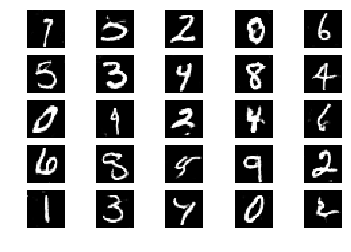

2551 [D loss: 0.698554, acc.: 55.86%] [G loss: 1.357433]
2552 [D loss: 0.686231, acc.: 58.20%] [G loss: 1.024109]
2553 [D loss: 0.659798, acc.: 60.74%] [G loss: 1.059932]
2554 [D loss: 0.577441, acc.: 67.97%] [G loss: 1.034357]
2555 [D loss: 0.588111, acc.: 69.92%] [G loss: 1.169431]
2556 [D loss: 0.553814, acc.: 72.07%] [G loss: 1.212159]
2557 [D loss: 0.696606, acc.: 56.25%] [G loss: 0.997869]
2558 [D loss: 0.531520, acc.: 75.78%] [G loss: 1.262280]
2559 [D loss: 0.638457, acc.: 62.50%] [G loss: 1.351011]
2560 [D loss: 0.642320, acc.: 63.28%] [G loss: 1.115633]
2561 [D loss: 0.708851, acc.: 54.69%] [G loss: 1.010257]
2562 [D loss: 0.656038, acc.: 61.52%] [G loss: 1.281499]
2563 [D loss: 0.551390, acc.: 70.51%] [G loss: 1.112254]
2564 [D loss: 0.825102, acc.: 43.75%] [G loss: 1.051513]
2565 [D loss: 0.655091, acc.: 60.16%] [G loss: 1.015168]
2566 [D loss: 0.502593, acc.: 80.27%] [G loss: 1.087185]
2567 [D loss: 0.550231, acc.: 74.22%] [G loss: 1.055101]
2568 [D loss: 0.675553, acc.: 5

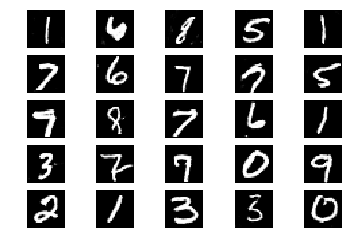

2601 [D loss: 0.634776, acc.: 63.09%] [G loss: 1.130844]
2602 [D loss: 0.651695, acc.: 62.70%] [G loss: 1.224793]
2603 [D loss: 0.519593, acc.: 77.54%] [G loss: 1.154883]
2604 [D loss: 0.690306, acc.: 58.59%] [G loss: 1.058028]
2605 [D loss: 0.615856, acc.: 64.45%] [G loss: 1.206521]
2606 [D loss: 0.667760, acc.: 61.13%] [G loss: 1.226906]
2607 [D loss: 0.604998, acc.: 66.99%] [G loss: 1.168384]
2608 [D loss: 0.733618, acc.: 52.54%] [G loss: 0.881303]
2609 [D loss: 0.573612, acc.: 69.73%] [G loss: 1.057537]
2610 [D loss: 0.697879, acc.: 54.49%] [G loss: 0.962575]
2611 [D loss: 0.649090, acc.: 62.30%] [G loss: 1.142987]
2612 [D loss: 0.625633, acc.: 65.23%] [G loss: 1.146127]
2613 [D loss: 0.624166, acc.: 65.43%] [G loss: 1.119155]
2614 [D loss: 0.643642, acc.: 62.70%] [G loss: 1.035080]
2615 [D loss: 0.679521, acc.: 57.81%] [G loss: 1.187576]
2616 [D loss: 0.630554, acc.: 65.04%] [G loss: 0.860431]
2617 [D loss: 0.646076, acc.: 62.50%] [G loss: 1.120523]
2618 [D loss: 0.602696, acc.: 6

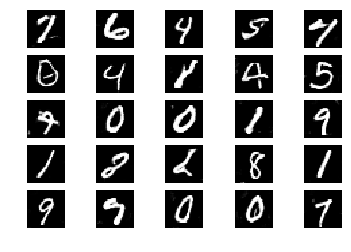

2651 [D loss: 0.640655, acc.: 62.30%] [G loss: 1.011236]
2652 [D loss: 0.654938, acc.: 62.89%] [G loss: 1.033183]
2653 [D loss: 0.571077, acc.: 70.90%] [G loss: 0.993967]
2654 [D loss: 0.644001, acc.: 62.50%] [G loss: 1.128890]
2655 [D loss: 0.612281, acc.: 66.02%] [G loss: 1.095565]
2656 [D loss: 0.613820, acc.: 67.97%] [G loss: 1.225749]
2657 [D loss: 0.640038, acc.: 65.43%] [G loss: 1.046349]
2658 [D loss: 0.704662, acc.: 56.64%] [G loss: 1.058553]
2659 [D loss: 0.561578, acc.: 72.46%] [G loss: 0.997617]
2660 [D loss: 0.592288, acc.: 69.14%] [G loss: 1.089640]
2661 [D loss: 0.677844, acc.: 59.96%] [G loss: 1.004073]
2662 [D loss: 0.593031, acc.: 68.16%] [G loss: 1.199553]
2663 [D loss: 0.652902, acc.: 61.13%] [G loss: 1.128629]
2664 [D loss: 0.631914, acc.: 65.62%] [G loss: 1.085353]
2665 [D loss: 0.613209, acc.: 64.84%] [G loss: 1.135750]
2666 [D loss: 0.628229, acc.: 65.62%] [G loss: 1.090943]
2667 [D loss: 0.680771, acc.: 58.20%] [G loss: 1.107330]
2668 [D loss: 0.510502, acc.: 7

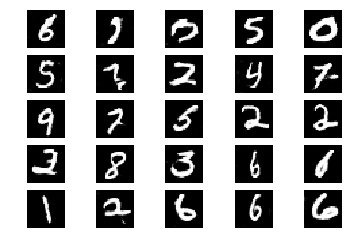

2701 [D loss: 0.700501, acc.: 54.49%] [G loss: 1.172854]
2702 [D loss: 0.571301, acc.: 68.95%] [G loss: 1.124437]
2703 [D loss: 0.763012, acc.: 50.20%] [G loss: 0.955107]
2704 [D loss: 0.734065, acc.: 53.91%] [G loss: 0.963729]
2705 [D loss: 0.667297, acc.: 61.72%] [G loss: 1.401277]
2706 [D loss: 0.572204, acc.: 70.90%] [G loss: 1.052030]
2707 [D loss: 0.651702, acc.: 63.87%] [G loss: 0.959748]
2708 [D loss: 0.695235, acc.: 58.40%] [G loss: 1.070825]
2709 [D loss: 0.623649, acc.: 66.02%] [G loss: 0.920584]
2710 [D loss: 0.653333, acc.: 61.13%] [G loss: 1.067808]
2711 [D loss: 0.614210, acc.: 63.87%] [G loss: 1.227105]
2712 [D loss: 0.615778, acc.: 66.21%] [G loss: 0.967763]
2713 [D loss: 0.632257, acc.: 63.87%] [G loss: 1.103528]
2714 [D loss: 0.747521, acc.: 50.98%] [G loss: 0.954287]
2715 [D loss: 0.647427, acc.: 63.48%] [G loss: 1.278723]
2716 [D loss: 0.634086, acc.: 64.45%] [G loss: 1.063419]
2717 [D loss: 0.679281, acc.: 57.42%] [G loss: 1.009719]
2718 [D loss: 0.575205, acc.: 7

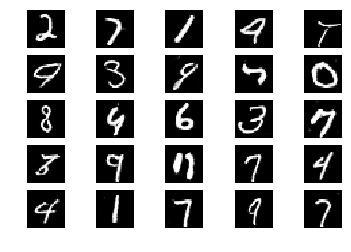

2751 [D loss: 0.676556, acc.: 58.98%] [G loss: 1.026731]
2752 [D loss: 0.673008, acc.: 58.59%] [G loss: 0.984432]
2753 [D loss: 0.610710, acc.: 69.34%] [G loss: 1.156923]
2754 [D loss: 0.705496, acc.: 53.32%] [G loss: 1.177340]
2755 [D loss: 0.714570, acc.: 53.52%] [G loss: 1.048298]
2756 [D loss: 0.682485, acc.: 59.18%] [G loss: 0.975745]
2757 [D loss: 0.722126, acc.: 53.12%] [G loss: 1.097165]
2758 [D loss: 0.577958, acc.: 70.31%] [G loss: 1.221218]
2759 [D loss: 0.631602, acc.: 63.87%] [G loss: 1.189605]
2760 [D loss: 0.603539, acc.: 65.82%] [G loss: 1.244989]
2761 [D loss: 0.614385, acc.: 64.84%] [G loss: 1.085419]
2762 [D loss: 0.627924, acc.: 64.65%] [G loss: 0.966991]
2763 [D loss: 0.629132, acc.: 64.26%] [G loss: 1.090541]
2764 [D loss: 0.704671, acc.: 57.03%] [G loss: 0.876971]
2765 [D loss: 0.647586, acc.: 60.74%] [G loss: 1.097651]
2766 [D loss: 0.592991, acc.: 68.55%] [G loss: 1.027116]
2767 [D loss: 0.590609, acc.: 70.12%] [G loss: 0.984959]
2768 [D loss: 0.671788, acc.: 5

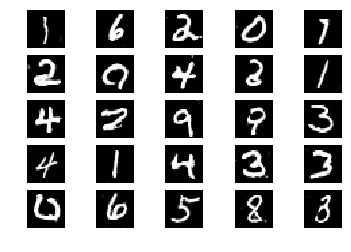

2801 [D loss: 0.655143, acc.: 60.55%] [G loss: 1.086001]
2802 [D loss: 0.737006, acc.: 52.34%] [G loss: 1.040170]
2803 [D loss: 0.674904, acc.: 58.40%] [G loss: 1.051236]
2804 [D loss: 0.642659, acc.: 62.11%] [G loss: 1.053163]
2805 [D loss: 0.709239, acc.: 57.03%] [G loss: 1.060335]
2806 [D loss: 0.635866, acc.: 60.74%] [G loss: 1.256270]
2807 [D loss: 0.728738, acc.: 53.52%] [G loss: 1.025442]
2808 [D loss: 0.664515, acc.: 60.35%] [G loss: 1.088794]
2809 [D loss: 0.671128, acc.: 57.42%] [G loss: 1.008491]
2810 [D loss: 0.650736, acc.: 63.28%] [G loss: 0.873562]
2811 [D loss: 0.653755, acc.: 62.30%] [G loss: 1.000168]
2812 [D loss: 0.576573, acc.: 70.70%] [G loss: 1.114409]
2813 [D loss: 0.595773, acc.: 66.80%] [G loss: 1.172833]
2814 [D loss: 0.762082, acc.: 51.37%] [G loss: 1.108352]
2815 [D loss: 0.636291, acc.: 62.11%] [G loss: 1.049637]
2816 [D loss: 0.643855, acc.: 63.28%] [G loss: 1.098333]
2817 [D loss: 0.676640, acc.: 60.55%] [G loss: 1.057104]
2818 [D loss: 0.689775, acc.: 5

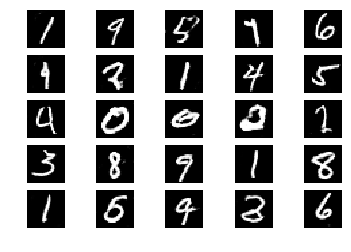

2851 [D loss: 0.595473, acc.: 66.99%] [G loss: 1.040409]
2852 [D loss: 0.587839, acc.: 67.19%] [G loss: 1.135209]
2853 [D loss: 0.647288, acc.: 62.50%] [G loss: 1.150965]
2854 [D loss: 0.559054, acc.: 73.44%] [G loss: 1.193268]
2855 [D loss: 0.524611, acc.: 77.93%] [G loss: 1.173067]
2856 [D loss: 0.626553, acc.: 63.67%] [G loss: 1.062273]
2857 [D loss: 0.642575, acc.: 61.52%] [G loss: 1.053313]
2858 [D loss: 0.577620, acc.: 71.88%] [G loss: 1.151601]
2859 [D loss: 0.598962, acc.: 69.92%] [G loss: 0.914951]
2860 [D loss: 0.590486, acc.: 70.31%] [G loss: 1.172253]
2861 [D loss: 0.721399, acc.: 52.15%] [G loss: 0.982752]
2862 [D loss: 0.648036, acc.: 64.06%] [G loss: 1.108827]
2863 [D loss: 0.586713, acc.: 69.14%] [G loss: 1.156801]
2864 [D loss: 0.628111, acc.: 64.06%] [G loss: 1.078260]
2865 [D loss: 0.669446, acc.: 62.70%] [G loss: 1.057173]
2866 [D loss: 0.707964, acc.: 55.66%] [G loss: 1.096477]
2867 [D loss: 0.573872, acc.: 70.51%] [G loss: 1.110662]
2868 [D loss: 0.749491, acc.: 4

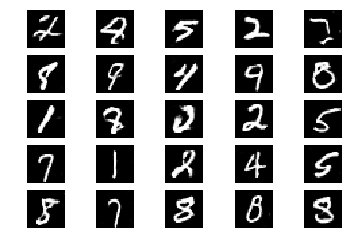

2901 [D loss: 0.665989, acc.: 56.84%] [G loss: 0.945623]
2902 [D loss: 0.723104, acc.: 55.08%] [G loss: 1.049077]
2903 [D loss: 0.661378, acc.: 60.94%] [G loss: 0.951711]
2904 [D loss: 0.598669, acc.: 66.80%] [G loss: 0.994910]
2905 [D loss: 0.882324, acc.: 37.89%] [G loss: 0.881199]
2906 [D loss: 0.634108, acc.: 64.26%] [G loss: 0.954464]
2907 [D loss: 0.694209, acc.: 57.81%] [G loss: 1.029705]
2908 [D loss: 0.666959, acc.: 61.72%] [G loss: 1.151209]
2909 [D loss: 0.700355, acc.: 56.84%] [G loss: 1.016397]
2910 [D loss: 0.571466, acc.: 71.29%] [G loss: 1.012563]
2911 [D loss: 0.672200, acc.: 59.77%] [G loss: 0.870838]
2912 [D loss: 0.585358, acc.: 70.31%] [G loss: 1.152794]
2913 [D loss: 0.640456, acc.: 62.11%] [G loss: 0.921012]
2914 [D loss: 0.598592, acc.: 68.36%] [G loss: 1.128445]
2915 [D loss: 0.592512, acc.: 66.60%] [G loss: 0.989179]
2916 [D loss: 0.660581, acc.: 61.72%] [G loss: 1.131740]
2917 [D loss: 0.689313, acc.: 56.45%] [G loss: 1.075762]
2918 [D loss: 0.714720, acc.: 5

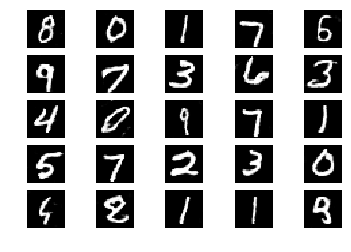

2951 [D loss: 0.654161, acc.: 60.74%] [G loss: 1.067117]
2952 [D loss: 0.635573, acc.: 60.16%] [G loss: 1.114646]
2953 [D loss: 0.703145, acc.: 56.25%] [G loss: 1.126229]
2954 [D loss: 0.561942, acc.: 73.63%] [G loss: 1.102086]
2955 [D loss: 0.690542, acc.: 58.01%] [G loss: 0.869496]
2956 [D loss: 0.728797, acc.: 54.88%] [G loss: 1.117699]
2957 [D loss: 0.671076, acc.: 58.98%] [G loss: 1.133200]
2958 [D loss: 0.676201, acc.: 59.96%] [G loss: 1.007482]
2959 [D loss: 0.562215, acc.: 73.83%] [G loss: 1.164572]
2960 [D loss: 0.687569, acc.: 58.59%] [G loss: 0.956848]
2961 [D loss: 0.666911, acc.: 60.94%] [G loss: 1.032990]
2962 [D loss: 0.524733, acc.: 76.17%] [G loss: 1.109676]
2963 [D loss: 0.669341, acc.: 60.94%] [G loss: 1.026102]
2964 [D loss: 0.700975, acc.: 58.98%] [G loss: 0.888861]
2965 [D loss: 0.670238, acc.: 58.40%] [G loss: 1.204445]
2966 [D loss: 0.580222, acc.: 68.75%] [G loss: 1.093831]
2967 [D loss: 0.669873, acc.: 60.35%] [G loss: 1.062013]
2968 [D loss: 0.651006, acc.: 6

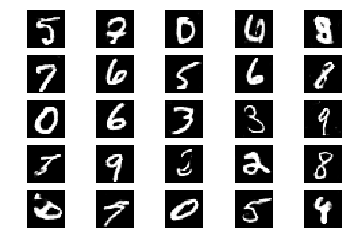

3001 [D loss: 0.695765, acc.: 55.86%] [G loss: 0.821077]
3002 [D loss: 0.767451, acc.: 48.83%] [G loss: 0.954684]
3003 [D loss: 0.591212, acc.: 68.75%] [G loss: 1.061969]
3004 [D loss: 0.636988, acc.: 63.09%] [G loss: 1.183688]
3005 [D loss: 0.610845, acc.: 66.41%] [G loss: 0.954368]
3006 [D loss: 0.604178, acc.: 65.04%] [G loss: 1.092206]
3007 [D loss: 0.731769, acc.: 52.15%] [G loss: 1.209155]
3008 [D loss: 0.479981, acc.: 81.45%] [G loss: 1.161905]
3009 [D loss: 0.647944, acc.: 62.30%] [G loss: 1.153808]
3010 [D loss: 0.622736, acc.: 67.97%] [G loss: 1.321343]
3011 [D loss: 0.666325, acc.: 58.40%] [G loss: 1.041720]
3012 [D loss: 0.660683, acc.: 59.96%] [G loss: 1.169101]
3013 [D loss: 0.587891, acc.: 66.60%] [G loss: 1.000536]
3014 [D loss: 0.703927, acc.: 55.47%] [G loss: 1.090157]
3015 [D loss: 0.513308, acc.: 80.27%] [G loss: 1.223441]
3016 [D loss: 0.623598, acc.: 64.84%] [G loss: 1.191145]
3017 [D loss: 0.645407, acc.: 62.50%] [G loss: 1.074102]
3018 [D loss: 0.675477, acc.: 5

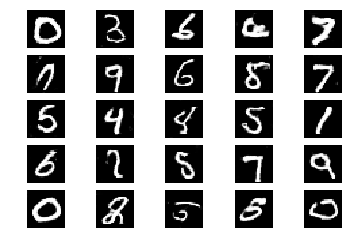

3051 [D loss: 0.617946, acc.: 66.60%] [G loss: 1.076183]
3052 [D loss: 0.650819, acc.: 62.70%] [G loss: 1.009742]
3053 [D loss: 0.515037, acc.: 78.71%] [G loss: 1.254182]
3054 [D loss: 0.629371, acc.: 63.87%] [G loss: 1.314079]
3055 [D loss: 0.711631, acc.: 54.69%] [G loss: 1.028277]
3056 [D loss: 0.624757, acc.: 63.67%] [G loss: 1.111604]
3057 [D loss: 0.654435, acc.: 62.50%] [G loss: 0.924595]
3058 [D loss: 0.546882, acc.: 75.78%] [G loss: 1.038183]
3059 [D loss: 0.720544, acc.: 53.52%] [G loss: 1.033245]
3060 [D loss: 0.622846, acc.: 66.02%] [G loss: 1.021858]
3061 [D loss: 0.604795, acc.: 68.16%] [G loss: 1.026572]
3062 [D loss: 0.575203, acc.: 68.55%] [G loss: 1.168324]
3063 [D loss: 0.639872, acc.: 63.09%] [G loss: 1.111986]
3064 [D loss: 0.665681, acc.: 62.89%] [G loss: 1.017215]
3065 [D loss: 0.679628, acc.: 57.62%] [G loss: 0.893557]
3066 [D loss: 0.760776, acc.: 48.24%] [G loss: 0.895408]
3067 [D loss: 0.567126, acc.: 70.90%] [G loss: 1.074198]
3068 [D loss: 0.634555, acc.: 6

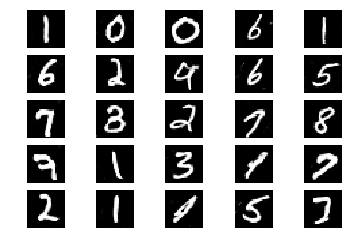

3101 [D loss: 0.706511, acc.: 55.66%] [G loss: 0.976893]
3102 [D loss: 0.585478, acc.: 70.70%] [G loss: 1.061572]
3103 [D loss: 0.594834, acc.: 68.16%] [G loss: 1.219072]
3104 [D loss: 0.613558, acc.: 64.84%] [G loss: 1.333265]
3105 [D loss: 0.663886, acc.: 59.38%] [G loss: 1.047871]
3106 [D loss: 0.601104, acc.: 66.99%] [G loss: 1.078331]
3107 [D loss: 0.600332, acc.: 66.41%] [G loss: 1.138175]
3108 [D loss: 0.640996, acc.: 63.67%] [G loss: 1.076786]
3109 [D loss: 0.661382, acc.: 59.77%] [G loss: 1.221489]
3110 [D loss: 0.582843, acc.: 69.14%] [G loss: 1.052535]
3111 [D loss: 0.732952, acc.: 52.73%] [G loss: 1.186519]
3112 [D loss: 0.660589, acc.: 63.09%] [G loss: 1.008586]
3113 [D loss: 0.610474, acc.: 67.97%] [G loss: 1.321679]
3114 [D loss: 0.650136, acc.: 61.72%] [G loss: 1.146940]
3115 [D loss: 0.713137, acc.: 53.71%] [G loss: 1.074026]
3116 [D loss: 0.568519, acc.: 72.66%] [G loss: 1.205687]
3117 [D loss: 0.746461, acc.: 50.39%] [G loss: 1.098140]
3118 [D loss: 0.665746, acc.: 6

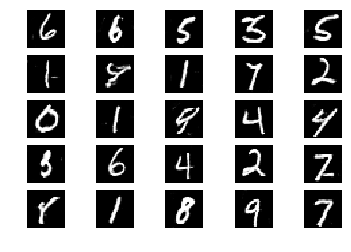

3151 [D loss: 0.654434, acc.: 59.57%] [G loss: 0.950655]
3152 [D loss: 0.628596, acc.: 64.45%] [G loss: 1.134469]
3153 [D loss: 0.628694, acc.: 64.06%] [G loss: 1.208101]
3154 [D loss: 0.616565, acc.: 67.19%] [G loss: 1.064810]
3155 [D loss: 0.622231, acc.: 63.67%] [G loss: 1.191034]
3156 [D loss: 0.616741, acc.: 65.04%] [G loss: 1.177359]
3157 [D loss: 0.591990, acc.: 68.95%] [G loss: 1.095361]
3158 [D loss: 0.703012, acc.: 54.88%] [G loss: 0.993555]
3159 [D loss: 0.546795, acc.: 73.63%] [G loss: 0.941095]
3160 [D loss: 0.574046, acc.: 70.31%] [G loss: 1.082678]
3161 [D loss: 0.571057, acc.: 73.63%] [G loss: 1.177971]
3162 [D loss: 0.519161, acc.: 77.34%] [G loss: 1.257122]
3163 [D loss: 0.710801, acc.: 52.34%] [G loss: 1.099611]
3164 [D loss: 0.673829, acc.: 57.23%] [G loss: 0.964292]
3165 [D loss: 0.534307, acc.: 76.76%] [G loss: 1.109674]
3166 [D loss: 0.581207, acc.: 70.31%] [G loss: 1.033875]
3167 [D loss: 0.647288, acc.: 61.91%] [G loss: 0.992566]
3168 [D loss: 0.599578, acc.: 6

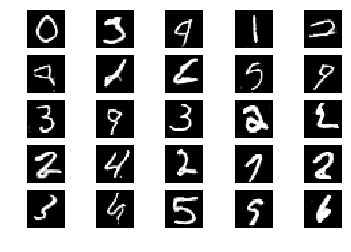

3201 [D loss: 0.672372, acc.: 57.81%] [G loss: 1.094839]
3202 [D loss: 0.664587, acc.: 61.91%] [G loss: 0.975102]
3203 [D loss: 0.761507, acc.: 49.22%] [G loss: 0.820122]
3204 [D loss: 0.632243, acc.: 66.02%] [G loss: 0.914081]
3205 [D loss: 0.582449, acc.: 69.73%] [G loss: 1.271043]
3206 [D loss: 0.638246, acc.: 61.91%] [G loss: 1.030099]
3207 [D loss: 0.744530, acc.: 50.98%] [G loss: 1.171596]
3208 [D loss: 0.661924, acc.: 60.55%] [G loss: 0.969131]
3209 [D loss: 0.617424, acc.: 66.02%] [G loss: 1.128549]
3210 [D loss: 0.602766, acc.: 67.58%] [G loss: 1.126425]
3211 [D loss: 0.589388, acc.: 68.55%] [G loss: 1.060045]
3212 [D loss: 0.665202, acc.: 62.30%] [G loss: 1.077498]
3213 [D loss: 0.552065, acc.: 72.85%] [G loss: 1.153397]
3214 [D loss: 0.602787, acc.: 71.68%] [G loss: 1.085903]
3215 [D loss: 0.647380, acc.: 63.28%] [G loss: 1.015500]
3216 [D loss: 0.685538, acc.: 59.96%] [G loss: 1.279685]
3217 [D loss: 0.669063, acc.: 60.74%] [G loss: 0.951097]
3218 [D loss: 0.622973, acc.: 6

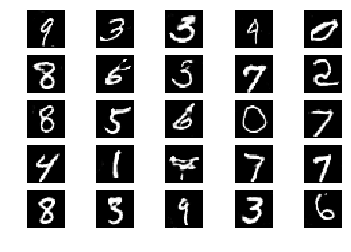

3251 [D loss: 0.660800, acc.: 61.72%] [G loss: 1.239609]
3252 [D loss: 0.650366, acc.: 64.06%] [G loss: 0.979958]
3253 [D loss: 0.702964, acc.: 56.25%] [G loss: 1.066234]
3254 [D loss: 0.648417, acc.: 60.35%] [G loss: 1.155903]
3255 [D loss: 0.527937, acc.: 77.54%] [G loss: 1.117277]
3256 [D loss: 0.609343, acc.: 66.80%] [G loss: 1.005515]
3257 [D loss: 0.631905, acc.: 64.65%] [G loss: 1.048472]
3258 [D loss: 0.687004, acc.: 57.42%] [G loss: 1.167312]
3259 [D loss: 0.585543, acc.: 67.38%] [G loss: 0.867088]
3260 [D loss: 0.626098, acc.: 65.04%] [G loss: 1.075325]
3261 [D loss: 0.689077, acc.: 58.40%] [G loss: 0.980156]
3262 [D loss: 0.523238, acc.: 75.39%] [G loss: 1.201490]
3263 [D loss: 0.527294, acc.: 77.34%] [G loss: 1.096639]
3264 [D loss: 0.637982, acc.: 65.43%] [G loss: 1.137890]
3265 [D loss: 0.662232, acc.: 60.94%] [G loss: 0.883676]
3266 [D loss: 0.498556, acc.: 79.30%] [G loss: 1.111993]
3267 [D loss: 0.645958, acc.: 63.09%] [G loss: 1.206211]
3268 [D loss: 0.739849, acc.: 5

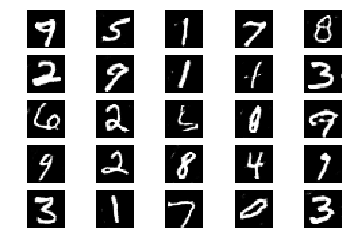

3301 [D loss: 0.589293, acc.: 69.53%] [G loss: 1.231370]
3302 [D loss: 0.605291, acc.: 65.23%] [G loss: 0.935076]
3303 [D loss: 0.638904, acc.: 62.30%] [G loss: 1.179439]
3304 [D loss: 0.592638, acc.: 69.73%] [G loss: 0.993500]
3305 [D loss: 0.635224, acc.: 63.09%] [G loss: 1.248678]
3306 [D loss: 0.583390, acc.: 68.55%] [G loss: 1.290029]
3307 [D loss: 0.647814, acc.: 59.96%] [G loss: 1.220497]
3308 [D loss: 0.656425, acc.: 60.94%] [G loss: 1.096727]
3309 [D loss: 0.653657, acc.: 61.72%] [G loss: 1.120158]
3310 [D loss: 0.700637, acc.: 56.25%] [G loss: 1.325812]
3311 [D loss: 0.658421, acc.: 59.96%] [G loss: 1.214062]
3312 [D loss: 0.629046, acc.: 61.72%] [G loss: 1.170894]
3313 [D loss: 0.661723, acc.: 60.35%] [G loss: 1.203406]
3314 [D loss: 0.625896, acc.: 65.62%] [G loss: 1.045919]
3315 [D loss: 0.671540, acc.: 59.96%] [G loss: 1.312900]
3316 [D loss: 0.735795, acc.: 54.10%] [G loss: 1.192922]
3317 [D loss: 0.676053, acc.: 58.98%] [G loss: 1.092669]
3318 [D loss: 0.584112, acc.: 6

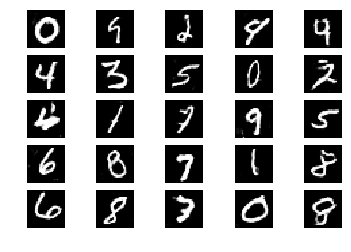

3351 [D loss: 0.659253, acc.: 60.35%] [G loss: 1.093701]
3352 [D loss: 0.640459, acc.: 62.50%] [G loss: 1.160007]
3353 [D loss: 0.625996, acc.: 66.99%] [G loss: 1.064452]
3354 [D loss: 0.647852, acc.: 62.11%] [G loss: 1.295171]
3355 [D loss: 0.661008, acc.: 61.52%] [G loss: 0.976390]
3356 [D loss: 0.612336, acc.: 67.77%] [G loss: 1.016948]
3357 [D loss: 0.671384, acc.: 58.98%] [G loss: 0.906947]
3358 [D loss: 0.632323, acc.: 62.50%] [G loss: 1.080737]
3359 [D loss: 0.616507, acc.: 66.21%] [G loss: 0.912131]
3360 [D loss: 0.696776, acc.: 55.08%] [G loss: 0.946091]
3361 [D loss: 0.637653, acc.: 64.06%] [G loss: 1.134425]
3362 [D loss: 0.662436, acc.: 60.35%] [G loss: 1.231428]
3363 [D loss: 0.760927, acc.: 46.68%] [G loss: 0.997213]
3364 [D loss: 0.653656, acc.: 61.13%] [G loss: 1.057779]
3365 [D loss: 0.642651, acc.: 62.50%] [G loss: 1.044587]
3366 [D loss: 0.685560, acc.: 57.62%] [G loss: 1.089798]
3367 [D loss: 0.538996, acc.: 74.41%] [G loss: 1.135786]
3368 [D loss: 0.752993, acc.: 4

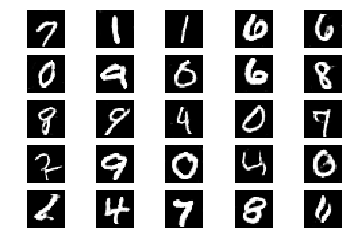

3401 [D loss: 0.671464, acc.: 57.81%] [G loss: 1.103735]
3402 [D loss: 0.706669, acc.: 53.52%] [G loss: 0.994950]
3403 [D loss: 0.634085, acc.: 62.70%] [G loss: 1.133254]
3404 [D loss: 0.718882, acc.: 53.12%] [G loss: 1.018507]
3405 [D loss: 0.674951, acc.: 61.52%] [G loss: 1.091218]
3406 [D loss: 0.729220, acc.: 52.54%] [G loss: 0.956296]
3407 [D loss: 0.568154, acc.: 70.90%] [G loss: 1.263006]
3408 [D loss: 0.756689, acc.: 51.37%] [G loss: 0.902291]
3409 [D loss: 0.598505, acc.: 65.82%] [G loss: 1.127718]
3410 [D loss: 0.677321, acc.: 57.81%] [G loss: 0.939854]
3411 [D loss: 0.578034, acc.: 69.53%] [G loss: 0.920411]
3412 [D loss: 0.630352, acc.: 66.41%] [G loss: 0.948046]
3413 [D loss: 0.689366, acc.: 58.59%] [G loss: 1.147416]
3414 [D loss: 0.658764, acc.: 60.74%] [G loss: 1.357959]
3415 [D loss: 0.572412, acc.: 70.70%] [G loss: 1.168997]
3416 [D loss: 0.761039, acc.: 47.66%] [G loss: 0.905144]
3417 [D loss: 0.546534, acc.: 74.02%] [G loss: 1.077825]
3418 [D loss: 0.685786, acc.: 5

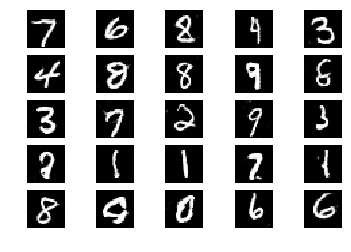

3451 [D loss: 0.557026, acc.: 73.05%] [G loss: 1.022574]
3452 [D loss: 0.592812, acc.: 68.16%] [G loss: 1.016088]
3453 [D loss: 0.574015, acc.: 70.51%] [G loss: 1.346511]
3454 [D loss: 0.684406, acc.: 57.62%] [G loss: 1.030238]
3455 [D loss: 0.626476, acc.: 65.82%] [G loss: 1.083627]
3456 [D loss: 0.658038, acc.: 61.91%] [G loss: 1.028188]
3457 [D loss: 0.686664, acc.: 56.84%] [G loss: 1.114878]
3458 [D loss: 0.613745, acc.: 67.58%] [G loss: 1.137444]
3459 [D loss: 0.641789, acc.: 63.28%] [G loss: 1.055573]
3460 [D loss: 0.604865, acc.: 67.19%] [G loss: 1.156874]
3461 [D loss: 0.706953, acc.: 56.25%] [G loss: 1.101304]
3462 [D loss: 0.588816, acc.: 69.92%] [G loss: 1.019228]
3463 [D loss: 0.684802, acc.: 56.05%] [G loss: 1.040564]
3464 [D loss: 0.797847, acc.: 45.31%] [G loss: 0.965667]
3465 [D loss: 0.575523, acc.: 70.12%] [G loss: 1.127737]
3466 [D loss: 0.695467, acc.: 55.08%] [G loss: 1.110210]
3467 [D loss: 0.674157, acc.: 58.79%] [G loss: 1.044080]
3468 [D loss: 0.633272, acc.: 6

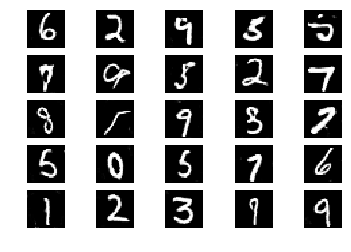

3501 [D loss: 0.651344, acc.: 59.96%] [G loss: 1.201755]
3502 [D loss: 0.582523, acc.: 67.38%] [G loss: 1.208890]
3503 [D loss: 0.598875, acc.: 68.55%] [G loss: 0.965727]
3504 [D loss: 0.615643, acc.: 66.21%] [G loss: 1.127812]
3505 [D loss: 0.658832, acc.: 60.55%] [G loss: 0.898687]
3506 [D loss: 0.638184, acc.: 61.52%] [G loss: 1.213488]
3507 [D loss: 0.617066, acc.: 65.43%] [G loss: 1.136661]
3508 [D loss: 0.620514, acc.: 66.41%] [G loss: 1.101029]
3509 [D loss: 0.566121, acc.: 72.27%] [G loss: 1.100085]
3510 [D loss: 0.682491, acc.: 56.64%] [G loss: 1.177367]
3511 [D loss: 0.702215, acc.: 54.69%] [G loss: 1.003054]
3512 [D loss: 0.614001, acc.: 64.65%] [G loss: 1.041638]
3513 [D loss: 0.657722, acc.: 59.96%] [G loss: 1.063334]
3514 [D loss: 0.691502, acc.: 58.59%] [G loss: 1.133899]
3515 [D loss: 0.571121, acc.: 72.46%] [G loss: 1.217910]
3516 [D loss: 0.650939, acc.: 62.89%] [G loss: 1.149155]
3517 [D loss: 0.550264, acc.: 76.17%] [G loss: 1.098668]
3518 [D loss: 0.662682, acc.: 5

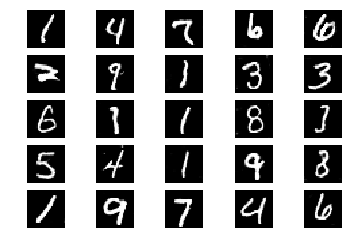

3551 [D loss: 0.570217, acc.: 71.09%] [G loss: 1.155945]
3552 [D loss: 0.544004, acc.: 76.17%] [G loss: 1.140897]
3553 [D loss: 0.703431, acc.: 56.05%] [G loss: 0.971391]
3554 [D loss: 0.663650, acc.: 61.33%] [G loss: 1.164357]
3555 [D loss: 0.702865, acc.: 55.86%] [G loss: 1.101924]
3556 [D loss: 0.573333, acc.: 67.58%] [G loss: 1.097987]
3557 [D loss: 0.620444, acc.: 65.82%] [G loss: 1.021252]
3558 [D loss: 0.603185, acc.: 67.38%] [G loss: 1.031035]
3559 [D loss: 0.720969, acc.: 54.88%] [G loss: 1.075465]
3560 [D loss: 0.585033, acc.: 70.70%] [G loss: 1.078651]
3561 [D loss: 0.672893, acc.: 60.16%] [G loss: 1.119765]
3562 [D loss: 0.688333, acc.: 55.86%] [G loss: 1.062326]
3563 [D loss: 0.694820, acc.: 57.81%] [G loss: 1.053074]
3564 [D loss: 0.677644, acc.: 58.79%] [G loss: 1.168703]
3565 [D loss: 0.582646, acc.: 67.97%] [G loss: 1.258062]
3566 [D loss: 0.561997, acc.: 73.83%] [G loss: 1.234811]
3567 [D loss: 0.563556, acc.: 70.51%] [G loss: 1.034268]
3568 [D loss: 0.716032, acc.: 5

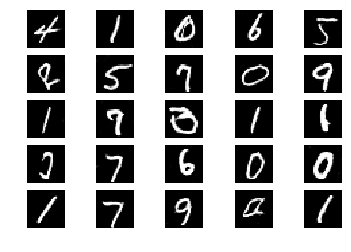

3601 [D loss: 0.657247, acc.: 60.35%] [G loss: 1.252447]
3602 [D loss: 0.608207, acc.: 67.38%] [G loss: 1.153011]
3603 [D loss: 0.692832, acc.: 58.20%] [G loss: 0.959053]
3604 [D loss: 0.652545, acc.: 61.13%] [G loss: 1.003648]
3605 [D loss: 0.607832, acc.: 66.21%] [G loss: 0.854457]
3606 [D loss: 0.561357, acc.: 70.70%] [G loss: 1.132766]
3607 [D loss: 0.718588, acc.: 54.10%] [G loss: 0.904767]
3608 [D loss: 0.697906, acc.: 58.98%] [G loss: 1.064111]
3609 [D loss: 0.583696, acc.: 70.90%] [G loss: 1.147553]
3610 [D loss: 0.620200, acc.: 62.89%] [G loss: 1.296897]
3611 [D loss: 0.561824, acc.: 70.31%] [G loss: 1.120642]
3612 [D loss: 0.565684, acc.: 74.61%] [G loss: 1.151671]
3613 [D loss: 0.530078, acc.: 76.17%] [G loss: 1.154858]
3614 [D loss: 0.605631, acc.: 68.16%] [G loss: 1.259118]
3615 [D loss: 0.687659, acc.: 56.84%] [G loss: 1.258559]
3616 [D loss: 0.618342, acc.: 66.41%] [G loss: 0.974893]
3617 [D loss: 0.645111, acc.: 60.16%] [G loss: 1.271015]
3618 [D loss: 0.631047, acc.: 6

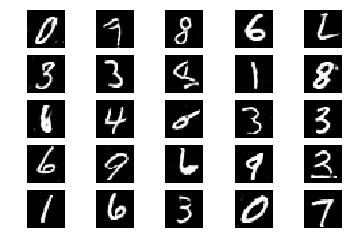

3651 [D loss: 0.663846, acc.: 61.13%] [G loss: 0.969785]
3652 [D loss: 0.546280, acc.: 74.41%] [G loss: 1.086258]
3653 [D loss: 0.613309, acc.: 65.62%] [G loss: 1.095376]
3654 [D loss: 0.647042, acc.: 59.96%] [G loss: 0.995913]
3655 [D loss: 0.628805, acc.: 65.04%] [G loss: 0.857445]
3656 [D loss: 0.722026, acc.: 53.91%] [G loss: 1.221763]
3657 [D loss: 0.618382, acc.: 66.21%] [G loss: 1.002858]
3658 [D loss: 0.694901, acc.: 55.86%] [G loss: 1.127084]
3659 [D loss: 0.591009, acc.: 68.55%] [G loss: 1.009951]
3660 [D loss: 0.621881, acc.: 64.84%] [G loss: 1.263226]
3661 [D loss: 0.633297, acc.: 65.04%] [G loss: 1.076102]
3662 [D loss: 0.735194, acc.: 51.17%] [G loss: 1.359070]
3663 [D loss: 0.681765, acc.: 58.40%] [G loss: 1.118075]
3664 [D loss: 0.582569, acc.: 67.97%] [G loss: 1.099692]
3665 [D loss: 0.539348, acc.: 77.73%] [G loss: 1.211089]
3666 [D loss: 0.542954, acc.: 74.61%] [G loss: 1.039253]
3667 [D loss: 0.713991, acc.: 54.69%] [G loss: 1.022995]
3668 [D loss: 0.733983, acc.: 5

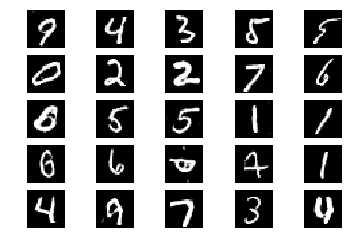

3701 [D loss: 0.608148, acc.: 66.99%] [G loss: 1.104480]
3702 [D loss: 0.628330, acc.: 66.21%] [G loss: 1.113733]
3703 [D loss: 0.561545, acc.: 73.44%] [G loss: 1.193440]
3704 [D loss: 0.674170, acc.: 59.96%] [G loss: 1.189844]
3705 [D loss: 0.578316, acc.: 71.88%] [G loss: 1.105495]
3706 [D loss: 0.557193, acc.: 73.05%] [G loss: 1.034034]
3707 [D loss: 0.668193, acc.: 59.96%] [G loss: 0.984458]
3708 [D loss: 0.597147, acc.: 66.02%] [G loss: 0.993652]
3709 [D loss: 0.545974, acc.: 72.66%] [G loss: 1.368102]
3710 [D loss: 0.678819, acc.: 58.01%] [G loss: 1.113293]
3711 [D loss: 0.599421, acc.: 66.60%] [G loss: 1.058825]
3712 [D loss: 0.564373, acc.: 74.22%] [G loss: 1.125291]
3713 [D loss: 0.677240, acc.: 57.03%] [G loss: 1.260372]
3714 [D loss: 0.695560, acc.: 55.47%] [G loss: 1.080721]
3715 [D loss: 0.634959, acc.: 63.28%] [G loss: 0.992351]
3716 [D loss: 0.631352, acc.: 65.04%] [G loss: 1.261947]
3717 [D loss: 0.611365, acc.: 66.41%] [G loss: 1.194756]
3718 [D loss: 0.723337, acc.: 5

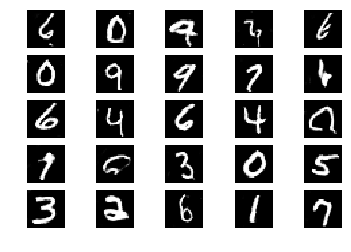

3751 [D loss: 0.628804, acc.: 64.26%] [G loss: 0.921140]
3752 [D loss: 0.699958, acc.: 58.01%] [G loss: 0.950258]
3753 [D loss: 0.628890, acc.: 64.06%] [G loss: 0.934205]
3754 [D loss: 0.659830, acc.: 59.57%] [G loss: 0.928503]
3755 [D loss: 0.666022, acc.: 58.20%] [G loss: 1.296802]
3756 [D loss: 0.597925, acc.: 68.95%] [G loss: 1.076157]
3757 [D loss: 0.710372, acc.: 54.69%] [G loss: 1.195004]
3758 [D loss: 0.697841, acc.: 56.45%] [G loss: 0.985878]
3759 [D loss: 0.637441, acc.: 60.94%] [G loss: 1.177465]
3760 [D loss: 0.560283, acc.: 72.27%] [G loss: 1.202798]
3761 [D loss: 0.610031, acc.: 66.99%] [G loss: 1.159743]
3762 [D loss: 0.713211, acc.: 55.47%] [G loss: 1.082849]
3763 [D loss: 0.537330, acc.: 75.00%] [G loss: 1.116815]
3764 [D loss: 0.720765, acc.: 53.32%] [G loss: 1.117930]
3765 [D loss: 0.629157, acc.: 61.52%] [G loss: 1.046443]
3766 [D loss: 0.698825, acc.: 57.81%] [G loss: 0.995486]
3767 [D loss: 0.704156, acc.: 53.71%] [G loss: 1.170457]
3768 [D loss: 0.629374, acc.: 6

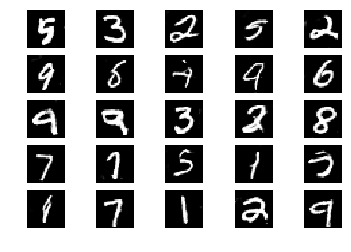

3801 [D loss: 0.726649, acc.: 52.54%] [G loss: 1.069040]
3802 [D loss: 0.594925, acc.: 69.34%] [G loss: 1.117682]
3803 [D loss: 0.714379, acc.: 54.30%] [G loss: 1.230317]
3804 [D loss: 0.566147, acc.: 69.53%] [G loss: 1.130841]
3805 [D loss: 0.589698, acc.: 68.36%] [G loss: 1.197819]
3806 [D loss: 0.770068, acc.: 53.12%] [G loss: 1.078950]
3807 [D loss: 0.608550, acc.: 66.99%] [G loss: 1.231044]
3808 [D loss: 0.601824, acc.: 68.36%] [G loss: 1.079842]
3809 [D loss: 0.605374, acc.: 66.99%] [G loss: 1.061953]
3810 [D loss: 0.576946, acc.: 71.29%] [G loss: 1.201154]
3811 [D loss: 0.675839, acc.: 59.77%] [G loss: 1.321581]
3812 [D loss: 0.607432, acc.: 67.77%] [G loss: 1.227080]
3813 [D loss: 0.687161, acc.: 57.81%] [G loss: 1.044917]
3814 [D loss: 0.569354, acc.: 72.27%] [G loss: 0.955868]
3815 [D loss: 0.653301, acc.: 62.50%] [G loss: 1.114090]
3816 [D loss: 0.697839, acc.: 56.84%] [G loss: 0.969819]
3817 [D loss: 0.567798, acc.: 72.27%] [G loss: 1.156278]
3818 [D loss: 0.524738, acc.: 7

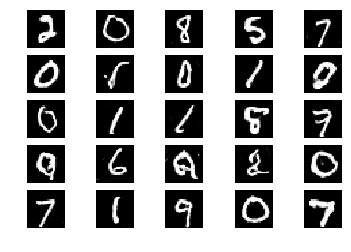

3851 [D loss: 0.571108, acc.: 71.88%] [G loss: 1.281505]
3852 [D loss: 0.660558, acc.: 59.77%] [G loss: 1.143375]
3853 [D loss: 0.620981, acc.: 65.23%] [G loss: 1.135264]
3854 [D loss: 0.692100, acc.: 53.71%] [G loss: 1.122226]
3855 [D loss: 0.706428, acc.: 52.93%] [G loss: 1.071098]
3856 [D loss: 0.752724, acc.: 50.98%] [G loss: 1.171270]
3857 [D loss: 0.579662, acc.: 71.68%] [G loss: 1.025615]
3858 [D loss: 0.594671, acc.: 66.21%] [G loss: 1.040381]
3859 [D loss: 0.675430, acc.: 60.55%] [G loss: 1.012681]
3860 [D loss: 0.628568, acc.: 63.67%] [G loss: 1.144098]
3861 [D loss: 0.594854, acc.: 69.92%] [G loss: 1.129808]
3862 [D loss: 0.609465, acc.: 67.97%] [G loss: 1.062018]
3863 [D loss: 0.738408, acc.: 50.59%] [G loss: 1.162009]
3864 [D loss: 0.637155, acc.: 63.09%] [G loss: 1.069993]
3865 [D loss: 0.649861, acc.: 59.38%] [G loss: 1.144843]
3866 [D loss: 0.640252, acc.: 64.65%] [G loss: 1.107555]
3867 [D loss: 0.671598, acc.: 58.40%] [G loss: 1.099470]
3868 [D loss: 0.595276, acc.: 6

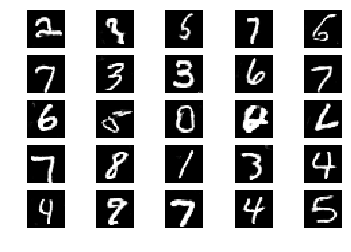

3901 [D loss: 0.621667, acc.: 65.23%] [G loss: 1.092261]
3902 [D loss: 0.650908, acc.: 62.30%] [G loss: 1.033870]
3903 [D loss: 0.641339, acc.: 62.30%] [G loss: 0.992622]
3904 [D loss: 0.600587, acc.: 67.77%] [G loss: 0.991219]
3905 [D loss: 0.643112, acc.: 63.87%] [G loss: 1.085204]
3906 [D loss: 0.736333, acc.: 50.39%] [G loss: 1.136068]
3907 [D loss: 0.618505, acc.: 66.21%] [G loss: 1.171324]
3908 [D loss: 0.710720, acc.: 55.47%] [G loss: 0.956216]
3909 [D loss: 0.641472, acc.: 60.94%] [G loss: 1.207189]
3910 [D loss: 0.702973, acc.: 53.71%] [G loss: 1.160763]
3911 [D loss: 0.616200, acc.: 65.23%] [G loss: 1.129197]
3912 [D loss: 0.582202, acc.: 71.09%] [G loss: 1.146713]
3913 [D loss: 0.702721, acc.: 57.23%] [G loss: 1.008887]
3914 [D loss: 0.722188, acc.: 51.56%] [G loss: 1.295428]
3915 [D loss: 0.755682, acc.: 50.39%] [G loss: 0.995502]
3916 [D loss: 0.580065, acc.: 69.14%] [G loss: 1.252468]
3917 [D loss: 0.655147, acc.: 62.89%] [G loss: 1.078139]
3918 [D loss: 0.644681, acc.: 6

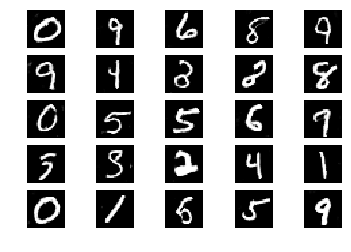

3951 [D loss: 0.626540, acc.: 65.23%] [G loss: 1.056812]
3952 [D loss: 0.599289, acc.: 69.53%] [G loss: 1.030588]
3953 [D loss: 0.678948, acc.: 59.77%] [G loss: 0.977983]
3954 [D loss: 0.661571, acc.: 60.35%] [G loss: 1.104808]
3955 [D loss: 0.649776, acc.: 62.70%] [G loss: 1.233508]
3956 [D loss: 0.593104, acc.: 68.75%] [G loss: 0.989214]
3957 [D loss: 0.743513, acc.: 52.54%] [G loss: 1.039787]
3958 [D loss: 0.653105, acc.: 61.52%] [G loss: 0.935567]
3959 [D loss: 0.612753, acc.: 67.38%] [G loss: 1.015551]
3960 [D loss: 0.716178, acc.: 53.52%] [G loss: 1.088840]
3961 [D loss: 0.614899, acc.: 66.02%] [G loss: 1.076275]
3962 [D loss: 0.649475, acc.: 61.52%] [G loss: 1.106918]
3963 [D loss: 0.813035, acc.: 44.53%] [G loss: 1.033630]
3964 [D loss: 0.659869, acc.: 60.94%] [G loss: 0.935121]
3965 [D loss: 0.743849, acc.: 50.78%] [G loss: 0.993398]
3966 [D loss: 0.636936, acc.: 62.89%] [G loss: 1.133163]
3967 [D loss: 0.708102, acc.: 56.45%] [G loss: 1.038805]
3968 [D loss: 0.613852, acc.: 6

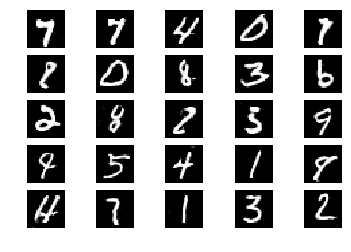

In [165]:
dcgan.train(epochs=4001, batch_size=256, save_interval=50)

### For the given learning rate of 0.01 and 0.05 options with batch size of 128 as well as 256 the model is not converging but its generating decent mnist images
